In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import time,os, math
import pyarrow as pa
import pyarrow.parquet as pq
from numba import cuda
from multiprocessing import Process,Queue
from tqdm import tqdm

from tensorflow_graphics.geometry.transformation.quaternion import from_rotation_matrix
from tensorflow_graphics.geometry.transformation.rotation_matrix_3d import from_quaternion

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU에 4GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=200)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:   
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
from sympy import symbols, cos, sin, pi, simplify, pprint, tan, expand_trig, sqrt, trigsimp, atan2
from sympy.matrices import Matrix
import mpmath
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time,math
import numpy as np
import os

os.chdir('/media/irlab/F042305F42302CAA/6_dof_data')

def pose(theta, d, alpha, l):
    # given the parameters:
    # theta: theta[i]
    # alpha: alpha[i]
    # a: a[i]
    # d: d[i]

    r11, r12 = cos(theta), -sin(theta)*cos(alpha)
    r23, r33 = -cos(theta)*sin(alpha), cos(alpha)
    r21 = sin(theta) 
    r22 = cos(theta) * cos(alpha)
    r13 = sin(theta) * sin(alpha)
    r32 = sin(alpha)
    y = l * sin(theta)
    z = d 
    x = l*cos(theta)

    T = Matrix([
    [r11, r12, r13, x],
    [r21, r22, r23, y],
    [0.0, r32, r33, z],
    [0.0, 0.0, 0.0, 1]
  ])
  
    T = simplify(T)

    return T

# 우리가 사용할 변수들 모두 정의 :
#DH parms 변수들 선언
q1, q2, q3, q4, q5, q6 = symbols('q1:7')
d1 = symbols('d1')  # d5 
a3 = symbols('a3')  # a3 
a2= symbols('a2')   # a2 
d5 = symbols('d5')  # d5 
d4 = symbols('d4')  # d4 
d6= symbols('d6')   # a2 
# T06 에 사용될 우리가 인풋 값을 넣어줄 변수들 ! 
px = symbols('px')
py = symbols('py')
pz = symbols('pz')
alpha= symbols('alpha')  # alpha : roll 
beta= symbols('beta')    # beta : pitch 
gamma= symbols('gamma')  # gamma : Yaw
#pose(theta,d, alpha, a)
d90 = pi/2
T01 = pose(q1,d1,d90,0)
T12 = pose(q2,0,0,a2)
T23 = pose(q3,0,0,a3)
T34 = pose(q4,d4,d90,0)
T45 = pose(q5,d5,-d90,0)
T56 = pose(q6,0,0,0)
T6g = pose(0,0,0,d5)

T02 = simplify(T01*T12)
T03 = simplify(T02*T23)
T04 = simplify(T03*T34)
T05 = simplify(T04*T45)
T06 = simplify(T05*T56)


R0u = Matrix([
    [1.0*cos(alpha)*cos(beta), -1.0*sin(alpha)*cos(gamma) + sin(beta)*sin(gamma)*cos(alpha), 1.0*sin(alpha)*sin(gamma) + sin(beta)*cos(alpha)*cos(gamma)],
    [1.0*sin(alpha)*cos(beta),  sin(alpha)*sin(beta)*sin(gamma) + 1.0*cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma) - 1.0*sin(gamma)*cos(alpha)],
    [          -1.0*sin(beta),                                     1.0*sin(gamma)*cos(beta),                                    1.0*cos(beta)*cos(gamma)]])


Tend =Matrix([
[-sin(alpha)*sin(gamma)+cos(alpha)*cos(beta)*cos(gamma),  -cos(alpha)*sin(beta), sin(alpha)*cos(gamma)+cos(alpha)*cos(beta)*sin(gamma), px],
[sin(beta)*cos(gamma), cos(beta) , sin(beta)*sin(gamma), py],
[-cos(alpha)*sin(gamma)-sin(alpha)*cos(beta)*cos(gamma), sin(alpha)*sin(beta),cos(alpha)*cos(gamma)-sin(alpha)*sin(gamma)*cos(beta) , pz],
[                       0,                                         0,                                      0,  1]])



In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  1 11:59:22 2021

@author: wngks

UR3 Robot Kimenatics & Inv Kinematics
"""
#!/usr/bin/python2
## UR5/UR10 Inverse Kinematics - Ryan Keating Johns Hopkins University

# ***** lib
import numpy as np
from numpy import linalg


import cmath
import math
from math import cos as cos
from math import sin as sin
from math import atan2 as atan2
from math import acos as acos
from math import asin as asin
from math import sqrt as sqrt
from math import pi as pi
from numpy.linalg import norm
global mat
from sklearn.metrics import mean_squared_error
mat=np.matrix


# ****** Coefficients ******


global d1, a2, a3, a7, d4, d5, d6
# 단위 : cm

d1 =  15.19   
a2 = -24.365
a3 = -21.3258
d4 =  11.235
d5 =  8.535
d6 =  8.19
# a7 = 0.075

global d, a, alph
d = mat([15.19, 0,0 ,11.235,8.535,8.19]) #ur3 cm
a =mat([0 ,-24.365 ,-21.325 ,0 ,0 ,0]) #ur3 cm
alph = mat([pi/2, 0, 0, pi/2, -pi/2, 0 ]) # ur3 rad

def RMSE(a,b):
    return mean_squared_error(a,b)**0.5

# ************************************************** FORWARD KINEMATICS
def AH( n,th,c  ):

    T_a = mat(np.identity(4), copy=False)
    T_a[0,3] = a[0,n-1]
    T_d = mat(np.identity(4), copy=False)
    T_d[2,3] = d[0,n-1]

    Rzt = mat([[cos(th[n-1,c]), -sin(th[n-1,c]), 0 ,0],
            [sin(th[n-1,c]),  cos(th[n-1,c]), 0, 0],
            [0,               0,              1, 0],
            [0,               0,              0, 1]],copy=False)
      

    Rxa = mat([[1, 0,                 0,                  0],
             [0, cos(alph[0,n-1]), -sin(alph[0,n-1]),   0],
             [0, sin(alph[0,n-1]),  cos(alph[0,n-1]),   0],
             [0, 0,                 0,                  1]],copy=False)

    A_i = T_d * Rzt * T_a * Rxa
    return A_i

def HTrans(th,c ):  
  A_1=AH( 1,th,c  )
  A_2=AH( 2,th,c  )
  A_3=AH( 3,th,c  )
  A_4=AH( 4,th,c  )
  A_5=AH( 5,th,c  )
  A_6=AH( 6,th,c  )
      
  T_06=A_1*A_2*A_3*A_4*A_5*A_6

  return T_06

# th 위의 함수 param 설명 : 
    # th에는 array 형태의 th가 들어가고 그때, 1행은 th1, 2행 th2, ... 6행 th6; 열으로 구분 x 열은 th 집합의 개수.
    # c는 몇변째 열의 th 집합을 불러 오는지 index 값, 

# ************************************************** INVERSE KINEMATICS 
def invKine(desired_pos):# T60
  th = mat(np.zeros((6, 8)))
  conf = mat(np.zeros((3,8)))
  P_05 = (desired_pos * mat([0,0, -d6, 1]).T-mat([0,0,0,1 ]).T)
  
  # **** theta1 ****
  
  psi = atan2(P_05[2-1,0], P_05[1-1,0])
  phi = acos(d4 /sqrt(P_05[2-1,0]*P_05[2-1,0] + P_05[1-1,0]*P_05[1-1,0]))
  #The two solutions for theta1 correspond to the shoulder
  #being either left or right
  th[0, 0:4] = pi/2 + psi + phi
  th[0, 4:8] = pi/2 + psi - phi
  th = th.real
  
  # **** theta5 ****
  
  cl = [0, 4]# wrist up or down
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH(1,th,c))
	      T_16 = T_10 * desired_pos
	      th[4, c:c+2] = + acos((T_16[2,3]-d4)/d6);
	      th[4, c+2:c+4] = - acos((T_16[2,3]-d4)/d6);

  th = th.real
  
  # **** theta6 ****
  # theta6 is not well-defined when sin(theta5) = 0 or when T16(1,3), T16(2,3) = 0.

  cl = [0, 2, 4, 6]
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH(1,th,c))
	      T_16 = linalg.inv( T_10 * desired_pos )
	      th[5, c:c+2] = atan2((-T_16[1,2]/sin(th[4, c])),(T_16[0,2]/sin(th[4, c])))
		  
  th = th.real

  # **** theta3 ****
  cl = [0, 2, 4, 6]
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH(1,th,c))
	      T_65 = AH( 6,th,c)
	      T_54 = AH( 5,th,c)
	      T_14 = ( T_10 * desired_pos) * linalg.inv(T_54 * T_65)
	      P_13 = T_14 * mat([0, -d4, 0, 1]).T - mat([0,0,0,1]).T
	      t3 = cmath.acos((linalg.norm(P_13)**2 - a2**2 - a3**2 )/(2 * a2 * a3)) # norm ?
	      th[2, c] = t3.real
	      th[2, c+1] = -t3.real

  # **** theta2 and theta 4 ****

  cl = [0, 1, 2, 3, 4, 5, 6, 7]
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH( 1,th,c ))
	      T_65 = linalg.inv(AH( 6,th,c))
	      T_54 = linalg.inv(AH( 5,th,c))
	      T_14 = (T_10 * desired_pos) * T_65 * T_54
	      P_13 = T_14 * mat([0, -d4, 0, 1]).T - mat([0,0,0,1]).T
	      
	      # theta 2
	      th[1, c] = -atan2(P_13[1], -P_13[0]) + asin(a3* sin(th[2,c])/linalg.norm(P_13))
	      # theta 4
	      T_32 = linalg.inv(AH( 3,th,c))
	      T_21 = linalg.inv(AH( 2,th,c))
	      T_34 = T_32 * T_21 * T_14
	      th[3, c] = atan2(T_34[1,0], T_34[0,0])
  th = th.real

  return th

def get_invK(pos):
    inv_pos = np.zeros

def cos_sim(A, B):   #유사도 검사하는 함수
       return np.dot(A, B)/(norm(A)*norm(B))

def get_pos(p):
    # p : position 1x6 array
    a= round(p[3],5)
    b=round(p[4],5)
    g=round(p[5],5)
    x_=round(p[0],5)
    y_=round(p[1],5)
    z_=round(p[2],5)
    return mat([[cos(a)*cos(b)*cos(g) - sin(a)*sin(g) ,-cos(a)*sin(b),cos(g)*sin(a) + cos(a)*cos(b)*sin(g),x_],
                [cos(g)*sin(b),                          cos(b),        sin(b)*sin(g),                       y_],
                [-cos(a)*sin(g) - cos(b)*cos(g)*sin(a),sin(a)*sin(b), cos(a)*cos(g) - cos(b)*sin(a)*sin(g), z_],
                [0,0,0,1]])

def prediction(n,conf_=0):
    x_ = copy.deepcopy(x_tst[n])
    
    if conf_<=0 or conf_>8:
        print("데이터 그대로")
    else:
        x_[-1] = conf_*10
        print("conf 변경")
    
    x_ = np.expand_dims(x_,axis=0)
    
    pred = trained_model.predict(x_)
    x_[0][3:6] /= 10
    #print(x_)
    
    print('input position : ',x_)
    print(conf_)
    
    print('answer theta : ',y_tst[n])
    
    pred_= np.array([pred]).T
    
    end_point = HTrans(pred_,0)
    #pos_conf[3:6] *= 10
    
    x1 = end_point[0,3]
    y1 = end_point[1,3]
    z1 = end_point[2,3]
    a = (atan2(end_point[2,1],-end_point[0,1]))
    b = (atan2(sqrt(1-end_point[1,1]**2),end_point[1,1] ))
    g = (atan2(end_point[1,2],end_point[1,0]))
    print('pred theta : ',pred)
    print()
    new_pos = np.array([x1,y1,z1,a,b,g]).astype('float32')
    
    in_pos= get_pos(x_[0])
    recon_pos = get_pos(new_pos)
    print(in_pos,"input_pos ")
    print()
    print(recon_pos,"reconstruct_pos")
    #print(x_[:6])
    #print(np.array([x1,y1,z1,a,b,g]).astype('float32'))
    
    
    
    #print( 'similarity : ',cos_sim(in_pos[0],recon_pos[0])) # 코사인 유사도 평가
    print('RMSE :',RMSE(np.asarray(in_pos[0]),np.asarray(recon_pos[0]))) # 평균 제곱근 오차
    
def prediction_2(n,conf_=0):
    x_ = copy.deepcopy(x_tst[n])
    
    if conf_<=0 or conf_>8:
        print("데이터 그대로")
    else:
        x_[-1] = conf_*10
        print("conf 변경")
    
    x_ = np.expand_dims(x_,axis=0)
    x_[0][3:6] /= 10
    
    pred = trained_model.predict(x_)
    #print(x_)
    
    print('input position : ',x_)
    print(conf_)
    
    print('answer theta : ',y_tst[n])
    
    pred_= np.array([pred]).T
    
    end_point = HTrans(pred_,0)
    #pos_conf[3:6] *= 10
    
    x1 = end_point[0,3]
    y1 = end_point[1,3]
    z1 = end_point[2,3]
    a = (atan2(end_point[2,1],-end_point[0,1]))
    b = (atan2(sqrt(1-end_point[1,1]**2),end_point[1,1] ))
    g = (atan2(end_point[1,2],end_point[1,0]))
    print('pred theta : ',pred)
    print()
    new_pos = np.array([x1,y1,z1,a,b,g]).astype('float32')
    
    in_pos= get_pos(x_[0])
    recon_pos = get_pos(new_pos)
    print(in_pos,"input_pos ")
    print()
    print(recon_pos,"reconstruct_pos")

def prediction2(n,conf_=0):
    x_ = copy.deepcopy(x_tst2[n])
    
    if conf_<=0 or conf_>8:
        print("데이터 그대로")
    else:
        x_[-1] = conf_*10
        print("conf 변경")
    
    x_ = np.expand_dims(x_,axis=0)
    
    pred = trained_model.predict(x_)
    x_[0][3:6] /= 10
    #print(x_)
    
    print('input position : ',x_)
    print(conf_)
    
    print('answer theta : ',y_tst2[n])
    
    pred_= np.array([pred]).T
    
    end_point = HTrans(pred_,0)
    #pos_conf[3:6] *= 10
    
    x1 = end_point[0,3]
    y1 = end_point[1,3]
    z1 = end_point[2,3]
    a = (atan2(end_point[2,1],-end_point[0,1]))
    b = (atan2(sqrt(1-end_point[1,1]**2),end_point[1,1] ))
    g = (atan2(end_point[1,2],end_point[1,0]))
    print('pred theta : ',pred)
    print()
    new_pos = np.array([x1,y1,z1,a,b,g]).astype('float32')
    
    in_pos= get_pos(x_[0])
    recon_pos = get_pos(new_pos)
    print(in_pos,"input_pos ")
    print(recon_pos,"reconstruct_pos")
    #print(x_[:6])
    #print(np.array([x1,y1,z1,a,b,g]).astype('float32'))
    
    
    #print( 'similarity : ',cos_sim(in_pos[0],recon_pos[0])) # 코사인 유사도 평가
    print('RMSE :',RMSE(np.asarray(in_pos[0]),np.asarray(recon_pos[0]))) # 평균 제곱근 오차

In [4]:
import copy


## 데이터 conf 별로 뽑는 코드 (바로 및 셀)

In [43]:
from random import *
import time
np.random.seed(None)

position_data1 = np.array([[0,0,0,0,0,0]])
position_data2 = np.array([[0,0,0,0,0,0]])
position_data3 = np.array([[0,0,0,0,0,0]])
position_data4 = np.array([[0,0,0,0,0,0]])
position_data5 = np.array([[0,0,0,0,0,0]])
position_data6 = np.array([[0,0,0,0,0,0]])
position_data7 = np.array([[0,0,0,0,0,0]])
position_data8 = np.array([[0,0,0,0,0,0]])
th_data1 = np.array([[0,0,0,0,0,0]])
th_data2 = np.array([[0,0,0,0,0,0]])
th_data3 = np.array([[0,0,0,0,0,0]])
th_data4 = np.array([[0,0,0,0,0,0]])
th_data5 = np.array([[0,0,0,0,0,0]])
th_data6 = np.array([[0,0,0,0,0,0]])
th_data7 = np.array([[0,0,0,0,0,0]])
th_data8 = np.array([[0,0,0,0,0,0]])

data_cnt = 0
pass_cnt = 0 
inv_th1 = 0
t = time.time()
while(data_cnt<=5000):
    x = uniform(-50.00,50.00)
    y = uniform(-50.00,50.00)
    z = uniform(-20.00,50.00)
    
    alpha_ = uniform(-math.pi,math.pi)
    beta_ = uniform(-math.pi,math.pi)
    gamma_ = uniform(-math.pi,math.pi)
    r = sqrt(x**2+y**2+z**2)

    if r<55 and r>5:
        pos = [x,y,z,alpha_,beta_,gamma_]
        
        pos_1=get_pos(pos)
        try:
            inv_th1 = invKine(pos_1)
        except:
            pass
        inv_pos1_2 = HTrans(inv_th1,0) 

        if (2e-04 >= round(RMSE(pos_1.tolist(),inv_pos1_2.tolist()),6)):
            data_cnt += 1
            #inv_th1 = np.where(inv_th1<-pi, inv_th1+2*pi, inv_th1)
            #inv_th1 = np.where(inv_th1>pi, inv_th1-2*pi, inv_th1)
            
            is_there_minus = inv_th1[0,:] < 0 
            is_there_plus = inv_th1[0,:] > 0 
            
            # th1이 모두 음수일 경우; 양수가 있는지 검사. 만약 있으면 ? 통과, 없으면 수정 
            if not(True in is_there_plus):
                min_th1 = min(inv_th1[0,0],inv_th1[0,4])
                if inv_th1[0,0]==min_th1:
                    inv_th1[0,:4] += 2*math.pi 
                else:
                    inv_th1[0,4:] += 2*math.pi 
            
            # th1이 모두 양수일 경우; 음수가 있는지 검사 만약 있으면 ? 통과, 없으면 수정 
            if not(True in is_there_minus):
                max_th1 = max(inv_th1[0,0],inv_th1[0,4])
                if inv_th1[0,0]==max_th1:
                    inv_th1[0,:4] -= 2*math.pi 
                else:
                    inv_th1[0,4:] -= 2*math.pi 
                
            
            #pos_conf = np.hstack([pos,0,0,0]) # one-hot version
            pos_conf = np.hstack([pos,0])
            pos_conf[3:6]*=10
            #inv_th1[0:4:] *=10  # radian 값에 10배해서 -31,4~31,4
            #inv_th1 *=10
            for i in range(8):
                #conf = 0
                th_tem = inv_th1[:,i].T
                th_tem = th_tem.tolist()[0]
                if th_tem[2] == 0:
                    #print("Th3 is 0,  pass")
                    continue
                
                if (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
                    position_data8 = np.vstack([position_data8,pos_conf])
                    th_data8 = np.vstack([th_data8,th_tem])
                    #conf = 8000
                elif (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] < 0):
                    position_data7 = np.vstack([position_data7,pos_conf])
                    th_data7 = np.vstack([th_data7,th_tem])
                    #conf = 7000
                elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] >= 0):
                    position_data6 = np.vstack([position_data6,pos_conf])
                    th_data6 = np.vstack([th_data6,th_tem])
                    #conf = 6000
                elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] < 0):
                    position_data5 = np.vstack([position_data5,pos_conf])
                    th_data5 = np.vstack([th_data5,th_tem])
                    #conf = 5000
                elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
                    position_data4 = np.vstack([position_data4,pos_conf])
                    th_data4 = np.vstack([th_data4,th_tem])
                    #conf = 4000
                elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] < 0):
                    position_data3 = np.vstack([position_data3,pos_conf])
                    th_data3 = np.vstack([th_data3,th_tem])
                    #conf = 3000
                elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] >= 0):
                    position_data2 = np.vstack([position_data2,pos_conf])
                    th_data2 = np.vstack([th_data2,th_tem])
                    #conf = 2000
                elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] < 0):
                    position_data1 = np.vstack([position_data1,pos_conf])
                    th_data1 = np.vstack([th_data1,th_tem])
                    #conf = 1000

                #pos_conf[-1] = conf
                #position_data = np.vstack([position_data,pos_conf])
                #th_data = np.vstack([th_data,th_tem])
        else:
            pass
        #print( )        
    else:        
        pass_cnt += 1
        #print("data_num : ",data_cnt)
        
        continue
print("time : ",time.time()-t)
print("pass : ",pass_cnt)
print("data : ",data_cnt)


KeyboardInterrupt: 

## 데이터 conf 합쳐서 뽑는 코드 (바로 및 셀)

In [6]:
class UR3_DNN:
    def __init__(self,bs):
        self.batch_size = bs
        self.d1 =  15.19   
        self.a2 = -24.365
        self.a3 = -21.3258
        self.d4 =  11.235
        self.d5 =  8.535
        self.d6 =  8.19
        self.alpha1=pi/2
        self.alpha2=pi/2
        self.alpha3=-pi/2
        
        self.d = mat([self.d1, 0,0 ,self.d4,self.d5,self.d6]) #ur3 m
        self.a =mat([0 ,self.a2 ,self.a3 ,0 ,0 ,0]) #ur3 cm
        self.alpha = mat([self.alpha1, 0, 0, self.alpha2, self.alpha3, 0 ]) # ur3 rad
        
        self.position_data = np.array([[0,0,0,0,0,0,0]])  #  input data :  x,y,z,a,b,g,conf
        self.th_data = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        self.th_sample = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        self.position_sample= np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')

        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
    def RMSE(self,a,b):
        return mean_squared_error(a,b)**0.5

    # ***************************** FORWARD KINEMATICS
    def AH(self, n,th,c  ):

        T_a = mat(np.identity(4), copy=False)
        T_a[0,3] = self.a[0,n-1]
        T_d = mat(np.identity(4), copy=False)
        T_d[2,3] = self.d[0,n-1]

        Rzt = mat([[cos(th[n-1,c]), -sin(th[n-1,c]), 0 ,0],
                [sin(th[n-1,c]),  cos(th[n-1,c]), 0, 0],
                [0,               0,              1, 0],
                [0,               0,              0, 1]],copy=False)


        Rxa = mat([[1, 0,                 0,                  0],
                 [0, cos(self.alpha[0,n-1]), -sin(self.alpha[0,n-1]),   0],
                 [0, sin(self.alpha[0,n-1]),  cos(self.alpha[0,n-1]),   0],
                 [0, 0,                 0,                  1]],copy=False)

        A_i = T_d * Rzt * T_a * Rxa
        return A_i
    
    
    def HTrans(self,th,c ):  
        A_1=self.AH( 1,th,c  )
        A_2=self.AH( 2,th,c  )
        A_3=self.AH( 3,th,c  )
        A_4=self.AH( 4,th,c  )
        A_5=self.AH( 5,th,c  )
        A_6=self.AH( 6,th,c  )
      
        T_06=A_1*A_2*A_3*A_4*A_5*A_6

        return T_06
    #####################################################################################
    #tensor로 들어가도록 구현, error 구하고 array size가 [:,6] 형태로 들어가게함
    
    #tf 가능한 정기구학 gkat함수구현
    def AH_tf(self,n,th):   

        s_t = tf.sin(th[:,n-1])
        c_t = tf.cos(th[:,n-1])
        
        s_a = tf.sin(self.alpha_[n-1])
        c_a = tf.cos(self.alpha_[n-1])
        
        s_t = tf.cast(s_t,tf.float32)
        c_t = tf.cast(c_t,tf.float32)

        #A_i = [c_t, -c_a*s_t, s_a*s_t,l*c_t,
        #      s_t, c_a*c_t, -s_a*c_t, l*s_t,
        #      0, s_a, c_a, d
        #      0, 0, 0, 1]
        A_ = [c_t, -c_a*s_t, s_a*s_t, self.a_[n-1]*c_t,
              s_t, c_a*c_t, -s_a*c_t, self.a_[n-1]*s_t,
              self.zeros, s_a, c_a, self.d_[n-1],
              self.zeros,self.zeros,self.zeros,self.ones]
        A_ = tf.reshape(tf.stack(A_, axis=1), (self.batch_size, 4, 4))
        return A_

    def HTrans_tf(self,th ):  
        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
        #th= tf.convert_to_tensor(th)
        #th= tf.transpose(th)
        A_1=self.AH_tf( 1,th )
        A_2=self.AH_tf( 2,th )
        A_3=self.AH_tf( 3,th )
        A_4=self.AH_tf( 4,th )
        A_5=self.AH_tf( 5,th )
        A_6=self.AH_tf( 6,th )
    
        A_ = tf.matmul(A_1,A_2)
        A_ = tf.matmul(A_,A_3)
        A_ = tf.matmul(A_,A_4)
        A_ = tf.matmul(A_,A_5)
        A_ = tf.matmul(A_,A_6)

        return A_
    # ************************************************** INVERSE KINEMATICS 
    def invKine(self,desired_pos):# T60
        th = mat(np.zeros((6, 8)))
        conf = mat(np.zeros((3,8)))
        P_05 = (desired_pos * mat([0,0, -self.d6, 1]).T-mat([0,0,0,1 ]).T)
  
        # **** theta1 ****
  
        psi = atan2(P_05[2-1,0], P_05[1-1,0])
    
        phi = acos(self.d4 /sqrt(P_05[2-1,0]*P_05[2-1,0] + P_05[1-1,0]*P_05[1-1,0]))
        #The two solutions for theta1 correspond to the shoulder
        #being either left or right
        th[0, 0:4] = pi/2 + psi + phi
        th[0, 4:8] = pi/2 + psi - phi
        th = th.real
  
        # **** theta5 ****
  
        cl = [0, 4]# wrist up or down
        for i in range(0,len(cl)):
            c = cl[i]
            T_10 = linalg.inv(self.AH(1,th,c))
            T_16 = T_10 * desired_pos

            th[4, c:c+2] = acos((T_16[2,3]-self.d4)/self.d6)
            th[4, c+2:c+4] = -acos((T_16[2,3]-self.d4)/self.d6)
            
        
        th = th.real
        
        # **** theta6 ****
        # theta6 is not well-defined when sin(theta5) = 0 or when T16(1,3), T16(2,3) = 0.

        cl = [0, 2, 4, 6]
        for i in range(0,len(cl)):
            c = cl[i]
            T_10 = linalg.inv(self.AH(1,th,c))
            T_16 = linalg.inv( T_10 * desired_pos )
            th[5, c:c+2] = atan2((-T_16[1,2]/sin(th[4, c])),(T_16[0,2]/sin(th[4, c])))
  
        th = th.real

        # **** theta3 ****
        cl = [0, 2, 4, 6]
        for i in range(0,len(cl)):
	        c = cl[i]
	        T_10 = linalg.inv(self.AH(1,th,c))
	        T_65 = self.AH( 6,th,c)
	        T_54 = self.AH( 5,th,c)
	        T_14 = ( T_10 * desired_pos) * linalg.inv(T_54 * T_65)
	        P_13 = T_14 * mat([0, -self.d4, 0, 1]).T - mat([0,0,0,1]).T
	        t3 = cmath.acos((linalg.norm(P_13)**2 - self.a2**2 - self.a3**2 )/(2 * self.a2 * self.a3)) # norm ?
	        th[2, c] = t3.real
	        th[2, c+1] = -t3.real

        # **** theta2 and theta 4 ****

        cl = [0, 1, 2, 3, 4, 5, 6, 7]
        for i in range(0,len(cl)):
	        c = cl[i]
	        T_10 = linalg.inv(self.AH( 1,th,c ))
	        T_65 = linalg.inv(self.AH( 6,th,c))
	        T_54 = linalg.inv(self.AH( 5,th,c))
	        T_14 = (T_10 * desired_pos) * T_65 * T_54
	        P_13 = T_14 * mat([0, -self.d4, 0, 1]).T - mat([0,0,0,1]).T
	      
	        # theta 2
	        th[1, c] = -atan2(P_13[1], -P_13[0]) + asin(self.a3* sin(th[2,c])/linalg.norm(P_13))
	        # theta 4
	        T_32 = linalg.inv(self.AH( 3,th,c))
	        T_21 = linalg.inv(self.AH( 2,th,c))
	        T_34 = T_32 * T_21 * T_14
	        th[3, c] = atan2(T_34[1,0], T_34[0,0])
        th = th.real
        return th

    def cos_sim(self,A, B):   # Check for similarity
        return np.dot(A, B)/(norm(A)*norm(B))
    
    def get_pos(self,p):
        # p : position 1x6 array
        a= round(p[3],5)
        b=round(p[4],5)
        g=round(p[5],5)
        x_=round(p[0],5)
        y_=round(p[1],5)
        z_=round(p[2],5)
        return mat([[cos(a)*cos(b)*cos(g) - sin(a)*sin(g) ,-cos(a)*sin(b),cos(g)*sin(a) + cos(a)*cos(b)*sin(g),x_],
                    [cos(g)*sin(b),                          cos(b),        sin(b)*sin(g),                       y_],
                    [-cos(a)*sin(g) - cos(b)*cos(g)*sin(a),sin(a)*sin(b), cos(a)*cos(g) - cos(b)*sin(a)*sin(g), z_],
                    [0,0,0,1]])
    
    def get_position(self,p):
        # p : N x 4 x 4  tensor
        x = p[:,0,3]
        y = p[:,1,3]
        z = p[:,2,3]
        
        cos = p[:,1,1]
        
        sin = tf.sqrt(1-tf.math.square(cos))
        b = tf.where(p[:,1,1]>=0, tf.math.atan2(sin,cos), tf.math.atan2(-sin,cos))
        a = tf.atan2(p[:,2,1],-p[:,0,1])
        g = tf.atan2(p[:,1,2],p[:,1,0])
        
        pos_ = np.array([x,y,z,a,b,g])
        pos_= pos_.T
        pos_ = tf.convert_to_tensor(
            pos_, dtype=None, dtype_hint=None, name=None
        )
    
    def data_sample(self,n):
        inv_th1 = 0
        data_cnt = 0
        pass_cnt = 0 
        t = time.time()
        position_sample = np.array([[0,0,0,0,0,0,0]])  #  input data :  x,y,z,a,b,g,conf
        th_sample = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        
        with tqdm(total= n) as pbar:
            while (data_cnt<=n):
                x = uniform(-0.5,0.5)
                y = uniform(-0.5,0.5)    
                z = uniform(-0.0,0.5)
                alpha_ = uniform(-math.pi,math.pi)
                beta_ = uniform(-math.pi,math.pi)
                gamma_ = uniform(-math.pi,math.pi)
                r = sqrt(x**2+y**2+z**2)
                if r<0.5 and r>0.2:
                    pos = [x,y,z,alpha_,beta_,gamma_]
                    pos_1=self.get_pos(pos)
                    try:
                        inv_th1 = self.invKine(pos_1)
                    except:
                        pass
                    inv_pos1_2 = self.HTrans(inv_th1,0) 
                    error = round(self.RMSE(pos_1.tolist(),inv_pos1_2.tolist()),6)
                    if (2e-06 >=error):
                        data_cnt += 1

                        is_there_minus = inv_th1[0,:] < 0 
                        is_there_plus = inv_th1[0,:] > 0 

                        # if th1 is all negative; Check for amniotic fluid If yes ? pass, correct if not
                        if not(True in is_there_plus):
                            min_th1 = min(inv_th1[0,0],inv_th1[0,4])
                            if inv_th1[0,0]==min_th1:
                                inv_th1[0,:4] += 2*math.pi 
                            else:
                                inv_th1[0,4:] += 2*math.pi 

                        # if th1 is all positive; Check for negative numbers If yes ? pass, correct if not
                        if not(True in is_there_minus):
                            max_th1 = max(inv_th1[0,0],inv_th1[0,4])
                            if inv_th1[0,0]==max_th1:
                                inv_th1[0,:4] -= 2*math.pi 
                            else:
                                inv_th1[0,4:] -= 2*math.pi 

#                         pos_conf = np.hstack([pos,0])
                        #pos_conf[3:6]*=10
                        for i in range(8):
#                             conf = 0
                            th_tem = inv_th1[:,i].T
                            th_tem = th_tem.tolist()[0]
#                             if th_tem[2] == 0:
#                                 continue
#                             if (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
#                                 conf = 80
#                             elif (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] < 0):
#                                 conf = 70
#                             elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] >= 0):
#                                 conf = 60
#                             elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] < 0):
#                                 conf = 50
#                             elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
#                                 conf = 40
#                             elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] < 0):
#                                 conf = 30
#                             elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] >= 0):
#                                 conf = 20
#                             elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] < 0):
#                                 conf = 10
#                             pos_conf[6] = conf
#                             position_sample = np.vstack([position_sample,pos_conf])
                            th_sample = np.vstack([th_sample,th_tem])
                        pass_cnt += 1
                        pbar.update(1)
                    else:
                        pass
                else:        
                    continue
#         self.position_data = np.vstack([self.position_data,position_sample[1:]])
        self.th_data = np.vstack([self.th_data,th_sample[1:]])
        for i in range(2):
            self.th_data[:,i] = np.where(self.th_data[:,i]>pi, self.th_data[:,i]-2*pi , self.th_data[:,i])
            self.th_data[:,i] = np.where(self.th_data[:,i]<-pi, self.th_data[:,i]+2*pi , self.th_data[:,i])
        
        #self.th_data = np.where(self.th_data<0, self.th_data+2*pi , self.th_data)
        #self.position_data[:,3:6] = np.where(self.position_data[:,3:6]<0,self.position_data[:,3:6] + 2*pi, self.position_data[:,3:6])
        print("time : ",time.time()-t)
        print("pass : ",pass_cnt)
        print("data : ",data_cnt)
        
    def data_sample_ths(self,n):
        inv_th1 = 0
        data_cnt = 0
        pass_cnt = 0 
        t = time.time()
        sample = np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')
        with tqdm(total= n) as pbar:
            while(data_cnt < n):
                th1 = uniform(-math.pi,math.pi)
                th2 = uniform(-math.pi,math.pi)
                th3 = uniform(-math.pi,math.pi)
                th4 = uniform(-math.pi,math.pi)
                th5 = uniform(-math.pi,math.pi)
                th6 = uniform(-math.pi,math.pi)
                th = [th1,th2,th3,th4,th5,th6]

                sample = np.vstack([sample,th])
                pbar.update(1)
                data_cnt += 1
        self.th_sample = np.vstack([sample[1:],self.th_sample[1:]])
        
        
        
        
        print("time : ",time.time()-t)
        print("pass : ",pass_cnt)
        print("data : ",data_cnt)
    
    
    def get_pos_data(self,mat,ths):
        # mat : N x 4 x 4  Tensor Pos
        # ths : N x 6    th1~6
        pos_ = mat[:,:3,3]
        
        quat_ = from_rotation_matrix(mat[:,:3,:3])
        
        conf= mat[:,0,0]
        
        print(pos_.shape)
        conf = conf.numpy()
        ths = ths.numpy()
        conf[np.where((ths[:,0]>=0) & (ths[:,2]>=0) & (ths[:,4]>=0))] = 80
        conf[np.where((ths[:,0]>=0) & (ths[:,2]>=0) & (ths[:,4]<0))] = 70
        conf[np.where((ths[:,0]>=0) & (ths[:,2]<0) & (ths[:,4]>=0))] = 60
        conf[np.where((ths[:,0]>=0) & (ths[:,2]<0) & (ths[:,4]<0))] = 50
        conf[np.where((ths[:,0]<0) & (ths[:,2]>=0) & (ths[:,4]>=0))] = 40
        conf[np.where((ths[:,0]<0) & (ths[:,2]>=0) & (ths[:,4]<0))] = 30
        conf[np.where((ths[:,0]<0) & (ths[:,2]<0) & (ths[:,4]>=0))] = 20
        conf[np.where((ths[:,0]<0) & (ths[:,2]<0) & (ths[:,4]<0))] = 10
        
        conf= tf.convert_to_tensor([conf])
        conf = tf.transpose(conf)

        return tf.experimental.numpy.hstack([pos_,quat_,conf])
        
        
        
    
    def get_position(self,p,output_):
        # N x 4 x 4   Tensor pos
        # N x 6  Tensor ths
        x = p[:,0,3]
        y = p[:,1,3]
        z = p[:,2,3]
        
        #cos = p[:,1,1]
        
        #sin = tf.sqrt(1-tf.math.square(cos))
        b = tf.acos(p[:,1,1])
        a = tf.atan2(p[:,2,1]/tf.math.sin(b),-p[:,0,1]/tf.math.sin(b))
        g = tf.atan2(p[:,1,2]/tf.math.sin(b),p[:,1,0]/tf.math.sin(b))
        
        conf= x
        
        conf = conf.numpy()
        
        output = output_.numpy()
        
        conf[np.where((output[:,0]>=0) & (output[:,2]>=0) & (output[:,4]>=0))] = 80
        conf[np.where((output[:,0]>=0) & (output[:,2]>=0) & (output[:,4]<0))] = 70
        conf[np.where((output[:,0]>=0) & (output[:,2]<0) & (output[:,4]>=0))] = 60
        conf[np.where((output[:,0]>=0) & (output[:,2]<0) & (output[:,4]<0))] = 50
        conf[np.where((output[:,0]<0) & (output[:,2]>=0) & (output[:,4]>=0))] = 40
        conf[np.where((output[:,0]<0) & (output[:,2]>=0) & (output[:,4]<0))] = 30
        conf[np.where((output[:,0]<0) & (output[:,2]<0) & (output[:,4]>=0))] = 20
        conf[np.where((output[:,0]<0) & (output[:,2]<0) & (output[:,4]<0))] = 10
        
        pos_ = np.array([x,y,z,a,b,g,conf])
        pos_= pos_.T
        pos_ = tf.convert_to_tensor(
            pos_, dtype=None, dtype_hint=None, name=None
        )

        
        return pos_

    def data_split(self,data_y,data):
        x_train, x_test, y_train, y_test = train_test_split(data_y, data, test_size=0.2, shuffle=True)#데이터셋 전처리
        x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)#데이터셋 전처리
        return x_train,y_train,x_test,y_test,x_valid,y_valid


    def filter_data(self,ths,pos):
        
        r = tf.math.sqrt(tf.square(robot.position_data[:,0])+tf.square(robot.position_data[:,1])+tf.square(robot.position_data[:,2]))
        r = r.numpy()
        
        ths = ths.numpy()
        pos = pos.numpy()

        
        
        pos = pos[np.where((r<55) & (r>5) )]
        ths = ths[np.where((r<55) & (r>5) )]
        
        #ths = ths[np.where(pos[:,2]>0)]
        #pos = pos[np.where(pos[:,2]>0)]

        #ths = np.where(ths<0, ths+2*pi , ths)
        
        #for i in range(3,6):
        #    pos[:,i] = np.where(pos[:,i]<0,pos[:,i] + 2*pi, pos[:,i])
        
        ths= tf.convert_to_tensor(ths)
        pos= tf.convert_to_tensor(pos)


        return ths,pos
 

In [36]:
from random import *
import time

d1 =  15.19   
a2 = -24.365
a3 = -21.3258
d4 =  11.235
d5 =  8.535
d6 =  8.19
alpha1=pi/2
alpha2=pi/2
alpha3=-pi/2


#alph = mat([pi/2, 0, 0, pi/2, -pi/2, 0 ]) # ur3 rad

position_data = np.array([[0,0,0,0,0,0,0]])  ##   for x,y,z,a,b,g,conf

#for 'UR3_Dense_robot_config.h5' 모델 용
#position_data = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])   ##   for x,y,z,a,b,g,conf,d1,a2,a3,d4,d5,d6,a1,a4,a5

#th_data = np.array([[0,0,0,0,0,0,0,0,0]])
th_data = np.array([[0,0,0,0,0,0]])
data_cnt = 0
pass_cnt = 0 
inv_th1 = 0
t = time.time()
while(data_cnt<=15000):
    #x = uniform(-50.00,50.00)
    #y = uniform(-50.00,50.00)    
    #z = uniform(-20.00,50.00)
    x = uniform(0.00,50.00)
    y = uniform(0.00,50.00)    
    z = uniform(0.00,50.00)
    
    alpha_ = uniform(-math.pi,math.pi)
    beta_ = uniform(-math.pi,math.pi)
    gamma_ = uniform(-math.pi,math.pi)
    r = sqrt(x**2+y**2+z**2)

    if r<55 and r>5:
        pos = [x,y,z,alpha_,beta_,gamma_]
        
        pos_1=get_pos(pos)
        try:
            inv_th1 = invKine(pos_1)
        except:
            pass
        inv_pos1_2 = HTrans(inv_th1,0) 

        if (2e-04 >= round(RMSE(pos_1.tolist(),inv_pos1_2.tolist()),6)):
            data_cnt += 1

            is_there_minus = inv_th1[0,:] < 0 
            is_there_plus = inv_th1[0,:] > 0 
            
            # th1이 모두 음수일 경우; 양수가 있는지 검사 만약 있으면 ? 통과, 없으면 수정 
            if not(True in is_there_plus):
                min_th1 = min(inv_th1[0,0],inv_th1[0,4])
                if inv_th1[0,0]==min_th1:
                    inv_th1[0,:4] += 2*math.pi 
                else:
                    inv_th1[0,4:] += 2*math.pi 
            
            # th1이 모두 양수일 경우; 음수가 있는지 검사 만약 있으면 ? 통과, 없으면 수정 
            if not(True in is_there_minus):
                max_th1 = max(inv_th1[0,0],inv_th1[0,4])
                if inv_th1[0,0]==max_th1:
                    inv_th1[0,:4] -= 2*math.pi 
                else:
                    inv_th1[0,4:] -= 2*math.pi 
                    
            #inv_th1 = np.where(inv_th1<-pi, inv_th1+2*pi, inv_th1)
            #inv_th1 = np.where(inv_th1>pi, inv_th1-2*pi, inv_th1)    
            
            #pos_conf = np.hstack([pos,0,0,0]) # one-hot version
            #pos_conf = np.hstack([pos,0,d1,a2,a3,d4,d5,d6,alpha1,alpha2,alpha3])
            pos_conf = np.hstack([pos,0])
            pos_conf[3:6]*=10
            #inv_th1[0:4:] *=10  # radian 값에 10배해서 -31,4~31,4
            #inv_th1 *=10
            for i in range(8):
                
                #conf = [0,0,0]  
                conf = 0
                th_tem = inv_th1[:,i].T
                th_tem = th_tem.tolist()[0]
                #print(th_tem)
                if th_tem[2] == 0:
                    #print("Th3 is 0,  pass")
                    continue
                
                if (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
                    #conf = [5,5,5]
                    conf = 80
                elif (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] < 0):
                    #conf = [5,5,0]
                    conf = 70
                elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] >= 0):
                    #conf = [5,0,5]
                    conf = 60
                elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] < 0):
                    #conf = [5,0,0]
                    conf = 50
                elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
                    #conf = [0,5,5]
                    conf = 40
                elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] < 0):
                    #conf = [0,5,0]
                    conf = 30
                elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] >= 0):
                    #conf = [0,0,5]
                    conf = 20
                elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] < 0):
                    #conf = [0,0,0]
                    conf = 10
                
                #pos_conf[-1] = conf[2]
                #pos_conf[-2] = conf[1]
                #pos_conf[-3] = conf[0]
                pos_conf[6] = conf
                position_data = np.vstack([position_data,pos_conf])
                th_data = np.vstack([th_data,th_tem])
        else:
            pass
        #print( )        
    else:        
        pass_cnt += 1
        #print("data_num : ",data_cnt)
        continue
    th_data[:,0] = np.where(th_data[:,0]>pi, th_data[:,0]-2*pi , th_data[:,0])
    th_data[:,0] = np.where(th_data[:,0]<-pi, th_data[:,0]+2*pi , th_data[:,0])
    th_data[:,1] = np.where(th_data[:,1]>pi, th_data[:,1]-2*pi , th_data[:,1])
    th_data[:,1] = np.where(th_data[:,1]<-pi, th_data[:,1]+2*pi , th_data[:,1])
print("time : ",time.time()-t)
print("pass : ",pass_cnt)
print("data : ",data_cnt)


time :  368.6333818435669
pass :  10353
data :  15001


In [35]:
print(np.where(th_data[:,0]>pi))
print(len(th_data))
print(len(position_data))

(array([], dtype=int64),)
107411
107411


In [34]:
robot = UR3_DNN(500)

robot.th_data = th_data[1:]
robot.position_data = position_data[1:]

In [64]:
robot = UR3_DNN(500)

robot.th_data = th_data[1:]

robot.th_data = tf.convert_to_tensor(
    robot.th_data, dtype=None, dtype_hint=None, name=None
)

robot.batch_size= len(robot.th_data)
pos = robot.HTrans_tf(robot.th_data)
robot.batch_size= 500

robot.position_data =robot.get_pos_data(pos,robot.th_data)



(50028, 3)


In [65]:
robot.th_data, robot.position_data = robot.filter_data(robot.th_data,robot.position_data)

robot.th_data =  tf.cast(
    robot.th_data, robot.position_data.dtype, name=None
)

robot.position_data = robot.position_data.numpy()
robot.th_data = robot.th_data.numpy()

In [71]:
robot.position_data[3:7] *= 10

In [11]:
temx = robot.position_data
temy = robot.th_data

In [14]:
robot.position_data = np.vstack([temx,robot.position_data[1:]])
robot.th_data = np.vstack([temy,robot.th_data[1:]])

In [15]:
robot.position_data[5]


array([  9.83407277,  20.67448008, -16.85497894, -24.58209958,
        -6.20338441, -31.19225253,  50.        ])

In [36]:
train_datax2 = train_datax
train_datay2 = train_datay

In [18]:
train_datax, x_test, train_datay, y_test = train_test_split(robot.position_data[1:],robot.th_data[1:], test_size=0.01, shuffle=True)

In [19]:
print(train_datax[0])
print(train_datax[1])
print(train_datax[2])
print(len(train_datax))

[ -5.26291258 -18.69050572  13.06925399  22.58111526  -0.76702276
 -15.88152583  40.        ]
[ -1.55849952  10.20264979  -6.66300395  17.55186986   8.52342563
 -10.42827036  50.        ]
[-35.63330247  20.64454061 -13.76934729  -6.18283803  10.91197113
  -0.06603765  50.        ]
103722


In [38]:
train_datax = np.vstack([train_datax,train_datax2])
train_datay = np.vstack([train_datay,train_datay2])

In [17]:
from sklearn.model_selection import train_test_split

def data_split(data_y,data):
    x_train, x_test, y_train, y_test = train_test_split(data_y, data, test_size=0.2, shuffle=True)#데이터셋 전처리
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)#데이터셋 전처리
    return x_train,y_train,x_test,y_test,x_valid,y_valid

def get_weight_set_weight(M,name):
    trained_model = tf.keras.models.load_model(name,compile = False)
    a = trained_model.get_weights()
    M.set_weights(a)
    return M

def train_model(model,x_train,y_train,x_valid,y_valid,count_,name):
    
    tf.debugging.set_log_device_placement(True)
    try:
        with tf.device('/device:GPU:0'):
            # model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='mean_squared_error',metrics = [tf.keras.metrics.Accuracy()])
            #model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='mse',metrics = [tf.keras.metrics.MeanAbsoluteError()])
            
            opt_adamw = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay = learning_rate*0.01)
            model.compile(optimizer=opt_adamw, loss='mse',metrics = [tf.keras.metrics.MeanAbsoluteError()])
            
            if count_%10==0:
                checkpoint = ModelCheckpoint(name,monitor='loss',verbose=0,save_best_only=True,mode='auto')
            else:
                checkpoint = ModelCheckpoint(name,monitor='loss',verbose=0,save_best_only=True,mode='auto')
            #es = EarlyStopping(monitor = 'val_loss',mode='auto',patience = 10)
            hist = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_valid,y_valid),callbacks=[checkpoint])
            model.save('last_'+name)
    except RuntimeError as e:
        pass
    return hist

def evaluation():
    score=model.evaluate(x_tst,y_tst,verbose=0)
    print('테스트 손실값 ',score[0])
    print('테스트 정확도 ',score[1])
from numpy.linalg import norm    


#x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(position_data[1:,:] ,th_data[1:,:])

<IPython.core.display.Javascript object>


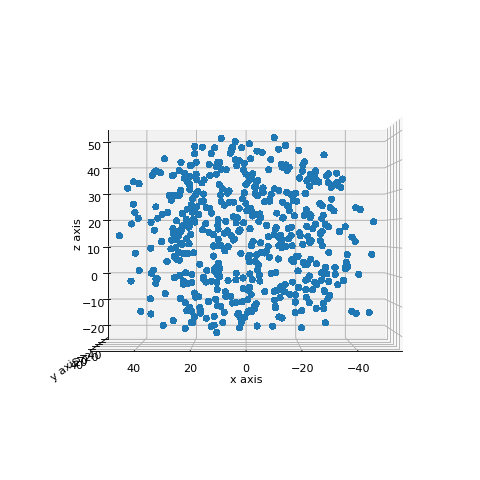

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

X = np.tile(train_datax[500:1000,0],(len(train_datax[:500,0]),1))
Y = np.tile(train_datax[500:1000,1],(len(train_datax[:500,1]),1))
Z = np.tile(train_datax[500:1000,2],(len(train_datax[:500,2]),1))
ax.scatter(X,Y,Z)

ax.view_init(0,90)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

plt.tight_layout()
plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adamax,Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model, load_model, save_model
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [10]:
len(position_data[1])

16

In [45]:
    input_size = 7
    output_size = 6
    node_num = 100
    learning_rate = 0.0005
    epochs = 3000
    batch_size= 300
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 0 ~ 11
    
    #데이터 : 전체 워크스페이스 랜덤하게. 
    
    for i in range(3):
        inputA = Input(shape=input_size, name='Input states')
        A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num,  name='layer5',kernel_initializer = 'he_normal')(inputA)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer6',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer7',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer8',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        outputs = Dense(output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()
        hist = train_model(model,train_datax ,train_datay,x_vld,y_vld,count,'UR3_first.h5')
        train_datax, x_test, train_datay, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
        x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer5 (Dense)               (None, 100)               800       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
layer6 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400 

Epoch 37/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.5236 - mean_absolute_error: 0.8952 - val_loss: 1.5567 - val_mean_absolute_error: 0.8995
Epoch 38/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.5215 - mean_absolute_error: 0.8943 - val_loss: 1.5537 - val_mean_absolute_error: 0.8924
Epoch 39/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.5122 - mean_absolute_error: 0.8888 - val_loss: 1.5454 - val_mean_absolute_error: 0.8885
Epoch 40/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.5055 - mean_absolute_error: 0.8860 - val_loss: 1.5361 - val_mean_absolute_error: 0.8868
Epoch 41/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.4975 - mean_absolute_error: 0.8814 - val_loss: 1.5358 - val_mean_absolute_error: 0.8864
Epoch 42/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.4903 - mean_absolute_error: 0.8777 - val_loss: 1.5434 - val_mean_absolute_error: 0.886

348/348 [==============================] - 2s 6ms/step - loss: 1.3779 - mean_absolute_error: 0.8239 - val_loss: 1.4577 - val_mean_absolute_error: 0.8402
Epoch 87/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.3752 - mean_absolute_error: 0.8217 - val_loss: 1.4476 - val_mean_absolute_error: 0.8396
Epoch 88/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.3706 - mean_absolute_error: 0.8211 - val_loss: 1.4552 - val_mean_absolute_error: 0.8368
Epoch 89/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.3680 - mean_absolute_error: 0.8199 - val_loss: 1.4617 - val_mean_absolute_error: 0.8411
Epoch 90/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.3681 - mean_absolute_error: 0.8206 - val_loss: 1.4445 - val_mean_absolute_error: 0.8391
Epoch 91/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.3667 - mean_absolute_error: 0.8186 - val_loss: 1.4577 - val_mean_absolute_error: 0.8429
Epoch 92/300

Epoch 135/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.2746 - mean_absolute_error: 0.7777 - val_loss: 1.3852 - val_mean_absolute_error: 0.8040
Epoch 136/3000
348/348 [==============================] - 2s 7ms/step - loss: 1.2634 - mean_absolute_error: 0.7748 - val_loss: 1.3772 - val_mean_absolute_error: 0.7995
Epoch 137/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.2585 - mean_absolute_error: 0.7731 - val_loss: 1.3766 - val_mean_absolute_error: 0.7964
Epoch 138/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.2608 - mean_absolute_error: 0.7753 - val_loss: 1.3745 - val_mean_absolute_error: 0.7985
Epoch 139/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.2584 - mean_absolute_error: 0.7724 - val_loss: 1.3634 - val_mean_absolute_error: 0.7909
Epoch 140/3000
348/348 [==============================] - 2s 6ms/step - loss: 1.2542 - mean_absolute_error: 0.7703 - val_loss: 1.3544 - val_mean_absolute_error:

KeyboardInterrupt: 

In [198]:
x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(position_data[1:,:] ,th_data[1:,:])

## 모델 정보
UR3_layer_8.h5 : conf 1~8로 돌린거     그리고 cm단위로 한거  
UR3_layer_8_conf_up.h5 : conf 10배로 돌린거
UR3_layer_10_conf_up.h5 : layer 10개, node 250개로 conf 10배로 돌린거
UR3_layer_10_conf_1000.h5 : layer 10개, node 250개로 conf 1000배로 돌린거

UR3_layer_each_conf_1~8.h5 : layer 10개, node 250개로 conf별로 데이터셋 나누어서 학습 ( 총 모델 8개 ) 


In [46]:
    input_size = len(position_data[1])
    output_size = 6
    node_num = 250
    learning_rate = 0.0005
    epochs = 500
    batch_size= 250
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 0 ~ 11

    #데이터 : 전체 워크스페이스 랜덤하게. 
    for i in range(5):
        #train_x, x_test, train_y, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
        
        ## 데이터 섞으려고 할 경우 아래 코드 
        train_x, x_test, train_y, y_test = train_test_split(train_datax,train_datay, test_size=0.001, shuffle=True) 
        
        x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_x ,train_y)
        
        inputA = Input(shape=input_size, name='Input states')
        A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num,  name='layer5',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer6',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer7',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer8',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer9',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer10',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        outputs = Dense(output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()
        
        model = get_weight_set_weight(model,'UR3_layer_10_conf_up.h5')
        
        hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_10_conf_up.h5')
        
        
        #model = get_weight_set_weight(model,'UR3_layer_8_one_hot.h5')
        
        #hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_8_one_hot.h5')
        

Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 250)               2000      
_________________________________________________________________
leaky_re_lu_698 (LeakyReLU)  (None, 250)               0         
_________________________________________________________________
batch_normalization_698 (Bat (None, 250)               1000      
_________________________________________________________________
layer2 (Dense)               (None, 250)               62750     
_________________________________________________________________
leaky_re_lu_699 (LeakyReLU)  (None, 250)               0         
_________________________________________________________________
batch_normalization_699 (Bat (None, 250)               100

Epoch 23/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1308 - val_loss: 0.0056 - val_mean_absolute_error: 0.0577
Epoch 24/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0295 - mean_absolute_error: 0.1332 - val_loss: 0.0055 - val_mean_absolute_error: 0.0574
Epoch 25/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0304 - mean_absolute_error: 0.1337 - val_loss: 0.0067 - val_mean_absolute_error: 0.0597
Epoch 26/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1325 - val_loss: 0.0057 - val_mean_absolute_error: 0.0581
Epoch 27/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0300 - mean_absolute_error: 0.1329 - val_loss: 0.0056 - val_mean_absolute_error: 0.0577
Epoch 28/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0300 - mean_absolute_error: 0.1342 - val_loss: 0.0057 - val_mean_absolute_error: 0.057

231/231 [==============================] - 3s 13ms/step - loss: 0.0291 - mean_absolute_error: 0.1318 - val_loss: 0.0051 - val_mean_absolute_error: 0.0548
Epoch 73/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0307 - mean_absolute_error: 0.1348 - val_loss: 0.0052 - val_mean_absolute_error: 0.0552
Epoch 74/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0290 - mean_absolute_error: 0.1318 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 75/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0310 - mean_absolute_error: 0.1354 - val_loss: 0.0056 - val_mean_absolute_error: 0.0573
Epoch 76/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0305 - mean_absolute_error: 0.1342 - val_loss: 0.0053 - val_mean_absolute_error: 0.0563
Epoch 77/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0303 - mean_absolute_error: 0.1348 - val_loss: 0.0055 - val_mean_absolute_error: 0.0560
Epoch 78/50

231/231 [==============================] - 3s 13ms/step - loss: 0.0298 - mean_absolute_error: 0.1322 - val_loss: 0.0052 - val_mean_absolute_error: 0.0556
Epoch 122/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1275 - val_loss: 0.0049 - val_mean_absolute_error: 0.0542
Epoch 123/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0291 - mean_absolute_error: 0.1315 - val_loss: 0.0050 - val_mean_absolute_error: 0.0544
Epoch 124/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0294 - mean_absolute_error: 0.1322 - val_loss: 0.0049 - val_mean_absolute_error: 0.0538
Epoch 125/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1325 - val_loss: 0.0051 - val_mean_absolute_error: 0.0549
Epoch 126/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0280 - mean_absolute_error: 0.1299 - val_loss: 0.0049 - val_mean_absolute_error: 0.0537
Epoch 

Epoch 170/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.1332 - val_loss: 0.0050 - val_mean_absolute_error: 0.0546
Epoch 171/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1304 - val_loss: 0.0052 - val_mean_absolute_error: 0.0557
Epoch 172/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0303 - mean_absolute_error: 0.1342 - val_loss: 0.0049 - val_mean_absolute_error: 0.0543
Epoch 173/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1310 - val_loss: 0.0051 - val_mean_absolute_error: 0.0551
Epoch 174/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1310 - val_loss: 0.0051 - val_mean_absolute_error: 0.0551
Epoch 175/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1312 - val_loss: 0.0051 - val_mean_absolute_error:

Epoch 219/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1303 - val_loss: 0.0051 - val_mean_absolute_error: 0.0550
Epoch 220/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0294 - mean_absolute_error: 0.1319 - val_loss: 0.0050 - val_mean_absolute_error: 0.0543
Epoch 221/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0306 - mean_absolute_error: 0.1335 - val_loss: 0.0051 - val_mean_absolute_error: 0.0551
Epoch 222/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0282 - mean_absolute_error: 0.1298 - val_loss: 0.0049 - val_mean_absolute_error: 0.0543
Epoch 223/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.1342 - val_loss: 0.0050 - val_mean_absolute_error: 0.0548
Epoch 224/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1315 - val_loss: 0.0051 - val_mean_absolute_error:

Epoch 268/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1321 - val_loss: 0.0052 - val_mean_absolute_error: 0.0559
Epoch 269/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1309 - val_loss: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 270/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1329 - val_loss: 0.0049 - val_mean_absolute_error: 0.0542
Epoch 271/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1319 - val_loss: 0.0050 - val_mean_absolute_error: 0.0544
Epoch 272/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0304 - mean_absolute_error: 0.1331 - val_loss: 0.0050 - val_mean_absolute_error: 0.0546
Epoch 273/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.1320 - val_loss: 0.0050 - val_mean_absolute_error:

Epoch 317/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0291 - mean_absolute_error: 0.1332 - val_loss: 0.0050 - val_mean_absolute_error: 0.0544
Epoch 318/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1305 - val_loss: 0.0049 - val_mean_absolute_error: 0.0544
Epoch 319/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1323 - val_loss: 0.0050 - val_mean_absolute_error: 0.0546
Epoch 320/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0278 - mean_absolute_error: 0.1296 - val_loss: 0.0048 - val_mean_absolute_error: 0.0532
Epoch 321/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1318 - val_loss: 0.0048 - val_mean_absolute_error: 0.0536
Epoch 322/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0291 - mean_absolute_error: 0.1303 - val_loss: 0.0049 - val_mean_absolute_error:

Epoch 366/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1318 - val_loss: 0.0049 - val_mean_absolute_error: 0.0542
Epoch 367/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1309 - val_loss: 0.0051 - val_mean_absolute_error: 0.0553
Epoch 368/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1305 - val_loss: 0.0052 - val_mean_absolute_error: 0.0556
Epoch 369/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0303 - mean_absolute_error: 0.1330 - val_loss: 0.0050 - val_mean_absolute_error: 0.0543
Epoch 370/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1303 - val_loss: 0.0047 - val_mean_absolute_error: 0.0528
Epoch 371/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0316 - mean_absolute_error: 0.1306 - val_loss: 0.0049 - val_mean_absolute_error:

Epoch 415/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1325 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 416/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1299 - val_loss: 0.0050 - val_mean_absolute_error: 0.0551
Epoch 417/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1331 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 418/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1276 - val_loss: 0.0051 - val_mean_absolute_error: 0.0550
Epoch 419/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.1338 - val_loss: 0.0049 - val_mean_absolute_error: 0.0539
Epoch 420/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0263 - mean_absolute_error: 0.1255 - val_loss: 0.0048 - val_mean_absolute_error:

Epoch 464/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1316 - val_loss: 0.0049 - val_mean_absolute_error: 0.0538
Epoch 465/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1304 - val_loss: 0.0050 - val_mean_absolute_error: 0.0544
Epoch 466/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1293 - val_loss: 0.0051 - val_mean_absolute_error: 0.0551
Epoch 467/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0304 - mean_absolute_error: 0.1335 - val_loss: 0.0050 - val_mean_absolute_error: 0.0543
Epoch 468/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1306 - val_loss: 0.0053 - val_mean_absolute_error: 0.0563
Epoch 469/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0296 - mean_absolute_error: 0.1321 - val_loss: 0.0048 - val_mean_absolute_error:

Epoch 1/500
231/231 [==============================] - 5s 14ms/step - loss: 0.0345 - mean_absolute_error: 0.1393 - val_loss: 0.0061 - val_mean_absolute_error: 0.0606
Epoch 2/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0307 - mean_absolute_error: 0.1336 - val_loss: 0.0051 - val_mean_absolute_error: 0.0552
Epoch 3/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0317 - mean_absolute_error: 0.1357 - val_loss: 0.0053 - val_mean_absolute_error: 0.0566
Epoch 4/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0298 - mean_absolute_error: 0.1314 - val_loss: 0.0049 - val_mean_absolute_error: 0.0545
Epoch 5/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0291 - mean_absolute_error: 0.1306 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 6/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0285 - mean_absolute_error: 0.1315 - val_loss: 0.0048 - val_mean_absolute_error: 0.0537
Epoc

231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1297 - val_loss: 0.0047 - val_mean_absolute_error: 0.0533
Epoch 100/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1313 - val_loss: 0.0046 - val_mean_absolute_error: 0.0529
Epoch 101/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1322 - val_loss: 0.0045 - val_mean_absolute_error: 0.0520
Epoch 102/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1311 - val_loss: 0.0044 - val_mean_absolute_error: 0.0511
Epoch 103/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1300 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 104/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1338 - val_loss: 0.0053 - val_mean_absolute_error: 0.0532
Epoch 

Epoch 148/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1297 - val_loss: 0.0047 - val_mean_absolute_error: 0.0530
Epoch 149/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0306 - mean_absolute_error: 0.1347 - val_loss: 0.0048 - val_mean_absolute_error: 0.0540
Epoch 150/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1288 - val_loss: 0.0049 - val_mean_absolute_error: 0.0535
Epoch 151/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0314 - mean_absolute_error: 0.1366 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 152/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1291 - val_loss: 0.0051 - val_mean_absolute_error: 0.0551
Epoch 153/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0310 - mean_absolute_error: 0.1347 - val_loss: 0.0046 - val_mean_absolute_error:

Epoch 197/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0270 - mean_absolute_error: 0.1273 - val_loss: 0.0049 - val_mean_absolute_error: 0.0542
Epoch 198/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0280 - mean_absolute_error: 0.1304 - val_loss: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 199/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1324 - val_loss: 0.0050 - val_mean_absolute_error: 0.0548
Epoch 200/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1314 - val_loss: 0.0047 - val_mean_absolute_error: 0.0529
Epoch 201/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1301 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 202/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1318 - val_loss: 0.0047 - val_mean_absolute_error:

Epoch 246/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0297 - mean_absolute_error: 0.1332 - val_loss: 0.0046 - val_mean_absolute_error: 0.0526
Epoch 247/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1288 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 248/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1303 - val_loss: 0.0046 - val_mean_absolute_error: 0.0529
Epoch 249/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1322 - val_loss: 0.0048 - val_mean_absolute_error: 0.0536
Epoch 250/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1304 - val_loss: 0.0046 - val_mean_absolute_error: 0.0527
Epoch 251/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1345 - val_loss: 0.0047 - val_mean_absolute_error:

Epoch 295/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1299 - val_loss: 0.0044 - val_mean_absolute_error: 0.0518
Epoch 296/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0278 - mean_absolute_error: 0.1287 - val_loss: 0.0047 - val_mean_absolute_error: 0.0529
Epoch 297/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1275 - val_loss: 0.0047 - val_mean_absolute_error: 0.0530
Epoch 298/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0283 - mean_absolute_error: 0.1309 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 299/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1326 - val_loss: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 300/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1288 - val_loss: 0.0049 - val_mean_absolute_error:

Epoch 344/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1303 - val_loss: 0.0045 - val_mean_absolute_error: 0.0520
Epoch 345/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1281 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 346/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1277 - val_loss: 0.0048 - val_mean_absolute_error: 0.0532
Epoch 347/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1316 - val_loss: 0.0047 - val_mean_absolute_error: 0.0530
Epoch 348/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0291 - mean_absolute_error: 0.1305 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 349/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0269 - mean_absolute_error: 0.1276 - val_loss: 0.0046 - val_mean_absolute_error:

Epoch 393/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1278 - val_loss: 0.0043 - val_mean_absolute_error: 0.0511
Epoch 394/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0269 - mean_absolute_error: 0.1283 - val_loss: 0.0044 - val_mean_absolute_error: 0.0516
Epoch 395/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0288 - mean_absolute_error: 0.1318 - val_loss: 0.0047 - val_mean_absolute_error: 0.0530
Epoch 396/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1282 - val_loss: 0.0045 - val_mean_absolute_error: 0.0516
Epoch 397/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1340 - val_loss: 0.0047 - val_mean_absolute_error: 0.0532
Epoch 398/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0317 - mean_absolute_error: 0.1376 - val_loss: 0.0050 - val_mean_absolute_error:

Epoch 442/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1293 - val_loss: 0.0046 - val_mean_absolute_error: 0.0526
Epoch 443/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1299 - val_loss: 0.0048 - val_mean_absolute_error: 0.0538
Epoch 444/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1321 - val_loss: 0.0049 - val_mean_absolute_error: 0.0542
Epoch 445/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1307 - val_loss: 0.0048 - val_mean_absolute_error: 0.0536
Epoch 446/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1303 - val_loss: 0.0047 - val_mean_absolute_error: 0.0528
Epoch 447/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0296 - mean_absolute_error: 0.1332 - val_loss: 0.0051 - val_mean_absolute_error:

Epoch 491/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0270 - mean_absolute_error: 0.1283 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 492/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0280 - mean_absolute_error: 0.1298 - val_loss: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 493/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1320 - val_loss: 0.0042 - val_mean_absolute_error: 0.0501
Epoch 494/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0288 - mean_absolute_error: 0.1328 - val_loss: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 495/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1305 - val_loss: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 496/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1281 - val_loss: 0.0041 - val_mean_absolute_error:

231/231 [==============================] - 3s 12ms/step - loss: 0.0278 - mean_absolute_error: 0.1292 - val_loss: 0.0046 - val_mean_absolute_error: 0.0527
Epoch 62/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1322 - val_loss: 0.0048 - val_mean_absolute_error: 0.0539
Epoch 63/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1320 - val_loss: 0.0049 - val_mean_absolute_error: 0.0537
Epoch 64/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1285 - val_loss: 0.0045 - val_mean_absolute_error: 0.0520
Epoch 65/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1304 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 66/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1306 - val_loss: 0.0045 - val_mean_absolute_error: 0.0522
Epoch 67/50

231/231 [==============================] - 3s 12ms/step - loss: 0.0267 - mean_absolute_error: 0.1272 - val_loss: 0.0044 - val_mean_absolute_error: 0.0517
Epoch 111/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1301 - val_loss: 0.0045 - val_mean_absolute_error: 0.0518
Epoch 112/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0294 - mean_absolute_error: 0.1326 - val_loss: 0.0044 - val_mean_absolute_error: 0.0513
Epoch 113/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1292 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 114/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0294 - mean_absolute_error: 0.1316 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 115/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1315 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 

Epoch 159/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1300 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 160/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1314 - val_loss: 0.0044 - val_mean_absolute_error: 0.0513
Epoch 161/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1304 - val_loss: 0.0046 - val_mean_absolute_error: 0.0529
Epoch 162/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1290 - val_loss: 0.0048 - val_mean_absolute_error: 0.0534
Epoch 163/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0300 - mean_absolute_error: 0.1328 - val_loss: 0.0048 - val_mean_absolute_error: 0.0538
Epoch 164/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1302 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 208/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0312 - mean_absolute_error: 0.1368 - val_loss: 0.0044 - val_mean_absolute_error: 0.0510
Epoch 209/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1322 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 210/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1304 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 211/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1298 - val_loss: 0.0044 - val_mean_absolute_error: 0.0517
Epoch 212/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1312 - val_loss: 0.0045 - val_mean_absolute_error: 0.0516
Epoch 213/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1268 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 257/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1282 - val_loss: 0.0043 - val_mean_absolute_error: 0.0507
Epoch 258/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1298 - val_loss: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 259/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1296 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519
Epoch 260/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1272 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 261/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0270 - mean_absolute_error: 0.1274 - val_loss: 0.0042 - val_mean_absolute_error: 0.0500
Epoch 262/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1282 - val_loss: 0.0045 - val_mean_absolute_error:

Epoch 306/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1276 - val_loss: 0.0046 - val_mean_absolute_error: 0.0523
Epoch 307/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0306 - mean_absolute_error: 0.1332 - val_loss: 0.0045 - val_mean_absolute_error: 0.0517
Epoch 308/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1269 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 309/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1309 - val_loss: 0.0045 - val_mean_absolute_error: 0.0521
Epoch 310/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0297 - mean_absolute_error: 0.1330 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 311/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1321 - val_loss: 0.0045 - val_mean_absolute_error:

Epoch 355/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0322 - mean_absolute_error: 0.1323 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 356/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0291 - mean_absolute_error: 0.1319 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 357/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1275 - val_loss: 0.0042 - val_mean_absolute_error: 0.0500
Epoch 358/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1332 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 359/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1300 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 360/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1289 - val_loss: 0.0041 - val_mean_absolute_error:

Epoch 404/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0277 - mean_absolute_error: 0.1285 - val_loss: 0.0044 - val_mean_absolute_error: 0.0509
Epoch 405/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1322 - val_loss: 0.0045 - val_mean_absolute_error: 0.0518
Epoch 406/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0285 - mean_absolute_error: 0.1304 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 407/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1272 - val_loss: 0.0047 - val_mean_absolute_error: 0.0529
Epoch 408/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0265 - mean_absolute_error: 0.1257 - val_loss: 0.0050 - val_mean_absolute_error: 0.0522
Epoch 409/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0267 - mean_absolute_error: 0.1267 - val_loss: 0.0045 - val_mean_absolute_error:

Epoch 453/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0297 - mean_absolute_error: 0.1314 - val_loss: 0.0047 - val_mean_absolute_error: 0.0531
Epoch 454/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1306 - val_loss: 0.0045 - val_mean_absolute_error: 0.0520
Epoch 455/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0280 - mean_absolute_error: 0.1294 - val_loss: 0.0047 - val_mean_absolute_error: 0.0528
Epoch 456/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0294 - mean_absolute_error: 0.1324 - val_loss: 0.0044 - val_mean_absolute_error: 0.0511
Epoch 457/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0277 - mean_absolute_error: 0.1299 - val_loss: 0.0045 - val_mean_absolute_error: 0.0518
Epoch 458/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1323 - val_loss: 0.0045 - val_mean_absolute_error:

Epoch 1/500
231/231 [==============================] - 5s 14ms/step - loss: 0.0335 - mean_absolute_error: 0.1356 - val_loss: 0.0054 - val_mean_absolute_error: 0.0565
Epoch 2/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0293 - mean_absolute_error: 0.1324 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 3/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1263 - val_loss: 0.0046 - val_mean_absolute_error: 0.0523
Epoch 4/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0283 - mean_absolute_error: 0.1299 - val_loss: 0.0044 - val_mean_absolute_error: 0.0510
Epoch 5/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1318 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519
Epoch 6/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1291 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoc

231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1287 - val_loss: 0.0043 - val_mean_absolute_error: 0.0507
Epoch 100/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0285 - mean_absolute_error: 0.1314 - val_loss: 0.0042 - val_mean_absolute_error: 0.0506
Epoch 101/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1317 - val_loss: 0.0043 - val_mean_absolute_error: 0.0507
Epoch 102/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1268 - val_loss: 0.0043 - val_mean_absolute_error: 0.0507
Epoch 103/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1299 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 104/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1283 - val_loss: 0.0053 - val_mean_absolute_error: 0.0533
Epoch 

Epoch 148/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1297 - val_loss: 0.0048 - val_mean_absolute_error: 0.0539
Epoch 149/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1305 - val_loss: 0.0051 - val_mean_absolute_error: 0.0522
Epoch 150/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1316 - val_loss: 0.0045 - val_mean_absolute_error: 0.0523
Epoch 151/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1280 - val_loss: 0.0046 - val_mean_absolute_error: 0.0523
Epoch 152/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1316 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 153/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1290 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 197/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0263 - mean_absolute_error: 0.1252 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 198/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1273 - val_loss: 0.0045 - val_mean_absolute_error: 0.0515
Epoch 199/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1294 - val_loss: 0.0044 - val_mean_absolute_error: 0.0513
Epoch 200/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1283 - val_loss: 0.0044 - val_mean_absolute_error: 0.0517
Epoch 201/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1310 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 202/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1299 - val_loss: 0.0041 - val_mean_absolute_error:

Epoch 246/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1299 - val_loss: 0.0044 - val_mean_absolute_error: 0.0518
Epoch 247/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0265 - mean_absolute_error: 0.1255 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 248/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1315 - val_loss: 0.0044 - val_mean_absolute_error: 0.0518
Epoch 249/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1326 - val_loss: 0.0045 - val_mean_absolute_error: 0.0520
Epoch 250/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0275 - mean_absolute_error: 0.1293 - val_loss: 0.0045 - val_mean_absolute_error: 0.0518
Epoch 251/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1284 - val_loss: 0.0043 - val_mean_absolute_error:

Epoch 295/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0278 - mean_absolute_error: 0.1286 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 296/500
231/231 [==============================] - 3s 13ms/step - loss: 0.0275 - mean_absolute_error: 0.1279 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 297/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0297 - mean_absolute_error: 0.1336 - val_loss: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 298/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0267 - mean_absolute_error: 0.1264 - val_loss: 0.0044 - val_mean_absolute_error: 0.0510
Epoch 299/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1292 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 300/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0260 - mean_absolute_error: 0.1263 - val_loss: 0.0046 - val_mean_absolute_error:

Epoch 344/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1329 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 345/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1285 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 346/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1302 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 347/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0268 - mean_absolute_error: 0.1276 - val_loss: 0.0041 - val_mean_absolute_error: 0.0495
Epoch 348/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1281 - val_loss: 0.0039 - val_mean_absolute_error: 0.0485
Epoch 349/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1301 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 393/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1277 - val_loss: 0.0040 - val_mean_absolute_error: 0.0486
Epoch 394/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0269 - mean_absolute_error: 0.1271 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 395/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0264 - mean_absolute_error: 0.1262 - val_loss: 0.0040 - val_mean_absolute_error: 0.0493
Epoch 396/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1282 - val_loss: 0.0043 - val_mean_absolute_error: 0.0505
Epoch 397/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0270 - mean_absolute_error: 0.1259 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 398/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0301 - mean_absolute_error: 0.1344 - val_loss: 0.0043 - val_mean_absolute_error:

Epoch 442/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0290 - mean_absolute_error: 0.1316 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 443/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1281 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 444/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.1329 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 445/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0262 - mean_absolute_error: 0.1258 - val_loss: 0.0043 - val_mean_absolute_error: 0.0507
Epoch 446/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1287 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 447/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1258 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 491/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1278 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 492/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0277 - mean_absolute_error: 0.1286 - val_loss: 0.0044 - val_mean_absolute_error: 0.0513
Epoch 493/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1310 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 494/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1266 - val_loss: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 495/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1273 - val_loss: 0.0042 - val_mean_absolute_error: 0.0507
Epoch 496/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0289 - mean_absolute_error: 0.1308 - val_loss: 0.0042 - val_mean_absolute_error:

231/231 [==============================] - 3s 12ms/step - loss: 0.0261 - mean_absolute_error: 0.1254 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 62/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0269 - mean_absolute_error: 0.1268 - val_loss: 0.0040 - val_mean_absolute_error: 0.0490
Epoch 63/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1280 - val_loss: 0.0042 - val_mean_absolute_error: 0.0502
Epoch 64/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1296 - val_loss: 0.0048 - val_mean_absolute_error: 0.0532
Epoch 65/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0281 - mean_absolute_error: 0.1290 - val_loss: 0.0040 - val_mean_absolute_error: 0.0489
Epoch 66/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1278 - val_loss: 0.0039 - val_mean_absolute_error: 0.0485
Epoch 67/50

231/231 [==============================] - 3s 12ms/step - loss: 0.0280 - mean_absolute_error: 0.1278 - val_loss: 0.0042 - val_mean_absolute_error: 0.0498
Epoch 111/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0277 - mean_absolute_error: 0.1272 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 112/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1271 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 113/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1292 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 114/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0285 - mean_absolute_error: 0.1308 - val_loss: 0.0044 - val_mean_absolute_error: 0.0513
Epoch 115/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0278 - mean_absolute_error: 0.1274 - val_loss: 0.0046 - val_mean_absolute_error: 0.0525
Epoch 

Epoch 159/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1283 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 160/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1286 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 161/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1280 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 162/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1292 - val_loss: 0.0050 - val_mean_absolute_error: 0.0529
Epoch 163/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1296 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 164/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1281 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 208/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1312 - val_loss: 0.0045 - val_mean_absolute_error: 0.0521
Epoch 209/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.1328 - val_loss: 0.0041 - val_mean_absolute_error: 0.0500
Epoch 210/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1317 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 211/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0275 - mean_absolute_error: 0.1277 - val_loss: 0.0042 - val_mean_absolute_error: 0.0500
Epoch 212/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1280 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 213/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1278 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 257/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0270 - mean_absolute_error: 0.1283 - val_loss: 0.0043 - val_mean_absolute_error: 0.0511
Epoch 258/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1293 - val_loss: 0.0043 - val_mean_absolute_error: 0.0512
Epoch 259/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1270 - val_loss: 0.0041 - val_mean_absolute_error: 0.0499
Epoch 260/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1269 - val_loss: 0.0045 - val_mean_absolute_error: 0.0520
Epoch 261/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0285 - mean_absolute_error: 0.1310 - val_loss: 0.0043 - val_mean_absolute_error: 0.0511
Epoch 262/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0273 - mean_absolute_error: 0.1266 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 306/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0294 - mean_absolute_error: 0.1316 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 307/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0277 - mean_absolute_error: 0.1306 - val_loss: 0.0042 - val_mean_absolute_error: 0.0502
Epoch 308/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1277 - val_loss: 0.0040 - val_mean_absolute_error: 0.0493
Epoch 309/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1292 - val_loss: 0.0040 - val_mean_absolute_error: 0.0491
Epoch 310/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1318 - val_loss: 0.0041 - val_mean_absolute_error: 0.0501
Epoch 311/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0262 - mean_absolute_error: 0.1253 - val_loss: 0.0040 - val_mean_absolute_error:

Epoch 355/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0283 - mean_absolute_error: 0.1296 - val_loss: 0.0045 - val_mean_absolute_error: 0.0517
Epoch 356/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1292 - val_loss: 0.0040 - val_mean_absolute_error: 0.0488
Epoch 357/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0278 - mean_absolute_error: 0.1298 - val_loss: 0.0041 - val_mean_absolute_error: 0.0496
Epoch 358/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0265 - mean_absolute_error: 0.1266 - val_loss: 0.0042 - val_mean_absolute_error: 0.0502
Epoch 359/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0300 - mean_absolute_error: 0.1326 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 360/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0267 - mean_absolute_error: 0.1278 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 404/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0268 - mean_absolute_error: 0.1263 - val_loss: 0.0042 - val_mean_absolute_error: 0.0500
Epoch 405/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1304 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 406/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1280 - val_loss: 0.0039 - val_mean_absolute_error: 0.0485
Epoch 407/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1288 - val_loss: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 408/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0277 - mean_absolute_error: 0.1299 - val_loss: 0.0038 - val_mean_absolute_error: 0.0478
Epoch 409/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0276 - mean_absolute_error: 0.1291 - val_loss: 0.0040 - val_mean_absolute_error:

Epoch 453/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0253 - mean_absolute_error: 0.1234 - val_loss: 0.0042 - val_mean_absolute_error: 0.0502
Epoch 454/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1283 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 455/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1265 - val_loss: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 456/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0270 - mean_absolute_error: 0.1273 - val_loss: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 457/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1302 - val_loss: 0.0043 - val_mean_absolute_error: 0.0508
Epoch 458/500
231/231 [==============================] - 3s 12ms/step - loss: 0.0287 - mean_absolute_error: 0.1300 - val_loss: 0.0040 - val_mean_absolute_error:

In [29]:
    input_size = len(position_data[1])
    output_size = 6
    node_num = 250
    learning_rate = 0.0005
    epochs = 500
    batch_size= 220
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 1~8 * 1000

    #데이터 : 전체 워크스페이스 랜덤하게. 
    for i in range(10):
        #train_x, x_test, train_y, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
        
        ## 데이터 섞으려고 할 경우 아래 코드 
        train_x, x_test, train_y, y_test = train_test_split(train_datax,train_datay, test_size=0.001, shuffle=True) 
        
        x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_x ,train_y)
        
        inputA = Input(shape=input_size, name='Input states')
        A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num,  name='layer5',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer6',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer7',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer8',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer9',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer10',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        outputs = Dense(output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()
        
        model = get_weight_set_weight(model,'UR3_layer_10_conf_1000.h5')
        
        hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_10_conf_1000.h5')
        
        
        #model = get_weight_set_weight(model,'UR3_layer_8_one_hot.h5')
        
        #hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_8_one_hot.h5')
        

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 250)               2000      
_________________________________________________________________
leaky_re_lu_360 (LeakyReLU)  (None, 250)               0         
_________________________________________________________________
batch_normalization_360 (Bat (None, 250)               1000      
_________________________________________________________________
layer2 (Dense)               (None, 250)               62750     
_________________________________________________________________
leaky_re_lu_361 (LeakyReLU)  (None, 250)               0         
_________________________________________________________________
batch_normalization_361 (Bat (None, 250)               100

Epoch 23/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0845 - mean_absolute_error: 0.2094 - val_loss: 0.0245 - val_mean_absolute_error: 0.1187
Epoch 24/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0860 - mean_absolute_error: 0.2110 - val_loss: 0.0237 - val_mean_absolute_error: 0.1170
Epoch 25/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0822 - mean_absolute_error: 0.2087 - val_loss: 0.0235 - val_mean_absolute_error: 0.1166
Epoch 26/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0820 - mean_absolute_error: 0.2069 - val_loss: 0.0233 - val_mean_absolute_error: 0.1164
Epoch 27/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0873 - mean_absolute_error: 0.2133 - val_loss: 0.0248 - val_mean_absolute_error: 0.1200
Epoch 28/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0833 - mean_absolute_error: 0.2087 - val_loss: 0.0235 - val_mean_absolute_error: 0.117

208/208 [==============================] - 3s 12ms/step - loss: 0.0804 - mean_absolute_error: 0.2087 - val_loss: 0.0244 - val_mean_absolute_error: 0.1193
Epoch 73/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0796 - mean_absolute_error: 0.2066 - val_loss: 0.0255 - val_mean_absolute_error: 0.1209
Epoch 74/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0805 - mean_absolute_error: 0.2073 - val_loss: 0.0244 - val_mean_absolute_error: 0.1189
Epoch 75/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0812 - mean_absolute_error: 0.2070 - val_loss: 0.0249 - val_mean_absolute_error: 0.1204
Epoch 76/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0836 - mean_absolute_error: 0.2102 - val_loss: 0.0240 - val_mean_absolute_error: 0.1173
Epoch 77/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0799 - mean_absolute_error: 0.2068 - val_loss: 0.0280 - val_mean_absolute_error: 0.1233
Epoch 78/50

208/208 [==============================] - 3s 12ms/step - loss: 0.0851 - mean_absolute_error: 0.2105 - val_loss: 0.0222 - val_mean_absolute_error: 0.1136
Epoch 122/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0829 - mean_absolute_error: 0.2106 - val_loss: 0.0235 - val_mean_absolute_error: 0.1167
Epoch 123/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0852 - mean_absolute_error: 0.2115 - val_loss: 0.0233 - val_mean_absolute_error: 0.1161
Epoch 124/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0837 - mean_absolute_error: 0.2099 - val_loss: 0.0227 - val_mean_absolute_error: 0.1148
Epoch 125/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0831 - mean_absolute_error: 0.2086 - val_loss: 0.0239 - val_mean_absolute_error: 0.1172
Epoch 126/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0823 - mean_absolute_error: 0.2090 - val_loss: 0.0232 - val_mean_absolute_error: 0.1157
Epoch 

Epoch 170/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0847 - mean_absolute_error: 0.2109 - val_loss: 0.0248 - val_mean_absolute_error: 0.1194
Epoch 171/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0834 - mean_absolute_error: 0.2077 - val_loss: 0.0243 - val_mean_absolute_error: 0.1187
Epoch 172/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0795 - mean_absolute_error: 0.2064 - val_loss: 0.0235 - val_mean_absolute_error: 0.1167
Epoch 173/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0820 - mean_absolute_error: 0.2066 - val_loss: 0.0235 - val_mean_absolute_error: 0.1168
Epoch 174/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0804 - mean_absolute_error: 0.2060 - val_loss: 0.0224 - val_mean_absolute_error: 0.1142
Epoch 175/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0808 - mean_absolute_error: 0.2065 - val_loss: 0.0254 - val_mean_absolute_error:

Epoch 219/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0842 - mean_absolute_error: 0.2119 - val_loss: 0.0228 - val_mean_absolute_error: 0.1150
Epoch 220/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0804 - mean_absolute_error: 0.2079 - val_loss: 0.0236 - val_mean_absolute_error: 0.1167
Epoch 221/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0818 - mean_absolute_error: 0.2075 - val_loss: 0.0237 - val_mean_absolute_error: 0.1176
Epoch 222/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0818 - mean_absolute_error: 0.2071 - val_loss: 0.0230 - val_mean_absolute_error: 0.1151
Epoch 223/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0863 - mean_absolute_error: 0.2112 - val_loss: 0.0237 - val_mean_absolute_error: 0.1172
Epoch 224/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0826 - mean_absolute_error: 0.2087 - val_loss: 0.0228 - val_mean_absolute_error:

Epoch 268/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0823 - mean_absolute_error: 0.2087 - val_loss: 0.0231 - val_mean_absolute_error: 0.1157
Epoch 269/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0827 - mean_absolute_error: 0.2088 - val_loss: 0.0270 - val_mean_absolute_error: 0.1231
Epoch 270/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0836 - mean_absolute_error: 0.2086 - val_loss: 0.0239 - val_mean_absolute_error: 0.1178
Epoch 271/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0825 - mean_absolute_error: 0.2098 - val_loss: 0.0220 - val_mean_absolute_error: 0.1130
Epoch 272/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0864 - mean_absolute_error: 0.2098 - val_loss: 0.0228 - val_mean_absolute_error: 0.1155
Epoch 273/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0876 - mean_absolute_error: 0.2117 - val_loss: 0.0223 - val_mean_absolute_error:

Epoch 317/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0929 - mean_absolute_error: 0.2155 - val_loss: 0.0234 - val_mean_absolute_error: 0.1164
Epoch 318/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0783 - mean_absolute_error: 0.2051 - val_loss: 0.0250 - val_mean_absolute_error: 0.1191
Epoch 319/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0787 - mean_absolute_error: 0.2046 - val_loss: 0.0254 - val_mean_absolute_error: 0.1207
Epoch 320/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0814 - mean_absolute_error: 0.2060 - val_loss: 0.0233 - val_mean_absolute_error: 0.1166
Epoch 321/500
208/208 [==============================] - 3s 12ms/step - loss: 0.1042 - mean_absolute_error: 0.2150 - val_loss: 0.0245 - val_mean_absolute_error: 0.1185
Epoch 322/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.2034 - val_loss: 0.0221 - val_mean_absolute_error:

Epoch 366/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0776 - mean_absolute_error: 0.2046 - val_loss: 0.0224 - val_mean_absolute_error: 0.1144
Epoch 367/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0826 - mean_absolute_error: 0.2085 - val_loss: 0.0271 - val_mean_absolute_error: 0.1240
Epoch 368/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0893 - mean_absolute_error: 0.2129 - val_loss: 0.0217 - val_mean_absolute_error: 0.1123
Epoch 369/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0829 - mean_absolute_error: 0.2092 - val_loss: 0.0227 - val_mean_absolute_error: 0.1146
Epoch 370/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0806 - mean_absolute_error: 0.2082 - val_loss: 0.0218 - val_mean_absolute_error: 0.1129
Epoch 371/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0809 - mean_absolute_error: 0.2069 - val_loss: 0.0232 - val_mean_absolute_error:

Epoch 415/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0847 - mean_absolute_error: 0.2123 - val_loss: 0.0210 - val_mean_absolute_error: 0.1106
Epoch 416/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0763 - mean_absolute_error: 0.2032 - val_loss: 0.0218 - val_mean_absolute_error: 0.1129
Epoch 417/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0815 - mean_absolute_error: 0.2051 - val_loss: 0.0220 - val_mean_absolute_error: 0.1140
Epoch 418/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0805 - mean_absolute_error: 0.2072 - val_loss: 0.0203 - val_mean_absolute_error: 0.1092
Epoch 419/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0813 - mean_absolute_error: 0.2064 - val_loss: 0.0221 - val_mean_absolute_error: 0.1135
Epoch 420/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0816 - mean_absolute_error: 0.2053 - val_loss: 0.0230 - val_mean_absolute_error:

Epoch 464/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0773 - mean_absolute_error: 0.2028 - val_loss: 0.0226 - val_mean_absolute_error: 0.1144
Epoch 465/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0832 - mean_absolute_error: 0.2103 - val_loss: 0.0216 - val_mean_absolute_error: 0.1123
Epoch 466/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0817 - mean_absolute_error: 0.2060 - val_loss: 0.0250 - val_mean_absolute_error: 0.1206
Epoch 467/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0810 - mean_absolute_error: 0.2072 - val_loss: 0.0239 - val_mean_absolute_error: 0.1175
Epoch 468/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0795 - mean_absolute_error: 0.2056 - val_loss: 0.0231 - val_mean_absolute_error: 0.1151
Epoch 469/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0863 - mean_absolute_error: 0.2090 - val_loss: 0.0215 - val_mean_absolute_error:

Epoch 1/500
208/208 [==============================] - 5s 14ms/step - loss: 0.1029 - mean_absolute_error: 0.2237 - val_loss: 0.0231 - val_mean_absolute_error: 0.1153
Epoch 2/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0829 - mean_absolute_error: 0.2087 - val_loss: 0.0260 - val_mean_absolute_error: 0.1209
Epoch 3/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0830 - mean_absolute_error: 0.2083 - val_loss: 0.0221 - val_mean_absolute_error: 0.1130
Epoch 4/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0816 - mean_absolute_error: 0.2080 - val_loss: 0.0239 - val_mean_absolute_error: 0.1163
Epoch 5/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0820 - mean_absolute_error: 0.2075 - val_loss: 0.0245 - val_mean_absolute_error: 0.1177
Epoch 6/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0820 - mean_absolute_error: 0.2078 - val_loss: 0.0223 - val_mean_absolute_error: 0.1135
Epoc

208/208 [==============================] - 3s 12ms/step - loss: 0.0826 - mean_absolute_error: 0.2071 - val_loss: 0.0231 - val_mean_absolute_error: 0.1149
Epoch 100/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0840 - mean_absolute_error: 0.2094 - val_loss: 0.0213 - val_mean_absolute_error: 0.1106
Epoch 101/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0857 - mean_absolute_error: 0.2113 - val_loss: 0.0260 - val_mean_absolute_error: 0.1218
Epoch 102/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0811 - mean_absolute_error: 0.2069 - val_loss: 0.0213 - val_mean_absolute_error: 0.1112
Epoch 103/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0811 - mean_absolute_error: 0.2065 - val_loss: 0.0251 - val_mean_absolute_error: 0.1185
Epoch 104/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0804 - mean_absolute_error: 0.2059 - val_loss: 0.0228 - val_mean_absolute_error: 0.1135
Epoch 

Epoch 148/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0817 - mean_absolute_error: 0.2085 - val_loss: 0.0230 - val_mean_absolute_error: 0.1149
Epoch 149/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0831 - mean_absolute_error: 0.2082 - val_loss: 0.0222 - val_mean_absolute_error: 0.1129
Epoch 150/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0827 - mean_absolute_error: 0.2082 - val_loss: 0.0226 - val_mean_absolute_error: 0.1142
Epoch 151/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0810 - mean_absolute_error: 0.2046 - val_loss: 0.0272 - val_mean_absolute_error: 0.1242
Epoch 152/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0782 - mean_absolute_error: 0.2039 - val_loss: 0.0216 - val_mean_absolute_error: 0.1117
Epoch 153/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0777 - mean_absolute_error: 0.2039 - val_loss: 0.0232 - val_mean_absolute_error:

Epoch 197/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0805 - mean_absolute_error: 0.2054 - val_loss: 0.0231 - val_mean_absolute_error: 0.1155
Epoch 198/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0813 - mean_absolute_error: 0.2068 - val_loss: 0.0230 - val_mean_absolute_error: 0.1154
Epoch 199/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0799 - mean_absolute_error: 0.2059 - val_loss: 0.0256 - val_mean_absolute_error: 0.1211
Epoch 200/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0812 - mean_absolute_error: 0.2053 - val_loss: 0.0217 - val_mean_absolute_error: 0.1123
Epoch 201/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0803 - mean_absolute_error: 0.2066 - val_loss: 0.0258 - val_mean_absolute_error: 0.1207
Epoch 202/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0836 - mean_absolute_error: 0.2092 - val_loss: 0.0238 - val_mean_absolute_error:

Epoch 246/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0791 - mean_absolute_error: 0.2046 - val_loss: 0.0219 - val_mean_absolute_error: 0.1123
Epoch 247/500
208/208 [==============================] - 3s 13ms/step - loss: 0.0799 - mean_absolute_error: 0.2051 - val_loss: 0.0240 - val_mean_absolute_error: 0.1168
Epoch 248/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0795 - mean_absolute_error: 0.2051 - val_loss: 0.0216 - val_mean_absolute_error: 0.1118
Epoch 249/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0779 - mean_absolute_error: 0.2040 - val_loss: 0.0230 - val_mean_absolute_error: 0.1149
Epoch 250/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0818 - mean_absolute_error: 0.2049 - val_loss: 0.0223 - val_mean_absolute_error: 0.1135
Epoch 251/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2040 - val_loss: 0.0234 - val_mean_absolute_error:

Epoch 295/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.1992 - val_loss: 0.0259 - val_mean_absolute_error: 0.1207
Epoch 296/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0818 - mean_absolute_error: 0.2069 - val_loss: 0.0227 - val_mean_absolute_error: 0.1140
Epoch 297/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0803 - mean_absolute_error: 0.2049 - val_loss: 0.0217 - val_mean_absolute_error: 0.1119
Epoch 298/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0774 - mean_absolute_error: 0.2020 - val_loss: 0.0211 - val_mean_absolute_error: 0.1098
Epoch 299/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0822 - mean_absolute_error: 0.2060 - val_loss: 0.0211 - val_mean_absolute_error: 0.1105
Epoch 300/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0814 - mean_absolute_error: 0.2055 - val_loss: 0.0221 - val_mean_absolute_error:

Epoch 344/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0830 - mean_absolute_error: 0.2085 - val_loss: 0.0239 - val_mean_absolute_error: 0.1175
Epoch 345/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0807 - mean_absolute_error: 0.2047 - val_loss: 0.0209 - val_mean_absolute_error: 0.1097
Epoch 346/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0779 - mean_absolute_error: 0.2030 - val_loss: 0.0233 - val_mean_absolute_error: 0.1153
Epoch 347/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0808 - mean_absolute_error: 0.2050 - val_loss: 0.0237 - val_mean_absolute_error: 0.1159
Epoch 348/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0787 - mean_absolute_error: 0.2046 - val_loss: 0.0211 - val_mean_absolute_error: 0.1103
Epoch 349/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0758 - mean_absolute_error: 0.2023 - val_loss: 0.0211 - val_mean_absolute_error:

Epoch 393/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0775 - mean_absolute_error: 0.2033 - val_loss: 0.0212 - val_mean_absolute_error: 0.1107
Epoch 394/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2026 - val_loss: 0.0236 - val_mean_absolute_error: 0.1166
Epoch 395/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0755 - mean_absolute_error: 0.2004 - val_loss: 0.0213 - val_mean_absolute_error: 0.1110
Epoch 396/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0761 - mean_absolute_error: 0.2016 - val_loss: 0.0220 - val_mean_absolute_error: 0.1132
Epoch 397/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2026 - val_loss: 0.0224 - val_mean_absolute_error: 0.1141
Epoch 398/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0768 - mean_absolute_error: 0.2016 - val_loss: 0.0227 - val_mean_absolute_error:

Epoch 442/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0824 - mean_absolute_error: 0.2079 - val_loss: 0.0247 - val_mean_absolute_error: 0.1166
Epoch 443/500
208/208 [==============================] - 3s 13ms/step - loss: 0.0776 - mean_absolute_error: 0.2035 - val_loss: 0.0218 - val_mean_absolute_error: 0.1124
Epoch 444/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0796 - mean_absolute_error: 0.2052 - val_loss: 0.0207 - val_mean_absolute_error: 0.1097
Epoch 445/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0786 - mean_absolute_error: 0.2055 - val_loss: 0.0240 - val_mean_absolute_error: 0.1161
Epoch 446/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0814 - mean_absolute_error: 0.2053 - val_loss: 0.0219 - val_mean_absolute_error: 0.1130
Epoch 447/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2065 - val_loss: 0.0218 - val_mean_absolute_error:

Epoch 491/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0800 - mean_absolute_error: 0.2050 - val_loss: 0.0207 - val_mean_absolute_error: 0.1093
Epoch 492/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0797 - mean_absolute_error: 0.2074 - val_loss: 0.0218 - val_mean_absolute_error: 0.1123
Epoch 493/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0768 - mean_absolute_error: 0.2035 - val_loss: 0.0215 - val_mean_absolute_error: 0.1118
Epoch 494/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2015 - val_loss: 0.0215 - val_mean_absolute_error: 0.1116
Epoch 495/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0811 - mean_absolute_error: 0.2052 - val_loss: 0.0226 - val_mean_absolute_error: 0.1138
Epoch 496/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0797 - mean_absolute_error: 0.2057 - val_loss: 0.0229 - val_mean_absolute_error:

208/208 [==============================] - 3s 12ms/step - loss: 0.0842 - mean_absolute_error: 0.2086 - val_loss: 0.0216 - val_mean_absolute_error: 0.1122
Epoch 62/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0787 - mean_absolute_error: 0.2065 - val_loss: 0.0212 - val_mean_absolute_error: 0.1106
Epoch 63/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.2000 - val_loss: 0.0260 - val_mean_absolute_error: 0.1215
Epoch 64/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0820 - mean_absolute_error: 0.2059 - val_loss: 0.0232 - val_mean_absolute_error: 0.1151
Epoch 65/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0801 - mean_absolute_error: 0.2053 - val_loss: 0.0226 - val_mean_absolute_error: 0.1141
Epoch 66/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0834 - mean_absolute_error: 0.2103 - val_loss: 0.0215 - val_mean_absolute_error: 0.1120
Epoch 67/50

208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.2015 - val_loss: 0.0215 - val_mean_absolute_error: 0.1122
Epoch 111/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0813 - mean_absolute_error: 0.2079 - val_loss: 0.0207 - val_mean_absolute_error: 0.1098
Epoch 112/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0780 - mean_absolute_error: 0.2039 - val_loss: 0.0206 - val_mean_absolute_error: 0.1095
Epoch 113/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0751 - mean_absolute_error: 0.1996 - val_loss: 0.0212 - val_mean_absolute_error: 0.1110
Epoch 114/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0761 - mean_absolute_error: 0.2012 - val_loss: 0.0215 - val_mean_absolute_error: 0.1118
Epoch 115/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0806 - mean_absolute_error: 0.2049 - val_loss: 0.0224 - val_mean_absolute_error: 0.1142
Epoch 

Epoch 159/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.2004 - val_loss: 0.0225 - val_mean_absolute_error: 0.1142
Epoch 160/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0825 - mean_absolute_error: 0.2086 - val_loss: 0.0219 - val_mean_absolute_error: 0.1125
Epoch 161/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0774 - mean_absolute_error: 0.2034 - val_loss: 0.0227 - val_mean_absolute_error: 0.1143
Epoch 162/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0810 - mean_absolute_error: 0.2065 - val_loss: 0.0213 - val_mean_absolute_error: 0.1116
Epoch 163/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0778 - mean_absolute_error: 0.2029 - val_loss: 0.0225 - val_mean_absolute_error: 0.1138
Epoch 164/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0775 - mean_absolute_error: 0.2042 - val_loss: 0.0211 - val_mean_absolute_error:

Epoch 208/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0816 - mean_absolute_error: 0.2049 - val_loss: 0.0199 - val_mean_absolute_error: 0.1073
Epoch 209/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2036 - val_loss: 0.0218 - val_mean_absolute_error: 0.1127
Epoch 210/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0840 - mean_absolute_error: 0.2072 - val_loss: 0.0223 - val_mean_absolute_error: 0.1139
Epoch 211/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0816 - mean_absolute_error: 0.2065 - val_loss: 0.0211 - val_mean_absolute_error: 0.1109
Epoch 212/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0791 - mean_absolute_error: 0.2042 - val_loss: 0.0207 - val_mean_absolute_error: 0.1098
Epoch 213/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0800 - mean_absolute_error: 0.2041 - val_loss: 0.0206 - val_mean_absolute_error:

Epoch 257/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0810 - mean_absolute_error: 0.2059 - val_loss: 0.0222 - val_mean_absolute_error: 0.1117
Epoch 258/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0778 - mean_absolute_error: 0.2029 - val_loss: 0.0212 - val_mean_absolute_error: 0.1106
Epoch 259/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0774 - mean_absolute_error: 0.2037 - val_loss: 0.0260 - val_mean_absolute_error: 0.1202
Epoch 260/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0777 - mean_absolute_error: 0.2040 - val_loss: 0.0235 - val_mean_absolute_error: 0.1165
Epoch 261/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.1999 - val_loss: 0.0214 - val_mean_absolute_error: 0.1114
Epoch 262/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1998 - val_loss: 0.0218 - val_mean_absolute_error:

Epoch 306/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2039 - val_loss: 0.0206 - val_mean_absolute_error: 0.1098
Epoch 307/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0780 - mean_absolute_error: 0.2027 - val_loss: 0.0229 - val_mean_absolute_error: 0.1150
Epoch 308/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0802 - mean_absolute_error: 0.2055 - val_loss: 0.0247 - val_mean_absolute_error: 0.1161
Epoch 309/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0820 - mean_absolute_error: 0.2063 - val_loss: 0.0214 - val_mean_absolute_error: 0.1109
Epoch 310/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0750 - mean_absolute_error: 0.2006 - val_loss: 0.0214 - val_mean_absolute_error: 0.1113
Epoch 311/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0794 - mean_absolute_error: 0.2046 - val_loss: 0.0214 - val_mean_absolute_error:

Epoch 355/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0779 - mean_absolute_error: 0.2029 - val_loss: 0.0217 - val_mean_absolute_error: 0.1131
Epoch 356/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2008 - val_loss: 0.0203 - val_mean_absolute_error: 0.1089
Epoch 357/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0779 - mean_absolute_error: 0.2040 - val_loss: 0.0219 - val_mean_absolute_error: 0.1130
Epoch 358/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0832 - mean_absolute_error: 0.2069 - val_loss: 0.0210 - val_mean_absolute_error: 0.1104
Epoch 359/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0752 - mean_absolute_error: 0.2007 - val_loss: 0.0230 - val_mean_absolute_error: 0.1155
Epoch 360/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0765 - mean_absolute_error: 0.2027 - val_loss: 0.0213 - val_mean_absolute_error:

Epoch 404/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.2026 - val_loss: 0.0228 - val_mean_absolute_error: 0.1148
Epoch 405/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1978 - val_loss: 0.0206 - val_mean_absolute_error: 0.1097
Epoch 406/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0845 - mean_absolute_error: 0.2066 - val_loss: 0.0229 - val_mean_absolute_error: 0.1152
Epoch 407/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0873 - mean_absolute_error: 0.2088 - val_loss: 0.0199 - val_mean_absolute_error: 0.1081
Epoch 408/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0808 - mean_absolute_error: 0.2044 - val_loss: 0.0240 - val_mean_absolute_error: 0.1166
Epoch 409/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0763 - mean_absolute_error: 0.2016 - val_loss: 0.0215 - val_mean_absolute_error:

Epoch 453/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0791 - mean_absolute_error: 0.2043 - val_loss: 0.0221 - val_mean_absolute_error: 0.1132
Epoch 454/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0828 - mean_absolute_error: 0.2048 - val_loss: 0.0212 - val_mean_absolute_error: 0.1109
Epoch 455/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0762 - mean_absolute_error: 0.2020 - val_loss: 0.0201 - val_mean_absolute_error: 0.1084
Epoch 456/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0798 - mean_absolute_error: 0.2069 - val_loss: 0.0225 - val_mean_absolute_error: 0.1129
Epoch 457/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0781 - mean_absolute_error: 0.2049 - val_loss: 0.0233 - val_mean_absolute_error: 0.1153
Epoch 458/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0791 - mean_absolute_error: 0.2027 - val_loss: 0.0213 - val_mean_absolute_error:

Epoch 1/500
208/208 [==============================] - 5s 14ms/step - loss: 0.0983 - mean_absolute_error: 0.2180 - val_loss: 0.0222 - val_mean_absolute_error: 0.1138
Epoch 2/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2005 - val_loss: 0.0220 - val_mean_absolute_error: 0.1125
Epoch 3/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0818 - mean_absolute_error: 0.2064 - val_loss: 0.0238 - val_mean_absolute_error: 0.1168
Epoch 4/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0774 - mean_absolute_error: 0.2044 - val_loss: 0.0200 - val_mean_absolute_error: 0.1085
Epoch 5/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2015 - val_loss: 0.0198 - val_mean_absolute_error: 0.1075
Epoch 6/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0812 - mean_absolute_error: 0.2058 - val_loss: 0.0214 - val_mean_absolute_error: 0.1113
Epoc

208/208 [==============================] - 3s 12ms/step - loss: 0.0761 - mean_absolute_error: 0.2000 - val_loss: 0.0212 - val_mean_absolute_error: 0.1111
Epoch 100/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0797 - mean_absolute_error: 0.2050 - val_loss: 0.0206 - val_mean_absolute_error: 0.1094
Epoch 101/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0785 - mean_absolute_error: 0.2033 - val_loss: 0.0203 - val_mean_absolute_error: 0.1091
Epoch 102/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2013 - val_loss: 0.0208 - val_mean_absolute_error: 0.1101
Epoch 103/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0785 - mean_absolute_error: 0.2030 - val_loss: 0.0217 - val_mean_absolute_error: 0.1120
Epoch 104/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0812 - mean_absolute_error: 0.2052 - val_loss: 0.0204 - val_mean_absolute_error: 0.1091
Epoch 

Epoch 148/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0775 - mean_absolute_error: 0.2029 - val_loss: 0.0225 - val_mean_absolute_error: 0.1139
Epoch 149/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2034 - val_loss: 0.0201 - val_mean_absolute_error: 0.1078
Epoch 150/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0737 - mean_absolute_error: 0.1993 - val_loss: 0.0204 - val_mean_absolute_error: 0.1090
Epoch 151/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0794 - mean_absolute_error: 0.2023 - val_loss: 0.0210 - val_mean_absolute_error: 0.1105
Epoch 152/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0764 - mean_absolute_error: 0.2029 - val_loss: 0.0190 - val_mean_absolute_error: 0.1057
Epoch 153/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0741 - mean_absolute_error: 0.1996 - val_loss: 0.0211 - val_mean_absolute_error:

Epoch 197/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0736 - mean_absolute_error: 0.1986 - val_loss: 0.0192 - val_mean_absolute_error: 0.1059
Epoch 198/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2008 - val_loss: 0.0211 - val_mean_absolute_error: 0.1112
Epoch 199/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0745 - mean_absolute_error: 0.2003 - val_loss: 0.0229 - val_mean_absolute_error: 0.1146
Epoch 200/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2015 - val_loss: 0.0217 - val_mean_absolute_error: 0.1127
Epoch 201/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.2008 - val_loss: 0.0204 - val_mean_absolute_error: 0.1094
Epoch 202/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0747 - mean_absolute_error: 0.2013 - val_loss: 0.0192 - val_mean_absolute_error:

Epoch 246/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0786 - mean_absolute_error: 0.2038 - val_loss: 0.0207 - val_mean_absolute_error: 0.1096
Epoch 247/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1985 - val_loss: 0.0219 - val_mean_absolute_error: 0.1121
Epoch 248/500
208/208 [==============================] - 3s 13ms/step - loss: 0.0725 - mean_absolute_error: 0.1969 - val_loss: 0.0228 - val_mean_absolute_error: 0.1143
Epoch 249/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0792 - mean_absolute_error: 0.2041 - val_loss: 0.0204 - val_mean_absolute_error: 0.1092
Epoch 250/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2017 - val_loss: 0.0206 - val_mean_absolute_error: 0.1083
Epoch 251/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0780 - mean_absolute_error: 0.2028 - val_loss: 0.0210 - val_mean_absolute_error:

Epoch 295/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.1992 - val_loss: 0.0245 - val_mean_absolute_error: 0.1171
Epoch 296/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0797 - mean_absolute_error: 0.2047 - val_loss: 0.0221 - val_mean_absolute_error: 0.1135
Epoch 297/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0758 - mean_absolute_error: 0.2000 - val_loss: 0.0207 - val_mean_absolute_error: 0.1095
Epoch 298/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0762 - mean_absolute_error: 0.2005 - val_loss: 0.0203 - val_mean_absolute_error: 0.1089
Epoch 299/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0807 - mean_absolute_error: 0.2051 - val_loss: 0.0206 - val_mean_absolute_error: 0.1097
Epoch 300/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0906 - mean_absolute_error: 0.2099 - val_loss: 0.0189 - val_mean_absolute_error:

Epoch 344/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0774 - mean_absolute_error: 0.2021 - val_loss: 0.0204 - val_mean_absolute_error: 0.1093
Epoch 345/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0752 - mean_absolute_error: 0.2003 - val_loss: 0.0205 - val_mean_absolute_error: 0.1096
Epoch 346/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0719 - mean_absolute_error: 0.1972 - val_loss: 0.0204 - val_mean_absolute_error: 0.1091
Epoch 347/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2002 - val_loss: 0.0197 - val_mean_absolute_error: 0.1074
Epoch 348/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0770 - mean_absolute_error: 0.2005 - val_loss: 0.0194 - val_mean_absolute_error: 0.1067
Epoch 349/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0752 - mean_absolute_error: 0.1991 - val_loss: 0.0202 - val_mean_absolute_error:

Epoch 393/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0735 - mean_absolute_error: 0.1988 - val_loss: 0.0223 - val_mean_absolute_error: 0.1135
Epoch 394/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0800 - mean_absolute_error: 0.2044 - val_loss: 0.0207 - val_mean_absolute_error: 0.1102
Epoch 395/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1978 - val_loss: 0.0205 - val_mean_absolute_error: 0.1095
Epoch 396/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0770 - mean_absolute_error: 0.2008 - val_loss: 0.0210 - val_mean_absolute_error: 0.1106
Epoch 397/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0761 - mean_absolute_error: 0.2027 - val_loss: 0.0196 - val_mean_absolute_error: 0.1065
Epoch 398/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0736 - mean_absolute_error: 0.1981 - val_loss: 0.0215 - val_mean_absolute_error:

Epoch 442/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0718 - mean_absolute_error: 0.1975 - val_loss: 0.0199 - val_mean_absolute_error: 0.1075
Epoch 443/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0762 - mean_absolute_error: 0.2009 - val_loss: 0.0213 - val_mean_absolute_error: 0.1106
Epoch 444/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0792 - mean_absolute_error: 0.2025 - val_loss: 0.0215 - val_mean_absolute_error: 0.1116
Epoch 445/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0731 - mean_absolute_error: 0.1995 - val_loss: 0.0197 - val_mean_absolute_error: 0.1074
Epoch 446/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2017 - val_loss: 0.0202 - val_mean_absolute_error: 0.1087
Epoch 447/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2013 - val_loss: 0.0239 - val_mean_absolute_error:

Epoch 491/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0748 - mean_absolute_error: 0.1999 - val_loss: 0.0220 - val_mean_absolute_error: 0.1130
Epoch 492/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0760 - mean_absolute_error: 0.2010 - val_loss: 0.0212 - val_mean_absolute_error: 0.1114
Epoch 493/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0743 - mean_absolute_error: 0.2004 - val_loss: 0.0191 - val_mean_absolute_error: 0.1060
Epoch 494/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2017 - val_loss: 0.0204 - val_mean_absolute_error: 0.1088
Epoch 495/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0710 - mean_absolute_error: 0.1961 - val_loss: 0.0202 - val_mean_absolute_error: 0.1084
Epoch 496/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0760 - mean_absolute_error: 0.1986 - val_loss: 0.0210 - val_mean_absolute_error:

208/208 [==============================] - 3s 12ms/step - loss: 0.0751 - mean_absolute_error: 0.1989 - val_loss: 0.0205 - val_mean_absolute_error: 0.1088
Epoch 62/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0740 - mean_absolute_error: 0.1993 - val_loss: 0.0202 - val_mean_absolute_error: 0.1082
Epoch 63/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1994 - val_loss: 0.0204 - val_mean_absolute_error: 0.1088
Epoch 64/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0762 - mean_absolute_error: 0.2018 - val_loss: 0.0212 - val_mean_absolute_error: 0.1096
Epoch 65/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2018 - val_loss: 0.0193 - val_mean_absolute_error: 0.1059
Epoch 66/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2029 - val_loss: 0.0199 - val_mean_absolute_error: 0.1082
Epoch 67/50

208/208 [==============================] - 3s 12ms/step - loss: 0.0779 - mean_absolute_error: 0.2036 - val_loss: 0.0212 - val_mean_absolute_error: 0.1110
Epoch 111/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0755 - mean_absolute_error: 0.1985 - val_loss: 0.0197 - val_mean_absolute_error: 0.1056
Epoch 112/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0754 - mean_absolute_error: 0.1995 - val_loss: 0.0196 - val_mean_absolute_error: 0.1062
Epoch 113/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0777 - mean_absolute_error: 0.2029 - val_loss: 0.0221 - val_mean_absolute_error: 0.1124
Epoch 114/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0776 - mean_absolute_error: 0.2015 - val_loss: 0.0203 - val_mean_absolute_error: 0.1083
Epoch 115/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2032 - val_loss: 0.0216 - val_mean_absolute_error: 0.1119
Epoch 

Epoch 159/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0761 - mean_absolute_error: 0.2018 - val_loss: 0.0192 - val_mean_absolute_error: 0.1061
Epoch 160/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0750 - mean_absolute_error: 0.2012 - val_loss: 0.0195 - val_mean_absolute_error: 0.1067
Epoch 161/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0856 - mean_absolute_error: 0.2077 - val_loss: 0.0197 - val_mean_absolute_error: 0.1072
Epoch 162/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2019 - val_loss: 0.0201 - val_mean_absolute_error: 0.1077
Epoch 163/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0763 - mean_absolute_error: 0.2006 - val_loss: 0.0203 - val_mean_absolute_error: 0.1082
Epoch 164/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.1955 - val_loss: 0.0203 - val_mean_absolute_error:

Epoch 208/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0742 - mean_absolute_error: 0.1986 - val_loss: 0.0227 - val_mean_absolute_error: 0.1140
Epoch 209/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0802 - mean_absolute_error: 0.2042 - val_loss: 0.0199 - val_mean_absolute_error: 0.1076
Epoch 210/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0788 - mean_absolute_error: 0.2028 - val_loss: 0.0225 - val_mean_absolute_error: 0.1129
Epoch 211/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.2003 - val_loss: 0.0209 - val_mean_absolute_error: 0.1099
Epoch 212/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0727 - mean_absolute_error: 0.1973 - val_loss: 0.0221 - val_mean_absolute_error: 0.1131
Epoch 213/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0776 - mean_absolute_error: 0.2037 - val_loss: 0.0194 - val_mean_absolute_error:

Epoch 257/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0741 - mean_absolute_error: 0.1987 - val_loss: 0.0197 - val_mean_absolute_error: 0.1066
Epoch 258/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0748 - mean_absolute_error: 0.1999 - val_loss: 0.0202 - val_mean_absolute_error: 0.1083
Epoch 259/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1990 - val_loss: 0.0200 - val_mean_absolute_error: 0.1082
Epoch 260/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1982 - val_loss: 0.0213 - val_mean_absolute_error: 0.1102
Epoch 261/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1986 - val_loss: 0.0207 - val_mean_absolute_error: 0.1098
Epoch 262/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0803 - mean_absolute_error: 0.2037 - val_loss: 0.0208 - val_mean_absolute_error:

Epoch 306/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0727 - mean_absolute_error: 0.1991 - val_loss: 0.0211 - val_mean_absolute_error: 0.1107
Epoch 307/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0769 - mean_absolute_error: 0.2024 - val_loss: 0.0206 - val_mean_absolute_error: 0.1095
Epoch 308/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0742 - mean_absolute_error: 0.1998 - val_loss: 0.0194 - val_mean_absolute_error: 0.1061
Epoch 309/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0769 - mean_absolute_error: 0.2015 - val_loss: 0.0195 - val_mean_absolute_error: 0.1068
Epoch 310/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.2000 - val_loss: 0.0203 - val_mean_absolute_error: 0.1089
Epoch 311/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0798 - mean_absolute_error: 0.2031 - val_loss: 0.0207 - val_mean_absolute_error:

Epoch 355/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0713 - mean_absolute_error: 0.1965 - val_loss: 0.0188 - val_mean_absolute_error: 0.1051
Epoch 356/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0696 - mean_absolute_error: 0.1954 - val_loss: 0.0229 - val_mean_absolute_error: 0.1145
Epoch 357/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2043 - val_loss: 0.0198 - val_mean_absolute_error: 0.1078
Epoch 358/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0752 - mean_absolute_error: 0.2016 - val_loss: 0.0190 - val_mean_absolute_error: 0.1054
Epoch 359/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0748 - mean_absolute_error: 0.1998 - val_loss: 0.0202 - val_mean_absolute_error: 0.1082
Epoch 360/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0762 - mean_absolute_error: 0.2011 - val_loss: 0.0203 - val_mean_absolute_error:

Epoch 404/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0763 - mean_absolute_error: 0.2017 - val_loss: 0.0192 - val_mean_absolute_error: 0.1056
Epoch 405/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0741 - mean_absolute_error: 0.1988 - val_loss: 0.0215 - val_mean_absolute_error: 0.1109
Epoch 406/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0728 - mean_absolute_error: 0.1981 - val_loss: 0.0196 - val_mean_absolute_error: 0.1072
Epoch 407/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0743 - mean_absolute_error: 0.1997 - val_loss: 0.0189 - val_mean_absolute_error: 0.1053
Epoch 408/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1989 - val_loss: 0.0198 - val_mean_absolute_error: 0.1075
Epoch 409/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1980 - val_loss: 0.0194 - val_mean_absolute_error:

Epoch 453/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0737 - mean_absolute_error: 0.2006 - val_loss: 0.0211 - val_mean_absolute_error: 0.1110
Epoch 454/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0788 - mean_absolute_error: 0.2035 - val_loss: 0.0210 - val_mean_absolute_error: 0.1108
Epoch 455/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0758 - mean_absolute_error: 0.1999 - val_loss: 0.0209 - val_mean_absolute_error: 0.1099
Epoch 456/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1991 - val_loss: 0.0200 - val_mean_absolute_error: 0.1076
Epoch 457/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1990 - val_loss: 0.0207 - val_mean_absolute_error: 0.1100
Epoch 458/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0747 - mean_absolute_error: 0.1976 - val_loss: 0.0200 - val_mean_absolute_error:

Epoch 1/500
208/208 [==============================] - 5s 14ms/step - loss: 0.0995 - mean_absolute_error: 0.2156 - val_loss: 0.0210 - val_mean_absolute_error: 0.1109
Epoch 2/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1998 - val_loss: 0.0209 - val_mean_absolute_error: 0.1105
Epoch 3/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0764 - mean_absolute_error: 0.2007 - val_loss: 0.0215 - val_mean_absolute_error: 0.1117
Epoch 4/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.2004 - val_loss: 0.0201 - val_mean_absolute_error: 0.1085
Epoch 5/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1972 - val_loss: 0.0233 - val_mean_absolute_error: 0.1134
Epoch 6/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0791 - mean_absolute_error: 0.2040 - val_loss: 0.0215 - val_mean_absolute_error: 0.1123
Epoc

208/208 [==============================] - 3s 12ms/step - loss: 0.0736 - mean_absolute_error: 0.1995 - val_loss: 0.0193 - val_mean_absolute_error: 0.1062
Epoch 100/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1968 - val_loss: 0.0186 - val_mean_absolute_error: 0.1037
Epoch 101/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0757 - mean_absolute_error: 0.2009 - val_loss: 0.0193 - val_mean_absolute_error: 0.1058
Epoch 102/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0728 - mean_absolute_error: 0.1978 - val_loss: 0.0195 - val_mean_absolute_error: 0.1071
Epoch 103/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1976 - val_loss: 0.0200 - val_mean_absolute_error: 0.1075
Epoch 104/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0792 - mean_absolute_error: 0.2030 - val_loss: 0.0215 - val_mean_absolute_error: 0.1108
Epoch 

Epoch 148/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0797 - mean_absolute_error: 0.2038 - val_loss: 0.0192 - val_mean_absolute_error: 0.1060
Epoch 149/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0717 - mean_absolute_error: 0.1966 - val_loss: 0.0184 - val_mean_absolute_error: 0.1038
Epoch 150/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0770 - mean_absolute_error: 0.2023 - val_loss: 0.0202 - val_mean_absolute_error: 0.1072
Epoch 151/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1991 - val_loss: 0.0198 - val_mean_absolute_error: 0.1073
Epoch 152/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0748 - mean_absolute_error: 0.1997 - val_loss: 0.0264 - val_mean_absolute_error: 0.1187
Epoch 153/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0747 - mean_absolute_error: 0.1974 - val_loss: 0.0193 - val_mean_absolute_error:

Epoch 197/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0717 - mean_absolute_error: 0.1943 - val_loss: 0.0207 - val_mean_absolute_error: 0.1071
Epoch 198/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.1966 - val_loss: 0.0199 - val_mean_absolute_error: 0.1069
Epoch 199/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0783 - mean_absolute_error: 0.2032 - val_loss: 0.0212 - val_mean_absolute_error: 0.1111
Epoch 200/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0735 - mean_absolute_error: 0.1969 - val_loss: 0.0225 - val_mean_absolute_error: 0.1134
Epoch 201/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0758 - mean_absolute_error: 0.1986 - val_loss: 0.0198 - val_mean_absolute_error: 0.1068
Epoch 202/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0760 - mean_absolute_error: 0.2027 - val_loss: 0.0196 - val_mean_absolute_error:

Epoch 246/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2031 - val_loss: 0.0195 - val_mean_absolute_error: 0.1071
Epoch 247/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1980 - val_loss: 0.0211 - val_mean_absolute_error: 0.1093
Epoch 248/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0790 - mean_absolute_error: 0.2034 - val_loss: 0.0202 - val_mean_absolute_error: 0.1083
Epoch 249/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0767 - mean_absolute_error: 0.2004 - val_loss: 0.0196 - val_mean_absolute_error: 0.1071
Epoch 250/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0750 - mean_absolute_error: 0.2014 - val_loss: 0.0221 - val_mean_absolute_error: 0.1126
Epoch 251/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0706 - mean_absolute_error: 0.1966 - val_loss: 0.0205 - val_mean_absolute_error:

Epoch 295/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0713 - mean_absolute_error: 0.1963 - val_loss: 0.0210 - val_mean_absolute_error: 0.1110
Epoch 296/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1967 - val_loss: 0.0191 - val_mean_absolute_error: 0.1059
Epoch 297/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0717 - mean_absolute_error: 0.1974 - val_loss: 0.0190 - val_mean_absolute_error: 0.1056
Epoch 298/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0730 - mean_absolute_error: 0.1983 - val_loss: 0.0193 - val_mean_absolute_error: 0.1058
Epoch 299/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0770 - mean_absolute_error: 0.2040 - val_loss: 0.0221 - val_mean_absolute_error: 0.1130
Epoch 300/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0705 - mean_absolute_error: 0.1956 - val_loss: 0.0193 - val_mean_absolute_error:

Epoch 344/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0713 - mean_absolute_error: 0.1952 - val_loss: 0.0201 - val_mean_absolute_error: 0.1077
Epoch 345/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0702 - mean_absolute_error: 0.1953 - val_loss: 0.0203 - val_mean_absolute_error: 0.1089
Epoch 346/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0743 - mean_absolute_error: 0.1983 - val_loss: 0.0217 - val_mean_absolute_error: 0.1105
Epoch 347/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0765 - mean_absolute_error: 0.2000 - val_loss: 0.0210 - val_mean_absolute_error: 0.1092
Epoch 348/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0740 - mean_absolute_error: 0.2004 - val_loss: 0.0202 - val_mean_absolute_error: 0.1085
Epoch 349/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0742 - mean_absolute_error: 0.1981 - val_loss: 0.0198 - val_mean_absolute_error:

Epoch 393/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0725 - mean_absolute_error: 0.1971 - val_loss: 0.0197 - val_mean_absolute_error: 0.1071
Epoch 394/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0760 - mean_absolute_error: 0.2011 - val_loss: 0.0211 - val_mean_absolute_error: 0.1100
Epoch 395/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0749 - mean_absolute_error: 0.2008 - val_loss: 0.0204 - val_mean_absolute_error: 0.1084
Epoch 396/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0722 - mean_absolute_error: 0.1976 - val_loss: 0.0230 - val_mean_absolute_error: 0.1130
Epoch 397/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1956 - val_loss: 0.0207 - val_mean_absolute_error: 0.1090
Epoch 398/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1965 - val_loss: 0.0205 - val_mean_absolute_error:

Epoch 442/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1962 - val_loss: 0.0196 - val_mean_absolute_error: 0.1067
Epoch 443/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.1995 - val_loss: 0.0209 - val_mean_absolute_error: 0.1105
Epoch 444/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.2001 - val_loss: 0.0202 - val_mean_absolute_error: 0.1083
Epoch 445/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0747 - mean_absolute_error: 0.2004 - val_loss: 0.0197 - val_mean_absolute_error: 0.1070
Epoch 446/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.1989 - val_loss: 0.0199 - val_mean_absolute_error: 0.1072
Epoch 447/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0751 - mean_absolute_error: 0.2007 - val_loss: 0.0200 - val_mean_absolute_error:

Epoch 491/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0779 - mean_absolute_error: 0.1988 - val_loss: 0.0217 - val_mean_absolute_error: 0.1115
Epoch 492/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.1976 - val_loss: 0.0197 - val_mean_absolute_error: 0.1074
Epoch 493/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0716 - mean_absolute_error: 0.1975 - val_loss: 0.0187 - val_mean_absolute_error: 0.1053
Epoch 494/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1982 - val_loss: 0.0241 - val_mean_absolute_error: 0.1162
Epoch 495/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0747 - mean_absolute_error: 0.2009 - val_loss: 0.0199 - val_mean_absolute_error: 0.1073
Epoch 496/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1952 - val_loss: 0.0194 - val_mean_absolute_error:

208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.1988 - val_loss: 0.0212 - val_mean_absolute_error: 0.1090
Epoch 62/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0737 - mean_absolute_error: 0.1993 - val_loss: 0.0203 - val_mean_absolute_error: 0.1088
Epoch 63/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0940 - mean_absolute_error: 0.2094 - val_loss: 0.0197 - val_mean_absolute_error: 0.1071
Epoch 64/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0701 - mean_absolute_error: 0.1948 - val_loss: 0.0178 - val_mean_absolute_error: 0.1021
Epoch 65/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0685 - mean_absolute_error: 0.1924 - val_loss: 0.0183 - val_mean_absolute_error: 0.1037
Epoch 66/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1982 - val_loss: 0.0188 - val_mean_absolute_error: 0.1051
Epoch 67/50

208/208 [==============================] - 3s 13ms/step - loss: 0.0713 - mean_absolute_error: 0.1947 - val_loss: 0.0209 - val_mean_absolute_error: 0.1095
Epoch 111/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0750 - mean_absolute_error: 0.2012 - val_loss: 0.0188 - val_mean_absolute_error: 0.1051
Epoch 112/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1968 - val_loss: 0.0182 - val_mean_absolute_error: 0.1032
Epoch 113/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0695 - mean_absolute_error: 0.1943 - val_loss: 0.0194 - val_mean_absolute_error: 0.1066
Epoch 114/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.2008 - val_loss: 0.0185 - val_mean_absolute_error: 0.1041
Epoch 115/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0731 - mean_absolute_error: 0.1985 - val_loss: 0.0217 - val_mean_absolute_error: 0.1120
Epoch 

Epoch 159/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0758 - mean_absolute_error: 0.1999 - val_loss: 0.0207 - val_mean_absolute_error: 0.1097
Epoch 160/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0727 - mean_absolute_error: 0.1957 - val_loss: 0.0207 - val_mean_absolute_error: 0.1087
Epoch 161/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0745 - mean_absolute_error: 0.1987 - val_loss: 0.0185 - val_mean_absolute_error: 0.1041
Epoch 162/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0738 - mean_absolute_error: 0.2004 - val_loss: 0.0196 - val_mean_absolute_error: 0.1065
Epoch 163/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0759 - mean_absolute_error: 0.2000 - val_loss: 0.0201 - val_mean_absolute_error: 0.1079
Epoch 164/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1972 - val_loss: 0.0192 - val_mean_absolute_error:

Epoch 208/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.1975 - val_loss: 0.0218 - val_mean_absolute_error: 0.1123
Epoch 209/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0764 - mean_absolute_error: 0.1980 - val_loss: 0.0195 - val_mean_absolute_error: 0.1065
Epoch 210/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0712 - mean_absolute_error: 0.1969 - val_loss: 0.0207 - val_mean_absolute_error: 0.1089
Epoch 211/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0757 - mean_absolute_error: 0.1959 - val_loss: 0.0194 - val_mean_absolute_error: 0.1059
Epoch 212/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0698 - mean_absolute_error: 0.1933 - val_loss: 0.0193 - val_mean_absolute_error: 0.1055
Epoch 213/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0730 - mean_absolute_error: 0.1997 - val_loss: 0.0207 - val_mean_absolute_error:

Epoch 257/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1976 - val_loss: 0.0184 - val_mean_absolute_error: 0.1040
Epoch 258/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1993 - val_loss: 0.0177 - val_mean_absolute_error: 0.1024
Epoch 259/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0722 - mean_absolute_error: 0.1953 - val_loss: 0.0186 - val_mean_absolute_error: 0.1042
Epoch 260/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1986 - val_loss: 0.0181 - val_mean_absolute_error: 0.1032
Epoch 261/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1968 - val_loss: 0.0202 - val_mean_absolute_error: 0.1081
Epoch 262/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0731 - mean_absolute_error: 0.1978 - val_loss: 0.0184 - val_mean_absolute_error:

Epoch 306/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1975 - val_loss: 0.0197 - val_mean_absolute_error: 0.1078
Epoch 307/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1971 - val_loss: 0.0197 - val_mean_absolute_error: 0.1072
Epoch 308/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0719 - mean_absolute_error: 0.1953 - val_loss: 0.0177 - val_mean_absolute_error: 0.1021
Epoch 309/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0693 - mean_absolute_error: 0.1926 - val_loss: 0.0193 - val_mean_absolute_error: 0.1061
Epoch 310/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1974 - val_loss: 0.0204 - val_mean_absolute_error: 0.1096
Epoch 311/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0765 - mean_absolute_error: 0.2013 - val_loss: 0.0186 - val_mean_absolute_error:

Epoch 355/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0748 - mean_absolute_error: 0.1981 - val_loss: 0.0198 - val_mean_absolute_error: 0.1078
Epoch 356/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0773 - mean_absolute_error: 0.2006 - val_loss: 0.0185 - val_mean_absolute_error: 0.1038
Epoch 357/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0691 - mean_absolute_error: 0.1936 - val_loss: 0.0187 - val_mean_absolute_error: 0.1050
Epoch 358/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0750 - mean_absolute_error: 0.2000 - val_loss: 0.0189 - val_mean_absolute_error: 0.1050
Epoch 359/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1988 - val_loss: 0.0183 - val_mean_absolute_error: 0.1036
Epoch 360/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0694 - mean_absolute_error: 0.1939 - val_loss: 0.0198 - val_mean_absolute_error:

Epoch 404/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0714 - mean_absolute_error: 0.1980 - val_loss: 0.0193 - val_mean_absolute_error: 0.1060
Epoch 405/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0749 - mean_absolute_error: 0.2001 - val_loss: 0.0198 - val_mean_absolute_error: 0.1079
Epoch 406/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1996 - val_loss: 0.0200 - val_mean_absolute_error: 0.1080
Epoch 407/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0761 - mean_absolute_error: 0.2010 - val_loss: 0.0201 - val_mean_absolute_error: 0.1084
Epoch 408/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.1986 - val_loss: 0.0233 - val_mean_absolute_error: 0.1133
Epoch 409/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0696 - mean_absolute_error: 0.1932 - val_loss: 0.0183 - val_mean_absolute_error:

Epoch 453/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1962 - val_loss: 0.0185 - val_mean_absolute_error: 0.1049
Epoch 454/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0768 - mean_absolute_error: 0.2007 - val_loss: 0.0215 - val_mean_absolute_error: 0.1112
Epoch 455/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1965 - val_loss: 0.0181 - val_mean_absolute_error: 0.1029
Epoch 456/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0735 - mean_absolute_error: 0.1968 - val_loss: 0.0196 - val_mean_absolute_error: 0.1069
Epoch 457/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1968 - val_loss: 0.0194 - val_mean_absolute_error: 0.1066
Epoch 458/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1988 - val_loss: 0.0195 - val_mean_absolute_error:

Epoch 1/500
208/208 [==============================] - 5s 14ms/step - loss: 0.0897 - mean_absolute_error: 0.2091 - val_loss: 0.0231 - val_mean_absolute_error: 0.1149
Epoch 2/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0785 - mean_absolute_error: 0.2029 - val_loss: 0.0198 - val_mean_absolute_error: 0.1077
Epoch 3/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0737 - mean_absolute_error: 0.1986 - val_loss: 0.0207 - val_mean_absolute_error: 0.1096
Epoch 4/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0716 - mean_absolute_error: 0.1954 - val_loss: 0.0191 - val_mean_absolute_error: 0.1054
Epoch 5/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0747 - mean_absolute_error: 0.2004 - val_loss: 0.0219 - val_mean_absolute_error: 0.1122
Epoch 6/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0787 - mean_absolute_error: 0.2000 - val_loss: 0.0196 - val_mean_absolute_error: 0.1070
Epoc

208/208 [==============================] - 3s 12ms/step - loss: 0.0721 - mean_absolute_error: 0.1945 - val_loss: 0.0195 - val_mean_absolute_error: 0.1052
Epoch 100/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1968 - val_loss: 0.0208 - val_mean_absolute_error: 0.1095
Epoch 101/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1963 - val_loss: 0.0185 - val_mean_absolute_error: 0.1038
Epoch 102/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0715 - mean_absolute_error: 0.1981 - val_loss: 0.0199 - val_mean_absolute_error: 0.1077
Epoch 103/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1948 - val_loss: 0.0184 - val_mean_absolute_error: 0.1041
Epoch 104/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0719 - mean_absolute_error: 0.1963 - val_loss: 0.0205 - val_mean_absolute_error: 0.1084
Epoch 

Epoch 148/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0696 - mean_absolute_error: 0.1938 - val_loss: 0.0179 - val_mean_absolute_error: 0.1027
Epoch 149/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0727 - mean_absolute_error: 0.1958 - val_loss: 0.0195 - val_mean_absolute_error: 0.1068
Epoch 150/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1977 - val_loss: 0.0228 - val_mean_absolute_error: 0.1135
Epoch 151/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.1987 - val_loss: 0.0193 - val_mean_absolute_error: 0.1065
Epoch 152/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1988 - val_loss: 0.0191 - val_mean_absolute_error: 0.1057
Epoch 153/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.2003 - val_loss: 0.0191 - val_mean_absolute_error:

Epoch 197/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0745 - mean_absolute_error: 0.1993 - val_loss: 0.0188 - val_mean_absolute_error: 0.1052
Epoch 198/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0734 - mean_absolute_error: 0.1980 - val_loss: 0.0214 - val_mean_absolute_error: 0.1119
Epoch 199/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1966 - val_loss: 0.0178 - val_mean_absolute_error: 0.1028
Epoch 200/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0704 - mean_absolute_error: 0.1952 - val_loss: 0.0191 - val_mean_absolute_error: 0.1055
Epoch 201/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0685 - mean_absolute_error: 0.1916 - val_loss: 0.0175 - val_mean_absolute_error: 0.1014
Epoch 202/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0711 - mean_absolute_error: 0.1958 - val_loss: 0.0206 - val_mean_absolute_error:

Epoch 246/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0722 - mean_absolute_error: 0.1973 - val_loss: 0.0195 - val_mean_absolute_error: 0.1065
Epoch 247/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0745 - mean_absolute_error: 0.1995 - val_loss: 0.0193 - val_mean_absolute_error: 0.1048
Epoch 248/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0695 - mean_absolute_error: 0.1958 - val_loss: 0.0183 - val_mean_absolute_error: 0.1039
Epoch 249/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0754 - mean_absolute_error: 0.1999 - val_loss: 0.0190 - val_mean_absolute_error: 0.1055
Epoch 250/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0708 - mean_absolute_error: 0.1954 - val_loss: 0.0186 - val_mean_absolute_error: 0.1048
Epoch 251/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0680 - mean_absolute_error: 0.1930 - val_loss: 0.0191 - val_mean_absolute_error:

Epoch 295/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0711 - mean_absolute_error: 0.1969 - val_loss: 0.0203 - val_mean_absolute_error: 0.1088
Epoch 296/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0742 - mean_absolute_error: 0.1980 - val_loss: 0.0186 - val_mean_absolute_error: 0.1040
Epoch 297/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0730 - mean_absolute_error: 0.1953 - val_loss: 0.0179 - val_mean_absolute_error: 0.1028
Epoch 298/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0715 - mean_absolute_error: 0.1955 - val_loss: 0.0212 - val_mean_absolute_error: 0.1109
Epoch 299/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2019 - val_loss: 0.0183 - val_mean_absolute_error: 0.1041
Epoch 300/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0694 - mean_absolute_error: 0.1934 - val_loss: 0.0194 - val_mean_absolute_error:

Epoch 344/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0719 - mean_absolute_error: 0.1963 - val_loss: 0.0199 - val_mean_absolute_error: 0.1072
Epoch 345/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0814 - mean_absolute_error: 0.2028 - val_loss: 0.0206 - val_mean_absolute_error: 0.1091
Epoch 346/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0740 - mean_absolute_error: 0.1963 - val_loss: 0.0208 - val_mean_absolute_error: 0.1095
Epoch 347/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0710 - mean_absolute_error: 0.1958 - val_loss: 0.0195 - val_mean_absolute_error: 0.1061
Epoch 348/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0789 - mean_absolute_error: 0.2000 - val_loss: 0.0202 - val_mean_absolute_error: 0.1088
Epoch 349/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0722 - mean_absolute_error: 0.1964 - val_loss: 0.0179 - val_mean_absolute_error:

Epoch 393/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1979 - val_loss: 0.0181 - val_mean_absolute_error: 0.1029
Epoch 394/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0704 - mean_absolute_error: 0.1965 - val_loss: 0.0190 - val_mean_absolute_error: 0.1043
Epoch 395/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0701 - mean_absolute_error: 0.1940 - val_loss: 0.0192 - val_mean_absolute_error: 0.1058
Epoch 396/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0687 - mean_absolute_error: 0.1945 - val_loss: 0.0181 - val_mean_absolute_error: 0.1028
Epoch 397/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0706 - mean_absolute_error: 0.1965 - val_loss: 0.0182 - val_mean_absolute_error: 0.1027
Epoch 398/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0703 - mean_absolute_error: 0.1948 - val_loss: 0.0170 - val_mean_absolute_error:

Epoch 442/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1965 - val_loss: 0.0184 - val_mean_absolute_error: 0.1034
Epoch 443/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0728 - mean_absolute_error: 0.1986 - val_loss: 0.0201 - val_mean_absolute_error: 0.1075
Epoch 444/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0730 - mean_absolute_error: 0.1968 - val_loss: 0.0190 - val_mean_absolute_error: 0.1058
Epoch 445/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0708 - mean_absolute_error: 0.1966 - val_loss: 0.0189 - val_mean_absolute_error: 0.1051
Epoch 446/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0696 - mean_absolute_error: 0.1960 - val_loss: 0.0203 - val_mean_absolute_error: 0.1084
Epoch 447/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0686 - mean_absolute_error: 0.1932 - val_loss: 0.0194 - val_mean_absolute_error:

Epoch 491/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0700 - mean_absolute_error: 0.1933 - val_loss: 0.0183 - val_mean_absolute_error: 0.1036
Epoch 492/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0702 - mean_absolute_error: 0.1943 - val_loss: 0.0190 - val_mean_absolute_error: 0.1055
Epoch 493/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0730 - mean_absolute_error: 0.1983 - val_loss: 0.0183 - val_mean_absolute_error: 0.1036
Epoch 494/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0672 - mean_absolute_error: 0.1927 - val_loss: 0.0180 - val_mean_absolute_error: 0.1031
Epoch 495/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0716 - mean_absolute_error: 0.1945 - val_loss: 0.0193 - val_mean_absolute_error: 0.1054
Epoch 496/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.1972 - val_loss: 0.0187 - val_mean_absolute_error:

208/208 [==============================] - 3s 13ms/step - loss: 0.0707 - mean_absolute_error: 0.1954 - val_loss: 0.0193 - val_mean_absolute_error: 0.1060
Epoch 62/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0688 - mean_absolute_error: 0.1935 - val_loss: 0.0197 - val_mean_absolute_error: 0.1069
Epoch 63/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0702 - mean_absolute_error: 0.1938 - val_loss: 0.0179 - val_mean_absolute_error: 0.1027
Epoch 64/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0677 - mean_absolute_error: 0.1922 - val_loss: 0.0176 - val_mean_absolute_error: 0.1020
Epoch 65/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0695 - mean_absolute_error: 0.1935 - val_loss: 0.0189 - val_mean_absolute_error: 0.1054
Epoch 66/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0762 - mean_absolute_error: 0.2004 - val_loss: 0.0220 - val_mean_absolute_error: 0.1123
Epoch 67/50

208/208 [==============================] - 3s 12ms/step - loss: 0.0634 - mean_absolute_error: 0.1882 - val_loss: 0.0217 - val_mean_absolute_error: 0.1120
Epoch 111/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0753 - mean_absolute_error: 0.1992 - val_loss: 0.0197 - val_mean_absolute_error: 0.1082
Epoch 112/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0697 - mean_absolute_error: 0.1956 - val_loss: 0.0202 - val_mean_absolute_error: 0.1084
Epoch 113/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.1973 - val_loss: 0.0202 - val_mean_absolute_error: 0.1079
Epoch 114/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0712 - mean_absolute_error: 0.1955 - val_loss: 0.0173 - val_mean_absolute_error: 0.1013
Epoch 115/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0740 - mean_absolute_error: 0.1987 - val_loss: 0.0196 - val_mean_absolute_error: 0.1060
Epoch 

Epoch 159/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0697 - mean_absolute_error: 0.1957 - val_loss: 0.0192 - val_mean_absolute_error: 0.1060
Epoch 160/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1969 - val_loss: 0.0189 - val_mean_absolute_error: 0.1057
Epoch 161/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0718 - mean_absolute_error: 0.1965 - val_loss: 0.0207 - val_mean_absolute_error: 0.1100
Epoch 162/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1951 - val_loss: 0.0171 - val_mean_absolute_error: 0.1002
Epoch 163/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0672 - mean_absolute_error: 0.1927 - val_loss: 0.0184 - val_mean_absolute_error: 0.1036
Epoch 164/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0736 - mean_absolute_error: 0.1980 - val_loss: 0.0193 - val_mean_absolute_error:

Epoch 208/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0746 - mean_absolute_error: 0.1995 - val_loss: 0.0188 - val_mean_absolute_error: 0.1051
Epoch 209/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0698 - mean_absolute_error: 0.1941 - val_loss: 0.0203 - val_mean_absolute_error: 0.1087
Epoch 210/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0727 - mean_absolute_error: 0.1961 - val_loss: 0.0208 - val_mean_absolute_error: 0.1091
Epoch 211/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1996 - val_loss: 0.0187 - val_mean_absolute_error: 0.1047
Epoch 212/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0719 - mean_absolute_error: 0.1953 - val_loss: 0.0177 - val_mean_absolute_error: 0.1022
Epoch 213/500
208/208 [==============================] - 3s 13ms/step - loss: 0.0690 - mean_absolute_error: 0.1913 - val_loss: 0.0181 - val_mean_absolute_error:

Epoch 257/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0684 - mean_absolute_error: 0.1940 - val_loss: 0.0202 - val_mean_absolute_error: 0.1075
Epoch 258/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0736 - mean_absolute_error: 0.1977 - val_loss: 0.0183 - val_mean_absolute_error: 0.1033
Epoch 259/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0728 - mean_absolute_error: 0.1969 - val_loss: 0.0173 - val_mean_absolute_error: 0.1005
Epoch 260/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1960 - val_loss: 0.0183 - val_mean_absolute_error: 0.1037
Epoch 261/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0711 - mean_absolute_error: 0.1959 - val_loss: 0.0175 - val_mean_absolute_error: 0.1016
Epoch 262/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0733 - mean_absolute_error: 0.1976 - val_loss: 0.0196 - val_mean_absolute_error:

Epoch 306/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0678 - mean_absolute_error: 0.1925 - val_loss: 0.0187 - val_mean_absolute_error: 0.1045
Epoch 307/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0705 - mean_absolute_error: 0.1956 - val_loss: 0.0178 - val_mean_absolute_error: 0.1022
Epoch 308/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1943 - val_loss: 0.0188 - val_mean_absolute_error: 0.1050
Epoch 309/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1952 - val_loss: 0.0176 - val_mean_absolute_error: 0.1019
Epoch 310/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0687 - mean_absolute_error: 0.1939 - val_loss: 0.0193 - val_mean_absolute_error: 0.1061
Epoch 311/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0665 - mean_absolute_error: 0.1907 - val_loss: 0.0187 - val_mean_absolute_error:

Epoch 355/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0689 - mean_absolute_error: 0.1927 - val_loss: 0.0186 - val_mean_absolute_error: 0.1041
Epoch 356/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1967 - val_loss: 0.0195 - val_mean_absolute_error: 0.1063
Epoch 357/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0712 - mean_absolute_error: 0.1943 - val_loss: 0.0254 - val_mean_absolute_error: 0.1166
Epoch 358/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0699 - mean_absolute_error: 0.1957 - val_loss: 0.0197 - val_mean_absolute_error: 0.1071
Epoch 359/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0712 - mean_absolute_error: 0.1958 - val_loss: 0.0179 - val_mean_absolute_error: 0.1026
Epoch 360/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.1946 - val_loss: 0.0207 - val_mean_absolute_error:

Epoch 404/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0686 - mean_absolute_error: 0.1923 - val_loss: 0.0184 - val_mean_absolute_error: 0.1037
Epoch 405/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0705 - mean_absolute_error: 0.1971 - val_loss: 0.0180 - val_mean_absolute_error: 0.1026
Epoch 406/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0718 - mean_absolute_error: 0.1945 - val_loss: 0.0204 - val_mean_absolute_error: 0.1091
Epoch 407/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0702 - mean_absolute_error: 0.1936 - val_loss: 0.0228 - val_mean_absolute_error: 0.1149
Epoch 408/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0709 - mean_absolute_error: 0.1952 - val_loss: 0.0174 - val_mean_absolute_error: 0.1000
Epoch 409/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0706 - mean_absolute_error: 0.1961 - val_loss: 0.0190 - val_mean_absolute_error:

Epoch 453/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0721 - mean_absolute_error: 0.1951 - val_loss: 0.0196 - val_mean_absolute_error: 0.1063
Epoch 454/500
208/208 [==============================] - 3s 13ms/step - loss: 0.0708 - mean_absolute_error: 0.1935 - val_loss: 0.0195 - val_mean_absolute_error: 0.1061
Epoch 455/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0661 - mean_absolute_error: 0.1905 - val_loss: 0.0186 - val_mean_absolute_error: 0.1035
Epoch 456/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0689 - mean_absolute_error: 0.1937 - val_loss: 0.0212 - val_mean_absolute_error: 0.1105
Epoch 457/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1982 - val_loss: 0.0172 - val_mean_absolute_error: 0.1005
Epoch 458/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0686 - mean_absolute_error: 0.1914 - val_loss: 0.0197 - val_mean_absolute_error:

Epoch 1/500
208/208 [==============================] - 5s 14ms/step - loss: 0.0900 - mean_absolute_error: 0.2105 - val_loss: 0.0198 - val_mean_absolute_error: 0.1074
Epoch 2/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0770 - mean_absolute_error: 0.2011 - val_loss: 0.0183 - val_mean_absolute_error: 0.1035
Epoch 3/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0713 - mean_absolute_error: 0.1959 - val_loss: 0.0198 - val_mean_absolute_error: 0.1076
Epoch 4/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1975 - val_loss: 0.0188 - val_mean_absolute_error: 0.1050
Epoch 5/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0711 - mean_absolute_error: 0.1949 - val_loss: 0.0183 - val_mean_absolute_error: 0.1039
Epoch 6/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0689 - mean_absolute_error: 0.1941 - val_loss: 0.0191 - val_mean_absolute_error: 0.1049
Epoc

208/208 [==============================] - 3s 12ms/step - loss: 0.0786 - mean_absolute_error: 0.1985 - val_loss: 0.0277 - val_mean_absolute_error: 0.1230
Epoch 100/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1966 - val_loss: 0.0178 - val_mean_absolute_error: 0.1021
Epoch 101/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0677 - mean_absolute_error: 0.1914 - val_loss: 0.0186 - val_mean_absolute_error: 0.1046
Epoch 102/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1956 - val_loss: 0.0210 - val_mean_absolute_error: 0.1084
Epoch 103/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0695 - mean_absolute_error: 0.1929 - val_loss: 0.0184 - val_mean_absolute_error: 0.1035
Epoch 104/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0705 - mean_absolute_error: 0.1944 - val_loss: 0.0186 - val_mean_absolute_error: 0.1045
Epoch 

Epoch 148/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0698 - mean_absolute_error: 0.1944 - val_loss: 0.0185 - val_mean_absolute_error: 0.1042
Epoch 149/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0677 - mean_absolute_error: 0.1940 - val_loss: 0.0185 - val_mean_absolute_error: 0.1041
Epoch 150/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0688 - mean_absolute_error: 0.1931 - val_loss: 0.0229 - val_mean_absolute_error: 0.1119
Epoch 151/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1948 - val_loss: 0.0194 - val_mean_absolute_error: 0.1055
Epoch 152/500
208/208 [==============================] - 2s 12ms/step - loss: 0.0690 - mean_absolute_error: 0.1938 - val_loss: 0.0207 - val_mean_absolute_error: 0.1098
Epoch 153/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1994 - val_loss: 0.0174 - val_mean_absolute_error:

Epoch 197/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0692 - mean_absolute_error: 0.1929 - val_loss: 0.0173 - val_mean_absolute_error: 0.1008
Epoch 198/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0700 - mean_absolute_error: 0.1940 - val_loss: 0.0182 - val_mean_absolute_error: 0.1035
Epoch 199/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1999 - val_loss: 0.0192 - val_mean_absolute_error: 0.1060
Epoch 200/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0715 - mean_absolute_error: 0.1949 - val_loss: 0.0168 - val_mean_absolute_error: 0.0991
Epoch 201/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0686 - mean_absolute_error: 0.1925 - val_loss: 0.0195 - val_mean_absolute_error: 0.1056
Epoch 202/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0712 - mean_absolute_error: 0.1960 - val_loss: 0.0204 - val_mean_absolute_error:

Epoch 246/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0693 - mean_absolute_error: 0.1936 - val_loss: 0.0205 - val_mean_absolute_error: 0.1088
Epoch 247/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0732 - mean_absolute_error: 0.1976 - val_loss: 0.0188 - val_mean_absolute_error: 0.1051
Epoch 248/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0724 - mean_absolute_error: 0.1968 - val_loss: 0.0178 - val_mean_absolute_error: 0.1017
Epoch 249/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0692 - mean_absolute_error: 0.1940 - val_loss: 0.0178 - val_mean_absolute_error: 0.1015
Epoch 250/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0688 - mean_absolute_error: 0.1950 - val_loss: 0.0193 - val_mean_absolute_error: 0.1050
Epoch 251/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1970 - val_loss: 0.0206 - val_mean_absolute_error:

Epoch 295/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0735 - mean_absolute_error: 0.1962 - val_loss: 0.0184 - val_mean_absolute_error: 0.1031
Epoch 296/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0728 - mean_absolute_error: 0.1961 - val_loss: 0.0179 - val_mean_absolute_error: 0.1025
Epoch 297/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0682 - mean_absolute_error: 0.1929 - val_loss: 0.0196 - val_mean_absolute_error: 0.1068
Epoch 298/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0744 - mean_absolute_error: 0.1989 - val_loss: 0.0182 - val_mean_absolute_error: 0.1032
Epoch 299/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.1955 - val_loss: 0.0189 - val_mean_absolute_error: 0.1052
Epoch 300/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0735 - mean_absolute_error: 0.1960 - val_loss: 0.0185 - val_mean_absolute_error:

Epoch 344/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1980 - val_loss: 0.0205 - val_mean_absolute_error: 0.1092
Epoch 345/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0718 - mean_absolute_error: 0.1958 - val_loss: 0.0163 - val_mean_absolute_error: 0.0980
Epoch 346/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0672 - mean_absolute_error: 0.1917 - val_loss: 0.0183 - val_mean_absolute_error: 0.1039
Epoch 347/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0713 - mean_absolute_error: 0.1957 - val_loss: 0.0204 - val_mean_absolute_error: 0.1079
Epoch 348/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1966 - val_loss: 0.0245 - val_mean_absolute_error: 0.1170
Epoch 349/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0765 - mean_absolute_error: 0.1979 - val_loss: 0.0166 - val_mean_absolute_error:

Epoch 393/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0679 - mean_absolute_error: 0.1910 - val_loss: 0.0180 - val_mean_absolute_error: 0.1018
Epoch 394/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0661 - mean_absolute_error: 0.1909 - val_loss: 0.0195 - val_mean_absolute_error: 0.1060
Epoch 395/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0711 - mean_absolute_error: 0.1953 - val_loss: 0.0173 - val_mean_absolute_error: 0.1007
Epoch 396/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0681 - mean_absolute_error: 0.1927 - val_loss: 0.0190 - val_mean_absolute_error: 0.1051
Epoch 397/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0700 - mean_absolute_error: 0.1933 - val_loss: 0.0185 - val_mean_absolute_error: 0.1036
Epoch 398/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0713 - mean_absolute_error: 0.1956 - val_loss: 0.0187 - val_mean_absolute_error:

Epoch 442/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0688 - mean_absolute_error: 0.1943 - val_loss: 0.0194 - val_mean_absolute_error: 0.1059
Epoch 443/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0726 - mean_absolute_error: 0.1973 - val_loss: 0.0193 - val_mean_absolute_error: 0.1060
Epoch 444/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0729 - mean_absolute_error: 0.1961 - val_loss: 0.0166 - val_mean_absolute_error: 0.0991
Epoch 445/500
208/208 [==============================] - 3s 13ms/step - loss: 0.0712 - mean_absolute_error: 0.1958 - val_loss: 0.0185 - val_mean_absolute_error: 0.1036
Epoch 446/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0708 - mean_absolute_error: 0.1949 - val_loss: 0.0198 - val_mean_absolute_error: 0.1073
Epoch 447/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0692 - mean_absolute_error: 0.1938 - val_loss: 0.0194 - val_mean_absolute_error:

Epoch 491/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0717 - mean_absolute_error: 0.1956 - val_loss: 0.0184 - val_mean_absolute_error: 0.1038
Epoch 492/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0698 - mean_absolute_error: 0.1951 - val_loss: 0.0263 - val_mean_absolute_error: 0.1194
Epoch 493/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.1972 - val_loss: 0.0172 - val_mean_absolute_error: 0.1001
Epoch 494/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0684 - mean_absolute_error: 0.1904 - val_loss: 0.0183 - val_mean_absolute_error: 0.1037
Epoch 495/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0701 - mean_absolute_error: 0.1934 - val_loss: 0.0192 - val_mean_absolute_error: 0.1054
Epoch 496/500
208/208 [==============================] - 3s 12ms/step - loss: 0.0728 - mean_absolute_error: 0.1956 - val_loss: 0.0198 - val_mean_absolute_error:

In [201]:
x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(position_data[1:,:] ,th_data[1:,:])

In [202]:
    input_size = 7
    output_size = 6
    node_num = 100
    learning_rate = 0.0007
    epochs = 3000
    batch_size= 300
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 0 ~ 11

    #데이터 : 전체 워크스페이스 랜덤하게. 
    
    
    inputA = Input(shape=input_size, name='Input states')
    A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    outputs = Dense(output_size, activation='linear', name='Outputs')(A)

    model = Model(inputs= inputA , outputs = outputs)
    model.summary()
    model = get_weight_set_weight(model,'UR3_2.h5')
    hist = train_model(model,position_data[1:,:] ,th_data[1:,:],x_vld,y_vld,count,'UR3_3.h5')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               800       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
layer2 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
layer3 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 100)               0  

698/698 [==============================] - 3s 4ms/step - loss: 0.4506 - mean_absolute_error: 0.3878 - val_loss: 0.4442 - val_mean_absolute_error: 0.3855
Epoch 90/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4518 - mean_absolute_error: 0.3891 - val_loss: 0.4491 - val_mean_absolute_error: 0.3914
Epoch 91/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4468 - mean_absolute_error: 0.3870 - val_loss: 0.4398 - val_mean_absolute_error: 0.3866
Epoch 92/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4514 - mean_absolute_error: 0.3883 - val_loss: 0.4513 - val_mean_absolute_error: 0.3919
Epoch 93/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4483 - mean_absolute_error: 0.3873 - val_loss: 0.4433 - val_mean_absolute_error: 0.3880
Epoch 94/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4503 - mean_absolute_error: 0.3878 - val_loss: 0.4431 - val_mean_absolute_error: 0.3846
Epoch 95/300

Epoch 138/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4503 - mean_absolute_error: 0.3879 - val_loss: 0.4362 - val_mean_absolute_error: 0.3846
Epoch 139/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4520 - mean_absolute_error: 0.3889 - val_loss: 0.4427 - val_mean_absolute_error: 0.3865
Epoch 140/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4450 - mean_absolute_error: 0.3858 - val_loss: 0.4389 - val_mean_absolute_error: 0.3863
Epoch 141/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4482 - mean_absolute_error: 0.3877 - val_loss: 0.4357 - val_mean_absolute_error: 0.3822
Epoch 142/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4485 - mean_absolute_error: 0.3873 - val_loss: 0.4508 - val_mean_absolute_error: 0.3906
Epoch 143/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4494 - mean_absolute_error: 0.3875 - val_loss: 0.4472 - val_mean_absolute_error:

Epoch 187/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4526 - mean_absolute_error: 0.3882 - val_loss: 0.4332 - val_mean_absolute_error: 0.3788
Epoch 188/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4467 - mean_absolute_error: 0.3864 - val_loss: 0.4321 - val_mean_absolute_error: 0.3802
Epoch 189/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4436 - mean_absolute_error: 0.3846 - val_loss: 0.4340 - val_mean_absolute_error: 0.3803
Epoch 190/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4492 - mean_absolute_error: 0.3875 - val_loss: 0.4500 - val_mean_absolute_error: 0.3913
Epoch 191/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4466 - mean_absolute_error: 0.3860 - val_loss: 0.4452 - val_mean_absolute_error: 0.3874
Epoch 192/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4476 - mean_absolute_error: 0.3868 - val_loss: 0.4439 - val_mean_absolute_error:

Epoch 236/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4450 - mean_absolute_error: 0.3855 - val_loss: 0.4356 - val_mean_absolute_error: 0.3814
Epoch 237/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4472 - mean_absolute_error: 0.3871 - val_loss: 0.4360 - val_mean_absolute_error: 0.3839
Epoch 238/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4470 - mean_absolute_error: 0.3865 - val_loss: 0.4391 - val_mean_absolute_error: 0.3837
Epoch 239/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4471 - mean_absolute_error: 0.3857 - val_loss: 0.4409 - val_mean_absolute_error: 0.3852
Epoch 240/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4469 - mean_absolute_error: 0.3862 - val_loss: 0.4475 - val_mean_absolute_error: 0.3892
Epoch 241/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4478 - mean_absolute_error: 0.3867 - val_loss: 0.4392 - val_mean_absolute_error:

Epoch 285/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4459 - mean_absolute_error: 0.3856 - val_loss: 0.4380 - val_mean_absolute_error: 0.3842
Epoch 286/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4458 - mean_absolute_error: 0.3862 - val_loss: 0.4403 - val_mean_absolute_error: 0.3848
Epoch 287/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4476 - mean_absolute_error: 0.3867 - val_loss: 0.4357 - val_mean_absolute_error: 0.3817
Epoch 288/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4464 - mean_absolute_error: 0.3854 - val_loss: 0.4370 - val_mean_absolute_error: 0.3848
Epoch 289/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4443 - mean_absolute_error: 0.3849 - val_loss: 0.4399 - val_mean_absolute_error: 0.3843
Epoch 290/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4458 - mean_absolute_error: 0.3862 - val_loss: 0.4290 - val_mean_absolute_error:

Epoch 334/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4442 - mean_absolute_error: 0.3849 - val_loss: 0.4400 - val_mean_absolute_error: 0.3845
Epoch 335/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4456 - mean_absolute_error: 0.3849 - val_loss: 0.4374 - val_mean_absolute_error: 0.3835
Epoch 336/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4413 - mean_absolute_error: 0.3840 - val_loss: 0.4414 - val_mean_absolute_error: 0.3868
Epoch 337/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4443 - mean_absolute_error: 0.3852 - val_loss: 0.4278 - val_mean_absolute_error: 0.3756
Epoch 338/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4432 - mean_absolute_error: 0.3851 - val_loss: 0.4389 - val_mean_absolute_error: 0.3869
Epoch 339/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4419 - mean_absolute_error: 0.3839 - val_loss: 0.4387 - val_mean_absolute_error:

Epoch 383/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4391 - mean_absolute_error: 0.3822 - val_loss: 0.4335 - val_mean_absolute_error: 0.3787
Epoch 384/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4458 - mean_absolute_error: 0.3856 - val_loss: 0.4310 - val_mean_absolute_error: 0.3786
Epoch 385/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4454 - mean_absolute_error: 0.3868 - val_loss: 0.4295 - val_mean_absolute_error: 0.3788
Epoch 386/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4396 - mean_absolute_error: 0.3826 - val_loss: 0.4301 - val_mean_absolute_error: 0.3779
Epoch 387/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4428 - mean_absolute_error: 0.3840 - val_loss: 0.4311 - val_mean_absolute_error: 0.3785
Epoch 388/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4413 - mean_absolute_error: 0.3838 - val_loss: 0.4310 - val_mean_absolute_error:

Epoch 432/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4414 - mean_absolute_error: 0.3836 - val_loss: 0.4331 - val_mean_absolute_error: 0.3805
Epoch 433/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4446 - mean_absolute_error: 0.3854 - val_loss: 0.4266 - val_mean_absolute_error: 0.3793
Epoch 434/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4409 - mean_absolute_error: 0.3832 - val_loss: 0.4494 - val_mean_absolute_error: 0.3911
Epoch 435/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4412 - mean_absolute_error: 0.3837 - val_loss: 0.4353 - val_mean_absolute_error: 0.3830
Epoch 436/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4421 - mean_absolute_error: 0.3844 - val_loss: 0.4384 - val_mean_absolute_error: 0.3854
Epoch 437/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4390 - mean_absolute_error: 0.3830 - val_loss: 0.4380 - val_mean_absolute_error:

Epoch 481/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4378 - mean_absolute_error: 0.3817 - val_loss: 0.4384 - val_mean_absolute_error: 0.3896
Epoch 482/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4415 - mean_absolute_error: 0.3829 - val_loss: 0.4317 - val_mean_absolute_error: 0.3804
Epoch 483/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4389 - mean_absolute_error: 0.3832 - val_loss: 0.4337 - val_mean_absolute_error: 0.3802
Epoch 484/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4396 - mean_absolute_error: 0.3829 - val_loss: 0.4284 - val_mean_absolute_error: 0.3768
Epoch 485/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4383 - mean_absolute_error: 0.3823 - val_loss: 0.4348 - val_mean_absolute_error: 0.3821
Epoch 486/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4418 - mean_absolute_error: 0.3835 - val_loss: 0.4286 - val_mean_absolute_error:

Epoch 530/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4398 - mean_absolute_error: 0.3830 - val_loss: 0.4253 - val_mean_absolute_error: 0.3779
Epoch 531/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4376 - mean_absolute_error: 0.3817 - val_loss: 0.4304 - val_mean_absolute_error: 0.3806
Epoch 532/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4390 - mean_absolute_error: 0.3818 - val_loss: 0.4304 - val_mean_absolute_error: 0.3786
Epoch 533/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4380 - mean_absolute_error: 0.3815 - val_loss: 0.4297 - val_mean_absolute_error: 0.3782
Epoch 534/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4384 - mean_absolute_error: 0.3823 - val_loss: 0.4291 - val_mean_absolute_error: 0.3804
Epoch 535/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4423 - mean_absolute_error: 0.3839 - val_loss: 0.4254 - val_mean_absolute_error:

Epoch 579/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4378 - mean_absolute_error: 0.3818 - val_loss: 0.4388 - val_mean_absolute_error: 0.3830
Epoch 580/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4382 - mean_absolute_error: 0.3817 - val_loss: 0.4298 - val_mean_absolute_error: 0.3773
Epoch 581/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4409 - mean_absolute_error: 0.3828 - val_loss: 0.4288 - val_mean_absolute_error: 0.3792
Epoch 582/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4388 - mean_absolute_error: 0.3827 - val_loss: 0.4279 - val_mean_absolute_error: 0.3797
Epoch 583/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4389 - mean_absolute_error: 0.3821 - val_loss: 0.4308 - val_mean_absolute_error: 0.3802
Epoch 584/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4380 - mean_absolute_error: 0.3816 - val_loss: 0.4361 - val_mean_absolute_error:

Epoch 628/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4351 - mean_absolute_error: 0.3806 - val_loss: 0.4303 - val_mean_absolute_error: 0.3811
Epoch 629/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4377 - mean_absolute_error: 0.3810 - val_loss: 0.4372 - val_mean_absolute_error: 0.3851
Epoch 630/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4380 - mean_absolute_error: 0.3818 - val_loss: 0.4275 - val_mean_absolute_error: 0.3805
Epoch 631/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4406 - mean_absolute_error: 0.3824 - val_loss: 0.4248 - val_mean_absolute_error: 0.3778
Epoch 632/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4385 - mean_absolute_error: 0.3818 - val_loss: 0.4285 - val_mean_absolute_error: 0.3791
Epoch 633/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4361 - mean_absolute_error: 0.3799 - val_loss: 0.4393 - val_mean_absolute_error:

Epoch 677/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4343 - mean_absolute_error: 0.3799 - val_loss: 0.4344 - val_mean_absolute_error: 0.3845
Epoch 678/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4391 - mean_absolute_error: 0.3819 - val_loss: 0.4249 - val_mean_absolute_error: 0.3742
Epoch 679/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4361 - mean_absolute_error: 0.3806 - val_loss: 0.4311 - val_mean_absolute_error: 0.3804
Epoch 680/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4350 - mean_absolute_error: 0.3806 - val_loss: 0.4317 - val_mean_absolute_error: 0.3802
Epoch 681/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4380 - mean_absolute_error: 0.3807 - val_loss: 0.4225 - val_mean_absolute_error: 0.3766
Epoch 682/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4383 - mean_absolute_error: 0.3810 - val_loss: 0.4304 - val_mean_absolute_error:

Epoch 726/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4367 - mean_absolute_error: 0.3800 - val_loss: 0.4272 - val_mean_absolute_error: 0.3779
Epoch 727/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4344 - mean_absolute_error: 0.3801 - val_loss: 0.4272 - val_mean_absolute_error: 0.3759
Epoch 728/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4359 - mean_absolute_error: 0.3804 - val_loss: 0.4221 - val_mean_absolute_error: 0.3728
Epoch 729/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4355 - mean_absolute_error: 0.3802 - val_loss: 0.4333 - val_mean_absolute_error: 0.3825
Epoch 730/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4351 - mean_absolute_error: 0.3802 - val_loss: 0.4270 - val_mean_absolute_error: 0.3779
Epoch 731/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4364 - mean_absolute_error: 0.3806 - val_loss: 0.4300 - val_mean_absolute_error:

Epoch 775/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4361 - mean_absolute_error: 0.3813 - val_loss: 0.4383 - val_mean_absolute_error: 0.3827
Epoch 776/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4310 - mean_absolute_error: 0.3788 - val_loss: 0.4345 - val_mean_absolute_error: 0.3823
Epoch 777/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4360 - mean_absolute_error: 0.3805 - val_loss: 0.4329 - val_mean_absolute_error: 0.3808
Epoch 778/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4340 - mean_absolute_error: 0.3794 - val_loss: 0.4343 - val_mean_absolute_error: 0.3810
Epoch 779/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4363 - mean_absolute_error: 0.3804 - val_loss: 0.4348 - val_mean_absolute_error: 0.3865
Epoch 780/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4370 - mean_absolute_error: 0.3808 - val_loss: 0.4242 - val_mean_absolute_error:

Epoch 824/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4345 - mean_absolute_error: 0.3793 - val_loss: 0.4251 - val_mean_absolute_error: 0.3775
Epoch 825/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4330 - mean_absolute_error: 0.3795 - val_loss: 0.4256 - val_mean_absolute_error: 0.3787
Epoch 826/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4322 - mean_absolute_error: 0.3782 - val_loss: 0.4237 - val_mean_absolute_error: 0.3731
Epoch 827/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4337 - mean_absolute_error: 0.3797 - val_loss: 0.4190 - val_mean_absolute_error: 0.3733
Epoch 828/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4338 - mean_absolute_error: 0.3793 - val_loss: 0.4293 - val_mean_absolute_error: 0.3799
Epoch 829/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4343 - mean_absolute_error: 0.3796 - val_loss: 0.4265 - val_mean_absolute_error:

Epoch 873/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4339 - mean_absolute_error: 0.3799 - val_loss: 0.4211 - val_mean_absolute_error: 0.3735
Epoch 874/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4340 - mean_absolute_error: 0.3789 - val_loss: 0.4247 - val_mean_absolute_error: 0.3755
Epoch 875/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4328 - mean_absolute_error: 0.3786 - val_loss: 0.4257 - val_mean_absolute_error: 0.3779
Epoch 876/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4319 - mean_absolute_error: 0.3792 - val_loss: 0.4192 - val_mean_absolute_error: 0.3733
Epoch 877/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4337 - mean_absolute_error: 0.3786 - val_loss: 0.4235 - val_mean_absolute_error: 0.3747
Epoch 878/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4332 - mean_absolute_error: 0.3784 - val_loss: 0.4211 - val_mean_absolute_error:

Epoch 922/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4342 - mean_absolute_error: 0.3786 - val_loss: 0.4227 - val_mean_absolute_error: 0.3727
Epoch 923/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4306 - mean_absolute_error: 0.3779 - val_loss: 0.4214 - val_mean_absolute_error: 0.3738
Epoch 924/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4305 - mean_absolute_error: 0.3769 - val_loss: 0.4227 - val_mean_absolute_error: 0.3743
Epoch 925/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4295 - mean_absolute_error: 0.3770 - val_loss: 0.4177 - val_mean_absolute_error: 0.3721
Epoch 926/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4314 - mean_absolute_error: 0.3782 - val_loss: 0.4244 - val_mean_absolute_error: 0.3764
Epoch 927/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4332 - mean_absolute_error: 0.3783 - val_loss: 0.4251 - val_mean_absolute_error:

Epoch 971/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4332 - mean_absolute_error: 0.3783 - val_loss: 0.4171 - val_mean_absolute_error: 0.3706
Epoch 972/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4325 - mean_absolute_error: 0.3782 - val_loss: 0.4190 - val_mean_absolute_error: 0.3714
Epoch 973/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4288 - mean_absolute_error: 0.3766 - val_loss: 0.4157 - val_mean_absolute_error: 0.3712
Epoch 974/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4284 - mean_absolute_error: 0.3762 - val_loss: 0.4276 - val_mean_absolute_error: 0.3742
Epoch 975/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4313 - mean_absolute_error: 0.3784 - val_loss: 0.4276 - val_mean_absolute_error: 0.3753
Epoch 976/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4330 - mean_absolute_error: 0.3780 - val_loss: 0.4295 - val_mean_absolute_error:

698/698 [==============================] - 3s 4ms/step - loss: 0.4248 - mean_absolute_error: 0.3755 - val_loss: 0.4246 - val_mean_absolute_error: 0.3738
Epoch 1068/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4296 - mean_absolute_error: 0.3769 - val_loss: 0.4153 - val_mean_absolute_error: 0.3703
Epoch 1069/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4281 - mean_absolute_error: 0.3767 - val_loss: 0.4211 - val_mean_absolute_error: 0.3729
Epoch 1070/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4306 - mean_absolute_error: 0.3774 - val_loss: 0.4186 - val_mean_absolute_error: 0.3718
Epoch 1071/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4290 - mean_absolute_error: 0.3762 - val_loss: 0.4183 - val_mean_absolute_error: 0.3740
Epoch 1072/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4285 - mean_absolute_error: 0.3760 - val_loss: 0.4194 - val_mean_absolute_error: 0.3731
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4244 - mean_absolute_error: 0.3739 - val_loss: 0.4139 - val_mean_absolute_error: 0.3699
Epoch 1164/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4225 - mean_absolute_error: 0.3737 - val_loss: 0.4149 - val_mean_absolute_error: 0.3697
Epoch 1165/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4219 - mean_absolute_error: 0.3734 - val_loss: 0.4146 - val_mean_absolute_error: 0.3706
Epoch 1166/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4290 - mean_absolute_error: 0.3762 - val_loss: 0.4318 - val_mean_absolute_error: 0.3778
Epoch 1167/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4276 - mean_absolute_error: 0.3759 - val_loss: 0.4123 - val_mean_absolute_error: 0.3668
Epoch 1168/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4243 - mean_absolute_error: 0.3743 - val_loss: 0.4250 - val_mean_absolute_error: 0.3753
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4269 - mean_absolute_error: 0.3748 - val_loss: 0.4197 - val_mean_absolute_error: 0.3740
Epoch 1260/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4256 - mean_absolute_error: 0.3748 - val_loss: 0.4150 - val_mean_absolute_error: 0.3695
Epoch 1261/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4228 - mean_absolute_error: 0.3739 - val_loss: 0.4253 - val_mean_absolute_error: 0.3744
Epoch 1262/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4274 - mean_absolute_error: 0.3753 - val_loss: 0.4172 - val_mean_absolute_error: 0.3733
Epoch 1263/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4245 - mean_absolute_error: 0.3742 - val_loss: 0.4153 - val_mean_absolute_error: 0.3711
Epoch 1264/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4228 - mean_absolute_error: 0.3732 - val_loss: 0.4129 - val_mean_absolute_error: 0.3688
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4222 - mean_absolute_error: 0.3731 - val_loss: 0.4121 - val_mean_absolute_error: 0.3699
Epoch 1356/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4218 - mean_absolute_error: 0.3726 - val_loss: 0.4117 - val_mean_absolute_error: 0.3676
Epoch 1357/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4216 - mean_absolute_error: 0.3732 - val_loss: 0.4112 - val_mean_absolute_error: 0.3693
Epoch 1358/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4231 - mean_absolute_error: 0.3739 - val_loss: 0.4098 - val_mean_absolute_error: 0.3673
Epoch 1359/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4197 - mean_absolute_error: 0.3715 - val_loss: 0.4066 - val_mean_absolute_error: 0.3656
Epoch 1360/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4219 - mean_absolute_error: 0.3732 - val_loss: 0.4173 - val_mean_absolute_error: 0.3717
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4208 - mean_absolute_error: 0.3718 - val_loss: 0.4136 - val_mean_absolute_error: 0.3726
Epoch 1452/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4204 - mean_absolute_error: 0.3722 - val_loss: 0.4118 - val_mean_absolute_error: 0.3660
Epoch 1453/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4207 - mean_absolute_error: 0.3720 - val_loss: 0.4132 - val_mean_absolute_error: 0.3689
Epoch 1454/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4216 - mean_absolute_error: 0.3725 - val_loss: 0.4113 - val_mean_absolute_error: 0.3687
Epoch 1455/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4187 - mean_absolute_error: 0.3717 - val_loss: 0.4134 - val_mean_absolute_error: 0.3701
Epoch 1456/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4226 - mean_absolute_error: 0.3735 - val_loss: 0.4127 - val_mean_absolute_error: 0.3716
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4209 - mean_absolute_error: 0.3721 - val_loss: 0.4221 - val_mean_absolute_error: 0.3717
Epoch 1548/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4230 - mean_absolute_error: 0.3728 - val_loss: 0.4127 - val_mean_absolute_error: 0.3707
Epoch 1549/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4195 - mean_absolute_error: 0.3720 - val_loss: 0.4095 - val_mean_absolute_error: 0.3681
Epoch 1550/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4209 - mean_absolute_error: 0.3724 - val_loss: 0.4273 - val_mean_absolute_error: 0.3780
Epoch 1551/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4212 - mean_absolute_error: 0.3723 - val_loss: 0.4160 - val_mean_absolute_error: 0.3713
Epoch 1552/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4190 - mean_absolute_error: 0.3714 - val_loss: 0.4169 - val_mean_absolute_error: 0.3712
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4172 - mean_absolute_error: 0.3708 - val_loss: 0.4050 - val_mean_absolute_error: 0.3668
Epoch 1644/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4193 - mean_absolute_error: 0.3715 - val_loss: 0.4017 - val_mean_absolute_error: 0.3638
Epoch 1645/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4202 - mean_absolute_error: 0.3712 - val_loss: 0.4080 - val_mean_absolute_error: 0.3635
Epoch 1646/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4189 - mean_absolute_error: 0.3710 - val_loss: 0.4094 - val_mean_absolute_error: 0.3680
Epoch 1647/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4186 - mean_absolute_error: 0.3716 - val_loss: 0.4172 - val_mean_absolute_error: 0.3699
Epoch 1648/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4169 - mean_absolute_error: 0.3703 - val_loss: 0.4063 - val_mean_absolute_error: 0.3664
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4161 - mean_absolute_error: 0.3697 - val_loss: 0.4090 - val_mean_absolute_error: 0.3704
Epoch 1740/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4172 - mean_absolute_error: 0.3697 - val_loss: 0.4118 - val_mean_absolute_error: 0.3696
Epoch 1741/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4148 - mean_absolute_error: 0.3695 - val_loss: 0.4239 - val_mean_absolute_error: 0.3765
Epoch 1742/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4156 - mean_absolute_error: 0.3692 - val_loss: 0.4019 - val_mean_absolute_error: 0.3665
Epoch 1743/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4206 - mean_absolute_error: 0.3707 - val_loss: 0.4112 - val_mean_absolute_error: 0.3703
Epoch 1744/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4165 - mean_absolute_error: 0.3701 - val_loss: 0.4104 - val_mean_absolute_error: 0.3705
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4123 - mean_absolute_error: 0.3683 - val_loss: 0.4028 - val_mean_absolute_error: 0.3643
Epoch 1836/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4122 - mean_absolute_error: 0.3681 - val_loss: 0.4039 - val_mean_absolute_error: 0.3631
Epoch 1837/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4144 - mean_absolute_error: 0.3686 - val_loss: 0.4029 - val_mean_absolute_error: 0.3643
Epoch 1838/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4129 - mean_absolute_error: 0.3680 - val_loss: 0.4097 - val_mean_absolute_error: 0.3673
Epoch 1839/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4129 - mean_absolute_error: 0.3686 - val_loss: 0.4096 - val_mean_absolute_error: 0.3674
Epoch 1840/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4167 - mean_absolute_error: 0.3700 - val_loss: 0.4170 - val_mean_absolute_error: 0.3726
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4121 - mean_absolute_error: 0.3683 - val_loss: 0.4245 - val_mean_absolute_error: 0.3763
Epoch 1932/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4152 - mean_absolute_error: 0.3695 - val_loss: 0.4003 - val_mean_absolute_error: 0.3614
Epoch 1933/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4147 - mean_absolute_error: 0.3687 - val_loss: 0.4042 - val_mean_absolute_error: 0.3656
Epoch 1934/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4105 - mean_absolute_error: 0.3671 - val_loss: 0.3997 - val_mean_absolute_error: 0.3622
Epoch 1935/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4107 - mean_absolute_error: 0.3665 - val_loss: 0.4171 - val_mean_absolute_error: 0.3737
Epoch 1936/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4126 - mean_absolute_error: 0.3678 - val_loss: 0.4064 - val_mean_absolute_error: 0.3647
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4125 - mean_absolute_error: 0.3679 - val_loss: 0.4149 - val_mean_absolute_error: 0.3697
Epoch 2028/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4092 - mean_absolute_error: 0.3663 - val_loss: 0.4042 - val_mean_absolute_error: 0.3633
Epoch 2029/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4083 - mean_absolute_error: 0.3657 - val_loss: 0.4011 - val_mean_absolute_error: 0.3630
Epoch 2030/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4118 - mean_absolute_error: 0.3672 - val_loss: 0.4048 - val_mean_absolute_error: 0.3675
Epoch 2031/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4106 - mean_absolute_error: 0.3670 - val_loss: 0.4071 - val_mean_absolute_error: 0.3677
Epoch 2032/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4131 - mean_absolute_error: 0.3682 - val_loss: 0.3993 - val_mean_absolute_error: 0.3611
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4108 - mean_absolute_error: 0.3666 - val_loss: 0.4140 - val_mean_absolute_error: 0.3692
Epoch 2124/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4093 - mean_absolute_error: 0.3663 - val_loss: 0.4018 - val_mean_absolute_error: 0.3631
Epoch 2125/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4080 - mean_absolute_error: 0.3655 - val_loss: 0.4053 - val_mean_absolute_error: 0.3673
Epoch 2126/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4112 - mean_absolute_error: 0.3678 - val_loss: 0.3988 - val_mean_absolute_error: 0.3613
Epoch 2127/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4105 - mean_absolute_error: 0.3667 - val_loss: 0.4007 - val_mean_absolute_error: 0.3627
Epoch 2128/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4086 - mean_absolute_error: 0.3654 - val_loss: 0.3956 - val_mean_absolute_error: 0.3634
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4079 - mean_absolute_error: 0.3649 - val_loss: 0.4025 - val_mean_absolute_error: 0.3675
Epoch 2220/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4077 - mean_absolute_error: 0.3656 - val_loss: 0.3972 - val_mean_absolute_error: 0.3609
Epoch 2221/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4073 - mean_absolute_error: 0.3645 - val_loss: 0.4065 - val_mean_absolute_error: 0.3660
Epoch 2222/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4073 - mean_absolute_error: 0.3652 - val_loss: 0.4024 - val_mean_absolute_error: 0.3625
Epoch 2223/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4091 - mean_absolute_error: 0.3653 - val_loss: 0.4029 - val_mean_absolute_error: 0.3654
Epoch 2224/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4087 - mean_absolute_error: 0.3659 - val_loss: 0.3978 - val_mean_absolute_error: 0.3595
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4071 - mean_absolute_error: 0.3649 - val_loss: 0.4036 - val_mean_absolute_error: 0.3624
Epoch 2316/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4067 - mean_absolute_error: 0.3645 - val_loss: 0.3923 - val_mean_absolute_error: 0.3601
Epoch 2317/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4099 - mean_absolute_error: 0.3658 - val_loss: 0.3926 - val_mean_absolute_error: 0.3565
Epoch 2318/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4063 - mean_absolute_error: 0.3648 - val_loss: 0.4038 - val_mean_absolute_error: 0.3625
Epoch 2319/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4068 - mean_absolute_error: 0.3647 - val_loss: 0.4016 - val_mean_absolute_error: 0.3650
Epoch 2320/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4056 - mean_absolute_error: 0.3642 - val_loss: 0.3953 - val_mean_absolute_error: 0.3606
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4056 - mean_absolute_error: 0.3640 - val_loss: 0.3989 - val_mean_absolute_error: 0.3660
Epoch 2412/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4016 - mean_absolute_error: 0.3623 - val_loss: 0.3950 - val_mean_absolute_error: 0.3581
Epoch 2413/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4034 - mean_absolute_error: 0.3627 - val_loss: 0.3923 - val_mean_absolute_error: 0.3577
Epoch 2414/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4053 - mean_absolute_error: 0.3632 - val_loss: 0.3918 - val_mean_absolute_error: 0.3582
Epoch 2415/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4073 - mean_absolute_error: 0.3643 - val_loss: 0.3936 - val_mean_absolute_error: 0.3580
Epoch 2416/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4035 - mean_absolute_error: 0.3633 - val_loss: 0.3941 - val_mean_absolute_error: 0.3580
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4058 - mean_absolute_error: 0.3640 - val_loss: 0.3919 - val_mean_absolute_error: 0.3547
Epoch 2508/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4022 - mean_absolute_error: 0.3627 - val_loss: 0.3954 - val_mean_absolute_error: 0.3612
Epoch 2509/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4021 - mean_absolute_error: 0.3624 - val_loss: 0.3910 - val_mean_absolute_error: 0.3562
Epoch 2510/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4013 - mean_absolute_error: 0.3619 - val_loss: 0.3883 - val_mean_absolute_error: 0.3553
Epoch 2511/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4014 - mean_absolute_error: 0.3614 - val_loss: 0.3946 - val_mean_absolute_error: 0.3605
Epoch 2512/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4060 - mean_absolute_error: 0.3642 - val_loss: 0.3924 - val_mean_absolute_error: 0.3561
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4014 - mean_absolute_error: 0.3622 - val_loss: 0.4058 - val_mean_absolute_error: 0.3669
Epoch 2604/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4028 - mean_absolute_error: 0.3630 - val_loss: 0.4005 - val_mean_absolute_error: 0.3598
Epoch 2605/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4006 - mean_absolute_error: 0.3608 - val_loss: 0.3932 - val_mean_absolute_error: 0.3596
Epoch 2606/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4050 - mean_absolute_error: 0.3634 - val_loss: 0.4107 - val_mean_absolute_error: 0.3688
Epoch 2607/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4042 - mean_absolute_error: 0.3626 - val_loss: 0.3931 - val_mean_absolute_error: 0.3614
Epoch 2608/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3992 - mean_absolute_error: 0.3603 - val_loss: 0.3923 - val_mean_absolute_error: 0.3566
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.4028 - mean_absolute_error: 0.3620 - val_loss: 0.3911 - val_mean_absolute_error: 0.3578
Epoch 2700/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4019 - mean_absolute_error: 0.3619 - val_loss: 0.3937 - val_mean_absolute_error: 0.3577
Epoch 2701/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4032 - mean_absolute_error: 0.3625 - val_loss: 0.3965 - val_mean_absolute_error: 0.3621
Epoch 2702/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4002 - mean_absolute_error: 0.3610 - val_loss: 0.3947 - val_mean_absolute_error: 0.3574
Epoch 2703/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4015 - mean_absolute_error: 0.3623 - val_loss: 0.3875 - val_mean_absolute_error: 0.3549
Epoch 2704/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3997 - mean_absolute_error: 0.3608 - val_loss: 0.3995 - val_mean_absolute_error: 0.3654
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.3963 - mean_absolute_error: 0.3598 - val_loss: 0.3906 - val_mean_absolute_error: 0.3560
Epoch 2796/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3987 - mean_absolute_error: 0.3602 - val_loss: 0.3982 - val_mean_absolute_error: 0.3633
Epoch 2797/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4016 - mean_absolute_error: 0.3615 - val_loss: 0.3907 - val_mean_absolute_error: 0.3590
Epoch 2798/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.4012 - mean_absolute_error: 0.3610 - val_loss: 0.3869 - val_mean_absolute_error: 0.3568
Epoch 2799/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3970 - mean_absolute_error: 0.3597 - val_loss: 0.3976 - val_mean_absolute_error: 0.3590
Epoch 2800/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3988 - mean_absolute_error: 0.3610 - val_loss: 0.3921 - val_mean_absolute_error: 0.3611
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.3973 - mean_absolute_error: 0.3598 - val_loss: 0.3921 - val_mean_absolute_error: 0.3593
Epoch 2892/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3960 - mean_absolute_error: 0.3593 - val_loss: 0.3859 - val_mean_absolute_error: 0.3553
Epoch 2893/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3988 - mean_absolute_error: 0.3605 - val_loss: 0.3880 - val_mean_absolute_error: 0.3545
Epoch 2894/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3943 - mean_absolute_error: 0.3580 - val_loss: 0.3881 - val_mean_absolute_error: 0.3550
Epoch 2895/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3994 - mean_absolute_error: 0.3612 - val_loss: 0.3859 - val_mean_absolute_error: 0.3531
Epoch 2896/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3981 - mean_absolute_error: 0.3598 - val_loss: 0.4029 - val_mean_absolute_error: 0.3629
Ep

698/698 [==============================] - 3s 4ms/step - loss: 0.3972 - mean_absolute_error: 0.3596 - val_loss: 0.3908 - val_mean_absolute_error: 0.3578
Epoch 2988/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3949 - mean_absolute_error: 0.3587 - val_loss: 0.4002 - val_mean_absolute_error: 0.3623
Epoch 2989/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3965 - mean_absolute_error: 0.3587 - val_loss: 0.3852 - val_mean_absolute_error: 0.3540
Epoch 2990/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3962 - mean_absolute_error: 0.3592 - val_loss: 0.3896 - val_mean_absolute_error: 0.3563
Epoch 2991/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3958 - mean_absolute_error: 0.3583 - val_loss: 0.3936 - val_mean_absolute_error: 0.3588
Epoch 2992/3000
698/698 [==============================] - 3s 4ms/step - loss: 0.3982 - mean_absolute_error: 0.3604 - val_loss: 0.3897 - val_mean_absolute_error: 0.3558
Ep

In [203]:
x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(position_data[1:,:] ,th_data[1:,:])

In [205]:
x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(position_data[1:,:] ,th_data[1:,:])

In [207]:
    input_size = 7
    output_size = 6
    node_num = 100
    learning_rate = 0.0006
    epochs = 15000
    batch_size= 200
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 0 ~ 11

    #데이터 : 전체 워크스페이스 랜덤하게. 
    
    
    inputA = Input(shape=input_size, name='Input states')
    A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    outputs = Dense(output_size, activation='linear', name='Outputs')(A)

    model = Model(inputs= inputA , outputs = outputs)
    model.summary()
    model = get_weight_set_weight(model,'UR3_4.h5')
    hist = train_model(model,position_data[1:,:] ,th_data[1:,:],x_vld,y_vld,count,'UR3_5.h5')

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               800       
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
layer2 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
layer3 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 100)               0  

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3605 - mean_absolute_error: 0.3406 - val_loss: 0.3566 - val_mean_absolute_error: 0.3418
Epoch 88/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3596 - mean_absolute_error: 0.3398 - val_loss: 0.3600 - val_mean_absolute_error: 0.3444
Epoch 89/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3611 - mean_absolute_error: 0.3414 - val_loss: 0.3591 - val_mean_absolute_error: 0.3419
Epoch 90/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3625 - mean_absolute_error: 0.3406 - val_loss: 0.3759 - val_mean_absolute_error: 0.3500
Epoch 91/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3631 - mean_absolute_error: 0.3413 - val_loss: 0.3563 - val_mean_absolute_error: 0.3356
Epoch 92/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3607 - mean_absolute_error: 0.3401 - val_loss: 0.3602 - val_mean_absolute_error: 0.

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3610 - mean_absolute_error: 0.3396 - val_loss: 0.3726 - val_mean_absolute_error: 0.3478
Epoch 136/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3618 - mean_absolute_error: 0.3409 - val_loss: 0.3708 - val_mean_absolute_error: 0.3464
Epoch 137/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3649 - mean_absolute_error: 0.3414 - val_loss: 0.3823 - val_mean_absolute_error: 0.3531
Epoch 138/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3626 - mean_absolute_error: 0.3415 - val_loss: 0.3635 - val_mean_absolute_error: 0.3434
Epoch 139/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3604 - mean_absolute_error: 0.3404 - val_loss: 0.3674 - val_mean_absolute_error: 0.3434
Epoch 140/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3607 - mean_absolute_error: 0.3414 - val_loss: 0.3672 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3625 - mean_absolute_error: 0.3402 - val_loss: 0.3554 - val_mean_absolute_error: 0.3365
Epoch 184/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3627 - mean_absolute_error: 0.3415 - val_loss: 0.3536 - val_mean_absolute_error: 0.3368
Epoch 185/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3590 - mean_absolute_error: 0.3399 - val_loss: 0.3519 - val_mean_absolute_error: 0.3342
Epoch 186/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3590 - mean_absolute_error: 0.3398 - val_loss: 0.3522 - val_mean_absolute_error: 0.3350
Epoch 187/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3611 - mean_absolute_error: 0.3407 - val_loss: 0.3652 - val_mean_absolute_error: 0.3434
Epoch 188/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3598 - mean_absolute_error: 0.3402 - val_loss: 0.3692 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3604 - mean_absolute_error: 0.3403 - val_loss: 0.3593 - val_mean_absolute_error: 0.3422
Epoch 232/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3612 - mean_absolute_error: 0.3408 - val_loss: 0.3589 - val_mean_absolute_error: 0.3392
Epoch 233/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3603 - mean_absolute_error: 0.3401 - val_loss: 0.3676 - val_mean_absolute_error: 0.3431
Epoch 234/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3580 - mean_absolute_error: 0.3383 - val_loss: 0.3570 - val_mean_absolute_error: 0.3414
Epoch 235/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3604 - mean_absolute_error: 0.3400 - val_loss: 0.3697 - val_mean_absolute_error: 0.3460
Epoch 236/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3615 - mean_absolute_error: 0.3406 - val_loss: 0.3645 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3598 - mean_absolute_error: 0.3396 - val_loss: 0.3555 - val_mean_absolute_error: 0.3369
Epoch 280/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3578 - mean_absolute_error: 0.3398 - val_loss: 0.3693 - val_mean_absolute_error: 0.3412
Epoch 281/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3581 - mean_absolute_error: 0.3390 - val_loss: 0.3575 - val_mean_absolute_error: 0.3371
Epoch 282/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3567 - mean_absolute_error: 0.3384 - val_loss: 0.3549 - val_mean_absolute_error: 0.3371
Epoch 283/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3596 - mean_absolute_error: 0.3401 - val_loss: 0.3553 - val_mean_absolute_error: 0.3360
Epoch 284/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3552 - mean_absolute_error: 0.3379 - val_loss: 0.3540 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3588 - mean_absolute_error: 0.3402 - val_loss: 0.3585 - val_mean_absolute_error: 0.3400
Epoch 328/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3601 - mean_absolute_error: 0.3397 - val_loss: 0.3577 - val_mean_absolute_error: 0.3395
Epoch 329/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3574 - mean_absolute_error: 0.3389 - val_loss: 0.3636 - val_mean_absolute_error: 0.3473
Epoch 330/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3599 - mean_absolute_error: 0.3403 - val_loss: 0.3626 - val_mean_absolute_error: 0.3400
Epoch 331/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3605 - mean_absolute_error: 0.3402 - val_loss: 0.3524 - val_mean_absolute_error: 0.3363
Epoch 332/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3561 - mean_absolute_error: 0.3387 - val_loss: 0.3486 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3586 - mean_absolute_error: 0.3389 - val_loss: 0.3634 - val_mean_absolute_error: 0.3455
Epoch 376/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3604 - mean_absolute_error: 0.3406 - val_loss: 0.3579 - val_mean_absolute_error: 0.3385
Epoch 377/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3569 - mean_absolute_error: 0.3388 - val_loss: 0.3723 - val_mean_absolute_error: 0.3473
Epoch 378/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3563 - mean_absolute_error: 0.3382 - val_loss: 0.3558 - val_mean_absolute_error: 0.3358
Epoch 379/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3580 - mean_absolute_error: 0.3389 - val_loss: 0.3673 - val_mean_absolute_error: 0.3466
Epoch 380/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3597 - mean_absolute_error: 0.3398 - val_loss: 0.3519 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3584 - mean_absolute_error: 0.3391 - val_loss: 0.3504 - val_mean_absolute_error: 0.3338
Epoch 424/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3601 - mean_absolute_error: 0.3402 - val_loss: 0.3559 - val_mean_absolute_error: 0.3407
Epoch 425/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3576 - mean_absolute_error: 0.3388 - val_loss: 0.3509 - val_mean_absolute_error: 0.3365
Epoch 426/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3562 - mean_absolute_error: 0.3380 - val_loss: 0.3527 - val_mean_absolute_error: 0.3375
Epoch 427/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3594 - mean_absolute_error: 0.3394 - val_loss: 0.3580 - val_mean_absolute_error: 0.3397
Epoch 428/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3562 - mean_absolute_error: 0.3378 - val_loss: 0.3563 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3564 - mean_absolute_error: 0.3379 - val_loss: 0.3578 - val_mean_absolute_error: 0.3402
Epoch 472/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3587 - mean_absolute_error: 0.3396 - val_loss: 0.3558 - val_mean_absolute_error: 0.3388
Epoch 473/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3544 - mean_absolute_error: 0.3370 - val_loss: 0.3552 - val_mean_absolute_error: 0.3398
Epoch 474/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3565 - mean_absolute_error: 0.3382 - val_loss: 0.3577 - val_mean_absolute_error: 0.3354
Epoch 475/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3587 - mean_absolute_error: 0.3385 - val_loss: 0.3613 - val_mean_absolute_error: 0.3446
Epoch 476/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3582 - mean_absolute_error: 0.3388 - val_loss: 0.3586 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3580 - mean_absolute_error: 0.3388 - val_loss: 0.3596 - val_mean_absolute_error: 0.3411
Epoch 520/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3562 - mean_absolute_error: 0.3377 - val_loss: 0.3509 - val_mean_absolute_error: 0.3352
Epoch 521/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3589 - mean_absolute_error: 0.3389 - val_loss: 0.3579 - val_mean_absolute_error: 0.3349
Epoch 522/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3570 - mean_absolute_error: 0.3386 - val_loss: 0.3514 - val_mean_absolute_error: 0.3342
Epoch 523/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3567 - mean_absolute_error: 0.3384 - val_loss: 0.3683 - val_mean_absolute_error: 0.3450
Epoch 524/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3565 - mean_absolute_error: 0.3383 - val_loss: 0.3536 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3586 - mean_absolute_error: 0.3386 - val_loss: 0.3517 - val_mean_absolute_error: 0.3345
Epoch 568/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3549 - mean_absolute_error: 0.3375 - val_loss: 0.3572 - val_mean_absolute_error: 0.3374
Epoch 569/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3579 - mean_absolute_error: 0.3374 - val_loss: 0.3559 - val_mean_absolute_error: 0.3357
Epoch 570/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3561 - mean_absolute_error: 0.3375 - val_loss: 0.3528 - val_mean_absolute_error: 0.3355
Epoch 571/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3595 - mean_absolute_error: 0.3393 - val_loss: 0.3496 - val_mean_absolute_error: 0.3343
Epoch 572/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3561 - mean_absolute_error: 0.3377 - val_loss: 0.3483 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3552 - mean_absolute_error: 0.3375 - val_loss: 0.3582 - val_mean_absolute_error: 0.3383
Epoch 616/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3575 - mean_absolute_error: 0.3389 - val_loss: 0.3562 - val_mean_absolute_error: 0.3386
Epoch 617/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3542 - mean_absolute_error: 0.3372 - val_loss: 0.3484 - val_mean_absolute_error: 0.3320
Epoch 618/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3548 - mean_absolute_error: 0.3366 - val_loss: 0.3582 - val_mean_absolute_error: 0.3374
Epoch 619/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3563 - mean_absolute_error: 0.3381 - val_loss: 0.3508 - val_mean_absolute_error: 0.3340
Epoch 620/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3559 - mean_absolute_error: 0.3381 - val_loss: 0.3403 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3536 - mean_absolute_error: 0.3359 - val_loss: 0.3524 - val_mean_absolute_error: 0.3360
Epoch 664/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3530 - mean_absolute_error: 0.3369 - val_loss: 0.3661 - val_mean_absolute_error: 0.3463
Epoch 665/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3559 - mean_absolute_error: 0.3373 - val_loss: 0.3553 - val_mean_absolute_error: 0.3343
Epoch 666/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3526 - mean_absolute_error: 0.3363 - val_loss: 0.3501 - val_mean_absolute_error: 0.3348
Epoch 667/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3548 - mean_absolute_error: 0.3365 - val_loss: 0.3625 - val_mean_absolute_error: 0.3371
Epoch 668/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3556 - mean_absolute_error: 0.3378 - val_loss: 0.3559 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3550 - mean_absolute_error: 0.3372 - val_loss: 0.3477 - val_mean_absolute_error: 0.3298
Epoch 712/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3543 - mean_absolute_error: 0.3368 - val_loss: 0.3449 - val_mean_absolute_error: 0.3307
Epoch 713/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3559 - mean_absolute_error: 0.3375 - val_loss: 0.3575 - val_mean_absolute_error: 0.3408
Epoch 714/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3531 - mean_absolute_error: 0.3364 - val_loss: 0.3561 - val_mean_absolute_error: 0.3357
Epoch 715/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3555 - mean_absolute_error: 0.3371 - val_loss: 0.3546 - val_mean_absolute_error: 0.3368
Epoch 716/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3543 - mean_absolute_error: 0.3375 - val_loss: 0.3652 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3514 - mean_absolute_error: 0.3361 - val_loss: 0.3585 - val_mean_absolute_error: 0.3410
Epoch 760/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3549 - mean_absolute_error: 0.3367 - val_loss: 0.3559 - val_mean_absolute_error: 0.3366
Epoch 761/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3549 - mean_absolute_error: 0.3367 - val_loss: 0.3545 - val_mean_absolute_error: 0.3390
Epoch 762/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3523 - mean_absolute_error: 0.3365 - val_loss: 0.3565 - val_mean_absolute_error: 0.3390
Epoch 763/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3538 - mean_absolute_error: 0.3369 - val_loss: 0.3589 - val_mean_absolute_error: 0.3446
Epoch 764/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3534 - mean_absolute_error: 0.3371 - val_loss: 0.3526 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3538 - mean_absolute_error: 0.3370 - val_loss: 0.3763 - val_mean_absolute_error: 0.3572
Epoch 808/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3558 - mean_absolute_error: 0.3372 - val_loss: 0.3601 - val_mean_absolute_error: 0.3362
Epoch 809/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3534 - mean_absolute_error: 0.3363 - val_loss: 0.3555 - val_mean_absolute_error: 0.3388
Epoch 810/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3549 - mean_absolute_error: 0.3370 - val_loss: 0.3492 - val_mean_absolute_error: 0.3354
Epoch 811/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3512 - mean_absolute_error: 0.3359 - val_loss: 0.3741 - val_mean_absolute_error: 0.3535
Epoch 812/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3525 - mean_absolute_error: 0.3364 - val_loss: 0.3503 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3534 - mean_absolute_error: 0.3363 - val_loss: 0.3623 - val_mean_absolute_error: 0.3429
Epoch 856/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3521 - mean_absolute_error: 0.3355 - val_loss: 0.3645 - val_mean_absolute_error: 0.3466
Epoch 857/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3524 - mean_absolute_error: 0.3363 - val_loss: 0.3527 - val_mean_absolute_error: 0.3352
Epoch 858/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3512 - mean_absolute_error: 0.3360 - val_loss: 0.3543 - val_mean_absolute_error: 0.3395
Epoch 859/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3526 - mean_absolute_error: 0.3360 - val_loss: 0.3545 - val_mean_absolute_error: 0.3397
Epoch 860/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3525 - mean_absolute_error: 0.3359 - val_loss: 0.3527 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3515 - mean_absolute_error: 0.3355 - val_loss: 0.3557 - val_mean_absolute_error: 0.3376
Epoch 904/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3545 - mean_absolute_error: 0.3361 - val_loss: 0.3582 - val_mean_absolute_error: 0.3362
Epoch 905/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3552 - mean_absolute_error: 0.3367 - val_loss: 0.3464 - val_mean_absolute_error: 0.3322
Epoch 906/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3539 - mean_absolute_error: 0.3366 - val_loss: 0.3569 - val_mean_absolute_error: 0.3408
Epoch 907/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3535 - mean_absolute_error: 0.3359 - val_loss: 0.3609 - val_mean_absolute_error: 0.3446
Epoch 908/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3531 - mean_absolute_error: 0.3366 - val_loss: 0.3572 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3518 - mean_absolute_error: 0.3356 - val_loss: 0.3515 - val_mean_absolute_error: 0.3337
Epoch 952/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3519 - mean_absolute_error: 0.3359 - val_loss: 0.3473 - val_mean_absolute_error: 0.3324
Epoch 953/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3510 - mean_absolute_error: 0.3351 - val_loss: 0.3590 - val_mean_absolute_error: 0.3398
Epoch 954/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3503 - mean_absolute_error: 0.3356 - val_loss: 0.3471 - val_mean_absolute_error: 0.3349
Epoch 955/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3544 - mean_absolute_error: 0.3366 - val_loss: 0.3562 - val_mean_absolute_error: 0.3372
Epoch 956/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3536 - mean_absolute_error: 0.3362 - val_loss: 0.3480 - val_mean_absolute_erro

1047/1047 [==============================] - 3s 3ms/step - loss: 0.3541 - mean_absolute_error: 0.3368 - val_loss: 0.3470 - val_mean_absolute_error: 0.3352
Epoch 1000/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3524 - mean_absolute_error: 0.3360 - val_loss: 0.3668 - val_mean_absolute_error: 0.3494
Epoch 1001/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3541 - mean_absolute_error: 0.3369 - val_loss: 0.3695 - val_mean_absolute_error: 0.3479
Epoch 1002/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3527 - mean_absolute_error: 0.3355 - val_loss: 0.3490 - val_mean_absolute_error: 0.3359
Epoch 1003/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3523 - mean_absolute_error: 0.3356 - val_loss: 0.3597 - val_mean_absolute_error: 0.3414
Epoch 1004/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3533 - mean_absolute_error: 0.3364 - val_loss: 0.3541 - val_mean_absolute

Epoch 1047/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3520 - mean_absolute_error: 0.3352 - val_loss: 0.3604 - val_mean_absolute_error: 0.3391
Epoch 1048/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3520 - mean_absolute_error: 0.3354 - val_loss: 0.3563 - val_mean_absolute_error: 0.3377
Epoch 1049/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3538 - mean_absolute_error: 0.3360 - val_loss: 0.3466 - val_mean_absolute_error: 0.3319
Epoch 1050/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3511 - mean_absolute_error: 0.3351 - val_loss: 0.3535 - val_mean_absolute_error: 0.3344
Epoch 1051/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3529 - mean_absolute_error: 0.3355 - val_loss: 0.3525 - val_mean_absolute_error: 0.3391
Epoch 1052/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3534 - mean_absolute_error: 0.3368 - val_loss: 0.3476 - 

Epoch 1142/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3508 - mean_absolute_error: 0.3352 - val_loss: 0.3479 - val_mean_absolute_error: 0.3348
Epoch 1143/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3504 - mean_absolute_error: 0.3351 - val_loss: 0.3532 - val_mean_absolute_error: 0.3385
Epoch 1144/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3509 - mean_absolute_error: 0.3351 - val_loss: 0.3553 - val_mean_absolute_error: 0.3417
Epoch 1145/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3487 - mean_absolute_error: 0.3346 - val_loss: 0.3454 - val_mean_absolute_error: 0.3351
Epoch 1146/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3530 - mean_absolute_error: 0.3359 - val_loss: 0.3579 - val_mean_absolute_error: 0.3385
Epoch 1147/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3545 - mean_absolute_error: 0.3365 - val_loss: 0.3505 - 

Epoch 1237/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3509 - mean_absolute_error: 0.3344 - val_loss: 0.3440 - val_mean_absolute_error: 0.3280
Epoch 1238/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3499 - mean_absolute_error: 0.3344 - val_loss: 0.3520 - val_mean_absolute_error: 0.3383
Epoch 1239/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3504 - mean_absolute_error: 0.3348 - val_loss: 0.3609 - val_mean_absolute_error: 0.3346
Epoch 1240/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3505 - mean_absolute_error: 0.3338 - val_loss: 0.3562 - val_mean_absolute_error: 0.3381
Epoch 1241/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3484 - mean_absolute_error: 0.3338 - val_loss: 0.3456 - val_mean_absolute_error: 0.3334
Epoch 1242/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3518 - mean_absolute_error: 0.3355 - val_loss: 0.3474 - 

Epoch 1332/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3488 - mean_absolute_error: 0.3346 - val_loss: 0.3423 - val_mean_absolute_error: 0.3299
Epoch 1333/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3473 - mean_absolute_error: 0.3333 - val_loss: 0.3437 - val_mean_absolute_error: 0.3319
Epoch 1334/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3507 - mean_absolute_error: 0.3344 - val_loss: 0.3459 - val_mean_absolute_error: 0.3289
Epoch 1335/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3508 - mean_absolute_error: 0.3351 - val_loss: 0.3486 - val_mean_absolute_error: 0.3353
Epoch 1336/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3510 - mean_absolute_error: 0.3355 - val_loss: 0.3543 - val_mean_absolute_error: 0.3331
Epoch 1337/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3496 - mean_absolute_error: 0.3341 - val_loss: 0.3582 - 

Epoch 1427/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3511 - mean_absolute_error: 0.3352 - val_loss: 0.3480 - val_mean_absolute_error: 0.3320
Epoch 1428/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3480 - mean_absolute_error: 0.3335 - val_loss: 0.3498 - val_mean_absolute_error: 0.3335
Epoch 1429/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3472 - mean_absolute_error: 0.3331 - val_loss: 0.3572 - val_mean_absolute_error: 0.3394
Epoch 1430/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3482 - mean_absolute_error: 0.3345 - val_loss: 0.3535 - val_mean_absolute_error: 0.3363
Epoch 1431/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3492 - mean_absolute_error: 0.3333 - val_loss: 0.3426 - val_mean_absolute_error: 0.3296
Epoch 1432/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3463 - mean_absolute_error: 0.3331 - val_loss: 0.3454 - 

Epoch 1522/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3469 - mean_absolute_error: 0.3328 - val_loss: 0.3389 - val_mean_absolute_error: 0.3299
Epoch 1523/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3461 - mean_absolute_error: 0.3328 - val_loss: 0.3521 - val_mean_absolute_error: 0.3387
Epoch 1524/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3469 - mean_absolute_error: 0.3332 - val_loss: 0.3427 - val_mean_absolute_error: 0.3293
Epoch 1525/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3496 - mean_absolute_error: 0.3345 - val_loss: 0.3435 - val_mean_absolute_error: 0.3305
Epoch 1526/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3484 - mean_absolute_error: 0.3335 - val_loss: 0.3473 - val_mean_absolute_error: 0.3352
Epoch 1527/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3485 - mean_absolute_error: 0.3341 - val_loss: 0.3405 - 

Epoch 1617/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3468 - mean_absolute_error: 0.3319 - val_loss: 0.3556 - val_mean_absolute_error: 0.3369
Epoch 1618/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3469 - mean_absolute_error: 0.3327 - val_loss: 0.3444 - val_mean_absolute_error: 0.3330
Epoch 1619/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3463 - mean_absolute_error: 0.3328 - val_loss: 0.3434 - val_mean_absolute_error: 0.3317
Epoch 1620/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3477 - mean_absolute_error: 0.3331 - val_loss: 0.3435 - val_mean_absolute_error: 0.3326
Epoch 1621/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3472 - mean_absolute_error: 0.3330 - val_loss: 0.3656 - val_mean_absolute_error: 0.3473
Epoch 1622/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3477 - mean_absolute_error: 0.3341 - val_loss: 0.3477 - 

Epoch 1712/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3450 - mean_absolute_error: 0.3317 - val_loss: 0.3390 - val_mean_absolute_error: 0.3259
Epoch 1713/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3471 - mean_absolute_error: 0.3328 - val_loss: 0.3602 - val_mean_absolute_error: 0.3426
Epoch 1714/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3464 - mean_absolute_error: 0.3324 - val_loss: 0.3409 - val_mean_absolute_error: 0.3260
Epoch 1715/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3447 - mean_absolute_error: 0.3321 - val_loss: 0.3488 - val_mean_absolute_error: 0.3329
Epoch 1716/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3475 - mean_absolute_error: 0.3327 - val_loss: 0.3468 - val_mean_absolute_error: 0.3336
Epoch 1717/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3451 - mean_absolute_error: 0.3324 - val_loss: 0.3515 - 

Epoch 1807/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3474 - mean_absolute_error: 0.3323 - val_loss: 0.3423 - val_mean_absolute_error: 0.3334
Epoch 1808/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3469 - mean_absolute_error: 0.3325 - val_loss: 0.3511 - val_mean_absolute_error: 0.3346
Epoch 1809/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3463 - mean_absolute_error: 0.3324 - val_loss: 0.3583 - val_mean_absolute_error: 0.3373
Epoch 1810/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3439 - mean_absolute_error: 0.3319 - val_loss: 0.3471 - val_mean_absolute_error: 0.3395
Epoch 1811/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3428 - mean_absolute_error: 0.3311 - val_loss: 0.3401 - val_mean_absolute_error: 0.3305
Epoch 1812/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3462 - mean_absolute_error: 0.3328 - val_loss: 0.3408 - 

Epoch 1902/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3441 - mean_absolute_error: 0.3315 - val_loss: 0.3465 - val_mean_absolute_error: 0.3344
Epoch 1903/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3444 - mean_absolute_error: 0.3311 - val_loss: 0.3398 - val_mean_absolute_error: 0.3306
Epoch 1904/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3437 - mean_absolute_error: 0.3316 - val_loss: 0.3459 - val_mean_absolute_error: 0.3297
Epoch 1905/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3418 - mean_absolute_error: 0.3302 - val_loss: 0.3405 - val_mean_absolute_error: 0.3329
Epoch 1906/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3434 - mean_absolute_error: 0.3311 - val_loss: 0.3462 - val_mean_absolute_error: 0.3333
Epoch 1907/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3467 - mean_absolute_error: 0.3325 - val_loss: 0.3419 - 

Epoch 1997/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3465 - mean_absolute_error: 0.3322 - val_loss: 0.3458 - val_mean_absolute_error: 0.3333
Epoch 1998/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3408 - mean_absolute_error: 0.3300 - val_loss: 0.3554 - val_mean_absolute_error: 0.3395
Epoch 1999/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3433 - mean_absolute_error: 0.3310 - val_loss: 0.3449 - val_mean_absolute_error: 0.3294
Epoch 2000/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3434 - mean_absolute_error: 0.3308 - val_loss: 0.3485 - val_mean_absolute_error: 0.3324
Epoch 2001/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3451 - mean_absolute_error: 0.3316 - val_loss: 0.3425 - val_mean_absolute_error: 0.3278
Epoch 2002/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3441 - mean_absolute_error: 0.3307 - val_loss: 0.3397 - 

Epoch 2092/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3436 - mean_absolute_error: 0.3305 - val_loss: 0.3387 - val_mean_absolute_error: 0.3280
Epoch 2093/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3460 - mean_absolute_error: 0.3321 - val_loss: 0.3439 - val_mean_absolute_error: 0.3294
Epoch 2094/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3426 - mean_absolute_error: 0.3307 - val_loss: 0.3420 - val_mean_absolute_error: 0.3306
Epoch 2095/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3420 - mean_absolute_error: 0.3301 - val_loss: 0.3381 - val_mean_absolute_error: 0.3311
Epoch 2096/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3413 - mean_absolute_error: 0.3298 - val_loss: 0.3447 - val_mean_absolute_error: 0.3298
Epoch 2097/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3404 - mean_absolute_error: 0.3301 - val_loss: 0.3452 - 

Epoch 2187/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3394 - mean_absolute_error: 0.3298 - val_loss: 0.3398 - val_mean_absolute_error: 0.3304
Epoch 2188/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3383 - mean_absolute_error: 0.3299 - val_loss: 0.3537 - val_mean_absolute_error: 0.3363
Epoch 2189/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3400 - mean_absolute_error: 0.3293 - val_loss: 0.3350 - val_mean_absolute_error: 0.3262
Epoch 2190/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3427 - mean_absolute_error: 0.3314 - val_loss: 0.3387 - val_mean_absolute_error: 0.3270
Epoch 2191/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3411 - mean_absolute_error: 0.3302 - val_loss: 0.3392 - val_mean_absolute_error: 0.3320
Epoch 2192/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3424 - mean_absolute_error: 0.3300 - val_loss: 0.3433 - 

Epoch 2282/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3413 - mean_absolute_error: 0.3303 - val_loss: 0.3437 - val_mean_absolute_error: 0.3343
Epoch 2283/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3401 - mean_absolute_error: 0.3300 - val_loss: 0.3632 - val_mean_absolute_error: 0.3502
Epoch 2284/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3417 - mean_absolute_error: 0.3301 - val_loss: 0.3468 - val_mean_absolute_error: 0.3354
Epoch 2285/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3431 - mean_absolute_error: 0.3312 - val_loss: 0.3378 - val_mean_absolute_error: 0.3284
Epoch 2286/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3406 - mean_absolute_error: 0.3298 - val_loss: 0.3453 - val_mean_absolute_error: 0.3318
Epoch 2287/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3415 - mean_absolute_error: 0.3305 - val_loss: 0.3533 - 

Epoch 2377/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3401 - mean_absolute_error: 0.3296 - val_loss: 0.3341 - val_mean_absolute_error: 0.3239
Epoch 2378/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3387 - mean_absolute_error: 0.3292 - val_loss: 0.3413 - val_mean_absolute_error: 0.3281
Epoch 2379/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3392 - mean_absolute_error: 0.3293 - val_loss: 0.3509 - val_mean_absolute_error: 0.3372
Epoch 2380/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3390 - mean_absolute_error: 0.3291 - val_loss: 0.3362 - val_mean_absolute_error: 0.3274
Epoch 2381/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3403 - mean_absolute_error: 0.3294 - val_loss: 0.3440 - val_mean_absolute_error: 0.3339
Epoch 2382/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3430 - mean_absolute_error: 0.3317 - val_loss: 0.3545 - 

Epoch 2472/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3413 - mean_absolute_error: 0.3299 - val_loss: 0.3415 - val_mean_absolute_error: 0.3328
Epoch 2473/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3365 - mean_absolute_error: 0.3277 - val_loss: 0.3338 - val_mean_absolute_error: 0.3271
Epoch 2474/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3390 - mean_absolute_error: 0.3293 - val_loss: 0.3394 - val_mean_absolute_error: 0.3327
Epoch 2475/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3405 - mean_absolute_error: 0.3305 - val_loss: 0.3376 - val_mean_absolute_error: 0.3300
Epoch 2476/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3395 - mean_absolute_error: 0.3293 - val_loss: 0.3382 - val_mean_absolute_error: 0.3289
Epoch 2477/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3409 - mean_absolute_error: 0.3293 - val_loss: 0.3509 - 

Epoch 2567/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3380 - mean_absolute_error: 0.3283 - val_loss: 0.3434 - val_mean_absolute_error: 0.3305
Epoch 2568/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3411 - mean_absolute_error: 0.3294 - val_loss: 0.3419 - val_mean_absolute_error: 0.3265
Epoch 2569/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3390 - mean_absolute_error: 0.3285 - val_loss: 0.3410 - val_mean_absolute_error: 0.3308
Epoch 2570/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3406 - mean_absolute_error: 0.3297 - val_loss: 0.3395 - val_mean_absolute_error: 0.3259
Epoch 2571/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3384 - mean_absolute_error: 0.3291 - val_loss: 0.3416 - val_mean_absolute_error: 0.3295
Epoch 2572/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3392 - mean_absolute_error: 0.3299 - val_loss: 0.3530 - 

Epoch 2662/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3388 - mean_absolute_error: 0.3286 - val_loss: 0.3395 - val_mean_absolute_error: 0.3265
Epoch 2663/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3392 - mean_absolute_error: 0.3290 - val_loss: 0.3406 - val_mean_absolute_error: 0.3239
Epoch 2664/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3391 - mean_absolute_error: 0.3282 - val_loss: 0.3333 - val_mean_absolute_error: 0.3242
Epoch 2665/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3395 - mean_absolute_error: 0.3290 - val_loss: 0.3385 - val_mean_absolute_error: 0.3261
Epoch 2666/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3383 - mean_absolute_error: 0.3285 - val_loss: 0.3417 - val_mean_absolute_error: 0.3273
Epoch 2667/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3397 - mean_absolute_error: 0.3303 - val_loss: 0.3448 - 

Epoch 2757/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3354 - mean_absolute_error: 0.3266 - val_loss: 0.3369 - val_mean_absolute_error: 0.3280
Epoch 2758/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3353 - mean_absolute_error: 0.3277 - val_loss: 0.3409 - val_mean_absolute_error: 0.3323
Epoch 2759/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3351 - mean_absolute_error: 0.3272 - val_loss: 0.3428 - val_mean_absolute_error: 0.3309
Epoch 2760/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3382 - mean_absolute_error: 0.3284 - val_loss: 0.3367 - val_mean_absolute_error: 0.3267
Epoch 2761/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3373 - mean_absolute_error: 0.3285 - val_loss: 0.3351 - val_mean_absolute_error: 0.3258
Epoch 2762/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3367 - mean_absolute_error: 0.3275 - val_loss: 0.3530 - 

Epoch 2852/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3365 - mean_absolute_error: 0.3277 - val_loss: 0.3370 - val_mean_absolute_error: 0.3275
Epoch 2853/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3361 - mean_absolute_error: 0.3285 - val_loss: 0.3366 - val_mean_absolute_error: 0.3279
Epoch 2854/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3400 - mean_absolute_error: 0.3293 - val_loss: 0.3384 - val_mean_absolute_error: 0.3263
Epoch 2855/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3367 - mean_absolute_error: 0.3275 - val_loss: 0.3382 - val_mean_absolute_error: 0.3267
Epoch 2856/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3364 - mean_absolute_error: 0.3276 - val_loss: 0.3383 - val_mean_absolute_error: 0.3297
Epoch 2857/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3366 - mean_absolute_error: 0.3270 - val_loss: 0.3347 - 

Epoch 2947/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3375 - mean_absolute_error: 0.3282 - val_loss: 0.3366 - val_mean_absolute_error: 0.3252
Epoch 2948/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3365 - mean_absolute_error: 0.3273 - val_loss: 0.3389 - val_mean_absolute_error: 0.3300
Epoch 2949/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3381 - mean_absolute_error: 0.3287 - val_loss: 0.3329 - val_mean_absolute_error: 0.3247
Epoch 2950/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3358 - mean_absolute_error: 0.3277 - val_loss: 0.3348 - val_mean_absolute_error: 0.3259
Epoch 2951/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3364 - mean_absolute_error: 0.3284 - val_loss: 0.3317 - val_mean_absolute_error: 0.3272
Epoch 2952/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3387 - mean_absolute_error: 0.3285 - val_loss: 0.3352 - 

Epoch 3042/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3372 - mean_absolute_error: 0.3279 - val_loss: 0.3345 - val_mean_absolute_error: 0.3235
Epoch 3043/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3372 - mean_absolute_error: 0.3279 - val_loss: 0.3361 - val_mean_absolute_error: 0.3285
Epoch 3044/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3374 - mean_absolute_error: 0.3282 - val_loss: 0.3431 - val_mean_absolute_error: 0.3354
Epoch 3045/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3341 - mean_absolute_error: 0.3274 - val_loss: 0.3381 - val_mean_absolute_error: 0.3291
Epoch 3046/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3376 - mean_absolute_error: 0.3284 - val_loss: 0.3294 - val_mean_absolute_error: 0.3236
Epoch 3047/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3362 - mean_absolute_error: 0.3275 - val_loss: 0.3417 - 

Epoch 3137/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3394 - mean_absolute_error: 0.3289 - val_loss: 0.3361 - val_mean_absolute_error: 0.3255
Epoch 3138/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3336 - mean_absolute_error: 0.3264 - val_loss: 0.3310 - val_mean_absolute_error: 0.3248
Epoch 3139/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3367 - mean_absolute_error: 0.3263 - val_loss: 0.3381 - val_mean_absolute_error: 0.3287
Epoch 3140/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3368 - mean_absolute_error: 0.3284 - val_loss: 0.3337 - val_mean_absolute_error: 0.3322
Epoch 3141/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3361 - mean_absolute_error: 0.3274 - val_loss: 0.3407 - val_mean_absolute_error: 0.3304
Epoch 3142/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3358 - mean_absolute_error: 0.3279 - val_loss: 0.3392 - 

Epoch 3232/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3344 - mean_absolute_error: 0.3272 - val_loss: 0.3328 - val_mean_absolute_error: 0.3227
Epoch 3233/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3355 - mean_absolute_error: 0.3269 - val_loss: 0.3439 - val_mean_absolute_error: 0.3323
Epoch 3234/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3350 - mean_absolute_error: 0.3267 - val_loss: 0.3496 - val_mean_absolute_error: 0.3342
Epoch 3235/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3335 - mean_absolute_error: 0.3265 - val_loss: 0.3332 - val_mean_absolute_error: 0.3236
Epoch 3236/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3324 - mean_absolute_error: 0.3271 - val_loss: 0.3345 - val_mean_absolute_error: 0.3264
Epoch 3237/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3322 - mean_absolute_error: 0.3259 - val_loss: 0.3332 - 

Epoch 3327/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3341 - mean_absolute_error: 0.3269 - val_loss: 0.3326 - val_mean_absolute_error: 0.3228
Epoch 3328/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3338 - mean_absolute_error: 0.3263 - val_loss: 0.3270 - val_mean_absolute_error: 0.3208
Epoch 3329/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3358 - mean_absolute_error: 0.3274 - val_loss: 0.3305 - val_mean_absolute_error: 0.3207
Epoch 3330/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3347 - mean_absolute_error: 0.3261 - val_loss: 0.3371 - val_mean_absolute_error: 0.3332
Epoch 3331/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3316 - mean_absolute_error: 0.3258 - val_loss: 0.3348 - val_mean_absolute_error: 0.3274
Epoch 3332/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3336 - mean_absolute_error: 0.3272 - val_loss: 0.3329 - 

Epoch 3422/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3312 - mean_absolute_error: 0.3250 - val_loss: 0.3302 - val_mean_absolute_error: 0.3220
Epoch 3423/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3351 - mean_absolute_error: 0.3263 - val_loss: 0.3329 - val_mean_absolute_error: 0.3227
Epoch 3424/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3312 - mean_absolute_error: 0.3257 - val_loss: 0.3320 - val_mean_absolute_error: 0.3241
Epoch 3425/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3327 - mean_absolute_error: 0.3257 - val_loss: 0.3418 - val_mean_absolute_error: 0.3318
Epoch 3426/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3333 - mean_absolute_error: 0.3264 - val_loss: 0.3375 - val_mean_absolute_error: 0.3324
Epoch 3427/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3332 - mean_absolute_error: 0.3266 - val_loss: 0.3280 - 

Epoch 3517/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3342 - mean_absolute_error: 0.3259 - val_loss: 0.3351 - val_mean_absolute_error: 0.3283
Epoch 3518/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3317 - mean_absolute_error: 0.3262 - val_loss: 0.3361 - val_mean_absolute_error: 0.3253
Epoch 3519/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3304 - mean_absolute_error: 0.3244 - val_loss: 0.3302 - val_mean_absolute_error: 0.3235
Epoch 3520/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3302 - mean_absolute_error: 0.3249 - val_loss: 0.3257 - val_mean_absolute_error: 0.3210
Epoch 3521/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3321 - mean_absolute_error: 0.3253 - val_loss: 0.3403 - val_mean_absolute_error: 0.3358
Epoch 3522/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3333 - mean_absolute_error: 0.3261 - val_loss: 0.3255 - 

Epoch 3612/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3302 - mean_absolute_error: 0.3244 - val_loss: 0.3324 - val_mean_absolute_error: 0.3244
Epoch 3613/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3291 - mean_absolute_error: 0.3249 - val_loss: 0.3340 - val_mean_absolute_error: 0.3273
Epoch 3614/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3339 - mean_absolute_error: 0.3257 - val_loss: 0.3387 - val_mean_absolute_error: 0.3335
Epoch 3615/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3340 - mean_absolute_error: 0.3260 - val_loss: 0.3298 - val_mean_absolute_error: 0.3227
Epoch 3616/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3325 - mean_absolute_error: 0.3259 - val_loss: 0.3277 - val_mean_absolute_error: 0.3219
Epoch 3617/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3314 - mean_absolute_error: 0.3246 - val_loss: 0.3292 - 

Epoch 3707/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3329 - mean_absolute_error: 0.3257 - val_loss: 0.3273 - val_mean_absolute_error: 0.3219
Epoch 3708/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3322 - mean_absolute_error: 0.3252 - val_loss: 0.3349 - val_mean_absolute_error: 0.3305
Epoch 3709/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3319 - mean_absolute_error: 0.3258 - val_loss: 0.3275 - val_mean_absolute_error: 0.3206
Epoch 3710/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3295 - mean_absolute_error: 0.3242 - val_loss: 0.3250 - val_mean_absolute_error: 0.3185
Epoch 3711/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3329 - mean_absolute_error: 0.3259 - val_loss: 0.3296 - val_mean_absolute_error: 0.3218
Epoch 3712/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3315 - mean_absolute_error: 0.3252 - val_loss: 0.3353 - 

Epoch 3802/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3290 - mean_absolute_error: 0.3235 - val_loss: 0.3258 - val_mean_absolute_error: 0.3221
Epoch 3803/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3312 - mean_absolute_error: 0.3247 - val_loss: 0.3342 - val_mean_absolute_error: 0.3294
Epoch 3804/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3311 - mean_absolute_error: 0.3250 - val_loss: 0.3246 - val_mean_absolute_error: 0.3189
Epoch 3805/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3339 - mean_absolute_error: 0.3258 - val_loss: 0.3363 - val_mean_absolute_error: 0.3299
Epoch 3806/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3315 - mean_absolute_error: 0.3257 - val_loss: 0.3252 - val_mean_absolute_error: 0.3198
Epoch 3807/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3263 - mean_absolute_error: 0.3230 - val_loss: 0.3367 - 

Epoch 3897/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3304 - mean_absolute_error: 0.3248 - val_loss: 0.3437 - val_mean_absolute_error: 0.3339
Epoch 3898/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3300 - mean_absolute_error: 0.3247 - val_loss: 0.3226 - val_mean_absolute_error: 0.3200
Epoch 3899/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3290 - mean_absolute_error: 0.3235 - val_loss: 0.3333 - val_mean_absolute_error: 0.3314
Epoch 3900/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3317 - mean_absolute_error: 0.3248 - val_loss: 0.3241 - val_mean_absolute_error: 0.3233
Epoch 3901/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3262 - mean_absolute_error: 0.3237 - val_loss: 0.3264 - val_mean_absolute_error: 0.3218
Epoch 3902/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3287 - mean_absolute_error: 0.3237 - val_loss: 0.3329 - 

Epoch 3992/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3292 - mean_absolute_error: 0.3243 - val_loss: 0.3404 - val_mean_absolute_error: 0.3321
Epoch 3993/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3310 - mean_absolute_error: 0.3245 - val_loss: 0.3322 - val_mean_absolute_error: 0.3241
Epoch 3994/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3296 - mean_absolute_error: 0.3237 - val_loss: 0.3316 - val_mean_absolute_error: 0.3256
Epoch 3995/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3282 - mean_absolute_error: 0.3235 - val_loss: 0.3283 - val_mean_absolute_error: 0.3245
Epoch 3996/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3286 - mean_absolute_error: 0.3239 - val_loss: 0.3312 - val_mean_absolute_error: 0.3243
Epoch 3997/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3321 - mean_absolute_error: 0.3253 - val_loss: 0.3411 - 

Epoch 4087/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3285 - mean_absolute_error: 0.3241 - val_loss: 0.3306 - val_mean_absolute_error: 0.3212
Epoch 4088/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3295 - mean_absolute_error: 0.3244 - val_loss: 0.3289 - val_mean_absolute_error: 0.3218
Epoch 4089/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3270 - mean_absolute_error: 0.3233 - val_loss: 0.3372 - val_mean_absolute_error: 0.3289
Epoch 4090/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3301 - mean_absolute_error: 0.3247 - val_loss: 0.3276 - val_mean_absolute_error: 0.3238
Epoch 4091/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3257 - mean_absolute_error: 0.3231 - val_loss: 0.3214 - val_mean_absolute_error: 0.3183
Epoch 4092/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3304 - mean_absolute_error: 0.3252 - val_loss: 0.3341 - 

Epoch 4182/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3292 - mean_absolute_error: 0.3237 - val_loss: 0.3276 - val_mean_absolute_error: 0.3233
Epoch 4183/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3282 - mean_absolute_error: 0.3233 - val_loss: 0.3396 - val_mean_absolute_error: 0.3277
Epoch 4184/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3289 - mean_absolute_error: 0.3235 - val_loss: 0.3219 - val_mean_absolute_error: 0.3193
Epoch 4185/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3289 - mean_absolute_error: 0.3236 - val_loss: 0.3274 - val_mean_absolute_error: 0.3215
Epoch 4186/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3302 - mean_absolute_error: 0.3238 - val_loss: 0.3310 - val_mean_absolute_error: 0.3232
Epoch 4187/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3291 - mean_absolute_error: 0.3237 - val_loss: 0.3304 - 

Epoch 4277/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3273 - mean_absolute_error: 0.3229 - val_loss: 0.3226 - val_mean_absolute_error: 0.3189
Epoch 4278/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3285 - mean_absolute_error: 0.3235 - val_loss: 0.3251 - val_mean_absolute_error: 0.3189
Epoch 4279/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3295 - mean_absolute_error: 0.3242 - val_loss: 0.3243 - val_mean_absolute_error: 0.3245
Epoch 4280/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3262 - mean_absolute_error: 0.3232 - val_loss: 0.3199 - val_mean_absolute_error: 0.3213
Epoch 4281/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3246 - mean_absolute_error: 0.3222 - val_loss: 0.3399 - val_mean_absolute_error: 0.3332
Epoch 4282/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3291 - mean_absolute_error: 0.3241 - val_loss: 0.3292 - 

Epoch 4372/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3269 - mean_absolute_error: 0.3223 - val_loss: 0.3168 - val_mean_absolute_error: 0.3150
Epoch 4373/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3263 - mean_absolute_error: 0.3227 - val_loss: 0.3260 - val_mean_absolute_error: 0.3220
Epoch 4374/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3289 - mean_absolute_error: 0.3240 - val_loss: 0.3310 - val_mean_absolute_error: 0.3282
Epoch 4375/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3295 - mean_absolute_error: 0.3243 - val_loss: 0.3201 - val_mean_absolute_error: 0.3173
Epoch 4376/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3269 - mean_absolute_error: 0.3225 - val_loss: 0.3173 - val_mean_absolute_error: 0.3180
Epoch 4377/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3273 - mean_absolute_error: 0.3228 - val_loss: 0.3244 - 

Epoch 4467/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3274 - mean_absolute_error: 0.3238 - val_loss: 0.3294 - val_mean_absolute_error: 0.3248
Epoch 4468/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3244 - mean_absolute_error: 0.3222 - val_loss: 0.3251 - val_mean_absolute_error: 0.3208
Epoch 4469/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3287 - mean_absolute_error: 0.3239 - val_loss: 0.3222 - val_mean_absolute_error: 0.3201
Epoch 4470/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3249 - mean_absolute_error: 0.3218 - val_loss: 0.3273 - val_mean_absolute_error: 0.3204
Epoch 4471/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3264 - mean_absolute_error: 0.3223 - val_loss: 0.3246 - val_mean_absolute_error: 0.3222
Epoch 4472/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3269 - mean_absolute_error: 0.3232 - val_loss: 0.3248 - 

Epoch 4562/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3275 - mean_absolute_error: 0.3227 - val_loss: 0.3289 - val_mean_absolute_error: 0.3275
Epoch 4563/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3261 - mean_absolute_error: 0.3230 - val_loss: 0.3278 - val_mean_absolute_error: 0.3216
Epoch 4564/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3282 - mean_absolute_error: 0.3236 - val_loss: 0.3334 - val_mean_absolute_error: 0.3270
Epoch 4565/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3278 - mean_absolute_error: 0.3229 - val_loss: 0.3236 - val_mean_absolute_error: 0.3187
Epoch 4566/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3268 - mean_absolute_error: 0.3224 - val_loss: 0.3269 - val_mean_absolute_error: 0.3234
Epoch 4567/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3271 - mean_absolute_error: 0.3230 - val_loss: 0.3250 - 

Epoch 4657/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3267 - mean_absolute_error: 0.3231 - val_loss: 0.3151 - val_mean_absolute_error: 0.3153
Epoch 4658/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3254 - mean_absolute_error: 0.3220 - val_loss: 0.3236 - val_mean_absolute_error: 0.3208
Epoch 4659/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3278 - mean_absolute_error: 0.3236 - val_loss: 0.3290 - val_mean_absolute_error: 0.3305
Epoch 4660/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3271 - mean_absolute_error: 0.3224 - val_loss: 0.3335 - val_mean_absolute_error: 0.3249
Epoch 4661/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3232 - mean_absolute_error: 0.3213 - val_loss: 0.3261 - val_mean_absolute_error: 0.3211
Epoch 4662/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3244 - mean_absolute_error: 0.3214 - val_loss: 0.3216 - 

Epoch 4752/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3238 - mean_absolute_error: 0.3213 - val_loss: 0.3241 - val_mean_absolute_error: 0.3184
Epoch 4753/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3236 - mean_absolute_error: 0.3212 - val_loss: 0.3215 - val_mean_absolute_error: 0.3216
Epoch 4754/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3242 - mean_absolute_error: 0.3218 - val_loss: 0.3257 - val_mean_absolute_error: 0.3200
Epoch 4755/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3247 - mean_absolute_error: 0.3215 - val_loss: 0.3225 - val_mean_absolute_error: 0.3229
Epoch 4756/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3232 - mean_absolute_error: 0.3215 - val_loss: 0.3208 - val_mean_absolute_error: 0.3211
Epoch 4757/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3262 - mean_absolute_error: 0.3230 - val_loss: 0.3274 - 

Epoch 4847/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3253 - mean_absolute_error: 0.3213 - val_loss: 0.3214 - val_mean_absolute_error: 0.3203
Epoch 4848/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3263 - mean_absolute_error: 0.3229 - val_loss: 0.3307 - val_mean_absolute_error: 0.3260
Epoch 4849/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3256 - mean_absolute_error: 0.3225 - val_loss: 0.3221 - val_mean_absolute_error: 0.3178
Epoch 4850/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3224 - mean_absolute_error: 0.3205 - val_loss: 0.3348 - val_mean_absolute_error: 0.3293
Epoch 4851/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3240 - mean_absolute_error: 0.3216 - val_loss: 0.3302 - val_mean_absolute_error: 0.3210
Epoch 4852/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3262 - mean_absolute_error: 0.3222 - val_loss: 0.3353 - 

Epoch 4942/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3217 - mean_absolute_error: 0.3205 - val_loss: 0.3198 - val_mean_absolute_error: 0.3153
Epoch 4943/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3252 - mean_absolute_error: 0.3217 - val_loss: 0.3310 - val_mean_absolute_error: 0.3305
Epoch 4944/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3238 - mean_absolute_error: 0.3214 - val_loss: 0.3254 - val_mean_absolute_error: 0.3239
Epoch 4945/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3251 - mean_absolute_error: 0.3226 - val_loss: 0.3245 - val_mean_absolute_error: 0.3215
Epoch 4946/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3278 - mean_absolute_error: 0.3225 - val_loss: 0.3280 - val_mean_absolute_error: 0.3201
Epoch 4947/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3254 - mean_absolute_error: 0.3220 - val_loss: 0.3279 - 

Epoch 5037/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3227 - mean_absolute_error: 0.3220 - val_loss: 0.3333 - val_mean_absolute_error: 0.3253
Epoch 5038/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3245 - mean_absolute_error: 0.3215 - val_loss: 0.3230 - val_mean_absolute_error: 0.3214
Epoch 5039/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3254 - mean_absolute_error: 0.3217 - val_loss: 0.3249 - val_mean_absolute_error: 0.3226
Epoch 5040/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3234 - mean_absolute_error: 0.3214 - val_loss: 0.3229 - val_mean_absolute_error: 0.3250
Epoch 5041/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3206 - mean_absolute_error: 0.3207 - val_loss: 0.3150 - val_mean_absolute_error: 0.3132
Epoch 5042/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3243 - mean_absolute_error: 0.3213 - val_loss: 0.3281 - 

Epoch 5132/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3239 - mean_absolute_error: 0.3212 - val_loss: 0.3229 - val_mean_absolute_error: 0.3180
Epoch 5133/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3210 - mean_absolute_error: 0.3198 - val_loss: 0.3166 - val_mean_absolute_error: 0.3156
Epoch 5134/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3228 - mean_absolute_error: 0.3207 - val_loss: 0.3215 - val_mean_absolute_error: 0.3195
Epoch 5135/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3223 - mean_absolute_error: 0.3217 - val_loss: 0.3204 - val_mean_absolute_error: 0.3176
Epoch 5136/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3248 - mean_absolute_error: 0.3214 - val_loss: 0.3314 - val_mean_absolute_error: 0.3236
Epoch 5137/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3229 - mean_absolute_error: 0.3210 - val_loss: 0.3412 - 

Epoch 5227/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3230 - mean_absolute_error: 0.3208 - val_loss: 0.3266 - val_mean_absolute_error: 0.3181
Epoch 5228/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3229 - mean_absolute_error: 0.3216 - val_loss: 0.3165 - val_mean_absolute_error: 0.3151
Epoch 5229/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3219 - mean_absolute_error: 0.3205 - val_loss: 0.3296 - val_mean_absolute_error: 0.3241
Epoch 5230/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3224 - mean_absolute_error: 0.3211 - val_loss: 0.3312 - val_mean_absolute_error: 0.3286
Epoch 5231/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3204 - mean_absolute_error: 0.3200 - val_loss: 0.3256 - val_mean_absolute_error: 0.3246
Epoch 5232/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3245 - mean_absolute_error: 0.3217 - val_loss: 0.3206 - 

Epoch 5322/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3245 - mean_absolute_error: 0.3216 - val_loss: 0.3241 - val_mean_absolute_error: 0.3214
Epoch 5323/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3203 - mean_absolute_error: 0.3195 - val_loss: 0.3194 - val_mean_absolute_error: 0.3166
Epoch 5324/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3222 - mean_absolute_error: 0.3207 - val_loss: 0.3216 - val_mean_absolute_error: 0.3178
Epoch 5325/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3242 - mean_absolute_error: 0.3213 - val_loss: 0.3277 - val_mean_absolute_error: 0.3211
Epoch 5326/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3224 - mean_absolute_error: 0.3210 - val_loss: 0.3269 - val_mean_absolute_error: 0.3181
Epoch 5327/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3227 - mean_absolute_error: 0.3209 - val_loss: 0.3180 - 

Epoch 5417/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3206 - mean_absolute_error: 0.3202 - val_loss: 0.3191 - val_mean_absolute_error: 0.3194
Epoch 5418/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3236 - mean_absolute_error: 0.3216 - val_loss: 0.3278 - val_mean_absolute_error: 0.3237
Epoch 5419/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3218 - mean_absolute_error: 0.3205 - val_loss: 0.3264 - val_mean_absolute_error: 0.3224
Epoch 5420/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3218 - mean_absolute_error: 0.3205 - val_loss: 0.3208 - val_mean_absolute_error: 0.3200
Epoch 5421/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3229 - mean_absolute_error: 0.3203 - val_loss: 0.3229 - val_mean_absolute_error: 0.3238
Epoch 5422/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3196 - mean_absolute_error: 0.3198 - val_loss: 0.3354 - 

Epoch 5512/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3234 - mean_absolute_error: 0.3215 - val_loss: 0.3153 - val_mean_absolute_error: 0.3145
Epoch 5513/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3197 - mean_absolute_error: 0.3199 - val_loss: 0.3218 - val_mean_absolute_error: 0.3202
Epoch 5514/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3223 - mean_absolute_error: 0.3206 - val_loss: 0.3247 - val_mean_absolute_error: 0.3197
Epoch 5515/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3202 - mean_absolute_error: 0.3195 - val_loss: 0.3162 - val_mean_absolute_error: 0.3167
Epoch 5516/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3228 - mean_absolute_error: 0.3205 - val_loss: 0.3142 - val_mean_absolute_error: 0.3154
Epoch 5517/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3217 - mean_absolute_error: 0.3199 - val_loss: 0.3220 - 

Epoch 5607/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3208 - mean_absolute_error: 0.3199 - val_loss: 0.3136 - val_mean_absolute_error: 0.3157
Epoch 5608/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3191 - mean_absolute_error: 0.3195 - val_loss: 0.3219 - val_mean_absolute_error: 0.3212
Epoch 5609/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3207 - mean_absolute_error: 0.3192 - val_loss: 0.3308 - val_mean_absolute_error: 0.3257
Epoch 5610/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3213 - mean_absolute_error: 0.3207 - val_loss: 0.3200 - val_mean_absolute_error: 0.3209
Epoch 5611/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3205 - mean_absolute_error: 0.3204 - val_loss: 0.3141 - val_mean_absolute_error: 0.3149
Epoch 5612/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3220 - mean_absolute_error: 0.3200 - val_loss: 0.3182 - 

Epoch 5702/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3206 - mean_absolute_error: 0.3195 - val_loss: 0.3146 - val_mean_absolute_error: 0.3128
Epoch 5703/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3182 - mean_absolute_error: 0.3185 - val_loss: 0.3198 - val_mean_absolute_error: 0.3186
Epoch 5704/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3210 - mean_absolute_error: 0.3203 - val_loss: 0.3235 - val_mean_absolute_error: 0.3196
Epoch 5705/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3173 - mean_absolute_error: 0.3186 - val_loss: 0.3192 - val_mean_absolute_error: 0.3190
Epoch 5706/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3218 - mean_absolute_error: 0.3201 - val_loss: 0.3175 - val_mean_absolute_error: 0.3220
Epoch 5707/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3199 - mean_absolute_error: 0.3198 - val_loss: 0.3400 - 

Epoch 5797/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3209 - mean_absolute_error: 0.3192 - val_loss: 0.3127 - val_mean_absolute_error: 0.3132
Epoch 5798/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3206 - mean_absolute_error: 0.3197 - val_loss: 0.3163 - val_mean_absolute_error: 0.3164
Epoch 5799/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3199 - mean_absolute_error: 0.3191 - val_loss: 0.3153 - val_mean_absolute_error: 0.3157
Epoch 5800/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3207 - mean_absolute_error: 0.3198 - val_loss: 0.3342 - val_mean_absolute_error: 0.3267
Epoch 5801/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3226 - mean_absolute_error: 0.3202 - val_loss: 0.3153 - val_mean_absolute_error: 0.3152
Epoch 5802/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3201 - mean_absolute_error: 0.3189 - val_loss: 0.3324 - 

Epoch 5892/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3215 - mean_absolute_error: 0.3199 - val_loss: 0.3236 - val_mean_absolute_error: 0.3240
Epoch 5893/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3184 - mean_absolute_error: 0.3193 - val_loss: 0.3166 - val_mean_absolute_error: 0.3154
Epoch 5894/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3194 - mean_absolute_error: 0.3189 - val_loss: 0.3139 - val_mean_absolute_error: 0.3139
Epoch 5895/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3179 - mean_absolute_error: 0.3188 - val_loss: 0.3242 - val_mean_absolute_error: 0.3184
Epoch 5896/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3194 - mean_absolute_error: 0.3195 - val_loss: 0.3261 - val_mean_absolute_error: 0.3215
Epoch 5897/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3170 - mean_absolute_error: 0.3186 - val_loss: 0.3116 - 

Epoch 5987/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3173 - mean_absolute_error: 0.3178 - val_loss: 0.3266 - val_mean_absolute_error: 0.3217
Epoch 5988/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3211 - mean_absolute_error: 0.3194 - val_loss: 0.3178 - val_mean_absolute_error: 0.3187
Epoch 5989/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3178 - mean_absolute_error: 0.3179 - val_loss: 0.3161 - val_mean_absolute_error: 0.3177
Epoch 5990/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3184 - mean_absolute_error: 0.3191 - val_loss: 0.3246 - val_mean_absolute_error: 0.3211
Epoch 5991/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3195 - mean_absolute_error: 0.3195 - val_loss: 0.3257 - val_mean_absolute_error: 0.3247
Epoch 5992/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3183 - mean_absolute_error: 0.3184 - val_loss: 0.3215 - 

Epoch 6082/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3172 - mean_absolute_error: 0.3177 - val_loss: 0.3193 - val_mean_absolute_error: 0.3174
Epoch 6083/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3195 - mean_absolute_error: 0.3190 - val_loss: 0.3231 - val_mean_absolute_error: 0.3261
Epoch 6084/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3171 - mean_absolute_error: 0.3187 - val_loss: 0.3244 - val_mean_absolute_error: 0.3260
Epoch 6085/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3202 - mean_absolute_error: 0.3202 - val_loss: 0.3311 - val_mean_absolute_error: 0.3230
Epoch 6086/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3182 - mean_absolute_error: 0.3189 - val_loss: 0.3116 - val_mean_absolute_error: 0.3150
Epoch 6087/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3164 - mean_absolute_error: 0.3174 - val_loss: 0.3212 - 

Epoch 6177/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3184 - mean_absolute_error: 0.3189 - val_loss: 0.3156 - val_mean_absolute_error: 0.3143
Epoch 6178/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3210 - mean_absolute_error: 0.3195 - val_loss: 0.3161 - val_mean_absolute_error: 0.3187
Epoch 6179/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3177 - mean_absolute_error: 0.3179 - val_loss: 0.3192 - val_mean_absolute_error: 0.3171
Epoch 6180/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3172 - mean_absolute_error: 0.3180 - val_loss: 0.3168 - val_mean_absolute_error: 0.3157
Epoch 6181/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3196 - mean_absolute_error: 0.3186 - val_loss: 0.3164 - val_mean_absolute_error: 0.3234
Epoch 6182/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3147 - mean_absolute_error: 0.3169 - val_loss: 0.3196 - 

Epoch 6272/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3148 - mean_absolute_error: 0.3164 - val_loss: 0.3126 - val_mean_absolute_error: 0.3146
Epoch 6273/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3183 - mean_absolute_error: 0.3181 - val_loss: 0.3114 - val_mean_absolute_error: 0.3145
Epoch 6274/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3178 - mean_absolute_error: 0.3191 - val_loss: 0.3107 - val_mean_absolute_error: 0.3142
Epoch 6275/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3176 - mean_absolute_error: 0.3188 - val_loss: 0.3170 - val_mean_absolute_error: 0.3171
Epoch 6276/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3177 - mean_absolute_error: 0.3180 - val_loss: 0.3199 - val_mean_absolute_error: 0.3200
Epoch 6277/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3162 - mean_absolute_error: 0.3175 - val_loss: 0.3099 - 

Epoch 6367/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3197 - mean_absolute_error: 0.3195 - val_loss: 0.3097 - val_mean_absolute_error: 0.3131
Epoch 6368/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3137 - mean_absolute_error: 0.3162 - val_loss: 0.3148 - val_mean_absolute_error: 0.3202
Epoch 6369/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3148 - mean_absolute_error: 0.3173 - val_loss: 0.3137 - val_mean_absolute_error: 0.3146
Epoch 6370/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3182 - mean_absolute_error: 0.3175 - val_loss: 0.3149 - val_mean_absolute_error: 0.3192
Epoch 6371/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3144 - mean_absolute_error: 0.3162 - val_loss: 0.3148 - val_mean_absolute_error: 0.3155
Epoch 6372/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3171 - mean_absolute_error: 0.3181 - val_loss: 0.3131 - 

Epoch 6462/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3158 - mean_absolute_error: 0.3176 - val_loss: 0.3118 - val_mean_absolute_error: 0.3147
Epoch 6463/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3183 - mean_absolute_error: 0.3182 - val_loss: 0.3151 - val_mean_absolute_error: 0.3145
Epoch 6464/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3173 - mean_absolute_error: 0.3183 - val_loss: 0.3258 - val_mean_absolute_error: 0.3277
Epoch 6465/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3185 - mean_absolute_error: 0.3192 - val_loss: 0.3078 - val_mean_absolute_error: 0.3101
Epoch 6466/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3147 - mean_absolute_error: 0.3175 - val_loss: 0.3185 - val_mean_absolute_error: 0.3207
Epoch 6467/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3146 - mean_absolute_error: 0.3179 - val_loss: 0.3149 - 

Epoch 6557/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3163 - mean_absolute_error: 0.3173 - val_loss: 0.3141 - val_mean_absolute_error: 0.3146
Epoch 6558/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3197 - mean_absolute_error: 0.3187 - val_loss: 0.3136 - val_mean_absolute_error: 0.3159
Epoch 6559/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3161 - mean_absolute_error: 0.3171 - val_loss: 0.3218 - val_mean_absolute_error: 0.3208
Epoch 6560/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3160 - mean_absolute_error: 0.3179 - val_loss: 0.3186 - val_mean_absolute_error: 0.3212
Epoch 6561/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3188 - mean_absolute_error: 0.3186 - val_loss: 0.3135 - val_mean_absolute_error: 0.3137
Epoch 6562/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3149 - mean_absolute_error: 0.3169 - val_loss: 0.3188 - 

Epoch 6652/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3152 - mean_absolute_error: 0.3178 - val_loss: 0.3245 - val_mean_absolute_error: 0.3194
Epoch 6653/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3179 - mean_absolute_error: 0.3184 - val_loss: 0.3139 - val_mean_absolute_error: 0.3181
Epoch 6654/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3166 - mean_absolute_error: 0.3181 - val_loss: 0.3111 - val_mean_absolute_error: 0.3135
Epoch 6655/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3122 - mean_absolute_error: 0.3159 - val_loss: 0.3113 - val_mean_absolute_error: 0.3136
Epoch 6656/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3151 - mean_absolute_error: 0.3171 - val_loss: 0.3145 - val_mean_absolute_error: 0.3170
Epoch 6657/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3168 - mean_absolute_error: 0.3173 - val_loss: 0.3265 - 

Epoch 6747/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3159 - mean_absolute_error: 0.3177 - val_loss: 0.3102 - val_mean_absolute_error: 0.3138
Epoch 6748/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3168 - mean_absolute_error: 0.3176 - val_loss: 0.3210 - val_mean_absolute_error: 0.3180
Epoch 6749/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3130 - mean_absolute_error: 0.3169 - val_loss: 0.3137 - val_mean_absolute_error: 0.3142
Epoch 6750/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3133 - mean_absolute_error: 0.3165 - val_loss: 0.3361 - val_mean_absolute_error: 0.3249
Epoch 6751/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3145 - mean_absolute_error: 0.3174 - val_loss: 0.3177 - val_mean_absolute_error: 0.3180
Epoch 6752/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3157 - mean_absolute_error: 0.3176 - val_loss: 0.3082 - 

Epoch 6842/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3168 - mean_absolute_error: 0.3174 - val_loss: 0.3091 - val_mean_absolute_error: 0.3116
Epoch 6843/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3133 - mean_absolute_error: 0.3159 - val_loss: 0.3158 - val_mean_absolute_error: 0.3153
Epoch 6844/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3151 - mean_absolute_error: 0.3172 - val_loss: 0.3138 - val_mean_absolute_error: 0.3167
Epoch 6845/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3150 - mean_absolute_error: 0.3172 - val_loss: 0.3152 - val_mean_absolute_error: 0.3176
Epoch 6846/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3138 - mean_absolute_error: 0.3172 - val_loss: 0.3163 - val_mean_absolute_error: 0.3178
Epoch 6847/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3140 - mean_absolute_error: 0.3164 - val_loss: 0.3219 - 

Epoch 6937/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3145 - mean_absolute_error: 0.3161 - val_loss: 0.3107 - val_mean_absolute_error: 0.3159
Epoch 6938/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3142 - mean_absolute_error: 0.3170 - val_loss: 0.3086 - val_mean_absolute_error: 0.3147
Epoch 6939/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3151 - mean_absolute_error: 0.3173 - val_loss: 0.3161 - val_mean_absolute_error: 0.3219
Epoch 6940/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3166 - mean_absolute_error: 0.3177 - val_loss: 0.3093 - val_mean_absolute_error: 0.3114
Epoch 6941/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3132 - mean_absolute_error: 0.3162 - val_loss: 0.3133 - val_mean_absolute_error: 0.3161
Epoch 6942/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3171 - mean_absolute_error: 0.3176 - val_loss: 0.3128 - 

Epoch 7032/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3144 - mean_absolute_error: 0.3169 - val_loss: 0.3023 - val_mean_absolute_error: 0.3083
Epoch 7033/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3114 - mean_absolute_error: 0.3151 - val_loss: 0.3171 - val_mean_absolute_error: 0.3162
Epoch 7034/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3141 - mean_absolute_error: 0.3167 - val_loss: 0.3131 - val_mean_absolute_error: 0.3151
Epoch 7035/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3141 - mean_absolute_error: 0.3168 - val_loss: 0.3145 - val_mean_absolute_error: 0.3158
Epoch 7036/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3148 - mean_absolute_error: 0.3172 - val_loss: 0.3118 - val_mean_absolute_error: 0.3142
Epoch 7037/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3151 - mean_absolute_error: 0.3162 - val_loss: 0.3080 - 

Epoch 7127/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3131 - mean_absolute_error: 0.3155 - val_loss: 0.3125 - val_mean_absolute_error: 0.3179
Epoch 7128/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3148 - mean_absolute_error: 0.3166 - val_loss: 0.3195 - val_mean_absolute_error: 0.3190
Epoch 7129/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3149 - mean_absolute_error: 0.3166 - val_loss: 0.3110 - val_mean_absolute_error: 0.3123
Epoch 7130/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3112 - mean_absolute_error: 0.3154 - val_loss: 0.3153 - val_mean_absolute_error: 0.3163
Epoch 7131/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3123 - mean_absolute_error: 0.3156 - val_loss: 0.3064 - val_mean_absolute_error: 0.3128
Epoch 7132/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3143 - mean_absolute_error: 0.3169 - val_loss: 0.3228 - 

Epoch 7222/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3139 - mean_absolute_error: 0.3160 - val_loss: 0.3101 - val_mean_absolute_error: 0.3126
Epoch 7223/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3119 - mean_absolute_error: 0.3158 - val_loss: 0.3197 - val_mean_absolute_error: 0.3158
Epoch 7224/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3138 - mean_absolute_error: 0.3161 - val_loss: 0.3200 - val_mean_absolute_error: 0.3214
Epoch 7225/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3135 - mean_absolute_error: 0.3160 - val_loss: 0.3189 - val_mean_absolute_error: 0.3233
Epoch 7226/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3119 - mean_absolute_error: 0.3154 - val_loss: 0.3083 - val_mean_absolute_error: 0.3151
Epoch 7227/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3120 - mean_absolute_error: 0.3158 - val_loss: 0.3113 - 

Epoch 7317/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3128 - mean_absolute_error: 0.3160 - val_loss: 0.3186 - val_mean_absolute_error: 0.3153
Epoch 7318/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3137 - mean_absolute_error: 0.3163 - val_loss: 0.3134 - val_mean_absolute_error: 0.3203
Epoch 7319/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3131 - mean_absolute_error: 0.3157 - val_loss: 0.3072 - val_mean_absolute_error: 0.3123
Epoch 7320/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3143 - mean_absolute_error: 0.3155 - val_loss: 0.3216 - val_mean_absolute_error: 0.3247
Epoch 7321/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3130 - mean_absolute_error: 0.3164 - val_loss: 0.3257 - val_mean_absolute_error: 0.3233
Epoch 7322/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3156 - mean_absolute_error: 0.3167 - val_loss: 0.3117 - 

Epoch 7412/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3110 - mean_absolute_error: 0.3151 - val_loss: 0.3219 - val_mean_absolute_error: 0.3208
Epoch 7413/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3156 - mean_absolute_error: 0.3174 - val_loss: 0.3090 - val_mean_absolute_error: 0.3172
Epoch 7414/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3134 - mean_absolute_error: 0.3166 - val_loss: 0.3102 - val_mean_absolute_error: 0.3147
Epoch 7415/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3098 - mean_absolute_error: 0.3150 - val_loss: 0.3068 - val_mean_absolute_error: 0.3099
Epoch 7416/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3133 - mean_absolute_error: 0.3160 - val_loss: 0.3206 - val_mean_absolute_error: 0.3167
Epoch 7417/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3113 - mean_absolute_error: 0.3151 - val_loss: 0.3123 - 

Epoch 7507/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3116 - mean_absolute_error: 0.3153 - val_loss: 0.3081 - val_mean_absolute_error: 0.3158
Epoch 7508/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3098 - mean_absolute_error: 0.3150 - val_loss: 0.3078 - val_mean_absolute_error: 0.3112
Epoch 7509/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3121 - mean_absolute_error: 0.3156 - val_loss: 0.3148 - val_mean_absolute_error: 0.3141
Epoch 7510/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3110 - mean_absolute_error: 0.3153 - val_loss: 0.3192 - val_mean_absolute_error: 0.3223
Epoch 7511/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3116 - mean_absolute_error: 0.3154 - val_loss: 0.3122 - val_mean_absolute_error: 0.3181
Epoch 7512/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3119 - mean_absolute_error: 0.3157 - val_loss: 0.3111 - 

Epoch 7602/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3104 - mean_absolute_error: 0.3142 - val_loss: 0.3126 - val_mean_absolute_error: 0.3186
Epoch 7603/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3106 - mean_absolute_error: 0.3144 - val_loss: 0.3188 - val_mean_absolute_error: 0.3185
Epoch 7604/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3103 - mean_absolute_error: 0.3145 - val_loss: 0.3190 - val_mean_absolute_error: 0.3208
Epoch 7605/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3148 - mean_absolute_error: 0.3160 - val_loss: 0.3112 - val_mean_absolute_error: 0.3128
Epoch 7606/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3122 - mean_absolute_error: 0.3149 - val_loss: 0.3112 - val_mean_absolute_error: 0.3158
Epoch 7607/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3117 - mean_absolute_error: 0.3147 - val_loss: 0.3101 - 

Epoch 7697/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3126 - mean_absolute_error: 0.3157 - val_loss: 0.3037 - val_mean_absolute_error: 0.3093
Epoch 7698/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3109 - mean_absolute_error: 0.3155 - val_loss: 0.3110 - val_mean_absolute_error: 0.3178
Epoch 7699/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3109 - mean_absolute_error: 0.3157 - val_loss: 0.3199 - val_mean_absolute_error: 0.3150
Epoch 7700/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3077 - mean_absolute_error: 0.3142 - val_loss: 0.3080 - val_mean_absolute_error: 0.3148
Epoch 7701/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3123 - mean_absolute_error: 0.3155 - val_loss: 0.3150 - val_mean_absolute_error: 0.3154
Epoch 7702/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3113 - mean_absolute_error: 0.3148 - val_loss: 0.3067 - 

Epoch 7792/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3111 - mean_absolute_error: 0.3153 - val_loss: 0.3173 - val_mean_absolute_error: 0.3207
Epoch 7793/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3079 - mean_absolute_error: 0.3135 - val_loss: 0.3129 - val_mean_absolute_error: 0.3176
Epoch 7794/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3099 - mean_absolute_error: 0.3143 - val_loss: 0.3049 - val_mean_absolute_error: 0.3122
Epoch 7795/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3121 - mean_absolute_error: 0.3160 - val_loss: 0.3158 - val_mean_absolute_error: 0.3212
Epoch 7796/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3108 - mean_absolute_error: 0.3153 - val_loss: 0.3185 - val_mean_absolute_error: 0.3210
Epoch 7797/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3106 - mean_absolute_error: 0.3148 - val_loss: 0.3011 - 

Epoch 7887/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3092 - mean_absolute_error: 0.3143 - val_loss: 0.3028 - val_mean_absolute_error: 0.3087
Epoch 7888/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3076 - mean_absolute_error: 0.3138 - val_loss: 0.3125 - val_mean_absolute_error: 0.3159
Epoch 7889/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3124 - mean_absolute_error: 0.3159 - val_loss: 0.3046 - val_mean_absolute_error: 0.3113
Epoch 7890/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3101 - mean_absolute_error: 0.3139 - val_loss: 0.3096 - val_mean_absolute_error: 0.3148
Epoch 7891/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3098 - mean_absolute_error: 0.3149 - val_loss: 0.3088 - val_mean_absolute_error: 0.3119
Epoch 7892/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3117 - mean_absolute_error: 0.3148 - val_loss: 0.3032 - 

Epoch 7982/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3109 - mean_absolute_error: 0.3147 - val_loss: 0.3067 - val_mean_absolute_error: 0.3113
Epoch 7983/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3090 - mean_absolute_error: 0.3144 - val_loss: 0.3124 - val_mean_absolute_error: 0.3150
Epoch 7984/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3096 - mean_absolute_error: 0.3146 - val_loss: 0.3061 - val_mean_absolute_error: 0.3174
Epoch 7985/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3117 - mean_absolute_error: 0.3152 - val_loss: 0.3082 - val_mean_absolute_error: 0.3107
Epoch 7986/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3093 - mean_absolute_error: 0.3139 - val_loss: 0.3082 - val_mean_absolute_error: 0.3127
Epoch 7987/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3112 - mean_absolute_error: 0.3154 - val_loss: 0.3048 - 

Epoch 8077/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3079 - mean_absolute_error: 0.3137 - val_loss: 0.3050 - val_mean_absolute_error: 0.3124
Epoch 8078/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3099 - mean_absolute_error: 0.3143 - val_loss: 0.3203 - val_mean_absolute_error: 0.3203
Epoch 8079/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3100 - mean_absolute_error: 0.3142 - val_loss: 0.3010 - val_mean_absolute_error: 0.3080
Epoch 8080/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3074 - mean_absolute_error: 0.3133 - val_loss: 0.3174 - val_mean_absolute_error: 0.3174
Epoch 8081/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3099 - mean_absolute_error: 0.3145 - val_loss: 0.3147 - val_mean_absolute_error: 0.3138
Epoch 8082/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3084 - mean_absolute_error: 0.3133 - val_loss: 0.3011 - 

Epoch 8172/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3092 - mean_absolute_error: 0.3142 - val_loss: 0.3093 - val_mean_absolute_error: 0.3155
Epoch 8173/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3051 - mean_absolute_error: 0.3129 - val_loss: 0.3011 - val_mean_absolute_error: 0.3063
Epoch 8174/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3086 - mean_absolute_error: 0.3140 - val_loss: 0.3082 - val_mean_absolute_error: 0.3136
Epoch 8175/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3094 - mean_absolute_error: 0.3142 - val_loss: 0.3035 - val_mean_absolute_error: 0.3119
Epoch 8176/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3083 - mean_absolute_error: 0.3133 - val_loss: 0.3022 - val_mean_absolute_error: 0.3063
Epoch 8177/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3088 - mean_absolute_error: 0.3138 - val_loss: 0.3054 - 

Epoch 8267/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3109 - mean_absolute_error: 0.3148 - val_loss: 0.3100 - val_mean_absolute_error: 0.3134
Epoch 8268/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3117 - mean_absolute_error: 0.3151 - val_loss: 0.3150 - val_mean_absolute_error: 0.3162
Epoch 8269/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3088 - mean_absolute_error: 0.3139 - val_loss: 0.3229 - val_mean_absolute_error: 0.3180
Epoch 8270/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3083 - mean_absolute_error: 0.3138 - val_loss: 0.3141 - val_mean_absolute_error: 0.3145
Epoch 8271/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3079 - mean_absolute_error: 0.3138 - val_loss: 0.3133 - val_mean_absolute_error: 0.3170
Epoch 8272/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3086 - mean_absolute_error: 0.3139 - val_loss: 0.3230 - 

Epoch 8362/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3052 - mean_absolute_error: 0.3123 - val_loss: 0.3140 - val_mean_absolute_error: 0.3170
Epoch 8363/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3057 - mean_absolute_error: 0.3127 - val_loss: 0.3077 - val_mean_absolute_error: 0.3118
Epoch 8364/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3090 - mean_absolute_error: 0.3140 - val_loss: 0.3006 - val_mean_absolute_error: 0.3087
Epoch 8365/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3074 - mean_absolute_error: 0.3129 - val_loss: 0.3016 - val_mean_absolute_error: 0.3088
Epoch 8366/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3099 - mean_absolute_error: 0.3144 - val_loss: 0.3098 - val_mean_absolute_error: 0.3155
Epoch 8367/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3070 - mean_absolute_error: 0.3133 - val_loss: 0.3111 - 

Epoch 8457/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3069 - mean_absolute_error: 0.3129 - val_loss: 0.3120 - val_mean_absolute_error: 0.3143
Epoch 8458/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3080 - mean_absolute_error: 0.3142 - val_loss: 0.3233 - val_mean_absolute_error: 0.3214
Epoch 8459/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3093 - mean_absolute_error: 0.3142 - val_loss: 0.3008 - val_mean_absolute_error: 0.3076
Epoch 8460/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3082 - mean_absolute_error: 0.3140 - val_loss: 0.3095 - val_mean_absolute_error: 0.3145
Epoch 8461/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3070 - mean_absolute_error: 0.3133 - val_loss: 0.3018 - val_mean_absolute_error: 0.3096
Epoch 8462/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3042 - mean_absolute_error: 0.3117 - val_loss: 0.3069 - 

Epoch 8552/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3054 - mean_absolute_error: 0.3124 - val_loss: 0.3077 - val_mean_absolute_error: 0.3182
Epoch 8553/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3083 - mean_absolute_error: 0.3130 - val_loss: 0.3082 - val_mean_absolute_error: 0.3137
Epoch 8554/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3074 - mean_absolute_error: 0.3137 - val_loss: 0.3008 - val_mean_absolute_error: 0.3074
Epoch 8555/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3080 - mean_absolute_error: 0.3137 - val_loss: 0.3007 - val_mean_absolute_error: 0.3081
Epoch 8556/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3078 - mean_absolute_error: 0.3137 - val_loss: 0.3064 - val_mean_absolute_error: 0.3103
Epoch 8557/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3054 - mean_absolute_error: 0.3123 - val_loss: 0.3172 - 

Epoch 8647/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3071 - mean_absolute_error: 0.3133 - val_loss: 0.3100 - val_mean_absolute_error: 0.3151
Epoch 8648/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3072 - mean_absolute_error: 0.3137 - val_loss: 0.3072 - val_mean_absolute_error: 0.3129
Epoch 8649/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3093 - mean_absolute_error: 0.3133 - val_loss: 0.3135 - val_mean_absolute_error: 0.3171
Epoch 8650/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3050 - mean_absolute_error: 0.3118 - val_loss: 0.3213 - val_mean_absolute_error: 0.3296
Epoch 8651/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3068 - mean_absolute_error: 0.3128 - val_loss: 0.3073 - val_mean_absolute_error: 0.3149
Epoch 8652/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3066 - mean_absolute_error: 0.3126 - val_loss: 0.3003 - 

Epoch 8742/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3050 - mean_absolute_error: 0.3119 - val_loss: 0.2992 - val_mean_absolute_error: 0.3123
Epoch 8743/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3044 - mean_absolute_error: 0.3120 - val_loss: 0.3017 - val_mean_absolute_error: 0.3083
Epoch 8744/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3039 - mean_absolute_error: 0.3111 - val_loss: 0.3065 - val_mean_absolute_error: 0.3115
Epoch 8745/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3056 - mean_absolute_error: 0.3118 - val_loss: 0.3095 - val_mean_absolute_error: 0.3130
Epoch 8746/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3050 - mean_absolute_error: 0.3123 - val_loss: 0.3226 - val_mean_absolute_error: 0.3226
Epoch 8747/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3074 - mean_absolute_error: 0.3135 - val_loss: 0.3147 - 

Epoch 8837/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3078 - mean_absolute_error: 0.3138 - val_loss: 0.3031 - val_mean_absolute_error: 0.3110
Epoch 8838/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3059 - mean_absolute_error: 0.3123 - val_loss: 0.2979 - val_mean_absolute_error: 0.3096
Epoch 8839/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3043 - mean_absolute_error: 0.3115 - val_loss: 0.3106 - val_mean_absolute_error: 0.3182
Epoch 8840/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3030 - mean_absolute_error: 0.3119 - val_loss: 0.3085 - val_mean_absolute_error: 0.3194
Epoch 8841/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3065 - mean_absolute_error: 0.3125 - val_loss: 0.3039 - val_mean_absolute_error: 0.3146
Epoch 8842/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3073 - mean_absolute_error: 0.3130 - val_loss: 0.2984 - 

Epoch 8932/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3071 - mean_absolute_error: 0.3129 - val_loss: 0.2959 - val_mean_absolute_error: 0.3073
Epoch 8933/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3056 - mean_absolute_error: 0.3126 - val_loss: 0.2993 - val_mean_absolute_error: 0.3074
Epoch 8934/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3062 - mean_absolute_error: 0.3121 - val_loss: 0.2999 - val_mean_absolute_error: 0.3126
Epoch 8935/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3040 - mean_absolute_error: 0.3117 - val_loss: 0.3132 - val_mean_absolute_error: 0.3169
Epoch 8936/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3057 - mean_absolute_error: 0.3126 - val_loss: 0.3056 - val_mean_absolute_error: 0.3143
Epoch 8937/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3061 - mean_absolute_error: 0.3127 - val_loss: 0.2976 - 

Epoch 9027/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3056 - mean_absolute_error: 0.3121 - val_loss: 0.2993 - val_mean_absolute_error: 0.3084
Epoch 9028/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3069 - mean_absolute_error: 0.3133 - val_loss: 0.2978 - val_mean_absolute_error: 0.3073
Epoch 9029/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3037 - mean_absolute_error: 0.3114 - val_loss: 0.3078 - val_mean_absolute_error: 0.3132
Epoch 9030/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3066 - mean_absolute_error: 0.3121 - val_loss: 0.2992 - val_mean_absolute_error: 0.3132
Epoch 9031/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3035 - mean_absolute_error: 0.3117 - val_loss: 0.3007 - val_mean_absolute_error: 0.3067
Epoch 9032/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3031 - mean_absolute_error: 0.3116 - val_loss: 0.3117 - 

Epoch 9122/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3057 - mean_absolute_error: 0.3121 - val_loss: 0.3018 - val_mean_absolute_error: 0.3101
Epoch 9123/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3023 - mean_absolute_error: 0.3102 - val_loss: 0.3009 - val_mean_absolute_error: 0.3104
Epoch 9124/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3058 - mean_absolute_error: 0.3122 - val_loss: 0.2920 - val_mean_absolute_error: 0.3055
Epoch 9125/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3027 - mean_absolute_error: 0.3107 - val_loss: 0.3085 - val_mean_absolute_error: 0.3130
Epoch 9126/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3007 - mean_absolute_error: 0.3103 - val_loss: 0.3063 - val_mean_absolute_error: 0.3153
Epoch 9127/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3071 - mean_absolute_error: 0.3129 - val_loss: 0.3016 - 

Epoch 9217/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3023 - mean_absolute_error: 0.3107 - val_loss: 0.2994 - val_mean_absolute_error: 0.3058
Epoch 9218/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3048 - mean_absolute_error: 0.3119 - val_loss: 0.3090 - val_mean_absolute_error: 0.3163
Epoch 9219/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3023 - mean_absolute_error: 0.3108 - val_loss: 0.3053 - val_mean_absolute_error: 0.3135
Epoch 9220/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3006 - mean_absolute_error: 0.3101 - val_loss: 0.2944 - val_mean_absolute_error: 0.3033
Epoch 9221/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3025 - mean_absolute_error: 0.3108 - val_loss: 0.3176 - val_mean_absolute_error: 0.3227
Epoch 9222/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3060 - mean_absolute_error: 0.3123 - val_loss: 0.2989 - 

Epoch 9312/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3050 - mean_absolute_error: 0.3120 - val_loss: 0.3031 - val_mean_absolute_error: 0.3136
Epoch 9313/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3035 - mean_absolute_error: 0.3108 - val_loss: 0.3045 - val_mean_absolute_error: 0.3128
Epoch 9314/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3015 - mean_absolute_error: 0.3107 - val_loss: 0.3074 - val_mean_absolute_error: 0.3123
Epoch 9315/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3004 - mean_absolute_error: 0.3102 - val_loss: 0.3090 - val_mean_absolute_error: 0.3148
Epoch 9316/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3044 - mean_absolute_error: 0.3120 - val_loss: 0.2959 - val_mean_absolute_error: 0.3063
Epoch 9317/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3040 - mean_absolute_error: 0.3111 - val_loss: 0.2937 - 

Epoch 9407/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3056 - mean_absolute_error: 0.3119 - val_loss: 0.2985 - val_mean_absolute_error: 0.3103
Epoch 9408/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3041 - mean_absolute_error: 0.3113 - val_loss: 0.3017 - val_mean_absolute_error: 0.3105
Epoch 9409/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3022 - mean_absolute_error: 0.3108 - val_loss: 0.3048 - val_mean_absolute_error: 0.3147
Epoch 9410/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3060 - mean_absolute_error: 0.3122 - val_loss: 0.3039 - val_mean_absolute_error: 0.3120
Epoch 9411/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3032 - mean_absolute_error: 0.3112 - val_loss: 0.2973 - val_mean_absolute_error: 0.3062
Epoch 9412/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3065 - mean_absolute_error: 0.3117 - val_loss: 0.2984 - 

Epoch 9502/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3016 - mean_absolute_error: 0.3106 - val_loss: 0.2918 - val_mean_absolute_error: 0.3048
Epoch 9503/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3013 - mean_absolute_error: 0.3102 - val_loss: 0.3121 - val_mean_absolute_error: 0.3155
Epoch 9504/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3007 - mean_absolute_error: 0.3106 - val_loss: 0.3105 - val_mean_absolute_error: 0.3119
Epoch 9505/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3046 - mean_absolute_error: 0.3112 - val_loss: 0.2947 - val_mean_absolute_error: 0.3040
Epoch 9506/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.2999 - mean_absolute_error: 0.3093 - val_loss: 0.3049 - val_mean_absolute_error: 0.3105
Epoch 9507/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3048 - mean_absolute_error: 0.3112 - val_loss: 0.2962 - 

Epoch 9597/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3032 - mean_absolute_error: 0.3110 - val_loss: 0.2944 - val_mean_absolute_error: 0.3048
Epoch 9598/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.2997 - mean_absolute_error: 0.3094 - val_loss: 0.3042 - val_mean_absolute_error: 0.3117
Epoch 9599/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3043 - mean_absolute_error: 0.3111 - val_loss: 0.2999 - val_mean_absolute_error: 0.3078
Epoch 9600/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3031 - mean_absolute_error: 0.3108 - val_loss: 0.2993 - val_mean_absolute_error: 0.3060
Epoch 9601/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3042 - mean_absolute_error: 0.3122 - val_loss: 0.3019 - val_mean_absolute_error: 0.3060
Epoch 9602/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3016 - mean_absolute_error: 0.3106 - val_loss: 0.3090 - 

Epoch 9692/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3023 - mean_absolute_error: 0.3106 - val_loss: 0.2928 - val_mean_absolute_error: 0.3030
Epoch 9693/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3020 - mean_absolute_error: 0.3097 - val_loss: 0.2929 - val_mean_absolute_error: 0.3049
Epoch 9694/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3004 - mean_absolute_error: 0.3098 - val_loss: 0.3100 - val_mean_absolute_error: 0.3142
Epoch 9695/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3013 - mean_absolute_error: 0.3099 - val_loss: 0.2998 - val_mean_absolute_error: 0.3059
Epoch 9696/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3051 - mean_absolute_error: 0.3114 - val_loss: 0.3039 - val_mean_absolute_error: 0.3159
Epoch 9697/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3043 - mean_absolute_error: 0.3114 - val_loss: 0.3024 - 

Epoch 9787/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3028 - mean_absolute_error: 0.3109 - val_loss: 0.3006 - val_mean_absolute_error: 0.3083
Epoch 9788/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3011 - mean_absolute_error: 0.3102 - val_loss: 0.3056 - val_mean_absolute_error: 0.3132
Epoch 9789/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3029 - mean_absolute_error: 0.3107 - val_loss: 0.3112 - val_mean_absolute_error: 0.3146
Epoch 9790/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3007 - mean_absolute_error: 0.3097 - val_loss: 0.3049 - val_mean_absolute_error: 0.3111
Epoch 9791/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3006 - mean_absolute_error: 0.3088 - val_loss: 0.3025 - val_mean_absolute_error: 0.3123
Epoch 9792/15000
1047/1047 [==============================] - 3s 3ms/step - loss: 0.3016 - mean_absolute_error: 0.3111 - val_loss: 0.2975 - 

KeyboardInterrupt: 

In [235]:
    x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)
    input_size = 7
    output_size = 6
    node_num = 100
    learning_rate = 0.0006
    epochs = 15000
    batch_size= 200
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 0 ~ 11

    #데이터 : 전체 워크스페이스 랜덤하게. 
    
    
    inputA = Input(shape=input_size, name='Input states')
    A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    outputs = Dense(output_size, activation='linear', name='Outputs')(A)

    model = Model(inputs= inputA , outputs = outputs)
    model.summary()
    model = get_weight_set_weight(model,'UR3_5.h5')
    hist = train_model(model,train_datax ,train_datay,x_vld,y_vld,count,'UR3_6.h5')

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               800       
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
layer2 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
layer3 (Dense)               (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 100)               0  

Epoch 40/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3243 - mean_absolute_error: 0.3163 - val_loss: 0.3376 - val_mean_absolute_error: 0.3292
Epoch 41/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3258 - mean_absolute_error: 0.3171 - val_loss: 0.3282 - val_mean_absolute_error: 0.3195
Epoch 42/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3264 - mean_absolute_error: 0.3174 - val_loss: 0.3367 - val_mean_absolute_error: 0.3269
Epoch 43/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3262 - mean_absolute_error: 0.3176 - val_loss: 0.3398 - val_mean_absolute_error: 0.3253
Epoch 44/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3247 - mean_absolute_error: 0.3166 - val_loss: 0.3251 - val_mean_absolute_error: 0.3165
Epoch 45/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3265 - mean_absolute_error: 0.3172 - val_loss: 0.3332 - val_mean_absolute_error:

Epoch 89/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3236 - mean_absolute_error: 0.3170 - val_loss: 0.3229 - val_mean_absolute_error: 0.3147
Epoch 90/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3219 - mean_absolute_error: 0.3156 - val_loss: 0.3254 - val_mean_absolute_error: 0.3137
Epoch 91/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3229 - mean_absolute_error: 0.3161 - val_loss: 0.3462 - val_mean_absolute_error: 0.3311
Epoch 92/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3236 - mean_absolute_error: 0.3169 - val_loss: 0.3333 - val_mean_absolute_error: 0.3184
Epoch 93/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3211 - mean_absolute_error: 0.3148 - val_loss: 0.3260 - val_mean_absolute_error: 0.3178
Epoch 94/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3236 - mean_absolute_error: 0.3156 - val_loss: 0.3301 - val_mean_absolute_error:

943/943 [==============================] - 3s 3ms/step - loss: 0.3186 - mean_absolute_error: 0.3139 - val_loss: 0.3215 - val_mean_absolute_error: 0.3147
Epoch 186/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3185 - mean_absolute_error: 0.3149 - val_loss: 0.3298 - val_mean_absolute_error: 0.3211
Epoch 187/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3231 - mean_absolute_error: 0.3165 - val_loss: 0.3219 - val_mean_absolute_error: 0.3139
Epoch 188/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3221 - mean_absolute_error: 0.3161 - val_loss: 0.3251 - val_mean_absolute_error: 0.3172
Epoch 189/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3179 - mean_absolute_error: 0.3145 - val_loss: 0.3252 - val_mean_absolute_error: 0.3185
Epoch 190/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3168 - mean_absolute_error: 0.3137 - val_loss: 0.3210 - val_mean_absolute_error: 0.3163
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3150 - mean_absolute_error: 0.3134 - val_loss: 0.3323 - val_mean_absolute_error: 0.3223
Epoch 282/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3203 - mean_absolute_error: 0.3147 - val_loss: 0.3191 - val_mean_absolute_error: 0.3143
Epoch 283/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3160 - mean_absolute_error: 0.3135 - val_loss: 0.3199 - val_mean_absolute_error: 0.3171
Epoch 284/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3175 - mean_absolute_error: 0.3137 - val_loss: 0.3195 - val_mean_absolute_error: 0.3128
Epoch 285/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3171 - mean_absolute_error: 0.3134 - val_loss: 0.3105 - val_mean_absolute_error: 0.3090
Epoch 286/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3147 - mean_absolute_error: 0.3133 - val_loss: 0.3179 - val_mean_absolute_error: 0.3137
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3164 - mean_absolute_error: 0.3132 - val_loss: 0.3226 - val_mean_absolute_error: 0.3189
Epoch 378/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3130 - mean_absolute_error: 0.3126 - val_loss: 0.3370 - val_mean_absolute_error: 0.3366
Epoch 379/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3169 - mean_absolute_error: 0.3148 - val_loss: 0.3201 - val_mean_absolute_error: 0.3113
Epoch 380/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3141 - mean_absolute_error: 0.3124 - val_loss: 0.3242 - val_mean_absolute_error: 0.3168
Epoch 381/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3175 - mean_absolute_error: 0.3143 - val_loss: 0.3207 - val_mean_absolute_error: 0.3171
Epoch 382/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3102 - mean_absolute_error: 0.3115 - val_loss: 0.3117 - val_mean_absolute_error: 0.3144
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3161 - mean_absolute_error: 0.3133 - val_loss: 0.3123 - val_mean_absolute_error: 0.3141
Epoch 474/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3144 - mean_absolute_error: 0.3136 - val_loss: 0.3225 - val_mean_absolute_error: 0.3154
Epoch 475/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3152 - mean_absolute_error: 0.3141 - val_loss: 0.3135 - val_mean_absolute_error: 0.3089
Epoch 476/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3151 - mean_absolute_error: 0.3125 - val_loss: 0.3348 - val_mean_absolute_error: 0.3320
Epoch 477/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3144 - mean_absolute_error: 0.3140 - val_loss: 0.3258 - val_mean_absolute_error: 0.3190
Epoch 478/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3143 - mean_absolute_error: 0.3123 - val_loss: 0.3241 - val_mean_absolute_error: 0.3217
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3131 - mean_absolute_error: 0.3123 - val_loss: 0.3191 - val_mean_absolute_error: 0.3208
Epoch 570/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3118 - mean_absolute_error: 0.3124 - val_loss: 0.3192 - val_mean_absolute_error: 0.3155
Epoch 571/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3118 - mean_absolute_error: 0.3122 - val_loss: 0.3133 - val_mean_absolute_error: 0.3156
Epoch 572/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3119 - mean_absolute_error: 0.3122 - val_loss: 0.3119 - val_mean_absolute_error: 0.3104
Epoch 573/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3106 - mean_absolute_error: 0.3116 - val_loss: 0.3175 - val_mean_absolute_error: 0.3142
Epoch 574/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3127 - mean_absolute_error: 0.3125 - val_loss: 0.3231 - val_mean_absolute_error: 0.3148
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3099 - mean_absolute_error: 0.3117 - val_loss: 0.3156 - val_mean_absolute_error: 0.3174
Epoch 666/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3106 - mean_absolute_error: 0.3113 - val_loss: 0.3152 - val_mean_absolute_error: 0.3133
Epoch 667/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3119 - mean_absolute_error: 0.3125 - val_loss: 0.3152 - val_mean_absolute_error: 0.3182
Epoch 668/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3098 - mean_absolute_error: 0.3118 - val_loss: 0.3172 - val_mean_absolute_error: 0.3135
Epoch 669/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3119 - mean_absolute_error: 0.3119 - val_loss: 0.3122 - val_mean_absolute_error: 0.3147
Epoch 670/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3083 - mean_absolute_error: 0.3111 - val_loss: 0.3193 - val_mean_absolute_error: 0.3140
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3071 - mean_absolute_error: 0.3105 - val_loss: 0.3174 - val_mean_absolute_error: 0.3140
Epoch 762/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3089 - mean_absolute_error: 0.3109 - val_loss: 0.3108 - val_mean_absolute_error: 0.3151
Epoch 763/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3089 - mean_absolute_error: 0.3120 - val_loss: 0.3160 - val_mean_absolute_error: 0.3225
Epoch 764/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3091 - mean_absolute_error: 0.3111 - val_loss: 0.3322 - val_mean_absolute_error: 0.3249
Epoch 765/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3094 - mean_absolute_error: 0.3114 - val_loss: 0.3177 - val_mean_absolute_error: 0.3174
Epoch 766/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3077 - mean_absolute_error: 0.3109 - val_loss: 0.3143 - val_mean_absolute_error: 0.3164
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3084 - mean_absolute_error: 0.3112 - val_loss: 0.3180 - val_mean_absolute_error: 0.3135
Epoch 858/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3081 - mean_absolute_error: 0.3110 - val_loss: 0.3142 - val_mean_absolute_error: 0.3187
Epoch 859/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3063 - mean_absolute_error: 0.3105 - val_loss: 0.3218 - val_mean_absolute_error: 0.3171
Epoch 860/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3076 - mean_absolute_error: 0.3103 - val_loss: 0.3070 - val_mean_absolute_error: 0.3097
Epoch 861/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3045 - mean_absolute_error: 0.3090 - val_loss: 0.3076 - val_mean_absolute_error: 0.3108
Epoch 862/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3074 - mean_absolute_error: 0.3111 - val_loss: 0.3237 - val_mean_absolute_error: 0.3186
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3058 - mean_absolute_error: 0.3100 - val_loss: 0.3065 - val_mean_absolute_error: 0.3088
Epoch 954/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3071 - mean_absolute_error: 0.3099 - val_loss: 0.3190 - val_mean_absolute_error: 0.3192
Epoch 955/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3095 - mean_absolute_error: 0.3117 - val_loss: 0.3175 - val_mean_absolute_error: 0.3121
Epoch 956/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3088 - mean_absolute_error: 0.3105 - val_loss: 0.3156 - val_mean_absolute_error: 0.3167
Epoch 957/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3081 - mean_absolute_error: 0.3110 - val_loss: 0.3158 - val_mean_absolute_error: 0.3207
Epoch 958/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3060 - mean_absolute_error: 0.3099 - val_loss: 0.3082 - val_mean_absolute_error: 0.3097
Ep

943/943 [==============================] - 3s 3ms/step - loss: 0.3017 - mean_absolute_error: 0.3091 - val_loss: 0.3104 - val_mean_absolute_error: 0.3144
Epoch 1050/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3047 - mean_absolute_error: 0.3099 - val_loss: 0.3084 - val_mean_absolute_error: 0.3112
Epoch 1051/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3072 - mean_absolute_error: 0.3101 - val_loss: 0.3020 - val_mean_absolute_error: 0.3048
Epoch 1052/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3067 - mean_absolute_error: 0.3098 - val_loss: 0.3162 - val_mean_absolute_error: 0.3201
Epoch 1053/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3078 - mean_absolute_error: 0.3111 - val_loss: 0.3079 - val_mean_absolute_error: 0.3095
Epoch 1054/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3059 - mean_absolute_error: 0.3094 - val_loss: 0.3168 - val_mean_absolute_error: 0.31

943/943 [==============================] - 3s 3ms/step - loss: 0.3032 - mean_absolute_error: 0.3094 - val_loss: 0.3077 - val_mean_absolute_error: 0.3088
Epoch 1146/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3024 - mean_absolute_error: 0.3086 - val_loss: 0.3039 - val_mean_absolute_error: 0.3086
Epoch 1147/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3031 - mean_absolute_error: 0.3091 - val_loss: 0.3163 - val_mean_absolute_error: 0.3124
Epoch 1148/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3055 - mean_absolute_error: 0.3096 - val_loss: 0.3073 - val_mean_absolute_error: 0.3084
Epoch 1149/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3047 - mean_absolute_error: 0.3095 - val_loss: 0.3035 - val_mean_absolute_error: 0.3090
Epoch 1150/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3051 - mean_absolute_error: 0.3100 - val_loss: 0.3106 - val_mean_absolute_error: 0.31

943/943 [==============================] - 3s 3ms/step - loss: 0.3023 - mean_absolute_error: 0.3083 - val_loss: 0.3111 - val_mean_absolute_error: 0.3137
Epoch 1242/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3040 - mean_absolute_error: 0.3095 - val_loss: 0.3120 - val_mean_absolute_error: 0.3167
Epoch 1243/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3052 - mean_absolute_error: 0.3087 - val_loss: 0.3031 - val_mean_absolute_error: 0.3086
Epoch 1244/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3050 - mean_absolute_error: 0.3096 - val_loss: 0.3055 - val_mean_absolute_error: 0.3103
Epoch 1245/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3024 - mean_absolute_error: 0.3084 - val_loss: 0.3152 - val_mean_absolute_error: 0.3184
Epoch 1246/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3053 - mean_absolute_error: 0.3099 - val_loss: 0.3040 - val_mean_absolute_error: 0.30

943/943 [==============================] - 3s 3ms/step - loss: 0.3031 - mean_absolute_error: 0.3086 - val_loss: 0.3156 - val_mean_absolute_error: 0.3138
Epoch 1338/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3066 - mean_absolute_error: 0.3104 - val_loss: 0.3047 - val_mean_absolute_error: 0.3107
Epoch 1339/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3011 - mean_absolute_error: 0.3082 - val_loss: 0.3122 - val_mean_absolute_error: 0.3143
Epoch 1340/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2997 - mean_absolute_error: 0.3071 - val_loss: 0.3055 - val_mean_absolute_error: 0.3091
Epoch 1341/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3019 - mean_absolute_error: 0.3089 - val_loss: 0.3156 - val_mean_absolute_error: 0.3225
Epoch 1342/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3033 - mean_absolute_error: 0.3086 - val_loss: 0.3013 - val_mean_absolute_error: 0.30

943/943 [==============================] - 3s 3ms/step - loss: 0.3025 - mean_absolute_error: 0.3076 - val_loss: 0.3147 - val_mean_absolute_error: 0.3163
Epoch 1434/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3035 - mean_absolute_error: 0.3092 - val_loss: 0.3073 - val_mean_absolute_error: 0.3183
Epoch 1435/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3015 - mean_absolute_error: 0.3085 - val_loss: 0.3037 - val_mean_absolute_error: 0.3130
Epoch 1436/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2999 - mean_absolute_error: 0.3078 - val_loss: 0.2966 - val_mean_absolute_error: 0.3079
Epoch 1437/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3028 - mean_absolute_error: 0.3089 - val_loss: 0.2980 - val_mean_absolute_error: 0.3112
Epoch 1438/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3015 - mean_absolute_error: 0.3076 - val_loss: 0.3201 - val_mean_absolute_error: 0.31

943/943 [==============================] - 3s 3ms/step - loss: 0.3012 - mean_absolute_error: 0.3080 - val_loss: 0.3024 - val_mean_absolute_error: 0.3136
Epoch 1530/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3037 - mean_absolute_error: 0.3090 - val_loss: 0.2974 - val_mean_absolute_error: 0.3050
Epoch 1531/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3013 - mean_absolute_error: 0.3086 - val_loss: 0.3182 - val_mean_absolute_error: 0.3161
Epoch 1532/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2996 - mean_absolute_error: 0.3076 - val_loss: 0.2998 - val_mean_absolute_error: 0.3058
Epoch 1533/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3003 - mean_absolute_error: 0.3083 - val_loss: 0.3117 - val_mean_absolute_error: 0.3187
Epoch 1534/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2993 - mean_absolute_error: 0.3070 - val_loss: 0.3089 - val_mean_absolute_error: 0.31

943/943 [==============================] - 3s 3ms/step - loss: 0.3012 - mean_absolute_error: 0.3075 - val_loss: 0.3138 - val_mean_absolute_error: 0.3143
Epoch 1626/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3000 - mean_absolute_error: 0.3075 - val_loss: 0.3101 - val_mean_absolute_error: 0.3128
Epoch 1627/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2965 - mean_absolute_error: 0.3064 - val_loss: 0.3137 - val_mean_absolute_error: 0.3179
Epoch 1628/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3012 - mean_absolute_error: 0.3080 - val_loss: 0.3035 - val_mean_absolute_error: 0.3164
Epoch 1629/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3034 - mean_absolute_error: 0.3088 - val_loss: 0.3049 - val_mean_absolute_error: 0.3103
Epoch 1630/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3000 - mean_absolute_error: 0.3071 - val_loss: 0.3031 - val_mean_absolute_error: 0.30

943/943 [==============================] - 3s 3ms/step - loss: 0.3005 - mean_absolute_error: 0.3078 - val_loss: 0.3036 - val_mean_absolute_error: 0.3129
Epoch 1722/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3010 - mean_absolute_error: 0.3081 - val_loss: 0.3122 - val_mean_absolute_error: 0.3097
Epoch 1723/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2979 - mean_absolute_error: 0.3063 - val_loss: 0.3036 - val_mean_absolute_error: 0.3108
Epoch 1724/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.3006 - mean_absolute_error: 0.3077 - val_loss: 0.2977 - val_mean_absolute_error: 0.3082
Epoch 1725/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2985 - mean_absolute_error: 0.3068 - val_loss: 0.3178 - val_mean_absolute_error: 0.3136
Epoch 1726/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2982 - mean_absolute_error: 0.3064 - val_loss: 0.2984 - val_mean_absolute_error: 0.30

943/943 [==============================] - 3s 3ms/step - loss: 0.2992 - mean_absolute_error: 0.3066 - val_loss: 0.3054 - val_mean_absolute_error: 0.3138
Epoch 1818/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2959 - mean_absolute_error: 0.3067 - val_loss: 0.3074 - val_mean_absolute_error: 0.3068
Epoch 1819/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2983 - mean_absolute_error: 0.3071 - val_loss: 0.3016 - val_mean_absolute_error: 0.3076
Epoch 1820/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2985 - mean_absolute_error: 0.3064 - val_loss: 0.2988 - val_mean_absolute_error: 0.3059
Epoch 1821/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2967 - mean_absolute_error: 0.3064 - val_loss: 0.3137 - val_mean_absolute_error: 0.3173
Epoch 1822/15000
943/943 [==============================] - 3s 3ms/step - loss: 0.2984 - mean_absolute_error: 0.3064 - val_loss: 0.3014 - val_mean_absolute_error: 0.31

KeyboardInterrupt: 

In [ ]:
    x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)
    input_size = 7
    output_size = 6
    node_num = 100
    learning_rate = 0.0006
    epochs = 5000
    batch_size= 200
    count = 0
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 0 ~ 11

    #데이터 : 전체 워크스페이스 랜덤하게. 
    
    
    inputA = Input(shape=input_size, name='Input states')
    A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
    A =  tf.keras.layers.LeakyReLU()(A)
    outputs = Dense(output_size, activation='linear', name='Outputs')(A)

    model = Model(inputs= inputA , outputs = outputs)
    model.summary()
    model = get_weight_set_weight(model,'UR3_5.h5')
    hist = train_model(model,train_datax ,train_datay,x_vld,y_vld,count,'UR3_6.h5')

## 각 conf별로 학습 

In [70]:
print(th_data1[5])
print(th_data2[5])

[-2.18558269  3.20338266 -2.08845974  0.92141469 -2.21823798 -1.76827868]
[-2.18558269  3.55696256 -1.60717953 -3.05503807  2.21823798  1.37331398]


In [73]:
train_datax2 = x_tr
train_datay2 = y_tr

In [105]:
train_datax, x_test, train_datay, y_test = train_test_split(position_data2[1:],th_data2[1:], test_size=0.001, shuffle=True)

In [75]:
train_datax = np.vstack([train_datax,train_datax2])
train_datay = np.vstack([train_datay,train_datay2])

In [77]:
    input_size = len(position_data1[1])
    output_size = 6
    node_num = 250
    learning_rate = 0.0005
    epochs = 500
    batch_size= 220
    count = 0
    
    conf = 1
    
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 1~8 * 1000

    #데이터 : 전체 워크스페이스 랜덤하게. 
    for i in range(5):
        #train_x, x_test, train_y, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
        
        ## 데이터 섞으려고 할 경우 아래 코드 
        train_x, x_test, train_y, y_test = train_test_split(train_datax,train_datay, test_size=0.001, shuffle=True) 
        
        x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_x ,train_y)
        
        inputA = Input(shape=input_size, name='Input states')
        A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num,  name='layer5',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer6',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer7',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer8',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer9',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer10',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.BatchNormalization()(A)
        outputs = Dense(output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()
        
        model = get_weight_set_weight(model,'UR3_layer_each_conf_2.h5')
        
        hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_each_conf_2.h5')
        
        
        #model = get_weight_set_weight(model,'UR3_layer_8_one_hot.h5')
        
        #hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_8_one_hot.h5')
        

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 6)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 250)               1750      
_________________________________________________________________
leaky_re_lu_490 (LeakyReLU)  (None, 250)               0         
_________________________________________________________________
batch_normalization_490 (Bat (None, 250)               1000      
_________________________________________________________________
layer2 (Dense)               (None, 250)               62750     
_________________________________________________________________
leaky_re_lu_491 (LeakyReLU)  (None, 250)               0         
_________________________________________________________________
batch_normalization_491 (Bat (None, 250)               100

Epoch 23/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0258 - mean_absolute_error: 0.1183 - val_loss: 0.0055 - val_mean_absolute_error: 0.0556
Epoch 24/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0267 - mean_absolute_error: 0.1200 - val_loss: 0.0057 - val_mean_absolute_error: 0.0550
Epoch 25/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1209 - val_loss: 0.0051 - val_mean_absolute_error: 0.0553
Epoch 26/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0257 - mean_absolute_error: 0.1201 - val_loss: 0.0045 - val_mean_absolute_error: 0.0518
Epoch 27/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0253 - mean_absolute_error: 0.1189 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 28/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0265 - mean_absolute_error: 0.1198 - val_loss: 0.0049 - val_mean_absolute_error: 0.053

107/107 [==============================] - 1s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1144 - val_loss: 0.0043 - val_mean_absolute_error: 0.0514
Epoch 73/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1168 - val_loss: 0.0047 - val_mean_absolute_error: 0.0532
Epoch 74/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0246 - mean_absolute_error: 0.1174 - val_loss: 0.0079 - val_mean_absolute_error: 0.0579
Epoch 75/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1202 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 76/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0250 - mean_absolute_error: 0.1174 - val_loss: 0.0049 - val_mean_absolute_error: 0.0530
Epoch 77/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.1150 - val_loss: 0.0045 - val_mean_absolute_error: 0.0522
Epoch 78/50

107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1143 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 122/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1128 - val_loss: 0.0051 - val_mean_absolute_error: 0.0533
Epoch 123/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0233 - mean_absolute_error: 0.1147 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 124/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0253 - mean_absolute_error: 0.1176 - val_loss: 0.0047 - val_mean_absolute_error: 0.0530
Epoch 125/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0258 - mean_absolute_error: 0.1183 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 126/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1205 - val_loss: 0.0047 - val_mean_absolute_error: 0.0528
Epoch 

Epoch 170/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1165 - val_loss: 0.0051 - val_mean_absolute_error: 0.0544
Epoch 171/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0241 - mean_absolute_error: 0.1152 - val_loss: 0.0065 - val_mean_absolute_error: 0.0534
Epoch 172/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_absolute_error: 0.1155 - val_loss: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 173/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1150 - val_loss: 0.0040 - val_mean_absolute_error: 0.0494
Epoch 174/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0239 - mean_absolute_error: 0.1157 - val_loss: 0.0045 - val_mean_absolute_error: 0.0501
Epoch 175/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0247 - mean_absolute_error: 0.1171 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 219/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0235 - mean_absolute_error: 0.1160 - val_loss: 0.0042 - val_mean_absolute_error: 0.0497
Epoch 220/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1158 - val_loss: 0.0047 - val_mean_absolute_error: 0.0532
Epoch 221/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0242 - mean_absolute_error: 0.1174 - val_loss: 0.0039 - val_mean_absolute_error: 0.0487
Epoch 222/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0237 - mean_absolute_error: 0.1156 - val_loss: 0.0046 - val_mean_absolute_error: 0.0525
Epoch 223/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0261 - mean_absolute_error: 0.1185 - val_loss: 0.0044 - val_mean_absolute_error: 0.0513
Epoch 224/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0257 - mean_absolute_error: 0.1191 - val_loss: 0.0043 - val_mean_absolute_error:

Epoch 268/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0247 - mean_absolute_error: 0.1170 - val_loss: 0.0046 - val_mean_absolute_error: 0.0520
Epoch 269/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0255 - mean_absolute_error: 0.1171 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 270/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0218 - mean_absolute_error: 0.1116 - val_loss: 0.0043 - val_mean_absolute_error: 0.0505
Epoch 271/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_absolute_error: 0.1154 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 272/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0247 - mean_absolute_error: 0.1175 - val_loss: 0.0038 - val_mean_absolute_error: 0.0480
Epoch 273/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0242 - mean_absolute_error: 0.1157 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 317/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0247 - mean_absolute_error: 0.1181 - val_loss: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 318/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0253 - mean_absolute_error: 0.1177 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 319/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.1155 - val_loss: 0.0046 - val_mean_absolute_error: 0.0505
Epoch 320/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0261 - mean_absolute_error: 0.1193 - val_loss: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 321/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0261 - mean_absolute_error: 0.1212 - val_loss: 0.0041 - val_mean_absolute_error: 0.0494
Epoch 322/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0248 - mean_absolute_error: 0.1189 - val_loss: 0.0045 - val_mean_absolute_error:

Epoch 366/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0242 - mean_absolute_error: 0.1153 - val_loss: 0.0041 - val_mean_absolute_error: 0.0492
Epoch 367/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0252 - mean_absolute_error: 0.1175 - val_loss: 0.0041 - val_mean_absolute_error: 0.0492
Epoch 368/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0227 - mean_absolute_error: 0.1128 - val_loss: 0.0041 - val_mean_absolute_error: 0.0496
Epoch 369/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.1152 - val_loss: 0.0041 - val_mean_absolute_error: 0.0494
Epoch 370/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0256 - mean_absolute_error: 0.1174 - val_loss: 0.0040 - val_mean_absolute_error: 0.0490
Epoch 371/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0249 - mean_absolute_error: 0.1153 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 415/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0231 - mean_absolute_error: 0.1141 - val_loss: 0.0041 - val_mean_absolute_error: 0.0495
Epoch 416/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0240 - mean_absolute_error: 0.1152 - val_loss: 0.0050 - val_mean_absolute_error: 0.0482
Epoch 417/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0246 - mean_absolute_error: 0.1169 - val_loss: 0.0042 - val_mean_absolute_error: 0.0497
Epoch 418/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0218 - mean_absolute_error: 0.1102 - val_loss: 0.0041 - val_mean_absolute_error: 0.0495
Epoch 419/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0227 - mean_absolute_error: 0.1147 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 420/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0238 - mean_absolute_error: 0.1136 - val_loss: 0.0040 - val_mean_absolute_error:

Epoch 464/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0238 - mean_absolute_error: 0.1147 - val_loss: 0.0040 - val_mean_absolute_error: 0.0490
Epoch 465/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0258 - mean_absolute_error: 0.1197 - val_loss: 0.0040 - val_mean_absolute_error: 0.0490
Epoch 466/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1145 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 467/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0233 - mean_absolute_error: 0.1152 - val_loss: 0.0041 - val_mean_absolute_error: 0.0492
Epoch 468/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0224 - mean_absolute_error: 0.1119 - val_loss: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 469/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0256 - mean_absolute_error: 0.1183 - val_loss: 0.0042 - val_mean_absolute_error:

Epoch 1/500
107/107 [==============================] - 4s 16ms/step - loss: 0.0326 - mean_absolute_error: 0.1260 - val_loss: 0.0050 - val_mean_absolute_error: 0.0541
Epoch 2/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0249 - mean_absolute_error: 0.1168 - val_loss: 0.0049 - val_mean_absolute_error: 0.0534
Epoch 3/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0240 - mean_absolute_error: 0.1137 - val_loss: 0.0043 - val_mean_absolute_error: 0.0511
Epoch 4/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0252 - mean_absolute_error: 0.1164 - val_loss: 0.0049 - val_mean_absolute_error: 0.0527
Epoch 5/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0239 - mean_absolute_error: 0.1135 - val_loss: 0.0041 - val_mean_absolute_error: 0.0496
Epoch 6/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1143 - val_loss: 0.0044 - val_mean_absolute_error: 0.0511
Epoc

107/107 [==============================] - 1s 12ms/step - loss: 0.0251 - mean_absolute_error: 0.1176 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 100/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0240 - mean_absolute_error: 0.1152 - val_loss: 0.0045 - val_mean_absolute_error: 0.0499
Epoch 101/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0228 - mean_absolute_error: 0.1137 - val_loss: 0.0042 - val_mean_absolute_error: 0.0499
Epoch 102/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0232 - mean_absolute_error: 0.1138 - val_loss: 0.0042 - val_mean_absolute_error: 0.0498
Epoch 103/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0234 - mean_absolute_error: 0.1157 - val_loss: 0.0040 - val_mean_absolute_error: 0.0487
Epoch 104/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0226 - mean_absolute_error: 0.1127 - val_loss: 0.0040 - val_mean_absolute_error: 0.0485
Epoch 

Epoch 148/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0241 - mean_absolute_error: 0.1153 - val_loss: 0.0046 - val_mean_absolute_error: 0.0526
Epoch 149/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0227 - mean_absolute_error: 0.1118 - val_loss: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 150/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0223 - mean_absolute_error: 0.1137 - val_loss: 0.0039 - val_mean_absolute_error: 0.0487
Epoch 151/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0253 - mean_absolute_error: 0.1167 - val_loss: 0.0036 - val_mean_absolute_error: 0.0468
Epoch 152/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0245 - mean_absolute_error: 0.1176 - val_loss: 0.0037 - val_mean_absolute_error: 0.0472
Epoch 153/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0.1142 - val_loss: 0.0046 - val_mean_absolute_error:

Epoch 197/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.1154 - val_loss: 0.0037 - val_mean_absolute_error: 0.0471
Epoch 198/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0241 - mean_absolute_error: 0.1157 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 199/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0216 - mean_absolute_error: 0.1099 - val_loss: 0.0039 - val_mean_absolute_error: 0.0490
Epoch 200/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0230 - mean_absolute_error: 0.1139 - val_loss: 0.0042 - val_mean_absolute_error: 0.0502
Epoch 201/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0237 - mean_absolute_error: 0.1121 - val_loss: 0.0037 - val_mean_absolute_error: 0.0474
Epoch 202/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0252 - mean_absolute_error: 0.1175 - val_loss: 0.0038 - val_mean_absolute_error:

Epoch 246/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0205 - mean_absolute_error: 0.1084 - val_loss: 0.0039 - val_mean_absolute_error: 0.0480
Epoch 247/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0238 - mean_absolute_error: 0.1134 - val_loss: 0.0044 - val_mean_absolute_error: 0.0505
Epoch 248/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0239 - mean_absolute_error: 0.1151 - val_loss: 0.0038 - val_mean_absolute_error: 0.0482
Epoch 249/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0223 - mean_absolute_error: 0.1122 - val_loss: 0.0042 - val_mean_absolute_error: 0.0497
Epoch 250/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0247 - mean_absolute_error: 0.1164 - val_loss: 0.0047 - val_mean_absolute_error: 0.0514
Epoch 251/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0212 - mean_absolute_error: 0.1099 - val_loss: 0.0036 - val_mean_absolute_error:

Epoch 295/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0260 - mean_absolute_error: 0.1183 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 296/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0.1131 - val_loss: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 297/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0224 - mean_absolute_error: 0.1127 - val_loss: 0.0039 - val_mean_absolute_error: 0.0483
Epoch 298/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1146 - val_loss: 0.0039 - val_mean_absolute_error: 0.0484
Epoch 299/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0242 - mean_absolute_error: 0.1152 - val_loss: 0.0047 - val_mean_absolute_error: 0.0525
Epoch 300/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0237 - mean_absolute_error: 0.1140 - val_loss: 0.0038 - val_mean_absolute_error:

Epoch 344/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0217 - mean_absolute_error: 0.1105 - val_loss: 0.0038 - val_mean_absolute_error: 0.0478
Epoch 345/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0223 - mean_absolute_error: 0.1103 - val_loss: 0.0047 - val_mean_absolute_error: 0.0462
Epoch 346/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1109 - val_loss: 0.0040 - val_mean_absolute_error: 0.0485
Epoch 347/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0222 - mean_absolute_error: 0.1107 - val_loss: 0.0041 - val_mean_absolute_error: 0.0499
Epoch 348/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0221 - mean_absolute_error: 0.1123 - val_loss: 0.0053 - val_mean_absolute_error: 0.0468
Epoch 349/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1117 - val_loss: 0.0040 - val_mean_absolute_error:

Epoch 393/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0219 - mean_absolute_error: 0.1127 - val_loss: 0.0050 - val_mean_absolute_error: 0.0509
Epoch 394/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0217 - mean_absolute_error: 0.1096 - val_loss: 0.0043 - val_mean_absolute_error: 0.0503
Epoch 395/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0228 - mean_absolute_error: 0.1127 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519
Epoch 396/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1118 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521
Epoch 397/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0241 - mean_absolute_error: 0.1139 - val_loss: 0.0036 - val_mean_absolute_error: 0.0466
Epoch 398/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0248 - mean_absolute_error: 0.1151 - val_loss: 0.0041 - val_mean_absolute_error:

Epoch 442/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0249 - mean_absolute_error: 0.1151 - val_loss: 0.0042 - val_mean_absolute_error: 0.0501
Epoch 443/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0243 - mean_absolute_error: 0.1173 - val_loss: 0.0040 - val_mean_absolute_error: 0.0489
Epoch 444/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0229 - mean_absolute_error: 0.1120 - val_loss: 0.0036 - val_mean_absolute_error: 0.0459
Epoch 445/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0232 - mean_absolute_error: 0.1131 - val_loss: 0.0041 - val_mean_absolute_error: 0.0492
Epoch 446/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0254 - mean_absolute_error: 0.1190 - val_loss: 0.0036 - val_mean_absolute_error: 0.0470
Epoch 447/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0223 - mean_absolute_error: 0.1118 - val_loss: 0.0037 - val_mean_absolute_error:

Epoch 491/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0215 - mean_absolute_error: 0.1102 - val_loss: 0.0038 - val_mean_absolute_error: 0.0479
Epoch 492/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_absolute_error: 0.1121 - val_loss: 0.0041 - val_mean_absolute_error: 0.0492
Epoch 493/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0232 - mean_absolute_error: 0.1142 - val_loss: 0.0036 - val_mean_absolute_error: 0.0464
Epoch 494/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1118 - val_loss: 0.0038 - val_mean_absolute_error: 0.0479
Epoch 495/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0214 - mean_absolute_error: 0.1101 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 496/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1147 - val_loss: 0.0037 - val_mean_absolute_error:

107/107 [==============================] - 1s 12ms/step - loss: 0.0225 - mean_absolute_error: 0.1139 - val_loss: 0.0036 - val_mean_absolute_error: 0.0464
Epoch 62/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0248 - mean_absolute_error: 0.1154 - val_loss: 0.0037 - val_mean_absolute_error: 0.0477
Epoch 63/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0.1132 - val_loss: 0.0038 - val_mean_absolute_error: 0.0475
Epoch 64/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1122 - val_loss: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 65/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0253 - mean_absolute_error: 0.1157 - val_loss: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 66/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1125 - val_loss: 0.0033 - val_mean_absolute_error: 0.0448
Epoch 67/50

107/107 [==============================] - 1s 12ms/step - loss: 0.0229 - mean_absolute_error: 0.1128 - val_loss: 0.0042 - val_mean_absolute_error: 0.0498
Epoch 111/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0228 - mean_absolute_error: 0.1124 - val_loss: 0.0039 - val_mean_absolute_error: 0.0485
Epoch 112/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0242 - mean_absolute_error: 0.1161 - val_loss: 0.0037 - val_mean_absolute_error: 0.0472
Epoch 113/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0228 - mean_absolute_error: 0.1136 - val_loss: 0.0036 - val_mean_absolute_error: 0.0461
Epoch 114/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0.1143 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 115/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0238 - mean_absolute_error: 0.1139 - val_loss: 0.0045 - val_mean_absolute_error: 0.0503
Epoch 

Epoch 159/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0231 - mean_absolute_error: 0.1123 - val_loss: 0.0038 - val_mean_absolute_error: 0.0481
Epoch 160/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0228 - mean_absolute_error: 0.1146 - val_loss: 0.0038 - val_mean_absolute_error: 0.0479
Epoch 161/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0206 - mean_absolute_error: 0.1099 - val_loss: 0.0039 - val_mean_absolute_error: 0.0472
Epoch 162/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0230 - mean_absolute_error: 0.1125 - val_loss: 0.0042 - val_mean_absolute_error: 0.0500
Epoch 163/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0229 - mean_absolute_error: 0.1130 - val_loss: 0.0058 - val_mean_absolute_error: 0.0483
Epoch 164/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_absolute_error: 0.1130 - val_loss: 0.0040 - val_mean_absolute_error:

Epoch 208/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0204 - mean_absolute_error: 0.1073 - val_loss: 0.0043 - val_mean_absolute_error: 0.0491
Epoch 209/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0257 - mean_absolute_error: 0.1143 - val_loss: 0.0039 - val_mean_absolute_error: 0.0484
Epoch 210/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1107 - val_loss: 0.0040 - val_mean_absolute_error: 0.0484
Epoch 211/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_absolute_error: 0.1154 - val_loss: 0.0035 - val_mean_absolute_error: 0.0461
Epoch 212/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0231 - mean_absolute_error: 0.1124 - val_loss: 0.0036 - val_mean_absolute_error: 0.0463
Epoch 213/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_absolute_error: 0.1144 - val_loss: 0.0036 - val_mean_absolute_error:

Epoch 257/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0219 - mean_absolute_error: 0.1104 - val_loss: 0.0042 - val_mean_absolute_error: 0.0501
Epoch 258/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0218 - mean_absolute_error: 0.1116 - val_loss: 0.0036 - val_mean_absolute_error: 0.0462
Epoch 259/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0225 - mean_absolute_error: 0.1114 - val_loss: 0.0033 - val_mean_absolute_error: 0.0447
Epoch 260/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0205 - mean_absolute_error: 0.1077 - val_loss: 0.0034 - val_mean_absolute_error: 0.0453
Epoch 261/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1108 - val_loss: 0.0044 - val_mean_absolute_error: 0.0474
Epoch 262/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0216 - mean_absolute_error: 0.1111 - val_loss: 0.0036 - val_mean_absolute_error:

Epoch 306/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0226 - mean_absolute_error: 0.1129 - val_loss: 0.0038 - val_mean_absolute_error: 0.0478
Epoch 307/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0227 - mean_absolute_error: 0.1126 - val_loss: 0.0041 - val_mean_absolute_error: 0.0469
Epoch 308/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0238 - mean_absolute_error: 0.1135 - val_loss: 0.0036 - val_mean_absolute_error: 0.0465
Epoch 309/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0221 - mean_absolute_error: 0.1116 - val_loss: 0.0038 - val_mean_absolute_error: 0.0480
Epoch 310/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1116 - val_loss: 0.0036 - val_mean_absolute_error: 0.0464
Epoch 311/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0240 - mean_absolute_error: 0.1133 - val_loss: 0.0036 - val_mean_absolute_error:

Epoch 355/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0220 - mean_absolute_error: 0.1121 - val_loss: 0.0045 - val_mean_absolute_error: 0.0513
Epoch 356/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0239 - mean_absolute_error: 0.1150 - val_loss: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 357/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0241 - mean_absolute_error: 0.1136 - val_loss: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 358/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1121 - val_loss: 0.0038 - val_mean_absolute_error: 0.0472
Epoch 359/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0215 - mean_absolute_error: 0.1103 - val_loss: 0.0035 - val_mean_absolute_error: 0.0458
Epoch 360/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0219 - mean_absolute_error: 0.1118 - val_loss: 0.0036 - val_mean_absolute_error:

Epoch 404/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0245 - mean_absolute_error: 0.1145 - val_loss: 0.0037 - val_mean_absolute_error: 0.0468
Epoch 405/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0242 - mean_absolute_error: 0.1166 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 406/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0242 - mean_absolute_error: 0.1135 - val_loss: 0.0041 - val_mean_absolute_error: 0.0473
Epoch 407/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0205 - mean_absolute_error: 0.1087 - val_loss: 0.0041 - val_mean_absolute_error: 0.0491
Epoch 408/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1124 - val_loss: 0.0038 - val_mean_absolute_error: 0.0476
Epoch 409/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0223 - mean_absolute_error: 0.1125 - val_loss: 0.0034 - val_mean_absolute_error:

Epoch 453/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0229 - mean_absolute_error: 0.1134 - val_loss: 0.0034 - val_mean_absolute_error: 0.0455
Epoch 454/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0251 - mean_absolute_error: 0.1152 - val_loss: 0.0035 - val_mean_absolute_error: 0.0459
Epoch 455/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0207 - mean_absolute_error: 0.1079 - val_loss: 0.0031 - val_mean_absolute_error: 0.0434
Epoch 456/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0218 - mean_absolute_error: 0.1120 - val_loss: 0.0032 - val_mean_absolute_error: 0.0440
Epoch 457/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0211 - mean_absolute_error: 0.1105 - val_loss: 0.0035 - val_mean_absolute_error: 0.0460
Epoch 458/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0213 - mean_absolute_error: 0.1102 - val_loss: 0.0035 - val_mean_absolute_error:

Epoch 1/500
107/107 [==============================] - 3s 15ms/step - loss: 0.0306 - mean_absolute_error: 0.1239 - val_loss: 0.0066 - val_mean_absolute_error: 0.0553
Epoch 2/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0256 - mean_absolute_error: 0.1159 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524
Epoch 3/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0271 - mean_absolute_error: 0.1194 - val_loss: 0.0042 - val_mean_absolute_error: 0.0500
Epoch 4/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0237 - mean_absolute_error: 0.1137 - val_loss: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 5/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0238 - mean_absolute_error: 0.1152 - val_loss: 0.0036 - val_mean_absolute_error: 0.0461
Epoch 6/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0227 - mean_absolute_error: 0.1132 - val_loss: 0.0040 - val_mean_absolute_error: 0.0486
Epoc

107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1122 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 100/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0215 - mean_absolute_error: 0.1113 - val_loss: 0.0036 - val_mean_absolute_error: 0.0462
Epoch 101/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0221 - mean_absolute_error: 0.1103 - val_loss: 0.0035 - val_mean_absolute_error: 0.0460
Epoch 102/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.1134 - val_loss: 0.0062 - val_mean_absolute_error: 0.0485
Epoch 103/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0234 - mean_absolute_error: 0.1135 - val_loss: 0.0038 - val_mean_absolute_error: 0.0476
Epoch 104/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_absolute_error: 0.1132 - val_loss: 0.0039 - val_mean_absolute_error: 0.0476
Epoch 

Epoch 148/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0229 - mean_absolute_error: 0.1083 - val_loss: 0.0034 - val_mean_absolute_error: 0.0451
Epoch 149/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0219 - mean_absolute_error: 0.1108 - val_loss: 0.0035 - val_mean_absolute_error: 0.0455
Epoch 150/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0221 - mean_absolute_error: 0.1108 - val_loss: 0.0038 - val_mean_absolute_error: 0.0468
Epoch 151/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0203 - mean_absolute_error: 0.1075 - val_loss: 0.0051 - val_mean_absolute_error: 0.0457
Epoch 152/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0219 - mean_absolute_error: 0.1101 - val_loss: 0.0037 - val_mean_absolute_error: 0.0476
Epoch 153/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0256 - mean_absolute_error: 0.1157 - val_loss: 0.0034 - val_mean_absolute_error:

Epoch 197/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0216 - mean_absolute_error: 0.1107 - val_loss: 0.0060 - val_mean_absolute_error: 0.0475
Epoch 198/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0221 - mean_absolute_error: 0.1112 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 199/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_absolute_error: 0.1135 - val_loss: 0.0037 - val_mean_absolute_error: 0.0473
Epoch 200/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0223 - mean_absolute_error: 0.1127 - val_loss: 0.0034 - val_mean_absolute_error: 0.0452
Epoch 201/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0216 - mean_absolute_error: 0.1096 - val_loss: 0.0037 - val_mean_absolute_error: 0.0472
Epoch 202/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1133 - val_loss: 0.0035 - val_mean_absolute_error:

Epoch 246/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1144 - val_loss: 0.0038 - val_mean_absolute_error: 0.0476
Epoch 247/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0225 - mean_absolute_error: 0.1137 - val_loss: 0.0035 - val_mean_absolute_error: 0.0461
Epoch 248/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0238 - mean_absolute_error: 0.1145 - val_loss: 0.0034 - val_mean_absolute_error: 0.0451
Epoch 249/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1115 - val_loss: 0.0035 - val_mean_absolute_error: 0.0458
Epoch 250/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0196 - mean_absolute_error: 0.1072 - val_loss: 0.0042 - val_mean_absolute_error: 0.0478
Epoch 251/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0216 - mean_absolute_error: 0.1098 - val_loss: 0.0032 - val_mean_absolute_error:

Epoch 295/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0212 - mean_absolute_error: 0.1088 - val_loss: 0.0032 - val_mean_absolute_error: 0.0439
Epoch 296/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0197 - mean_absolute_error: 0.1073 - val_loss: 0.0032 - val_mean_absolute_error: 0.0440
Epoch 297/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0226 - mean_absolute_error: 0.1110 - val_loss: 0.0047 - val_mean_absolute_error: 0.0484
Epoch 298/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0203 - mean_absolute_error: 0.1064 - val_loss: 0.0034 - val_mean_absolute_error: 0.0458
Epoch 299/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0203 - mean_absolute_error: 0.1085 - val_loss: 0.0040 - val_mean_absolute_error: 0.0483
Epoch 300/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0211 - mean_absolute_error: 0.1095 - val_loss: 0.0031 - val_mean_absolute_error:

Epoch 344/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0233 - mean_absolute_error: 0.1113 - val_loss: 0.0036 - val_mean_absolute_error: 0.0460
Epoch 345/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1154 - val_loss: 0.0035 - val_mean_absolute_error: 0.0460
Epoch 346/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0224 - mean_absolute_error: 0.1125 - val_loss: 0.0034 - val_mean_absolute_error: 0.0454
Epoch 347/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0223 - mean_absolute_error: 0.1091 - val_loss: 0.0035 - val_mean_absolute_error: 0.0459
Epoch 348/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0228 - mean_absolute_error: 0.1110 - val_loss: 0.0034 - val_mean_absolute_error: 0.0452
Epoch 349/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0229 - mean_absolute_error: 0.1116 - val_loss: 0.0035 - val_mean_absolute_error:

Epoch 393/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0209 - mean_absolute_error: 0.1092 - val_loss: 0.0033 - val_mean_absolute_error: 0.0444
Epoch 394/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1148 - val_loss: 0.0042 - val_mean_absolute_error: 0.0501
Epoch 395/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0231 - mean_absolute_error: 0.1110 - val_loss: 0.0034 - val_mean_absolute_error: 0.0450
Epoch 396/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0235 - mean_absolute_error: 0.1149 - val_loss: 0.0038 - val_mean_absolute_error: 0.0476
Epoch 397/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1108 - val_loss: 0.0043 - val_mean_absolute_error: 0.0461
Epoch 398/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0200 - mean_absolute_error: 0.1070 - val_loss: 0.0033 - val_mean_absolute_error:

Epoch 442/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1129 - val_loss: 0.0031 - val_mean_absolute_error: 0.0435
Epoch 443/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0208 - mean_absolute_error: 0.1076 - val_loss: 0.0031 - val_mean_absolute_error: 0.0433
Epoch 444/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0229 - mean_absolute_error: 0.1117 - val_loss: 0.0035 - val_mean_absolute_error: 0.0459
Epoch 445/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0216 - mean_absolute_error: 0.1087 - val_loss: 0.0035 - val_mean_absolute_error: 0.0454
Epoch 446/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0202 - mean_absolute_error: 0.1087 - val_loss: 0.0031 - val_mean_absolute_error: 0.0435
Epoch 447/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0215 - mean_absolute_error: 0.1111 - val_loss: 0.0030 - val_mean_absolute_error:

Epoch 491/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0214 - mean_absolute_error: 0.1099 - val_loss: 0.0038 - val_mean_absolute_error: 0.0467
Epoch 492/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0225 - mean_absolute_error: 0.1116 - val_loss: 0.0035 - val_mean_absolute_error: 0.0461
Epoch 493/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0207 - mean_absolute_error: 0.1086 - val_loss: 0.0032 - val_mean_absolute_error: 0.0433
Epoch 494/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1110 - val_loss: 0.0033 - val_mean_absolute_error: 0.0446
Epoch 495/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1119 - val_loss: 0.0034 - val_mean_absolute_error: 0.0450
Epoch 496/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0219 - mean_absolute_error: 0.1119 - val_loss: 0.0033 - val_mean_absolute_error:

107/107 [==============================] - 1s 13ms/step - loss: 0.0240 - mean_absolute_error: 0.1154 - val_loss: 0.0040 - val_mean_absolute_error: 0.0478
Epoch 62/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1113 - val_loss: 0.0035 - val_mean_absolute_error: 0.0456
Epoch 63/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0228 - mean_absolute_error: 0.1133 - val_loss: 0.0044 - val_mean_absolute_error: 0.0471
Epoch 64/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0221 - mean_absolute_error: 0.1113 - val_loss: 0.0042 - val_mean_absolute_error: 0.0471
Epoch 65/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0227 - mean_absolute_error: 0.1129 - val_loss: 0.0038 - val_mean_absolute_error: 0.0475
Epoch 66/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0225 - mean_absolute_error: 0.1109 - val_loss: 0.0036 - val_mean_absolute_error: 0.0460
Epoch 67/50

107/107 [==============================] - 1s 13ms/step - loss: 0.0229 - mean_absolute_error: 0.1119 - val_loss: 0.0039 - val_mean_absolute_error: 0.0487
Epoch 111/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0220 - mean_absolute_error: 0.1114 - val_loss: 0.0033 - val_mean_absolute_error: 0.0447
Epoch 112/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0222 - mean_absolute_error: 0.1123 - val_loss: 0.0035 - val_mean_absolute_error: 0.0462
Epoch 113/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0.1125 - val_loss: 0.0036 - val_mean_absolute_error: 0.0465
Epoch 114/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0218 - mean_absolute_error: 0.1114 - val_loss: 0.0033 - val_mean_absolute_error: 0.0445
Epoch 115/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0210 - mean_absolute_error: 0.1095 - val_loss: 0.0042 - val_mean_absolute_error: 0.0494
Epoch 

Epoch 159/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0252 - mean_absolute_error: 0.1169 - val_loss: 0.0032 - val_mean_absolute_error: 0.0439
Epoch 160/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0230 - mean_absolute_error: 0.1141 - val_loss: 0.0031 - val_mean_absolute_error: 0.0433
Epoch 161/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0226 - mean_absolute_error: 0.1110 - val_loss: 0.0052 - val_mean_absolute_error: 0.0454
Epoch 162/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1124 - val_loss: 0.0034 - val_mean_absolute_error: 0.0449
Epoch 163/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1108 - val_loss: 0.0038 - val_mean_absolute_error: 0.0467
Epoch 164/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0.1131 - val_loss: 0.0035 - val_mean_absolute_error:

Epoch 208/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0211 - mean_absolute_error: 0.1087 - val_loss: 0.0034 - val_mean_absolute_error: 0.0454
Epoch 209/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1132 - val_loss: 0.0039 - val_mean_absolute_error: 0.0458
Epoch 210/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1109 - val_loss: 0.0038 - val_mean_absolute_error: 0.0475
Epoch 211/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0.1132 - val_loss: 0.0041 - val_mean_absolute_error: 0.0484
Epoch 212/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0234 - mean_absolute_error: 0.1139 - val_loss: 0.0039 - val_mean_absolute_error: 0.0487
Epoch 213/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0224 - mean_absolute_error: 0.1113 - val_loss: 0.0034 - val_mean_absolute_error:

Epoch 257/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1100 - val_loss: 0.0037 - val_mean_absolute_error: 0.0470
Epoch 258/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0203 - mean_absolute_error: 0.1072 - val_loss: 0.0032 - val_mean_absolute_error: 0.0440
Epoch 259/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0201 - mean_absolute_error: 0.1074 - val_loss: 0.0034 - val_mean_absolute_error: 0.0446
Epoch 260/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0223 - mean_absolute_error: 0.1119 - val_loss: 0.0033 - val_mean_absolute_error: 0.0445
Epoch 261/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0215 - mean_absolute_error: 0.1110 - val_loss: 0.0032 - val_mean_absolute_error: 0.0442
Epoch 262/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1103 - val_loss: 0.0034 - val_mean_absolute_error:

Epoch 306/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0213 - mean_absolute_error: 0.1120 - val_loss: 0.0031 - val_mean_absolute_error: 0.0436
Epoch 307/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1124 - val_loss: 0.0031 - val_mean_absolute_error: 0.0437
Epoch 308/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0230 - mean_absolute_error: 0.1125 - val_loss: 0.0033 - val_mean_absolute_error: 0.0444
Epoch 309/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0209 - mean_absolute_error: 0.1096 - val_loss: 0.0030 - val_mean_absolute_error: 0.0428
Epoch 310/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0206 - mean_absolute_error: 0.1087 - val_loss: 0.0036 - val_mean_absolute_error: 0.0463
Epoch 311/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0218 - mean_absolute_error: 0.1091 - val_loss: 0.0035 - val_mean_absolute_error:

Epoch 355/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0200 - mean_absolute_error: 0.1082 - val_loss: 0.0031 - val_mean_absolute_error: 0.0437
Epoch 356/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0215 - mean_absolute_error: 0.1103 - val_loss: 0.0033 - val_mean_absolute_error: 0.0446
Epoch 357/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0208 - mean_absolute_error: 0.1088 - val_loss: 0.0030 - val_mean_absolute_error: 0.0424
Epoch 358/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1118 - val_loss: 0.0036 - val_mean_absolute_error: 0.0465
Epoch 359/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0211 - mean_absolute_error: 0.1083 - val_loss: 0.0040 - val_mean_absolute_error: 0.0476
Epoch 360/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0236 - mean_absolute_error: 0.1121 - val_loss: 0.0038 - val_mean_absolute_error:

Epoch 404/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0240 - mean_absolute_error: 0.1106 - val_loss: 0.0031 - val_mean_absolute_error: 0.0433
Epoch 405/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0225 - mean_absolute_error: 0.1119 - val_loss: 0.0035 - val_mean_absolute_error: 0.0464
Epoch 406/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0211 - mean_absolute_error: 0.1095 - val_loss: 0.0032 - val_mean_absolute_error: 0.0435
Epoch 407/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0214 - mean_absolute_error: 0.1105 - val_loss: 0.0032 - val_mean_absolute_error: 0.0438
Epoch 408/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0206 - mean_absolute_error: 0.1084 - val_loss: 0.0034 - val_mean_absolute_error: 0.0443
Epoch 409/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0221 - mean_absolute_error: 0.1105 - val_loss: 0.0037 - val_mean_absolute_error:

Epoch 453/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0207 - mean_absolute_error: 0.1067 - val_loss: 0.0034 - val_mean_absolute_error: 0.0455
Epoch 454/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0215 - mean_absolute_error: 0.1087 - val_loss: 0.0041 - val_mean_absolute_error: 0.0489
Epoch 455/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0223 - mean_absolute_error: 0.1114 - val_loss: 0.0036 - val_mean_absolute_error: 0.0468
Epoch 456/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0208 - mean_absolute_error: 0.1088 - val_loss: 0.0033 - val_mean_absolute_error: 0.0445
Epoch 457/500
107/107 [==============================] - 1s 13ms/step - loss: 0.0215 - mean_absolute_error: 0.1103 - val_loss: 0.0040 - val_mean_absolute_error: 0.0477
Epoch 458/500
107/107 [==============================] - 1s 12ms/step - loss: 0.0239 - mean_absolute_error: 0.1130 - val_loss: 0.0037 - val_mean_absolute_error:

## Drop out 적용시킨 DNN 방식 역기구학 학습 ! 

In [33]:
input_size

7

In [21]:
with tf.device('/device:GPU:1'):

    input_size = len(position_data[1])
    output_size = 6
    node_num = 250
    learning_rate = 0.001
    epochs = 1500
    batch_size= 220
    count = 0
    
    conf = 1
    drop_rate=0.2
    
    # model    output th1~6 : th/10 (degree)
    # config 12개 
    # 
    # x : 0 ~ 300 / -180 ~ 180 / 0~11
    # y : 0 ~ 360
    # conf 1~8 * 1000

    #데이터 : 전체 워크스페이스 랜덤하게. 
    for i in range(5):
        #train_x, x_test, train_y, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
        
        ## 데이터 섞으려고 할 경우 아래 코드 
        train_x, x_test, train_y, y_test = train_test_split(train_datax,train_datay, test_size=0.001, shuffle=True) 
        
        x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_x ,train_y)
        
        inputA = Input(shape=input_size, name='Input states')
        A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer2',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)        
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer3',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer4',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num,  name='layer5',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer6',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer7',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)
        A = Dense(node_num, name='layer8',kernel_initializer = 'he_normal')(A)
        A =  tf.keras.layers.LeakyReLU()(A)
        A = tf.keras.layers.Dropout(drop_rate)(A)
        #A = tf.keras.layers.BatchNormalization()(A)

        outputs = Dense(output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()
        
        model = get_weight_set_weight(model,'UR3_DNN_Dropout.h5')
        
        hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_DNN_Dropout.h5')
        
        #model = get_weight_set_weight(model,'UR3_layer_8_one_hot.h5')
        
        #hist = train_model(model,train_x ,train_y,x_vld,y_vld,count,'UR3_layer_8_one_hot.h5')
        

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input states (InputLayer)    [(None, 7)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 250)               2000      
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 250)               0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 250)               0         
_________________________________________________________________
layer2 (Dense)               (None, 250)               62750     
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 250)               0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 250)               0  

158/158 [==============================] - 1s 8ms/step - loss: 1.0828 - mean_absolute_error: 0.7012 - val_loss: 0.6415 - val_mean_absolute_error: 0.4898
Epoch 77/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0798 - mean_absolute_error: 0.6989 - val_loss: 0.6327 - val_mean_absolute_error: 0.4899
Epoch 78/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0784 - mean_absolute_error: 0.6977 - val_loss: 0.6411 - val_mean_absolute_error: 0.4932
Epoch 79/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0833 - mean_absolute_error: 0.7020 - val_loss: 0.6120 - val_mean_absolute_error: 0.4804
Epoch 80/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1550 - mean_absolute_error: 0.7273 - val_loss: 0.6277 - val_mean_absolute_error: 0.4855
Epoch 81/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0675 - mean_absolute_error: 0.6948 - val_loss: 0.6022 - val_mean_absolute_error: 0.4753
Epoch 82/150

Epoch 125/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0638 - mean_absolute_error: 0.6945 - val_loss: 0.6152 - val_mean_absolute_error: 0.4810
Epoch 126/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1680 - mean_absolute_error: 0.7307 - val_loss: 0.6101 - val_mean_absolute_error: 0.4813
Epoch 127/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0722 - mean_absolute_error: 0.6958 - val_loss: 0.6141 - val_mean_absolute_error: 0.4824
Epoch 128/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0685 - mean_absolute_error: 0.6960 - val_loss: 0.5984 - val_mean_absolute_error: 0.4740
Epoch 129/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0654 - mean_absolute_error: 0.6938 - val_loss: 0.6050 - val_mean_absolute_error: 0.4760
Epoch 130/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0726 - mean_absolute_error: 0.6953 - val_loss: 0.6351 - val_mean_absolute_error:

Epoch 174/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0660 - mean_absolute_error: 0.6927 - val_loss: 0.6046 - val_mean_absolute_error: 0.4753
Epoch 175/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0699 - mean_absolute_error: 0.6936 - val_loss: 0.6052 - val_mean_absolute_error: 0.4787
Epoch 176/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0798 - mean_absolute_error: 0.6990 - val_loss: 0.6363 - val_mean_absolute_error: 0.4853
Epoch 177/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0934 - mean_absolute_error: 0.7028 - val_loss: 0.6140 - val_mean_absolute_error: 0.4827
Epoch 178/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0640 - mean_absolute_error: 0.6938 - val_loss: 0.5948 - val_mean_absolute_error: 0.4771
Epoch 179/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1498 - mean_absolute_error: 0.7242 - val_loss: 0.6016 - val_mean_absolute_error:

Epoch 223/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0851 - mean_absolute_error: 0.7009 - val_loss: 0.6165 - val_mean_absolute_error: 0.4839
Epoch 224/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1291 - mean_absolute_error: 0.7183 - val_loss: 0.5964 - val_mean_absolute_error: 0.4775
Epoch 225/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0623 - mean_absolute_error: 0.6922 - val_loss: 0.6199 - val_mean_absolute_error: 0.4902
Epoch 226/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0979 - mean_absolute_error: 0.7044 - val_loss: 0.6064 - val_mean_absolute_error: 0.4814
Epoch 227/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0689 - mean_absolute_error: 0.6957 - val_loss: 0.6167 - val_mean_absolute_error: 0.4848
Epoch 228/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0881 - mean_absolute_error: 0.7024 - val_loss: 0.6074 - val_mean_absolute_error:

Epoch 272/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1495 - mean_absolute_error: 0.7239 - val_loss: 0.6110 - val_mean_absolute_error: 0.4778
Epoch 273/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0543 - mean_absolute_error: 0.6892 - val_loss: 0.6121 - val_mean_absolute_error: 0.4837
Epoch 274/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0669 - mean_absolute_error: 0.6943 - val_loss: 0.6103 - val_mean_absolute_error: 0.4788
Epoch 275/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0702 - mean_absolute_error: 0.6953 - val_loss: 0.6112 - val_mean_absolute_error: 0.4816
Epoch 276/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0733 - mean_absolute_error: 0.6948 - val_loss: 0.6313 - val_mean_absolute_error: 0.4865
Epoch 277/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0719 - mean_absolute_error: 0.6958 - val_loss: 0.6353 - val_mean_absolute_error:

Epoch 321/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0638 - mean_absolute_error: 0.6927 - val_loss: 0.6042 - val_mean_absolute_error: 0.4774
Epoch 322/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0639 - mean_absolute_error: 0.6924 - val_loss: 0.6290 - val_mean_absolute_error: 0.4875
Epoch 323/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0917 - mean_absolute_error: 0.7037 - val_loss: 0.6281 - val_mean_absolute_error: 0.4865
Epoch 324/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0683 - mean_absolute_error: 0.6950 - val_loss: 0.6236 - val_mean_absolute_error: 0.4834
Epoch 325/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0699 - mean_absolute_error: 0.6943 - val_loss: 0.7441 - val_mean_absolute_error: 0.5327
Epoch 326/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1181 - mean_absolute_error: 0.7113 - val_loss: 0.6251 - val_mean_absolute_error:

Epoch 370/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0996 - mean_absolute_error: 0.7076 - val_loss: 0.6281 - val_mean_absolute_error: 0.4931
Epoch 371/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0866 - mean_absolute_error: 0.7014 - val_loss: 0.6028 - val_mean_absolute_error: 0.4767
Epoch 372/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0546 - mean_absolute_error: 0.6889 - val_loss: 0.6049 - val_mean_absolute_error: 0.4762
Epoch 373/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0871 - mean_absolute_error: 0.7010 - val_loss: 0.6135 - val_mean_absolute_error: 0.4822
Epoch 374/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0568 - mean_absolute_error: 0.6898 - val_loss: 0.6133 - val_mean_absolute_error: 0.4784
Epoch 375/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0991 - mean_absolute_error: 0.7055 - val_loss: 0.6036 - val_mean_absolute_error:

Epoch 419/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1100 - mean_absolute_error: 0.7089 - val_loss: 0.6069 - val_mean_absolute_error: 0.4784
Epoch 420/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0538 - mean_absolute_error: 0.6888 - val_loss: 0.6249 - val_mean_absolute_error: 0.4823
Epoch 421/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0570 - mean_absolute_error: 0.6894 - val_loss: 0.5990 - val_mean_absolute_error: 0.4728
Epoch 422/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1318 - mean_absolute_error: 0.7159 - val_loss: 0.6175 - val_mean_absolute_error: 0.4836
Epoch 423/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0716 - mean_absolute_error: 0.6952 - val_loss: 0.5953 - val_mean_absolute_error: 0.4707
Epoch 424/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0423 - mean_absolute_error: 0.6847 - val_loss: 0.5972 - val_mean_absolute_error:

Epoch 468/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0883 - mean_absolute_error: 0.7006 - val_loss: 0.6039 - val_mean_absolute_error: 0.4776
Epoch 469/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0578 - mean_absolute_error: 0.6911 - val_loss: 0.6063 - val_mean_absolute_error: 0.4740
Epoch 470/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0540 - mean_absolute_error: 0.6884 - val_loss: 0.6165 - val_mean_absolute_error: 0.4807
Epoch 471/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0567 - mean_absolute_error: 0.6902 - val_loss: 0.6101 - val_mean_absolute_error: 0.4844
Epoch 472/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1596 - mean_absolute_error: 0.7275 - val_loss: 0.5886 - val_mean_absolute_error: 0.4647
Epoch 473/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0619 - mean_absolute_error: 0.6903 - val_loss: 0.6205 - val_mean_absolute_error:

Epoch 517/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0626 - mean_absolute_error: 0.6927 - val_loss: 0.6097 - val_mean_absolute_error: 0.4761
Epoch 518/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0773 - mean_absolute_error: 0.6949 - val_loss: 0.6104 - val_mean_absolute_error: 0.4806
Epoch 519/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0605 - mean_absolute_error: 0.6929 - val_loss: 0.6359 - val_mean_absolute_error: 0.4852
Epoch 520/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0688 - mean_absolute_error: 0.6937 - val_loss: 0.6060 - val_mean_absolute_error: 0.4833
Epoch 521/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.2326 - mean_absolute_error: 0.7527 - val_loss: 0.5779 - val_mean_absolute_error: 0.4629
Epoch 522/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0572 - mean_absolute_error: 0.6887 - val_loss: 0.6068 - val_mean_absolute_error:

Epoch 566/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0784 - mean_absolute_error: 0.6977 - val_loss: 0.6075 - val_mean_absolute_error: 0.4764
Epoch 567/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0588 - mean_absolute_error: 0.6911 - val_loss: 0.6688 - val_mean_absolute_error: 0.5085
Epoch 568/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0872 - mean_absolute_error: 0.7008 - val_loss: 0.5999 - val_mean_absolute_error: 0.4706
Epoch 569/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0958 - mean_absolute_error: 0.7048 - val_loss: 0.6028 - val_mean_absolute_error: 0.4745
Epoch 570/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0478 - mean_absolute_error: 0.6861 - val_loss: 0.5996 - val_mean_absolute_error: 0.4756
Epoch 571/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0387 - mean_absolute_error: 0.6826 - val_loss: 0.5953 - val_mean_absolute_error:

Epoch 615/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1064 - mean_absolute_error: 0.7064 - val_loss: 0.6033 - val_mean_absolute_error: 0.4719
Epoch 616/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0611 - mean_absolute_error: 0.6888 - val_loss: 0.6033 - val_mean_absolute_error: 0.4766
Epoch 617/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0873 - mean_absolute_error: 0.7024 - val_loss: 0.6051 - val_mean_absolute_error: 0.4766
Epoch 618/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1216 - mean_absolute_error: 0.7141 - val_loss: 0.5904 - val_mean_absolute_error: 0.4740
Epoch 619/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0544 - mean_absolute_error: 0.6888 - val_loss: 0.5902 - val_mean_absolute_error: 0.4732
Epoch 620/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0496 - mean_absolute_error: 0.6842 - val_loss: 0.5719 - val_mean_absolute_error:

Epoch 664/1500
158/158 [==============================] - 2s 10ms/step - loss: 1.1098 - mean_absolute_error: 0.7079 - val_loss: 0.5854 - val_mean_absolute_error: 0.4684
Epoch 665/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0555 - mean_absolute_error: 0.6882 - val_loss: 0.6038 - val_mean_absolute_error: 0.4724
Epoch 666/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0659 - mean_absolute_error: 0.6922 - val_loss: 0.6215 - val_mean_absolute_error: 0.4899
Epoch 667/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0670 - mean_absolute_error: 0.6923 - val_loss: 0.5957 - val_mean_absolute_error: 0.4699
Epoch 668/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0472 - mean_absolute_error: 0.6859 - val_loss: 0.6076 - val_mean_absolute_error: 0.4760
Epoch 669/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0583 - mean_absolute_error: 0.6895 - val_loss: 0.6138 - val_mean_absolute_error

Epoch 713/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0709 - mean_absolute_error: 0.6932 - val_loss: 0.6185 - val_mean_absolute_error: 0.4770
Epoch 714/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0776 - mean_absolute_error: 0.6959 - val_loss: 0.6137 - val_mean_absolute_error: 0.4807
Epoch 715/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1346 - mean_absolute_error: 0.7179 - val_loss: 0.5820 - val_mean_absolute_error: 0.4644
Epoch 716/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0536 - mean_absolute_error: 0.6871 - val_loss: 0.6016 - val_mean_absolute_error: 0.4709
Epoch 717/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0532 - mean_absolute_error: 0.6875 - val_loss: 0.6005 - val_mean_absolute_error: 0.4724
Epoch 718/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0498 - mean_absolute_error: 0.6870 - val_loss: 0.5981 - val_mean_absolute_error:

Epoch 762/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0565 - mean_absolute_error: 0.6887 - val_loss: 0.6034 - val_mean_absolute_error: 0.4739
Epoch 763/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0697 - mean_absolute_error: 0.6927 - val_loss: 0.6061 - val_mean_absolute_error: 0.4787
Epoch 764/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0544 - mean_absolute_error: 0.6888 - val_loss: 0.6121 - val_mean_absolute_error: 0.4848
Epoch 765/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0599 - mean_absolute_error: 0.6888 - val_loss: 0.6268 - val_mean_absolute_error: 0.4871
Epoch 766/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1132 - mean_absolute_error: 0.7086 - val_loss: 0.5975 - val_mean_absolute_error: 0.4745
Epoch 767/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0484 - mean_absolute_error: 0.6862 - val_loss: 0.5751 - val_mean_absolute_error:

Epoch 811/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1126 - mean_absolute_error: 0.7106 - val_loss: 0.5911 - val_mean_absolute_error: 0.4711
Epoch 812/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0403 - mean_absolute_error: 0.6831 - val_loss: 0.6153 - val_mean_absolute_error: 0.4761
Epoch 813/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0432 - mean_absolute_error: 0.6838 - val_loss: 0.5918 - val_mean_absolute_error: 0.4656
Epoch 814/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0749 - mean_absolute_error: 0.6961 - val_loss: 0.6072 - val_mean_absolute_error: 0.4766
Epoch 815/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0653 - mean_absolute_error: 0.6931 - val_loss: 0.6523 - val_mean_absolute_error: 0.4975
Epoch 816/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0877 - mean_absolute_error: 0.7002 - val_loss: 0.6127 - val_mean_absolute_error:

Epoch 860/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0407 - mean_absolute_error: 0.6827 - val_loss: 0.6078 - val_mean_absolute_error: 0.4767
Epoch 861/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0589 - mean_absolute_error: 0.6894 - val_loss: 0.6183 - val_mean_absolute_error: 0.4768
Epoch 862/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0489 - mean_absolute_error: 0.6871 - val_loss: 0.5828 - val_mean_absolute_error: 0.4655
Epoch 863/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0947 - mean_absolute_error: 0.7047 - val_loss: 0.5776 - val_mean_absolute_error: 0.4678
Epoch 864/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0489 - mean_absolute_error: 0.6850 - val_loss: 0.6138 - val_mean_absolute_error: 0.4771
Epoch 865/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0493 - mean_absolute_error: 0.6856 - val_loss: 0.5810 - val_mean_absolute_error:

Epoch 909/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0533 - mean_absolute_error: 0.6877 - val_loss: 0.5741 - val_mean_absolute_error: 0.4590
Epoch 910/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0364 - mean_absolute_error: 0.6808 - val_loss: 0.5773 - val_mean_absolute_error: 0.4684
Epoch 911/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0560 - mean_absolute_error: 0.6900 - val_loss: 0.6027 - val_mean_absolute_error: 0.4754
Epoch 912/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0478 - mean_absolute_error: 0.6873 - val_loss: 0.5831 - val_mean_absolute_error: 0.4644
Epoch 913/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0805 - mean_absolute_error: 0.6990 - val_loss: 0.5904 - val_mean_absolute_error: 0.4699
Epoch 914/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0624 - mean_absolute_error: 0.6892 - val_loss: 0.5909 - val_mean_absolute_error:

Epoch 958/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0622 - mean_absolute_error: 0.6914 - val_loss: 0.5996 - val_mean_absolute_error: 0.4770
Epoch 959/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0317 - mean_absolute_error: 0.6807 - val_loss: 0.5847 - val_mean_absolute_error: 0.4665
Epoch 960/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0540 - mean_absolute_error: 0.6878 - val_loss: 0.5942 - val_mean_absolute_error: 0.4681
Epoch 961/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0394 - mean_absolute_error: 0.6819 - val_loss: 0.5834 - val_mean_absolute_error: 0.4682
Epoch 962/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0555 - mean_absolute_error: 0.6885 - val_loss: 0.5797 - val_mean_absolute_error: 0.4624
Epoch 963/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0491 - mean_absolute_error: 0.6857 - val_loss: 0.5834 - val_mean_absolute_error:

Epoch 1007/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0464 - mean_absolute_error: 0.6834 - val_loss: 0.6200 - val_mean_absolute_error: 0.4833
Epoch 1008/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0600 - mean_absolute_error: 0.6894 - val_loss: 0.6617 - val_mean_absolute_error: 0.5052
Epoch 1009/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0947 - mean_absolute_error: 0.7034 - val_loss: 0.6055 - val_mean_absolute_error: 0.4785
Epoch 1010/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0461 - mean_absolute_error: 0.6844 - val_loss: 0.5994 - val_mean_absolute_error: 0.4711
Epoch 1011/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0694 - mean_absolute_error: 0.6929 - val_loss: 0.6041 - val_mean_absolute_error: 0.4765
Epoch 1012/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0541 - mean_absolute_error: 0.6868 - val_loss: 0.5958 - val_mean_absolute_

158/158 [==============================] - 1s 8ms/step - loss: 1.0343 - mean_absolute_error: 0.6806 - val_loss: 0.5813 - val_mean_absolute_error: 0.4657
Epoch 1104/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0614 - mean_absolute_error: 0.6884 - val_loss: 0.5881 - val_mean_absolute_error: 0.4683
Epoch 1105/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0778 - mean_absolute_error: 0.6963 - val_loss: 0.5812 - val_mean_absolute_error: 0.4637
Epoch 1106/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0550 - mean_absolute_error: 0.6892 - val_loss: 0.6044 - val_mean_absolute_error: 0.4770
Epoch 1107/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0458 - mean_absolute_error: 0.6852 - val_loss: 0.5879 - val_mean_absolute_error: 0.4674
Epoch 1108/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0623 - mean_absolute_error: 0.6891 - val_loss: 0.5977 - val_mean_absolute_error: 0.4792
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0514 - mean_absolute_error: 0.6845 - val_loss: 0.5979 - val_mean_absolute_error: 0.4761
Epoch 1200/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0513 - mean_absolute_error: 0.6855 - val_loss: 0.6017 - val_mean_absolute_error: 0.4770
Epoch 1201/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0548 - mean_absolute_error: 0.6891 - val_loss: 0.5804 - val_mean_absolute_error: 0.4668
Epoch 1202/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0545 - mean_absolute_error: 0.6880 - val_loss: 0.6846 - val_mean_absolute_error: 0.5091
Epoch 1203/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1468 - mean_absolute_error: 0.7215 - val_loss: 0.5812 - val_mean_absolute_error: 0.4642
Epoch 1204/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0560 - mean_absolute_error: 0.6864 - val_loss: 0.6019 - val_mean_absolute_error: 0.4731
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0883 - mean_absolute_error: 0.6988 - val_loss: 0.5985 - val_mean_absolute_error: 0.4708
Epoch 1296/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0637 - mean_absolute_error: 0.6926 - val_loss: 0.5969 - val_mean_absolute_error: 0.4690
Epoch 1297/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0507 - mean_absolute_error: 0.6857 - val_loss: 0.5996 - val_mean_absolute_error: 0.4765
Epoch 1298/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0427 - mean_absolute_error: 0.6835 - val_loss: 1.0831 - val_mean_absolute_error: 0.6351
Epoch 1299/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.2282 - mean_absolute_error: 0.7530 - val_loss: 0.5735 - val_mean_absolute_error: 0.4661
Epoch 1300/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0306 - mean_absolute_error: 0.6777 - val_loss: 0.5821 - val_mean_absolute_error: 0.4638
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0422 - mean_absolute_error: 0.6817 - val_loss: 0.5831 - val_mean_absolute_error: 0.4638
Epoch 1392/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0327 - mean_absolute_error: 0.6801 - val_loss: 0.6240 - val_mean_absolute_error: 0.4856
Epoch 1393/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0780 - mean_absolute_error: 0.6971 - val_loss: 0.5934 - val_mean_absolute_error: 0.4736
Epoch 1394/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0510 - mean_absolute_error: 0.6862 - val_loss: 0.6387 - val_mean_absolute_error: 0.4998
Epoch 1395/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0676 - mean_absolute_error: 0.6944 - val_loss: 0.5909 - val_mean_absolute_error: 0.4731
Epoch 1396/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0578 - mean_absolute_error: 0.6884 - val_loss: 0.5899 - val_mean_absolute_error: 0.4729
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0399 - mean_absolute_error: 0.6806 - val_loss: 0.5862 - val_mean_absolute_error: 0.4670
Epoch 1488/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0419 - mean_absolute_error: 0.6817 - val_loss: 0.5883 - val_mean_absolute_error: 0.4689
Epoch 1489/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0391 - mean_absolute_error: 0.6825 - val_loss: 0.5740 - val_mean_absolute_error: 0.4629
Epoch 1490/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0527 - mean_absolute_error: 0.6866 - val_loss: 0.5928 - val_mean_absolute_error: 0.4662
Epoch 1491/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0475 - mean_absolute_error: 0.6844 - val_loss: 0.6301 - val_mean_absolute_error: 0.4828
Epoch 1492/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0898 - mean_absolute_error: 0.6986 - val_loss: 0.5900 - val_mean_absolute_error: 0.4719
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0703 - mean_absolute_error: 0.6931 - val_loss: 0.6718 - val_mean_absolute_error: 0.5169
Epoch 63/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0806 - mean_absolute_error: 0.6993 - val_loss: 0.5782 - val_mean_absolute_error: 0.4667
Epoch 64/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0477 - mean_absolute_error: 0.6864 - val_loss: 0.5987 - val_mean_absolute_error: 0.4818
Epoch 65/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0902 - mean_absolute_error: 0.7020 - val_loss: 0.6280 - val_mean_absolute_error: 0.4849
Epoch 66/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0691 - mean_absolute_error: 0.6937 - val_loss: 0.6044 - val_mean_absolute_error: 0.4736
Epoch 67/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0572 - mean_absolute_error: 0.6906 - val_loss: 0.6357 - val_mean_absolute_error: 0.4909
Epoch 68/150

158/158 [==============================] - 1s 7ms/step - loss: 1.0721 - mean_absolute_error: 0.6956 - val_loss: 0.5995 - val_mean_absolute_error: 0.4774
Epoch 112/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0452 - mean_absolute_error: 0.6846 - val_loss: 0.5850 - val_mean_absolute_error: 0.4664
Epoch 113/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0927 - mean_absolute_error: 0.7012 - val_loss: 0.5680 - val_mean_absolute_error: 0.4578
Epoch 114/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0318 - mean_absolute_error: 0.6807 - val_loss: 0.6098 - val_mean_absolute_error: 0.4802
Epoch 115/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0553 - mean_absolute_error: 0.6894 - val_loss: 0.5998 - val_mean_absolute_error: 0.4775
Epoch 116/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0645 - mean_absolute_error: 0.6937 - val_loss: 0.5731 - val_mean_absolute_error: 0.4636
Epoch 1

Epoch 160/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0909 - mean_absolute_error: 0.7026 - val_loss: 0.5724 - val_mean_absolute_error: 0.4645
Epoch 161/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0519 - mean_absolute_error: 0.6849 - val_loss: 0.5922 - val_mean_absolute_error: 0.4661
Epoch 162/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0467 - mean_absolute_error: 0.6832 - val_loss: 0.6078 - val_mean_absolute_error: 0.4832
Epoch 163/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0524 - mean_absolute_error: 0.6870 - val_loss: 0.5845 - val_mean_absolute_error: 0.4691
Epoch 164/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0482 - mean_absolute_error: 0.6845 - val_loss: 0.5784 - val_mean_absolute_error: 0.4687
Epoch 165/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0680 - mean_absolute_error: 0.6908 - val_loss: 0.5768 - val_mean_absolute_error:

Epoch 209/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0753 - mean_absolute_error: 0.6963 - val_loss: 0.5762 - val_mean_absolute_error: 0.4600
Epoch 210/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0384 - mean_absolute_error: 0.6818 - val_loss: 0.5789 - val_mean_absolute_error: 0.4645
Epoch 211/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0667 - mean_absolute_error: 0.6926 - val_loss: 0.6415 - val_mean_absolute_error: 0.5030
Epoch 212/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0668 - mean_absolute_error: 0.6942 - val_loss: 0.5817 - val_mean_absolute_error: 0.4659
Epoch 213/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0391 - mean_absolute_error: 0.6808 - val_loss: 0.5833 - val_mean_absolute_error: 0.4665
Epoch 214/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0401 - mean_absolute_error: 0.6822 - val_loss: 0.5987 - val_mean_absolute_error:

Epoch 258/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0596 - mean_absolute_error: 0.6901 - val_loss: 0.6126 - val_mean_absolute_error: 0.4761
Epoch 259/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0394 - mean_absolute_error: 0.6815 - val_loss: 0.5850 - val_mean_absolute_error: 0.4638
Epoch 260/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0452 - mean_absolute_error: 0.6838 - val_loss: 0.5882 - val_mean_absolute_error: 0.4646
Epoch 261/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0384 - mean_absolute_error: 0.6816 - val_loss: 0.5973 - val_mean_absolute_error: 0.4712
Epoch 262/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0909 - mean_absolute_error: 0.7014 - val_loss: 0.5783 - val_mean_absolute_error: 0.4604
Epoch 263/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0432 - mean_absolute_error: 0.6830 - val_loss: 0.5856 - val_mean_absolute_error:

Epoch 307/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0423 - mean_absolute_error: 0.6833 - val_loss: 0.5780 - val_mean_absolute_error: 0.4631
Epoch 308/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0287 - mean_absolute_error: 0.6789 - val_loss: 0.5993 - val_mean_absolute_error: 0.4705
Epoch 309/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0344 - mean_absolute_error: 0.6822 - val_loss: 0.5740 - val_mean_absolute_error: 0.4599
Epoch 310/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0438 - mean_absolute_error: 0.6844 - val_loss: 0.5863 - val_mean_absolute_error: 0.4689
Epoch 311/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0774 - mean_absolute_error: 0.6960 - val_loss: 0.5830 - val_mean_absolute_error: 0.4711
Epoch 312/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0477 - mean_absolute_error: 0.6860 - val_loss: 0.6134 - val_mean_absolute_error:

Epoch 356/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0477 - mean_absolute_error: 0.6837 - val_loss: 0.5824 - val_mean_absolute_error: 0.4635
Epoch 357/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0296 - mean_absolute_error: 0.6787 - val_loss: 0.5785 - val_mean_absolute_error: 0.4581
Epoch 358/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0430 - mean_absolute_error: 0.6818 - val_loss: 0.5890 - val_mean_absolute_error: 0.4685
Epoch 359/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0663 - mean_absolute_error: 0.6910 - val_loss: 0.5794 - val_mean_absolute_error: 0.4660
Epoch 360/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0515 - mean_absolute_error: 0.6858 - val_loss: 0.5785 - val_mean_absolute_error: 0.4620
Epoch 361/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0381 - mean_absolute_error: 0.6824 - val_loss: 0.6176 - val_mean_absolute_error:

Epoch 405/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0433 - mean_absolute_error: 0.6824 - val_loss: 0.5576 - val_mean_absolute_error: 0.4522
Epoch 406/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0378 - mean_absolute_error: 0.6792 - val_loss: 0.5672 - val_mean_absolute_error: 0.4601
Epoch 407/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0699 - mean_absolute_error: 0.6907 - val_loss: 0.6038 - val_mean_absolute_error: 0.4717
Epoch 408/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0374 - mean_absolute_error: 0.6819 - val_loss: 0.5711 - val_mean_absolute_error: 0.4640
Epoch 409/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0271 - mean_absolute_error: 0.6761 - val_loss: 0.5733 - val_mean_absolute_error: 0.4635
Epoch 410/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0391 - mean_absolute_error: 0.6813 - val_loss: 0.6280 - val_mean_absolute_error:

Epoch 454/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0356 - mean_absolute_error: 0.6801 - val_loss: 0.5715 - val_mean_absolute_error: 0.4617
Epoch 455/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0619 - mean_absolute_error: 0.6896 - val_loss: 0.5953 - val_mean_absolute_error: 0.4630
Epoch 456/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0399 - mean_absolute_error: 0.6807 - val_loss: 0.5770 - val_mean_absolute_error: 0.4630
Epoch 457/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0252 - mean_absolute_error: 0.6774 - val_loss: 0.5866 - val_mean_absolute_error: 0.4683
Epoch 458/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0669 - mean_absolute_error: 0.6931 - val_loss: 0.5808 - val_mean_absolute_error: 0.4642
Epoch 459/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0422 - mean_absolute_error: 0.6817 - val_loss: 0.6110 - val_mean_absolute_error:

Epoch 503/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0379 - mean_absolute_error: 0.6798 - val_loss: 0.6039 - val_mean_absolute_error: 0.4756
Epoch 504/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0478 - mean_absolute_error: 0.6854 - val_loss: 0.5821 - val_mean_absolute_error: 0.4702
Epoch 505/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0418 - mean_absolute_error: 0.6824 - val_loss: 0.5816 - val_mean_absolute_error: 0.4674
Epoch 506/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0690 - mean_absolute_error: 0.6928 - val_loss: 0.5990 - val_mean_absolute_error: 0.4690
Epoch 507/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0269 - mean_absolute_error: 0.6770 - val_loss: 0.5587 - val_mean_absolute_error: 0.4552
Epoch 508/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0382 - mean_absolute_error: 0.6812 - val_loss: 0.5789 - val_mean_absolute_error:

Epoch 552/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0784 - mean_absolute_error: 0.6979 - val_loss: 0.5884 - val_mean_absolute_error: 0.4677
Epoch 553/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0304 - mean_absolute_error: 0.6770 - val_loss: 0.5649 - val_mean_absolute_error: 0.4567
Epoch 554/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0230 - mean_absolute_error: 0.6760 - val_loss: 0.5672 - val_mean_absolute_error: 0.4572
Epoch 555/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0332 - mean_absolute_error: 0.6767 - val_loss: 0.5772 - val_mean_absolute_error: 0.4606
Epoch 556/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0593 - mean_absolute_error: 0.6892 - val_loss: 0.5802 - val_mean_absolute_error: 0.4657
Epoch 557/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0362 - mean_absolute_error: 0.6791 - val_loss: 0.5559 - val_mean_absolute_error:

Epoch 601/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0384 - mean_absolute_error: 0.6801 - val_loss: 0.5746 - val_mean_absolute_error: 0.4655
Epoch 602/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0445 - mean_absolute_error: 0.6823 - val_loss: 0.5795 - val_mean_absolute_error: 0.4619
Epoch 603/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0349 - mean_absolute_error: 0.6779 - val_loss: 0.5781 - val_mean_absolute_error: 0.4648
Epoch 604/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0866 - mean_absolute_error: 0.6985 - val_loss: 0.5702 - val_mean_absolute_error: 0.4612
Epoch 605/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0341 - mean_absolute_error: 0.6792 - val_loss: 0.5898 - val_mean_absolute_error: 0.4687
Epoch 606/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0358 - mean_absolute_error: 0.6800 - val_loss: 0.5850 - val_mean_absolute_error:

Epoch 650/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0308 - mean_absolute_error: 0.6794 - val_loss: 0.5655 - val_mean_absolute_error: 0.4557
Epoch 651/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0255 - mean_absolute_error: 0.6770 - val_loss: 0.5719 - val_mean_absolute_error: 0.4581
Epoch 652/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0443 - mean_absolute_error: 0.6816 - val_loss: 0.5771 - val_mean_absolute_error: 0.4625
Epoch 653/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0543 - mean_absolute_error: 0.6857 - val_loss: 0.5580 - val_mean_absolute_error: 0.4587
Epoch 654/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0475 - mean_absolute_error: 0.6840 - val_loss: 0.5890 - val_mean_absolute_error: 0.4725
Epoch 655/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0443 - mean_absolute_error: 0.6841 - val_loss: 0.5895 - val_mean_absolute_error:

Epoch 699/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0234 - mean_absolute_error: 0.6740 - val_loss: 0.5920 - val_mean_absolute_error: 0.4649
Epoch 700/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0553 - mean_absolute_error: 0.6860 - val_loss: 0.5715 - val_mean_absolute_error: 0.4615
Epoch 701/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0327 - mean_absolute_error: 0.6785 - val_loss: 0.5882 - val_mean_absolute_error: 0.4670
Epoch 702/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0354 - mean_absolute_error: 0.6794 - val_loss: 0.5940 - val_mean_absolute_error: 0.4729
Epoch 703/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0399 - mean_absolute_error: 0.6807 - val_loss: 0.5927 - val_mean_absolute_error: 0.4700
Epoch 704/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1142 - mean_absolute_error: 0.7068 - val_loss: 0.5821 - val_mean_absolute_error:

Epoch 748/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0341 - mean_absolute_error: 0.6782 - val_loss: 0.5910 - val_mean_absolute_error: 0.4656
Epoch 749/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0549 - mean_absolute_error: 0.6850 - val_loss: 0.5737 - val_mean_absolute_error: 0.4609
Epoch 750/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0424 - mean_absolute_error: 0.6834 - val_loss: 0.5843 - val_mean_absolute_error: 0.4624
Epoch 751/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0714 - mean_absolute_error: 0.6923 - val_loss: 0.5813 - val_mean_absolute_error: 0.4618
Epoch 752/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0346 - mean_absolute_error: 0.6796 - val_loss: 0.5859 - val_mean_absolute_error: 0.4625
Epoch 753/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0320 - mean_absolute_error: 0.6779 - val_loss: 0.5879 - val_mean_absolute_error:

Epoch 797/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0347 - mean_absolute_error: 0.6789 - val_loss: 0.5902 - val_mean_absolute_error: 0.4640
Epoch 798/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0318 - mean_absolute_error: 0.6782 - val_loss: 0.5756 - val_mean_absolute_error: 0.4605
Epoch 799/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0536 - mean_absolute_error: 0.6888 - val_loss: 0.5421 - val_mean_absolute_error: 0.4480
Epoch 800/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0200 - mean_absolute_error: 0.6737 - val_loss: 0.5602 - val_mean_absolute_error: 0.4601
Epoch 801/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0235 - mean_absolute_error: 0.6770 - val_loss: 0.5888 - val_mean_absolute_error: 0.4721
Epoch 802/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0535 - mean_absolute_error: 0.6863 - val_loss: 0.5803 - val_mean_absolute_error:

Epoch 846/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0198 - mean_absolute_error: 0.6764 - val_loss: 0.5543 - val_mean_absolute_error: 0.4527
Epoch 847/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0599 - mean_absolute_error: 0.6871 - val_loss: 0.5709 - val_mean_absolute_error: 0.4650
Epoch 848/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0261 - mean_absolute_error: 0.6750 - val_loss: 0.5651 - val_mean_absolute_error: 0.4546
Epoch 849/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0319 - mean_absolute_error: 0.6772 - val_loss: 0.5735 - val_mean_absolute_error: 0.4611
Epoch 850/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0286 - mean_absolute_error: 0.6775 - val_loss: 0.5678 - val_mean_absolute_error: 0.4572
Epoch 851/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0419 - mean_absolute_error: 0.6827 - val_loss: 0.5837 - val_mean_absolute_error:

Epoch 895/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0628 - mean_absolute_error: 0.6886 - val_loss: 0.5636 - val_mean_absolute_error: 0.4569
Epoch 896/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0696 - mean_absolute_error: 0.6929 - val_loss: 0.5731 - val_mean_absolute_error: 0.4577
Epoch 897/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0266 - mean_absolute_error: 0.6740 - val_loss: 0.5781 - val_mean_absolute_error: 0.4571
Epoch 898/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0228 - mean_absolute_error: 0.6754 - val_loss: 0.5885 - val_mean_absolute_error: 0.4653
Epoch 899/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0827 - mean_absolute_error: 0.6941 - val_loss: 0.5837 - val_mean_absolute_error: 0.4671
Epoch 900/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0321 - mean_absolute_error: 0.6778 - val_loss: 0.5699 - val_mean_absolute_error:

Epoch 944/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0816 - mean_absolute_error: 0.6966 - val_loss: 0.5747 - val_mean_absolute_error: 0.4616
Epoch 945/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0231 - mean_absolute_error: 0.6753 - val_loss: 0.6064 - val_mean_absolute_error: 0.4771
Epoch 946/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0354 - mean_absolute_error: 0.6791 - val_loss: 0.5803 - val_mean_absolute_error: 0.4643
Epoch 947/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0636 - mean_absolute_error: 0.6899 - val_loss: 0.5539 - val_mean_absolute_error: 0.4516
Epoch 948/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0290 - mean_absolute_error: 0.6763 - val_loss: 0.5595 - val_mean_absolute_error: 0.4506
Epoch 949/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0379 - mean_absolute_error: 0.6795 - val_loss: 0.5679 - val_mean_absolute_error:

Epoch 993/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0326 - mean_absolute_error: 0.6786 - val_loss: 0.6071 - val_mean_absolute_error: 0.4696
Epoch 994/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0427 - mean_absolute_error: 0.6810 - val_loss: 0.5740 - val_mean_absolute_error: 0.4629
Epoch 995/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0251 - mean_absolute_error: 0.6756 - val_loss: 0.5793 - val_mean_absolute_error: 0.4629
Epoch 996/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0159 - mean_absolute_error: 0.6720 - val_loss: 0.5982 - val_mean_absolute_error: 0.4716
Epoch 997/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0409 - mean_absolute_error: 0.6807 - val_loss: 0.5684 - val_mean_absolute_error: 0.4617
Epoch 998/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0336 - mean_absolute_error: 0.6793 - val_loss: 0.5655 - val_mean_absolute_error:

158/158 [==============================] - 1s 8ms/step - loss: 1.0317 - mean_absolute_error: 0.6778 - val_loss: 0.5607 - val_mean_absolute_error: 0.4555
Epoch 1090/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0594 - mean_absolute_error: 0.6892 - val_loss: 0.5611 - val_mean_absolute_error: 0.4584
Epoch 1091/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0373 - mean_absolute_error: 0.6808 - val_loss: 0.5832 - val_mean_absolute_error: 0.4627
Epoch 1092/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0261 - mean_absolute_error: 0.6739 - val_loss: 0.5744 - val_mean_absolute_error: 0.4595
Epoch 1093/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0349 - mean_absolute_error: 0.6766 - val_loss: 0.5520 - val_mean_absolute_error: 0.4522
Epoch 1094/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0343 - mean_absolute_error: 0.6774 - val_loss: 0.5696 - val_mean_absolute_error: 0.4611
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0538 - mean_absolute_error: 0.6844 - val_loss: 0.5611 - val_mean_absolute_error: 0.4536
Epoch 1186/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0468 - mean_absolute_error: 0.6836 - val_loss: 0.5906 - val_mean_absolute_error: 0.4653
Epoch 1187/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0344 - mean_absolute_error: 0.6792 - val_loss: 0.5584 - val_mean_absolute_error: 0.4547
Epoch 1188/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0648 - mean_absolute_error: 0.6892 - val_loss: 0.5919 - val_mean_absolute_error: 0.4686
Epoch 1189/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0257 - mean_absolute_error: 0.6749 - val_loss: 0.5755 - val_mean_absolute_error: 0.4608
Epoch 1190/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0368 - mean_absolute_error: 0.6778 - val_loss: 0.5808 - val_mean_absolute_error: 0.4634
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0239 - mean_absolute_error: 0.6738 - val_loss: 0.5817 - val_mean_absolute_error: 0.4711
Epoch 1282/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0657 - mean_absolute_error: 0.6894 - val_loss: 0.5889 - val_mean_absolute_error: 0.4668
Epoch 1283/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0352 - mean_absolute_error: 0.6797 - val_loss: 0.5585 - val_mean_absolute_error: 0.4576
Epoch 1284/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0204 - mean_absolute_error: 0.6751 - val_loss: 0.5790 - val_mean_absolute_error: 0.4614
Epoch 1285/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0853 - mean_absolute_error: 0.6968 - val_loss: 0.5765 - val_mean_absolute_error: 0.4614
Epoch 1286/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0294 - mean_absolute_error: 0.6755 - val_loss: 0.5601 - val_mean_absolute_error: 0.4556
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0241 - mean_absolute_error: 0.6745 - val_loss: 0.5686 - val_mean_absolute_error: 0.4556
Epoch 1378/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0203 - mean_absolute_error: 0.6740 - val_loss: 0.5718 - val_mean_absolute_error: 0.4551
Epoch 1379/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0274 - mean_absolute_error: 0.6767 - val_loss: 0.5923 - val_mean_absolute_error: 0.4684
Epoch 1380/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0235 - mean_absolute_error: 0.6759 - val_loss: 0.5784 - val_mean_absolute_error: 0.4633
Epoch 1381/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0196 - mean_absolute_error: 0.6739 - val_loss: 0.5652 - val_mean_absolute_error: 0.4599
Epoch 1382/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0236 - mean_absolute_error: 0.6757 - val_loss: 0.5716 - val_mean_absolute_error: 0.4579
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0398 - mean_absolute_error: 0.6800 - val_loss: 0.5998 - val_mean_absolute_error: 0.4770
Epoch 1474/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0483 - mean_absolute_error: 0.6847 - val_loss: 0.5693 - val_mean_absolute_error: 0.4608
Epoch 1475/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0246 - mean_absolute_error: 0.6742 - val_loss: 0.5847 - val_mean_absolute_error: 0.4658
Epoch 1476/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0401 - mean_absolute_error: 0.6819 - val_loss: 0.5882 - val_mean_absolute_error: 0.4653
Epoch 1477/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0311 - mean_absolute_error: 0.6773 - val_loss: 0.5941 - val_mean_absolute_error: 0.4708
Epoch 1478/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0265 - mean_absolute_error: 0.6755 - val_loss: 0.5737 - val_mean_absolute_error: 0.4594
Ep

Epoch 1/1500
158/158 [==============================] - 2s 9ms/step - loss: 2.3581 - mean_absolute_error: 1.2048 - val_loss: 1.4709 - val_mean_absolute_error: 0.8706
Epoch 2/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.6969 - mean_absolute_error: 0.9727 - val_loss: 1.2512 - val_mean_absolute_error: 0.7726
Epoch 3/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.5588 - mean_absolute_error: 0.9143 - val_loss: 1.1125 - val_mean_absolute_error: 0.7142
Epoch 4/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.4811 - mean_absolute_error: 0.8771 - val_loss: 1.0108 - val_mean_absolute_error: 0.6661
Epoch 5/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.4035 - mean_absolute_error: 0.8427 - val_loss: 0.8886 - val_mean_absolute_error: 0.6095
Epoch 6/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.3157 - mean_absolute_error: 0.8055 - val_loss: 0.8335 - val_mean_absolute_error: 0.5838
Epoc

158/158 [==============================] - 1s 8ms/step - loss: 1.0570 - mean_absolute_error: 0.6881 - val_loss: 0.5974 - val_mean_absolute_error: 0.4727
Epoch 100/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0742 - mean_absolute_error: 0.6971 - val_loss: 0.5731 - val_mean_absolute_error: 0.4623
Epoch 101/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0633 - mean_absolute_error: 0.6919 - val_loss: 0.5773 - val_mean_absolute_error: 0.4628
Epoch 102/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0304 - mean_absolute_error: 0.6807 - val_loss: 0.5833 - val_mean_absolute_error: 0.4660
Epoch 103/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0708 - mean_absolute_error: 0.6924 - val_loss: 0.5760 - val_mean_absolute_error: 0.4662
Epoch 104/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0336 - mean_absolute_error: 0.6825 - val_loss: 0.5720 - val_mean_absolute_error: 0.4631
Epoch 1

Epoch 148/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0391 - mean_absolute_error: 0.6820 - val_loss: 0.6114 - val_mean_absolute_error: 0.4726
Epoch 149/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0435 - mean_absolute_error: 0.6845 - val_loss: 0.5725 - val_mean_absolute_error: 0.4628
Epoch 150/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0385 - mean_absolute_error: 0.6828 - val_loss: 0.5846 - val_mean_absolute_error: 0.4693
Epoch 151/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0440 - mean_absolute_error: 0.6868 - val_loss: 0.5847 - val_mean_absolute_error: 0.4659
Epoch 152/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0391 - mean_absolute_error: 0.6834 - val_loss: 0.5655 - val_mean_absolute_error: 0.4613
Epoch 153/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0953 - mean_absolute_error: 0.7013 - val_loss: 0.5794 - val_mean_absolute_error:

Epoch 197/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0290 - mean_absolute_error: 0.6788 - val_loss: 0.6744 - val_mean_absolute_error: 0.5121
Epoch 198/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1232 - mean_absolute_error: 0.7108 - val_loss: 0.5854 - val_mean_absolute_error: 0.4741
Epoch 199/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0328 - mean_absolute_error: 0.6789 - val_loss: 0.5711 - val_mean_absolute_error: 0.4635
Epoch 200/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0550 - mean_absolute_error: 0.6867 - val_loss: 0.5806 - val_mean_absolute_error: 0.4627
Epoch 201/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0240 - mean_absolute_error: 0.6758 - val_loss: 0.5808 - val_mean_absolute_error: 0.4624
Epoch 202/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0561 - mean_absolute_error: 0.6864 - val_loss: 0.5933 - val_mean_absolute_error:

Epoch 246/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0285 - mean_absolute_error: 0.6787 - val_loss: 0.5693 - val_mean_absolute_error: 0.4566
Epoch 247/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0266 - mean_absolute_error: 0.6775 - val_loss: 0.6156 - val_mean_absolute_error: 0.4782
Epoch 248/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0646 - mean_absolute_error: 0.6909 - val_loss: 0.6015 - val_mean_absolute_error: 0.4728
Epoch 249/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0387 - mean_absolute_error: 0.6800 - val_loss: 0.5939 - val_mean_absolute_error: 0.4654
Epoch 250/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0286 - mean_absolute_error: 0.6785 - val_loss: 0.5988 - val_mean_absolute_error: 0.4708
Epoch 251/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0494 - mean_absolute_error: 0.6884 - val_loss: 0.5831 - val_mean_absolute_error:

Epoch 295/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0549 - mean_absolute_error: 0.6862 - val_loss: 0.5817 - val_mean_absolute_error: 0.4669
Epoch 296/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0308 - mean_absolute_error: 0.6772 - val_loss: 0.5746 - val_mean_absolute_error: 0.4622
Epoch 297/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0357 - mean_absolute_error: 0.6800 - val_loss: 0.6010 - val_mean_absolute_error: 0.4705
Epoch 298/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0318 - mean_absolute_error: 0.6802 - val_loss: 0.5606 - val_mean_absolute_error: 0.4542
Epoch 299/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0393 - mean_absolute_error: 0.6817 - val_loss: 0.5718 - val_mean_absolute_error: 0.4620
Epoch 300/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0243 - mean_absolute_error: 0.6760 - val_loss: 0.5740 - val_mean_absolute_error:

Epoch 344/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0564 - mean_absolute_error: 0.6878 - val_loss: 0.5798 - val_mean_absolute_error: 0.4616
Epoch 345/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0772 - mean_absolute_error: 0.6941 - val_loss: 0.5721 - val_mean_absolute_error: 0.4635
Epoch 346/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0230 - mean_absolute_error: 0.6756 - val_loss: 0.5822 - val_mean_absolute_error: 0.4690
Epoch 347/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0517 - mean_absolute_error: 0.6839 - val_loss: 0.5664 - val_mean_absolute_error: 0.4635
Epoch 348/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0367 - mean_absolute_error: 0.6792 - val_loss: 0.5749 - val_mean_absolute_error: 0.4663
Epoch 349/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0615 - mean_absolute_error: 0.6902 - val_loss: 0.5935 - val_mean_absolute_error:

Epoch 393/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0245 - mean_absolute_error: 0.6755 - val_loss: 0.5706 - val_mean_absolute_error: 0.4583
Epoch 394/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0388 - mean_absolute_error: 0.6809 - val_loss: 0.5751 - val_mean_absolute_error: 0.4602
Epoch 395/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0403 - mean_absolute_error: 0.6807 - val_loss: 0.5839 - val_mean_absolute_error: 0.4629
Epoch 396/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0331 - mean_absolute_error: 0.6784 - val_loss: 0.6073 - val_mean_absolute_error: 0.4725
Epoch 397/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0319 - mean_absolute_error: 0.6791 - val_loss: 0.5826 - val_mean_absolute_error: 0.4675
Epoch 398/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0298 - mean_absolute_error: 0.6767 - val_loss: 0.5789 - val_mean_absolute_error:

Epoch 442/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0407 - mean_absolute_error: 0.6808 - val_loss: 0.5778 - val_mean_absolute_error: 0.4581
Epoch 443/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0284 - mean_absolute_error: 0.6761 - val_loss: 0.6059 - val_mean_absolute_error: 0.4758
Epoch 444/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0576 - mean_absolute_error: 0.6869 - val_loss: 0.5641 - val_mean_absolute_error: 0.4586
Epoch 445/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0248 - mean_absolute_error: 0.6756 - val_loss: 0.5710 - val_mean_absolute_error: 0.4593
Epoch 446/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0208 - mean_absolute_error: 0.6739 - val_loss: 0.5846 - val_mean_absolute_error: 0.4665
Epoch 447/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0352 - mean_absolute_error: 0.6798 - val_loss: 0.5985 - val_mean_absolute_error:

Epoch 491/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0179 - mean_absolute_error: 0.6733 - val_loss: 0.5952 - val_mean_absolute_error: 0.4693
Epoch 492/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0711 - mean_absolute_error: 0.6903 - val_loss: 0.5761 - val_mean_absolute_error: 0.4593
Epoch 493/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0441 - mean_absolute_error: 0.6813 - val_loss: 0.5669 - val_mean_absolute_error: 0.4573
Epoch 494/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0257 - mean_absolute_error: 0.6756 - val_loss: 0.5944 - val_mean_absolute_error: 0.4693
Epoch 495/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0794 - mean_absolute_error: 0.6938 - val_loss: 0.5741 - val_mean_absolute_error: 0.4635
Epoch 496/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0224 - mean_absolute_error: 0.6752 - val_loss: 0.5589 - val_mean_absolute_error:

Epoch 540/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0531 - mean_absolute_error: 0.6869 - val_loss: 0.5824 - val_mean_absolute_error: 0.4627
Epoch 541/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0326 - mean_absolute_error: 0.6800 - val_loss: 0.5781 - val_mean_absolute_error: 0.4606
Epoch 542/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0392 - mean_absolute_error: 0.6789 - val_loss: 0.5678 - val_mean_absolute_error: 0.4600
Epoch 543/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0257 - mean_absolute_error: 0.6754 - val_loss: 0.5805 - val_mean_absolute_error: 0.4627
Epoch 544/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0318 - mean_absolute_error: 0.6772 - val_loss: 0.5628 - val_mean_absolute_error: 0.4580
Epoch 545/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0433 - mean_absolute_error: 0.6805 - val_loss: 0.5694 - val_mean_absolute_error:

Epoch 589/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0446 - mean_absolute_error: 0.6834 - val_loss: 0.5899 - val_mean_absolute_error: 0.4643
Epoch 590/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0154 - mean_absolute_error: 0.6733 - val_loss: 0.5602 - val_mean_absolute_error: 0.4550
Epoch 591/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0540 - mean_absolute_error: 0.6857 - val_loss: 0.5623 - val_mean_absolute_error: 0.4575
Epoch 592/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0155 - mean_absolute_error: 0.6735 - val_loss: 0.5850 - val_mean_absolute_error: 0.4669
Epoch 593/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0336 - mean_absolute_error: 0.6777 - val_loss: 0.5687 - val_mean_absolute_error: 0.4605
Epoch 594/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0182 - mean_absolute_error: 0.6723 - val_loss: 0.5754 - val_mean_absolute_error:

Epoch 638/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0300 - mean_absolute_error: 0.6760 - val_loss: 0.5765 - val_mean_absolute_error: 0.4609
Epoch 639/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0270 - mean_absolute_error: 0.6747 - val_loss: 0.5449 - val_mean_absolute_error: 0.4479
Epoch 640/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0350 - mean_absolute_error: 0.6777 - val_loss: 0.5799 - val_mean_absolute_error: 0.4627
Epoch 641/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0752 - mean_absolute_error: 0.6927 - val_loss: 0.5793 - val_mean_absolute_error: 0.4651
Epoch 642/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0201 - mean_absolute_error: 0.6738 - val_loss: 0.5750 - val_mean_absolute_error: 0.4676
Epoch 643/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0374 - mean_absolute_error: 0.6813 - val_loss: 0.5755 - val_mean_absolute_error:

Epoch 687/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0360 - mean_absolute_error: 0.6761 - val_loss: 0.5628 - val_mean_absolute_error: 0.4564
Epoch 688/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0193 - mean_absolute_error: 0.6746 - val_loss: 0.6152 - val_mean_absolute_error: 0.4872
Epoch 689/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1241 - mean_absolute_error: 0.7136 - val_loss: 0.5706 - val_mean_absolute_error: 0.4589
Epoch 690/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0249 - mean_absolute_error: 0.6733 - val_loss: 0.6079 - val_mean_absolute_error: 0.4744
Epoch 691/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0360 - mean_absolute_error: 0.6803 - val_loss: 0.5692 - val_mean_absolute_error: 0.4642
Epoch 692/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0044 - mean_absolute_error: 0.6675 - val_loss: 0.5778 - val_mean_absolute_error:

Epoch 736/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0232 - mean_absolute_error: 0.6734 - val_loss: 0.5626 - val_mean_absolute_error: 0.4513
Epoch 737/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0140 - mean_absolute_error: 0.6718 - val_loss: 0.5807 - val_mean_absolute_error: 0.4660
Epoch 738/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0216 - mean_absolute_error: 0.6736 - val_loss: 0.5602 - val_mean_absolute_error: 0.4563
Epoch 739/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0292 - mean_absolute_error: 0.6762 - val_loss: 0.5861 - val_mean_absolute_error: 0.4632
Epoch 740/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0523 - mean_absolute_error: 0.6853 - val_loss: 0.5720 - val_mean_absolute_error: 0.4585
Epoch 741/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0272 - mean_absolute_error: 0.6752 - val_loss: 0.5810 - val_mean_absolute_error:

Epoch 785/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0300 - mean_absolute_error: 0.6747 - val_loss: 0.5929 - val_mean_absolute_error: 0.4679
Epoch 786/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0480 - mean_absolute_error: 0.6847 - val_loss: 0.5913 - val_mean_absolute_error: 0.4678
Epoch 787/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0339 - mean_absolute_error: 0.6775 - val_loss: 0.5736 - val_mean_absolute_error: 0.4588
Epoch 788/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0159 - mean_absolute_error: 0.6708 - val_loss: 0.5739 - val_mean_absolute_error: 0.4633
Epoch 789/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0340 - mean_absolute_error: 0.6767 - val_loss: 0.5665 - val_mean_absolute_error: 0.4642
Epoch 790/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0347 - mean_absolute_error: 0.6802 - val_loss: 0.5800 - val_mean_absolute_error:

Epoch 834/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0117 - mean_absolute_error: 0.6703 - val_loss: 0.5591 - val_mean_absolute_error: 0.4548
Epoch 835/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0299 - mean_absolute_error: 0.6754 - val_loss: 0.5559 - val_mean_absolute_error: 0.4570
Epoch 836/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0299 - mean_absolute_error: 0.6740 - val_loss: 0.5724 - val_mean_absolute_error: 0.4628
Epoch 837/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0296 - mean_absolute_error: 0.6765 - val_loss: 0.5565 - val_mean_absolute_error: 0.4554
Epoch 838/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0465 - mean_absolute_error: 0.6817 - val_loss: 0.5581 - val_mean_absolute_error: 0.4550
Epoch 839/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0120 - mean_absolute_error: 0.6684 - val_loss: 0.5590 - val_mean_absolute_error:

Epoch 883/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0551 - mean_absolute_error: 0.6848 - val_loss: 0.5850 - val_mean_absolute_error: 0.4652
Epoch 884/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0395 - mean_absolute_error: 0.6806 - val_loss: 0.5628 - val_mean_absolute_error: 0.4567
Epoch 885/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0175 - mean_absolute_error: 0.6726 - val_loss: 0.5609 - val_mean_absolute_error: 0.4535
Epoch 886/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0123 - mean_absolute_error: 0.6701 - val_loss: 0.5487 - val_mean_absolute_error: 0.4478
Epoch 887/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0364 - mean_absolute_error: 0.6769 - val_loss: 0.5606 - val_mean_absolute_error: 0.4542
Epoch 888/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0276 - mean_absolute_error: 0.6759 - val_loss: 0.6141 - val_mean_absolute_error:

Epoch 932/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0304 - mean_absolute_error: 0.6767 - val_loss: 0.5800 - val_mean_absolute_error: 0.4607
Epoch 933/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0519 - mean_absolute_error: 0.6858 - val_loss: 0.5584 - val_mean_absolute_error: 0.4613
Epoch 934/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0191 - mean_absolute_error: 0.6723 - val_loss: 0.5548 - val_mean_absolute_error: 0.4519
Epoch 935/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0208 - mean_absolute_error: 0.6728 - val_loss: 0.5580 - val_mean_absolute_error: 0.4581
Epoch 936/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0540 - mean_absolute_error: 0.6856 - val_loss: 0.5769 - val_mean_absolute_error: 0.4596
Epoch 937/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0268 - mean_absolute_error: 0.6750 - val_loss: 0.5846 - val_mean_absolute_error:

Epoch 981/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0172 - mean_absolute_error: 0.6724 - val_loss: 0.5760 - val_mean_absolute_error: 0.4614
Epoch 982/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0322 - mean_absolute_error: 0.6773 - val_loss: 0.5657 - val_mean_absolute_error: 0.4568
Epoch 983/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0112 - mean_absolute_error: 0.6705 - val_loss: 0.5748 - val_mean_absolute_error: 0.4604
Epoch 984/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0614 - mean_absolute_error: 0.6890 - val_loss: 0.5645 - val_mean_absolute_error: 0.4544
Epoch 985/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0137 - mean_absolute_error: 0.6704 - val_loss: 0.5609 - val_mean_absolute_error: 0.4598
Epoch 986/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0269 - mean_absolute_error: 0.6769 - val_loss: 0.5953 - val_mean_absolute_error:

158/158 [==============================] - 1s 8ms/step - loss: 1.0421 - mean_absolute_error: 0.6806 - val_loss: 0.5914 - val_mean_absolute_error: 0.4648
Epoch 1078/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0223 - mean_absolute_error: 0.6734 - val_loss: 0.5559 - val_mean_absolute_error: 0.4531
Epoch 1079/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0252 - mean_absolute_error: 0.6749 - val_loss: 0.5690 - val_mean_absolute_error: 0.4591
Epoch 1080/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0217 - mean_absolute_error: 0.6740 - val_loss: 0.5595 - val_mean_absolute_error: 0.4537
Epoch 1081/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0449 - mean_absolute_error: 0.6797 - val_loss: 0.5603 - val_mean_absolute_error: 0.4535
Epoch 1082/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0352 - mean_absolute_error: 0.6778 - val_loss: 0.5686 - val_mean_absolute_error: 0.4585
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0241 - mean_absolute_error: 0.6759 - val_loss: 0.6044 - val_mean_absolute_error: 0.4729
Epoch 1174/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0394 - mean_absolute_error: 0.6807 - val_loss: 0.5603 - val_mean_absolute_error: 0.4592
Epoch 1175/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0356 - mean_absolute_error: 0.6789 - val_loss: 0.5584 - val_mean_absolute_error: 0.4532
Epoch 1176/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0186 - mean_absolute_error: 0.6714 - val_loss: 0.5563 - val_mean_absolute_error: 0.4491
Epoch 1177/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0112 - mean_absolute_error: 0.6718 - val_loss: 0.5670 - val_mean_absolute_error: 0.4588
Epoch 1178/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0359 - mean_absolute_error: 0.6791 - val_loss: 0.5652 - val_mean_absolute_error: 0.4612
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0187 - mean_absolute_error: 0.6715 - val_loss: 0.5596 - val_mean_absolute_error: 0.4577
Epoch 1270/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0277 - mean_absolute_error: 0.6743 - val_loss: 0.5689 - val_mean_absolute_error: 0.4551
Epoch 1271/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0290 - mean_absolute_error: 0.6768 - val_loss: 0.5631 - val_mean_absolute_error: 0.4556
Epoch 1272/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0464 - mean_absolute_error: 0.6799 - val_loss: 0.5759 - val_mean_absolute_error: 0.4609
Epoch 1273/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9993 - mean_absolute_error: 0.6666 - val_loss: 0.5529 - val_mean_absolute_error: 0.4554
Epoch 1274/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0169 - mean_absolute_error: 0.6722 - val_loss: 0.5580 - val_mean_absolute_error: 0.4539
Ep

158/158 [==============================] - 1s 8ms/step - loss: 0.9999 - mean_absolute_error: 0.6643 - val_loss: 0.5706 - val_mean_absolute_error: 0.4599
Epoch 1366/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0338 - mean_absolute_error: 0.6784 - val_loss: 0.5700 - val_mean_absolute_error: 0.4572
Epoch 1367/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0277 - mean_absolute_error: 0.6753 - val_loss: 0.5447 - val_mean_absolute_error: 0.4456
Epoch 1368/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0190 - mean_absolute_error: 0.6717 - val_loss: 0.5710 - val_mean_absolute_error: 0.4566
Epoch 1369/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0186 - mean_absolute_error: 0.6720 - val_loss: 0.5721 - val_mean_absolute_error: 0.4612
Epoch 1370/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0078 - mean_absolute_error: 0.6685 - val_loss: 0.5719 - val_mean_absolute_error: 0.4624
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0287 - mean_absolute_error: 0.6761 - val_loss: 0.5801 - val_mean_absolute_error: 0.4611
Epoch 1462/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0361 - mean_absolute_error: 0.6777 - val_loss: 0.5742 - val_mean_absolute_error: 0.4592
Epoch 1463/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0184 - mean_absolute_error: 0.6709 - val_loss: 0.6105 - val_mean_absolute_error: 0.4751
Epoch 1464/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0449 - mean_absolute_error: 0.6830 - val_loss: 0.5649 - val_mean_absolute_error: 0.4568
Epoch 1465/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0184 - mean_absolute_error: 0.6715 - val_loss: 0.5675 - val_mean_absolute_error: 0.4580
Epoch 1466/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0085 - mean_absolute_error: 0.6686 - val_loss: 0.5608 - val_mean_absolute_error: 0.4568
Ep

Epoch 1/1500
158/158 [==============================] - 2s 9ms/step - loss: 2.0010 - mean_absolute_error: 1.0643 - val_loss: 0.5895 - val_mean_absolute_error: 0.4694
Epoch 2/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0535 - mean_absolute_error: 0.6845 - val_loss: 0.5638 - val_mean_absolute_error: 0.4600
Epoch 3/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0492 - mean_absolute_error: 0.6840 - val_loss: 0.5735 - val_mean_absolute_error: 0.4609
Epoch 4/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0232 - mean_absolute_error: 0.6738 - val_loss: 0.5661 - val_mean_absolute_error: 0.4562
Epoch 5/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0273 - mean_absolute_error: 0.6732 - val_loss: 0.5789 - val_mean_absolute_error: 0.4624
Epoch 6/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0299 - mean_absolute_error: 0.6776 - val_loss: 0.5780 - val_mean_absolute_error: 0.4610
Epoc

158/158 [==============================] - 1s 8ms/step - loss: 1.0199 - mean_absolute_error: 0.6750 - val_loss: 0.5658 - val_mean_absolute_error: 0.4558
Epoch 100/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0175 - mean_absolute_error: 0.6720 - val_loss: 0.5557 - val_mean_absolute_error: 0.4544
Epoch 101/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0380 - mean_absolute_error: 0.6794 - val_loss: 0.5723 - val_mean_absolute_error: 0.4620
Epoch 102/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0200 - mean_absolute_error: 0.6721 - val_loss: 0.5591 - val_mean_absolute_error: 0.4572
Epoch 103/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0236 - mean_absolute_error: 0.6729 - val_loss: 0.5787 - val_mean_absolute_error: 0.4635
Epoch 104/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0309 - mean_absolute_error: 0.6773 - val_loss: 0.5596 - val_mean_absolute_error: 0.4524
Epoch 1

Epoch 148/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0152 - mean_absolute_error: 0.6726 - val_loss: 0.5531 - val_mean_absolute_error: 0.4481
Epoch 149/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0303 - mean_absolute_error: 0.6784 - val_loss: 0.5625 - val_mean_absolute_error: 0.4582
Epoch 150/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0231 - mean_absolute_error: 0.6745 - val_loss: 0.5577 - val_mean_absolute_error: 0.4568
Epoch 151/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0182 - mean_absolute_error: 0.6732 - val_loss: 0.5812 - val_mean_absolute_error: 0.4684
Epoch 152/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0245 - mean_absolute_error: 0.6747 - val_loss: 0.5558 - val_mean_absolute_error: 0.4561
Epoch 153/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0178 - mean_absolute_error: 0.6722 - val_loss: 0.5585 - val_mean_absolute_error:

Epoch 197/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0449 - mean_absolute_error: 0.6828 - val_loss: 0.5695 - val_mean_absolute_error: 0.4561
Epoch 198/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0260 - mean_absolute_error: 0.6753 - val_loss: 0.5727 - val_mean_absolute_error: 0.4575
Epoch 199/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0224 - mean_absolute_error: 0.6724 - val_loss: 0.5480 - val_mean_absolute_error: 0.4491
Epoch 200/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0116 - mean_absolute_error: 0.6719 - val_loss: 0.5512 - val_mean_absolute_error: 0.4496
Epoch 201/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0173 - mean_absolute_error: 0.6716 - val_loss: 0.5864 - val_mean_absolute_error: 0.4635
Epoch 202/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0256 - mean_absolute_error: 0.6755 - val_loss: 0.5745 - val_mean_absolute_error:

Epoch 246/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0338 - mean_absolute_error: 0.6783 - val_loss: 0.5757 - val_mean_absolute_error: 0.4633
Epoch 247/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0470 - mean_absolute_error: 0.6821 - val_loss: 0.5579 - val_mean_absolute_error: 0.4551
Epoch 248/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0403 - mean_absolute_error: 0.6766 - val_loss: 0.5603 - val_mean_absolute_error: 0.4578
Epoch 249/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0260 - mean_absolute_error: 0.6749 - val_loss: 0.5741 - val_mean_absolute_error: 0.4627
Epoch 250/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0451 - mean_absolute_error: 0.6818 - val_loss: 0.5602 - val_mean_absolute_error: 0.4592
Epoch 251/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0212 - mean_absolute_error: 0.6753 - val_loss: 0.5538 - val_mean_absolute_error:

Epoch 295/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1052 - mean_absolute_error: 0.7047 - val_loss: 0.5563 - val_mean_absolute_error: 0.4518
Epoch 296/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0040 - mean_absolute_error: 0.6668 - val_loss: 0.5627 - val_mean_absolute_error: 0.4547
Epoch 297/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0085 - mean_absolute_error: 0.6685 - val_loss: 0.5547 - val_mean_absolute_error: 0.4528
Epoch 298/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0120 - mean_absolute_error: 0.6691 - val_loss: 0.5570 - val_mean_absolute_error: 0.4537
Epoch 299/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0212 - mean_absolute_error: 0.6738 - val_loss: 0.5681 - val_mean_absolute_error: 0.4632
Epoch 300/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0159 - mean_absolute_error: 0.6710 - val_loss: 0.5746 - val_mean_absolute_error:

Epoch 344/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0048 - mean_absolute_error: 0.6664 - val_loss: 0.5638 - val_mean_absolute_error: 0.4571
Epoch 345/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0100 - mean_absolute_error: 0.6706 - val_loss: 0.5537 - val_mean_absolute_error: 0.4543
Epoch 346/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0157 - mean_absolute_error: 0.6709 - val_loss: 0.5816 - val_mean_absolute_error: 0.4690
Epoch 347/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0239 - mean_absolute_error: 0.6755 - val_loss: 0.5576 - val_mean_absolute_error: 0.4572
Epoch 348/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0461 - mean_absolute_error: 0.6831 - val_loss: 0.5497 - val_mean_absolute_error: 0.4499
Epoch 349/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0180 - mean_absolute_error: 0.6716 - val_loss: 0.5573 - val_mean_absolute_error:

Epoch 393/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0298 - mean_absolute_error: 0.6766 - val_loss: 0.5753 - val_mean_absolute_error: 0.4612
Epoch 394/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0210 - mean_absolute_error: 0.6730 - val_loss: 0.5732 - val_mean_absolute_error: 0.4616
Epoch 395/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0678 - mean_absolute_error: 0.6889 - val_loss: 0.5684 - val_mean_absolute_error: 0.4526
Epoch 396/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0265 - mean_absolute_error: 0.6755 - val_loss: 0.5679 - val_mean_absolute_error: 0.4593
Epoch 397/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0173 - mean_absolute_error: 0.6728 - val_loss: 0.5989 - val_mean_absolute_error: 0.4745
Epoch 398/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0465 - mean_absolute_error: 0.6826 - val_loss: 0.5600 - val_mean_absolute_error:

Epoch 442/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0354 - mean_absolute_error: 0.6760 - val_loss: 0.5641 - val_mean_absolute_error: 0.4598
Epoch 443/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0115 - mean_absolute_error: 0.6697 - val_loss: 0.5856 - val_mean_absolute_error: 0.4701
Epoch 444/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0354 - mean_absolute_error: 0.6767 - val_loss: 0.5673 - val_mean_absolute_error: 0.4573
Epoch 445/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0202 - mean_absolute_error: 0.6729 - val_loss: 0.5873 - val_mean_absolute_error: 0.4707
Epoch 446/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0650 - mean_absolute_error: 0.6895 - val_loss: 0.5622 - val_mean_absolute_error: 0.4576
Epoch 447/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0084 - mean_absolute_error: 0.6672 - val_loss: 0.5661 - val_mean_absolute_error:

Epoch 491/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0178 - mean_absolute_error: 0.6704 - val_loss: 0.5532 - val_mean_absolute_error: 0.4499
Epoch 492/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0201 - mean_absolute_error: 0.6719 - val_loss: 0.5566 - val_mean_absolute_error: 0.4560
Epoch 493/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0168 - mean_absolute_error: 0.6722 - val_loss: 0.5473 - val_mean_absolute_error: 0.4488
Epoch 494/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0145 - mean_absolute_error: 0.6690 - val_loss: 0.5515 - val_mean_absolute_error: 0.4514
Epoch 495/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0167 - mean_absolute_error: 0.6705 - val_loss: 0.5441 - val_mean_absolute_error: 0.4544
Epoch 496/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0144 - mean_absolute_error: 0.6723 - val_loss: 0.5528 - val_mean_absolute_error:

Epoch 540/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0132 - mean_absolute_error: 0.6710 - val_loss: 0.5631 - val_mean_absolute_error: 0.4555
Epoch 541/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0158 - mean_absolute_error: 0.6705 - val_loss: 0.5790 - val_mean_absolute_error: 0.4636
Epoch 542/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0762 - mean_absolute_error: 0.6923 - val_loss: 0.5584 - val_mean_absolute_error: 0.4502
Epoch 543/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0242 - mean_absolute_error: 0.6730 - val_loss: 0.5546 - val_mean_absolute_error: 0.4511
Epoch 544/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0100 - mean_absolute_error: 0.6692 - val_loss: 0.5531 - val_mean_absolute_error: 0.4489
Epoch 545/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0189 - mean_absolute_error: 0.6725 - val_loss: 0.5687 - val_mean_absolute_error:

Epoch 589/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0629 - mean_absolute_error: 0.6887 - val_loss: 0.5446 - val_mean_absolute_error: 0.4507
Epoch 590/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0183 - mean_absolute_error: 0.6727 - val_loss: 0.5556 - val_mean_absolute_error: 0.4523
Epoch 591/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0114 - mean_absolute_error: 0.6685 - val_loss: 0.5582 - val_mean_absolute_error: 0.4549
Epoch 592/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0229 - mean_absolute_error: 0.6768 - val_loss: 0.5491 - val_mean_absolute_error: 0.4543
Epoch 593/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0251 - mean_absolute_error: 0.6727 - val_loss: 0.5641 - val_mean_absolute_error: 0.4594
Epoch 594/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0185 - mean_absolute_error: 0.6701 - val_loss: 0.5361 - val_mean_absolute_error:

Epoch 638/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0308 - mean_absolute_error: 0.6775 - val_loss: 0.5762 - val_mean_absolute_error: 0.4628
Epoch 639/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0236 - mean_absolute_error: 0.6742 - val_loss: 0.5652 - val_mean_absolute_error: 0.4600
Epoch 640/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0347 - mean_absolute_error: 0.6775 - val_loss: 0.5632 - val_mean_absolute_error: 0.4536
Epoch 641/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0111 - mean_absolute_error: 0.6691 - val_loss: 0.5778 - val_mean_absolute_error: 0.4641
Epoch 642/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0082 - mean_absolute_error: 0.6688 - val_loss: 0.5719 - val_mean_absolute_error: 0.4596
Epoch 643/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0235 - mean_absolute_error: 0.6726 - val_loss: 0.5772 - val_mean_absolute_error:

Epoch 687/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0179 - mean_absolute_error: 0.6710 - val_loss: 0.5559 - val_mean_absolute_error: 0.4546
Epoch 688/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0423 - mean_absolute_error: 0.6810 - val_loss: 0.5603 - val_mean_absolute_error: 0.4557
Epoch 689/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0161 - mean_absolute_error: 0.6720 - val_loss: 0.5466 - val_mean_absolute_error: 0.4503
Epoch 690/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0067 - mean_absolute_error: 0.6681 - val_loss: 0.5565 - val_mean_absolute_error: 0.4548
Epoch 691/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0531 - mean_absolute_error: 0.6871 - val_loss: 0.5609 - val_mean_absolute_error: 0.4567
Epoch 692/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0197 - mean_absolute_error: 0.6722 - val_loss: 0.5617 - val_mean_absolute_error:

Epoch 736/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0164 - mean_absolute_error: 0.6726 - val_loss: 0.5774 - val_mean_absolute_error: 0.4613
Epoch 737/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0484 - mean_absolute_error: 0.6828 - val_loss: 0.5476 - val_mean_absolute_error: 0.4476
Epoch 738/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0191 - mean_absolute_error: 0.6716 - val_loss: 0.5530 - val_mean_absolute_error: 0.4515
Epoch 739/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0236 - mean_absolute_error: 0.6727 - val_loss: 0.6081 - val_mean_absolute_error: 0.4776
Epoch 740/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0266 - mean_absolute_error: 0.6781 - val_loss: 0.5458 - val_mean_absolute_error: 0.4499
Epoch 741/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0583 - mean_absolute_error: 0.6849 - val_loss: 0.5843 - val_mean_absolute_error:

Epoch 785/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0180 - mean_absolute_error: 0.6724 - val_loss: 0.5768 - val_mean_absolute_error: 0.4658
Epoch 786/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0373 - mean_absolute_error: 0.6788 - val_loss: 0.5591 - val_mean_absolute_error: 0.4580
Epoch 787/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0185 - mean_absolute_error: 0.6719 - val_loss: 0.5743 - val_mean_absolute_error: 0.4575
Epoch 788/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0362 - mean_absolute_error: 0.6776 - val_loss: 0.5541 - val_mean_absolute_error: 0.4535
Epoch 789/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0164 - mean_absolute_error: 0.6714 - val_loss: 0.5666 - val_mean_absolute_error: 0.4556
Epoch 790/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0059 - mean_absolute_error: 0.6671 - val_loss: 0.5545 - val_mean_absolute_error:

Epoch 834/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0161 - mean_absolute_error: 0.6717 - val_loss: 0.5649 - val_mean_absolute_error: 0.4586
Epoch 835/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0160 - mean_absolute_error: 0.6725 - val_loss: 0.5537 - val_mean_absolute_error: 0.4560
Epoch 836/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0182 - mean_absolute_error: 0.6721 - val_loss: 0.5597 - val_mean_absolute_error: 0.4544
Epoch 837/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0346 - mean_absolute_error: 0.6779 - val_loss: 0.5745 - val_mean_absolute_error: 0.4648
Epoch 838/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0174 - mean_absolute_error: 0.6724 - val_loss: 0.5640 - val_mean_absolute_error: 0.4573
Epoch 839/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0086 - mean_absolute_error: 0.6682 - val_loss: 0.5610 - val_mean_absolute_error:

Epoch 883/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0204 - mean_absolute_error: 0.6737 - val_loss: 0.5626 - val_mean_absolute_error: 0.4580
Epoch 884/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0224 - mean_absolute_error: 0.6722 - val_loss: 0.5716 - val_mean_absolute_error: 0.4658
Epoch 885/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0434 - mean_absolute_error: 0.6824 - val_loss: 0.5390 - val_mean_absolute_error: 0.4468
Epoch 886/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0096 - mean_absolute_error: 0.6691 - val_loss: 0.5574 - val_mean_absolute_error: 0.4564
Epoch 887/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0173 - mean_absolute_error: 0.6706 - val_loss: 0.5629 - val_mean_absolute_error: 0.4555
Epoch 888/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0176 - mean_absolute_error: 0.6708 - val_loss: 0.5984 - val_mean_absolute_error:

Epoch 932/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0181 - mean_absolute_error: 0.6716 - val_loss: 0.5685 - val_mean_absolute_error: 0.4601
Epoch 933/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0220 - mean_absolute_error: 0.6724 - val_loss: 0.5747 - val_mean_absolute_error: 0.4636
Epoch 934/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0068 - mean_absolute_error: 0.6691 - val_loss: 0.5906 - val_mean_absolute_error: 0.4677
Epoch 935/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0233 - mean_absolute_error: 0.6741 - val_loss: 0.5902 - val_mean_absolute_error: 0.4620
Epoch 936/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0490 - mean_absolute_error: 0.6826 - val_loss: 0.5501 - val_mean_absolute_error: 0.4524
Epoch 937/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0154 - mean_absolute_error: 0.6699 - val_loss: 0.5578 - val_mean_absolute_error:

Epoch 981/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0296 - mean_absolute_error: 0.6751 - val_loss: 0.5555 - val_mean_absolute_error: 0.4522
Epoch 982/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0176 - mean_absolute_error: 0.6722 - val_loss: 0.5756 - val_mean_absolute_error: 0.4579
Epoch 983/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0264 - mean_absolute_error: 0.6751 - val_loss: 0.5526 - val_mean_absolute_error: 0.4544
Epoch 984/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0095 - mean_absolute_error: 0.6695 - val_loss: 0.5517 - val_mean_absolute_error: 0.4569
Epoch 985/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0090 - mean_absolute_error: 0.6691 - val_loss: 0.5573 - val_mean_absolute_error: 0.4588
Epoch 986/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0207 - mean_absolute_error: 0.6707 - val_loss: 0.5750 - val_mean_absolute_error:

158/158 [==============================] - 1s 8ms/step - loss: 1.0184 - mean_absolute_error: 0.6715 - val_loss: 0.5526 - val_mean_absolute_error: 0.4578
Epoch 1078/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0275 - mean_absolute_error: 0.6753 - val_loss: 0.5709 - val_mean_absolute_error: 0.4633
Epoch 1079/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0240 - mean_absolute_error: 0.6752 - val_loss: 0.5589 - val_mean_absolute_error: 0.4557
Epoch 1080/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0186 - mean_absolute_error: 0.6708 - val_loss: 0.5532 - val_mean_absolute_error: 0.4509
Epoch 1081/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0153 - mean_absolute_error: 0.6702 - val_loss: 0.5645 - val_mean_absolute_error: 0.4610
Epoch 1082/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0160 - mean_absolute_error: 0.6723 - val_loss: 0.5537 - val_mean_absolute_error: 0.4548
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0100 - mean_absolute_error: 0.6686 - val_loss: 0.5662 - val_mean_absolute_error: 0.4600
Epoch 1174/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0131 - mean_absolute_error: 0.6697 - val_loss: 0.5751 - val_mean_absolute_error: 0.4605
Epoch 1175/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0351 - mean_absolute_error: 0.6776 - val_loss: 0.5613 - val_mean_absolute_error: 0.4566
Epoch 1176/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0069 - mean_absolute_error: 0.6673 - val_loss: 0.5410 - val_mean_absolute_error: 0.4497
Epoch 1177/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0055 - mean_absolute_error: 0.6678 - val_loss: 0.5614 - val_mean_absolute_error: 0.4540
Epoch 1178/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0165 - mean_absolute_error: 0.6707 - val_loss: 0.5712 - val_mean_absolute_error: 0.4592
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0059 - mean_absolute_error: 0.6681 - val_loss: 0.5914 - val_mean_absolute_error: 0.4673
Epoch 1270/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0111 - mean_absolute_error: 0.6684 - val_loss: 0.5514 - val_mean_absolute_error: 0.4530
Epoch 1271/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0303 - mean_absolute_error: 0.6760 - val_loss: 0.5530 - val_mean_absolute_error: 0.4528
Epoch 1272/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0174 - mean_absolute_error: 0.6699 - val_loss: 0.6149 - val_mean_absolute_error: 0.4802
Epoch 1273/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0377 - mean_absolute_error: 0.6783 - val_loss: 0.5341 - val_mean_absolute_error: 0.4448
Epoch 1274/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0311 - mean_absolute_error: 0.6762 - val_loss: 0.5520 - val_mean_absolute_error: 0.4563
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0235 - mean_absolute_error: 0.6719 - val_loss: 0.5342 - val_mean_absolute_error: 0.4465
Epoch 1366/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0073 - mean_absolute_error: 0.6678 - val_loss: 0.5358 - val_mean_absolute_error: 0.4454
Epoch 1367/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0131 - mean_absolute_error: 0.6688 - val_loss: 0.5486 - val_mean_absolute_error: 0.4527
Epoch 1368/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0198 - mean_absolute_error: 0.6733 - val_loss: 0.5380 - val_mean_absolute_error: 0.4417
Epoch 1369/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0150 - mean_absolute_error: 0.6708 - val_loss: 0.5492 - val_mean_absolute_error: 0.4554
Epoch 1370/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0120 - mean_absolute_error: 0.6702 - val_loss: 0.5552 - val_mean_absolute_error: 0.4531
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0466 - mean_absolute_error: 0.6811 - val_loss: 0.5474 - val_mean_absolute_error: 0.4491
Epoch 1462/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0165 - mean_absolute_error: 0.6692 - val_loss: 0.5484 - val_mean_absolute_error: 0.4535
Epoch 1463/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0185 - mean_absolute_error: 0.6723 - val_loss: 0.5418 - val_mean_absolute_error: 0.4437
Epoch 1464/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0428 - mean_absolute_error: 0.6797 - val_loss: 0.5432 - val_mean_absolute_error: 0.4478
Epoch 1465/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0132 - mean_absolute_error: 0.6698 - val_loss: 0.5620 - val_mean_absolute_error: 0.4566
Epoch 1466/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0179 - mean_absolute_error: 0.6725 - val_loss: 0.5613 - val_mean_absolute_error: 0.4653
Ep

Epoch 1/1500
158/158 [==============================] - 2s 9ms/step - loss: 2.1763 - mean_absolute_error: 1.1000 - val_loss: 1.0997 - val_mean_absolute_error: 0.6933
Epoch 2/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.3755 - mean_absolute_error: 0.8255 - val_loss: 0.7785 - val_mean_absolute_error: 0.5556
Epoch 3/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.2134 - mean_absolute_error: 0.7538 - val_loss: 0.6345 - val_mean_absolute_error: 0.4846
Epoch 4/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1724 - mean_absolute_error: 0.7342 - val_loss: 0.5707 - val_mean_absolute_error: 0.4599
Epoch 5/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.1074 - mean_absolute_error: 0.7101 - val_loss: 0.5830 - val_mean_absolute_error: 0.4645
Epoch 6/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0771 - mean_absolute_error: 0.6980 - val_loss: 0.5718 - val_mean_absolute_error: 0.4588
Epoc

158/158 [==============================] - 1s 8ms/step - loss: 1.0212 - mean_absolute_error: 0.6704 - val_loss: 0.5427 - val_mean_absolute_error: 0.4476
Epoch 100/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0093 - mean_absolute_error: 0.6685 - val_loss: 0.5451 - val_mean_absolute_error: 0.4524
Epoch 101/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0143 - mean_absolute_error: 0.6727 - val_loss: 0.5593 - val_mean_absolute_error: 0.4505
Epoch 102/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0176 - mean_absolute_error: 0.6713 - val_loss: 0.5502 - val_mean_absolute_error: 0.4492
Epoch 103/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0082 - mean_absolute_error: 0.6696 - val_loss: 0.5736 - val_mean_absolute_error: 0.4520
Epoch 104/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0236 - mean_absolute_error: 0.6747 - val_loss: 0.5736 - val_mean_absolute_error: 0.4516
Epoch 1

Epoch 148/1500
158/158 [==============================] - 1s 7ms/step - loss: 1.0216 - mean_absolute_error: 0.6733 - val_loss: 0.5418 - val_mean_absolute_error: 0.4473
Epoch 149/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0258 - mean_absolute_error: 0.6753 - val_loss: 0.5473 - val_mean_absolute_error: 0.4453
Epoch 150/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0570 - mean_absolute_error: 0.6859 - val_loss: 0.5400 - val_mean_absolute_error: 0.4411
Epoch 151/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0109 - mean_absolute_error: 0.6691 - val_loss: 0.5571 - val_mean_absolute_error: 0.4475
Epoch 152/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0089 - mean_absolute_error: 0.6683 - val_loss: 0.5578 - val_mean_absolute_error: 0.4520
Epoch 153/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0141 - mean_absolute_error: 0.6718 - val_loss: 0.5671 - val_mean_absolute_error:

Epoch 197/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0018 - mean_absolute_error: 0.6664 - val_loss: 0.5399 - val_mean_absolute_error: 0.4444
Epoch 198/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0233 - mean_absolute_error: 0.6727 - val_loss: 0.5529 - val_mean_absolute_error: 0.4504
Epoch 199/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0218 - mean_absolute_error: 0.6734 - val_loss: 0.5323 - val_mean_absolute_error: 0.4447
Epoch 200/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0230 - mean_absolute_error: 0.6734 - val_loss: 0.5427 - val_mean_absolute_error: 0.4515
Epoch 201/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0552 - mean_absolute_error: 0.6867 - val_loss: 0.5566 - val_mean_absolute_error: 0.4449
Epoch 202/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0029 - mean_absolute_error: 0.6661 - val_loss: 0.5558 - val_mean_absolute_error:

Epoch 246/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0182 - mean_absolute_error: 0.6715 - val_loss: 0.5562 - val_mean_absolute_error: 0.4513
Epoch 247/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0109 - mean_absolute_error: 0.6684 - val_loss: 0.5555 - val_mean_absolute_error: 0.4537
Epoch 248/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0091 - mean_absolute_error: 0.6687 - val_loss: 0.5331 - val_mean_absolute_error: 0.4420
Epoch 249/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0367 - mean_absolute_error: 0.6782 - val_loss: 0.5466 - val_mean_absolute_error: 0.4481
Epoch 250/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0065 - mean_absolute_error: 0.6663 - val_loss: 0.5422 - val_mean_absolute_error: 0.4454
Epoch 251/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0045 - mean_absolute_error: 0.6690 - val_loss: 0.5303 - val_mean_absolute_error:

Epoch 295/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0261 - mean_absolute_error: 0.6739 - val_loss: 0.5618 - val_mean_absolute_error: 0.4569
Epoch 296/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0209 - mean_absolute_error: 0.6731 - val_loss: 0.5382 - val_mean_absolute_error: 0.4461
Epoch 297/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0076 - mean_absolute_error: 0.6701 - val_loss: 0.5343 - val_mean_absolute_error: 0.4423
Epoch 298/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0626 - mean_absolute_error: 0.6859 - val_loss: 0.5284 - val_mean_absolute_error: 0.4380
Epoch 299/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0090 - mean_absolute_error: 0.6669 - val_loss: 0.5483 - val_mean_absolute_error: 0.4457
Epoch 300/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0057 - mean_absolute_error: 0.6658 - val_loss: 0.5371 - val_mean_absolute_error:

Epoch 344/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0111 - mean_absolute_error: 0.6686 - val_loss: 0.5264 - val_mean_absolute_error: 0.4376
Epoch 345/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0216 - mean_absolute_error: 0.6704 - val_loss: 0.5348 - val_mean_absolute_error: 0.4439
Epoch 346/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0285 - mean_absolute_error: 0.6734 - val_loss: 0.5395 - val_mean_absolute_error: 0.4421
Epoch 347/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0019 - mean_absolute_error: 0.6658 - val_loss: 0.5583 - val_mean_absolute_error: 0.4527
Epoch 348/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0224 - mean_absolute_error: 0.6737 - val_loss: 0.5872 - val_mean_absolute_error: 0.4590
Epoch 349/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0281 - mean_absolute_error: 0.6738 - val_loss: 0.5447 - val_mean_absolute_error:

Epoch 393/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0134 - mean_absolute_error: 0.6695 - val_loss: 0.5386 - val_mean_absolute_error: 0.4448
Epoch 394/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0282 - mean_absolute_error: 0.6760 - val_loss: 0.5356 - val_mean_absolute_error: 0.4419
Epoch 395/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0057 - mean_absolute_error: 0.6660 - val_loss: 0.5705 - val_mean_absolute_error: 0.4563
Epoch 396/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0051 - mean_absolute_error: 0.6661 - val_loss: 0.5644 - val_mean_absolute_error: 0.4512
Epoch 397/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0189 - mean_absolute_error: 0.6700 - val_loss: 0.5366 - val_mean_absolute_error: 0.4415
Epoch 398/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0240 - mean_absolute_error: 0.6722 - val_loss: 0.5335 - val_mean_absolute_error:

Epoch 442/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0038 - mean_absolute_error: 0.6652 - val_loss: 0.5650 - val_mean_absolute_error: 0.4509
Epoch 443/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0124 - mean_absolute_error: 0.6676 - val_loss: 0.5366 - val_mean_absolute_error: 0.4446
Epoch 444/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0146 - mean_absolute_error: 0.6707 - val_loss: 0.5462 - val_mean_absolute_error: 0.4439
Epoch 445/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0253 - mean_absolute_error: 0.6744 - val_loss: 0.5425 - val_mean_absolute_error: 0.4466
Epoch 446/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0120 - mean_absolute_error: 0.6693 - val_loss: 0.5478 - val_mean_absolute_error: 0.4452
Epoch 447/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9955 - mean_absolute_error: 0.6652 - val_loss: 0.5426 - val_mean_absolute_error:

Epoch 491/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0090 - mean_absolute_error: 0.6699 - val_loss: 0.5518 - val_mean_absolute_error: 0.4501
Epoch 492/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0081 - mean_absolute_error: 0.6687 - val_loss: 0.5346 - val_mean_absolute_error: 0.4421
Epoch 493/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9977 - mean_absolute_error: 0.6651 - val_loss: 0.5443 - val_mean_absolute_error: 0.4446
Epoch 494/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0023 - mean_absolute_error: 0.6647 - val_loss: 0.5627 - val_mean_absolute_error: 0.4519
Epoch 495/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0269 - mean_absolute_error: 0.6762 - val_loss: 0.5446 - val_mean_absolute_error: 0.4478
Epoch 496/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0046 - mean_absolute_error: 0.6667 - val_loss: 0.5257 - val_mean_absolute_error:

Epoch 540/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0214 - mean_absolute_error: 0.6717 - val_loss: 0.5528 - val_mean_absolute_error: 0.4467
Epoch 541/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0126 - mean_absolute_error: 0.6674 - val_loss: 0.5572 - val_mean_absolute_error: 0.4526
Epoch 542/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0174 - mean_absolute_error: 0.6709 - val_loss: 0.5407 - val_mean_absolute_error: 0.4464
Epoch 543/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0204 - mean_absolute_error: 0.6723 - val_loss: 0.5334 - val_mean_absolute_error: 0.4410
Epoch 544/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9896 - mean_absolute_error: 0.6621 - val_loss: 0.5645 - val_mean_absolute_error: 0.4517
Epoch 545/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0158 - mean_absolute_error: 0.6722 - val_loss: 0.5572 - val_mean_absolute_error:

Epoch 589/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0175 - mean_absolute_error: 0.6687 - val_loss: 0.5250 - val_mean_absolute_error: 0.4363
Epoch 590/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0192 - mean_absolute_error: 0.6716 - val_loss: 0.5348 - val_mean_absolute_error: 0.4416
Epoch 591/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0002 - mean_absolute_error: 0.6635 - val_loss: 0.5387 - val_mean_absolute_error: 0.4394
Epoch 592/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0131 - mean_absolute_error: 0.6666 - val_loss: 0.5495 - val_mean_absolute_error: 0.4485
Epoch 593/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0153 - mean_absolute_error: 0.6720 - val_loss: 0.5398 - val_mean_absolute_error: 0.4435
Epoch 594/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0115 - mean_absolute_error: 0.6691 - val_loss: 0.5515 - val_mean_absolute_error:

Epoch 638/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0134 - mean_absolute_error: 0.6673 - val_loss: 0.5499 - val_mean_absolute_error: 0.4482
Epoch 639/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9986 - mean_absolute_error: 0.6645 - val_loss: 0.5323 - val_mean_absolute_error: 0.4424
Epoch 640/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0077 - mean_absolute_error: 0.6666 - val_loss: 0.5147 - val_mean_absolute_error: 0.4309
Epoch 641/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0236 - mean_absolute_error: 0.6726 - val_loss: 0.5726 - val_mean_absolute_error: 0.4592
Epoch 642/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0127 - mean_absolute_error: 0.6673 - val_loss: 0.5373 - val_mean_absolute_error: 0.4400
Epoch 643/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0141 - mean_absolute_error: 0.6679 - val_loss: 0.5391 - val_mean_absolute_error:

Epoch 687/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0061 - mean_absolute_error: 0.6675 - val_loss: 0.5582 - val_mean_absolute_error: 0.4558
Epoch 688/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9985 - mean_absolute_error: 0.6647 - val_loss: 0.5512 - val_mean_absolute_error: 0.4454
Epoch 689/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9948 - mean_absolute_error: 0.6617 - val_loss: 0.5579 - val_mean_absolute_error: 0.4554
Epoch 690/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0098 - mean_absolute_error: 0.6684 - val_loss: 0.5302 - val_mean_absolute_error: 0.4422
Epoch 691/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0136 - mean_absolute_error: 0.6690 - val_loss: 0.5269 - val_mean_absolute_error: 0.4375
Epoch 692/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0050 - mean_absolute_error: 0.6678 - val_loss: 0.5183 - val_mean_absolute_error:

Epoch 736/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9936 - mean_absolute_error: 0.6613 - val_loss: 0.5569 - val_mean_absolute_error: 0.4486
Epoch 737/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0129 - mean_absolute_error: 0.6686 - val_loss: 0.5455 - val_mean_absolute_error: 0.4479
Epoch 738/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0102 - mean_absolute_error: 0.6682 - val_loss: 0.5468 - val_mean_absolute_error: 0.4458
Epoch 739/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9923 - mean_absolute_error: 0.6615 - val_loss: 0.5365 - val_mean_absolute_error: 0.4441
Epoch 740/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0147 - mean_absolute_error: 0.6690 - val_loss: 0.5279 - val_mean_absolute_error: 0.4375
Epoch 741/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0037 - mean_absolute_error: 0.6668 - val_loss: 0.5355 - val_mean_absolute_error:

Epoch 785/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0024 - mean_absolute_error: 0.6653 - val_loss: 0.5594 - val_mean_absolute_error: 0.4480
Epoch 786/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0080 - mean_absolute_error: 0.6675 - val_loss: 0.5321 - val_mean_absolute_error: 0.4350
Epoch 787/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0213 - mean_absolute_error: 0.6704 - val_loss: 0.5544 - val_mean_absolute_error: 0.4476
Epoch 788/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0346 - mean_absolute_error: 0.6763 - val_loss: 0.5623 - val_mean_absolute_error: 0.4500
Epoch 789/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0063 - mean_absolute_error: 0.6667 - val_loss: 0.5298 - val_mean_absolute_error: 0.4417
Epoch 790/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9873 - mean_absolute_error: 0.6600 - val_loss: 0.5516 - val_mean_absolute_error:

Epoch 834/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9942 - mean_absolute_error: 0.6628 - val_loss: 0.5497 - val_mean_absolute_error: 0.4466
Epoch 835/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0151 - mean_absolute_error: 0.6707 - val_loss: 0.5574 - val_mean_absolute_error: 0.4504
Epoch 836/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0154 - mean_absolute_error: 0.6702 - val_loss: 0.5192 - val_mean_absolute_error: 0.4369
Epoch 837/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9938 - mean_absolute_error: 0.6631 - val_loss: 0.5316 - val_mean_absolute_error: 0.4416
Epoch 838/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0167 - mean_absolute_error: 0.6704 - val_loss: 0.5398 - val_mean_absolute_error: 0.4426
Epoch 839/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0142 - mean_absolute_error: 0.6682 - val_loss: 0.5361 - val_mean_absolute_error:

Epoch 883/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0199 - mean_absolute_error: 0.6709 - val_loss: 0.5472 - val_mean_absolute_error: 0.4487
Epoch 884/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9936 - mean_absolute_error: 0.6613 - val_loss: 0.5485 - val_mean_absolute_error: 0.4436
Epoch 885/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9869 - mean_absolute_error: 0.6605 - val_loss: 0.5604 - val_mean_absolute_error: 0.4512
Epoch 886/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0100 - mean_absolute_error: 0.6673 - val_loss: 0.5501 - val_mean_absolute_error: 0.4446
Epoch 887/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0075 - mean_absolute_error: 0.6675 - val_loss: 0.5400 - val_mean_absolute_error: 0.4503
Epoch 888/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0105 - mean_absolute_error: 0.6669 - val_loss: 0.5441 - val_mean_absolute_error:

Epoch 932/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9913 - mean_absolute_error: 0.6612 - val_loss: 0.5492 - val_mean_absolute_error: 0.4478
Epoch 933/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0094 - mean_absolute_error: 0.6684 - val_loss: 0.5384 - val_mean_absolute_error: 0.4395
Epoch 934/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0354 - mean_absolute_error: 0.6761 - val_loss: 0.5822 - val_mean_absolute_error: 0.4591
Epoch 935/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0113 - mean_absolute_error: 0.6684 - val_loss: 0.5738 - val_mean_absolute_error: 0.4592
Epoch 936/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0092 - mean_absolute_error: 0.6668 - val_loss: 0.5575 - val_mean_absolute_error: 0.4471
Epoch 937/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0273 - mean_absolute_error: 0.6730 - val_loss: 0.5532 - val_mean_absolute_error:

Epoch 981/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9952 - mean_absolute_error: 0.6619 - val_loss: 0.5512 - val_mean_absolute_error: 0.4487
Epoch 982/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0013 - mean_absolute_error: 0.6669 - val_loss: 0.5606 - val_mean_absolute_error: 0.4541
Epoch 983/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0007 - mean_absolute_error: 0.6644 - val_loss: 0.5318 - val_mean_absolute_error: 0.4373
Epoch 984/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0021 - mean_absolute_error: 0.6653 - val_loss: 0.5670 - val_mean_absolute_error: 0.4582
Epoch 985/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0306 - mean_absolute_error: 0.6746 - val_loss: 0.5353 - val_mean_absolute_error: 0.4430
Epoch 986/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9983 - mean_absolute_error: 0.6630 - val_loss: 0.5321 - val_mean_absolute_error:

158/158 [==============================] - 1s 8ms/step - loss: 1.0163 - mean_absolute_error: 0.6712 - val_loss: 0.5268 - val_mean_absolute_error: 0.4327
Epoch 1078/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9973 - mean_absolute_error: 0.6618 - val_loss: 0.5519 - val_mean_absolute_error: 0.4496
Epoch 1079/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0162 - mean_absolute_error: 0.6696 - val_loss: 0.5458 - val_mean_absolute_error: 0.4431
Epoch 1080/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0103 - mean_absolute_error: 0.6691 - val_loss: 0.5480 - val_mean_absolute_error: 0.4456
Epoch 1081/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0034 - mean_absolute_error: 0.6647 - val_loss: 0.5415 - val_mean_absolute_error: 0.4429
Epoch 1082/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0273 - mean_absolute_error: 0.6740 - val_loss: 0.5402 - val_mean_absolute_error: 0.4482
Ep

158/158 [==============================] - 1s 8ms/step - loss: 0.9931 - mean_absolute_error: 0.6617 - val_loss: 0.5236 - val_mean_absolute_error: 0.4373
Epoch 1174/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0158 - mean_absolute_error: 0.6697 - val_loss: 0.5681 - val_mean_absolute_error: 0.4534
Epoch 1175/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9979 - mean_absolute_error: 0.6642 - val_loss: 0.5292 - val_mean_absolute_error: 0.4408
Epoch 1176/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9970 - mean_absolute_error: 0.6637 - val_loss: 0.5342 - val_mean_absolute_error: 0.4412
Epoch 1177/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9952 - mean_absolute_error: 0.6631 - val_loss: 0.5421 - val_mean_absolute_error: 0.4410
Epoch 1178/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0025 - mean_absolute_error: 0.6655 - val_loss: 0.5454 - val_mean_absolute_error: 0.4445
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0156 - mean_absolute_error: 0.6704 - val_loss: 0.5233 - val_mean_absolute_error: 0.4388
Epoch 1270/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9955 - mean_absolute_error: 0.6624 - val_loss: 0.5369 - val_mean_absolute_error: 0.4463
Epoch 1271/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0097 - mean_absolute_error: 0.6670 - val_loss: 0.5345 - val_mean_absolute_error: 0.4421
Epoch 1272/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0042 - mean_absolute_error: 0.6662 - val_loss: 0.6024 - val_mean_absolute_error: 0.4773
Epoch 1273/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0170 - mean_absolute_error: 0.6727 - val_loss: 0.5505 - val_mean_absolute_error: 0.4497
Epoch 1274/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0410 - mean_absolute_error: 0.6786 - val_loss: 0.5063 - val_mean_absolute_error: 0.4304
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0190 - mean_absolute_error: 0.6693 - val_loss: 0.5304 - val_mean_absolute_error: 0.4378
Epoch 1366/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9900 - mean_absolute_error: 0.6619 - val_loss: 0.5953 - val_mean_absolute_error: 0.4690
Epoch 1367/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0615 - mean_absolute_error: 0.6871 - val_loss: 0.5751 - val_mean_absolute_error: 0.4504
Epoch 1368/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0051 - mean_absolute_error: 0.6630 - val_loss: 0.5532 - val_mean_absolute_error: 0.4550
Epoch 1369/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9968 - mean_absolute_error: 0.6635 - val_loss: 0.5261 - val_mean_absolute_error: 0.4389
Epoch 1370/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0045 - mean_absolute_error: 0.6648 - val_loss: 0.5420 - val_mean_absolute_error: 0.4443
Ep

158/158 [==============================] - 1s 8ms/step - loss: 1.0126 - mean_absolute_error: 0.6703 - val_loss: 0.5411 - val_mean_absolute_error: 0.4359
Epoch 1462/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9927 - mean_absolute_error: 0.6606 - val_loss: 0.5346 - val_mean_absolute_error: 0.4460
Epoch 1463/1500
158/158 [==============================] - 1s 8ms/step - loss: 0.9957 - mean_absolute_error: 0.6619 - val_loss: 0.5427 - val_mean_absolute_error: 0.4446
Epoch 1464/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0196 - mean_absolute_error: 0.6700 - val_loss: 0.5274 - val_mean_absolute_error: 0.4363
Epoch 1465/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0127 - mean_absolute_error: 0.6669 - val_loss: 0.5382 - val_mean_absolute_error: 0.4414
Epoch 1466/1500
158/158 [==============================] - 1s 8ms/step - loss: 1.0179 - mean_absolute_error: 0.6707 - val_loss: 0.5256 - val_mean_absolute_error: 0.4370
Ep

##  UR3_DNN.h5 학습 

무지성 Deep

In [22]:
    input_size = len(robot.position_data[1])
    output_size = 6
    node_num = 1000
    learning_rate = 0.001
    epochs = 1500
    batch_size= 250
    count = 0
    
    conf = 1
    import tensorflow_addons as tfa
    

    
    for i in range(1):
        #train_x, x_test, train_y, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
        
        ## 데이터 섞으려고 할 경우 아래 코드 
        train_x, x_test, train_y, y_test = train_test_split(train_datax,train_datay, test_size=0.001, shuffle=True) 
        
        x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_x ,train_y)
        
        inputA = Input(shape=input_size, name='Input states')
        
        A = Dense(node_num,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A = tfa.activations.mish(A)
        A = tf.keras.layers.BatchNormalization()(A)

        for i in range(2,19):
            A = Dense(node_num,  name='layer{}'.format(i),kernel_initializer = 'he_normal')(A)
            A = tfa.activations.mish(A)
            A = tf.keras.layers.BatchNormalization()(A)
            
        A = Dense(int(node_num/2),  name='layer{}'.format(i+1),kernel_initializer = 'he_normal')(A)
        A = tfa.activations.mish(A)
        A = tf.keras.layers.BatchNormalization()(A)
        
        A = Dense(int(node_num/4),  name='layer{}'.format(i+2),kernel_initializer = 'he_normal')(A)
        A = tfa.activations.mish(A)
        A = tf.keras.layers.BatchNormalization()(A)
        outputs = Dense(output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()

        

/home/irlab/anaconda3/envs/tf_py38/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input states (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
layer1 (Dense)                  (None, 1000)         8000        Input states[0][0]               
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 1000)         0           layer1[0][0]                     
__________________________________________________________________________________________________
tf.math.softplus (TFOpLambda)   (None, 1000)         0           tf.convert_to_tensor[0][0]       
______________________________________________________________________________________________

In [74]:
input_size = len(position_data[1])
output_size = 6
node_num = 1000
learning_rate = 0.001
epochs = 1000
batch_size= 500
count = 0

for i in range(10):

    model = get_weight_set_weight(model,'UR3_DNN.h5')

    hist = train_model(model,x_tr ,y_tr,x_vld,y_vld,count,'UR3_DNN.h5')
    train_datax, x_test, train_datay, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
    x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)
    

ValueError: Unknown activation function: mish

In [88]:
def mish(x):
    return x * K.tanh(K.softplus(x))
    
input_size = len(position_data[1])
output_size = 6
node_num = 1000
learning_rate = 0.0005
epochs = 300
batch_size= 500
count = 0

for i in range(10):

    model = get_weight_set_weight(model,'UR3_DNN.h5')

    hist = train_model(model,x_tr ,y_tr,x_vld,y_vld,count,'UR3_DNN.h5')
    train_datax, x_test, train_datay, y_test = train_test_split(position_data[1:],th_data[1:], test_size=0.001, shuffle=True)
    x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)
    

Epoch 1/300
187/187 [==============================] - 9s 28ms/step - loss: 0.0116 - mean_absolute_error: 0.0805 - val_loss: 0.0065 - val_mean_absolute_error: 0.0501
Epoch 2/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0095 - mean_absolute_error: 0.0750 - val_loss: 0.0060 - val_mean_absolute_error: 0.0491
Epoch 3/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0113 - mean_absolute_error: 0.0830 - val_loss: 0.0061 - val_mean_absolute_error: 0.0492
Epoch 4/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0099 - mean_absolute_error: 0.0765 - val_loss: 0.0055 - val_mean_absolute_error: 0.0480
Epoch 5/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0109 - mean_absolute_error: 0.0799 - val_loss: 0.0056 - val_mean_absolute_error: 0.0480
Epoch 6/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0098 - mean_absolute_error: 0.0755 - val_loss: 0.0060 - val_mean_absolute_error: 0.0480
Epoc

187/187 [==============================] - 5s 25ms/step - loss: 0.0095 - mean_absolute_error: 0.0761 - val_loss: 0.0049 - val_mean_absolute_error: 0.0485
Epoch 100/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0099 - mean_absolute_error: 0.0787 - val_loss: 0.0048 - val_mean_absolute_error: 0.0480
Epoch 101/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0757 - val_loss: 0.0047 - val_mean_absolute_error: 0.0479
Epoch 102/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0738 - val_loss: 0.0046 - val_mean_absolute_error: 0.0478
Epoch 103/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0090 - mean_absolute_error: 0.0755 - val_loss: 0.0046 - val_mean_absolute_error: 0.0482
Epoch 104/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0097 - mean_absolute_error: 0.0777 - val_loss: 0.0049 - val_mean_absolute_error: 0.0476
Epoch 

Epoch 148/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0729 - val_loss: 0.0048 - val_mean_absolute_error: 0.0496
Epoch 149/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0735 - val_loss: 0.0047 - val_mean_absolute_error: 0.0493
Epoch 150/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0092 - mean_absolute_error: 0.0758 - val_loss: 0.0046 - val_mean_absolute_error: 0.0492
Epoch 151/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0740 - val_loss: 0.0050 - val_mean_absolute_error: 0.0492
Epoch 152/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0096 - mean_absolute_error: 0.0774 - val_loss: 0.0049 - val_mean_absolute_error: 0.0495
Epoch 153/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0091 - mean_absolute_error: 0.0753 - val_loss: 0.0049 - val_mean_absolute_error:

Epoch 197/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0090 - mean_absolute_error: 0.0751 - val_loss: 0.0051 - val_mean_absolute_error: 0.0502
Epoch 198/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0733 - val_loss: 0.0052 - val_mean_absolute_error: 0.0508
Epoch 199/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0727 - val_loss: 0.0051 - val_mean_absolute_error: 0.0508
Epoch 200/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0731 - val_loss: 0.0049 - val_mean_absolute_error: 0.0506
Epoch 201/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0729 - val_loss: 0.0048 - val_mean_absolute_error: 0.0505
Epoch 202/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0090 - mean_absolute_error: 0.0757 - val_loss: 0.0048 - val_mean_absolute_error:

Epoch 246/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0738 - val_loss: 0.0052 - val_mean_absolute_error: 0.0516
Epoch 247/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0742 - val_loss: 0.0056 - val_mean_absolute_error: 0.0521
Epoch 248/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0734 - val_loss: 0.0054 - val_mean_absolute_error: 0.0522
Epoch 249/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0091 - mean_absolute_error: 0.0760 - val_loss: 0.0055 - val_mean_absolute_error: 0.0524
Epoch 250/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0717 - val_loss: 0.0056 - val_mean_absolute_error: 0.0522
Epoch 251/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0736 - val_loss: 0.0056 - val_mean_absolute_error:

Epoch 295/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0717 - val_loss: 0.0053 - val_mean_absolute_error: 0.0531
Epoch 296/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0091 - mean_absolute_error: 0.0735 - val_loss: 0.0052 - val_mean_absolute_error: 0.0528
Epoch 297/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0091 - mean_absolute_error: 0.0754 - val_loss: 0.0053 - val_mean_absolute_error: 0.0527
Epoch 298/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0097 - mean_absolute_error: 0.0771 - val_loss: 0.0052 - val_mean_absolute_error: 0.0531
Epoch 299/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0750 - val_loss: 0.0052 - val_mean_absolute_error: 0.0531
Epoch 300/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0722 - val_loss: 0.0056 - val_mean_absolute_error:

187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0742 - val_loss: 0.0022 - val_mean_absolute_error: 0.0317
Epoch 45/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0095 - mean_absolute_error: 0.0747 - val_loss: 0.0026 - val_mean_absolute_error: 0.0320
Epoch 46/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0096 - mean_absolute_error: 0.0760 - val_loss: 0.0024 - val_mean_absolute_error: 0.0316
Epoch 47/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0092 - mean_absolute_error: 0.0755 - val_loss: 0.0023 - val_mean_absolute_error: 0.0317
Epoch 48/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0096 - mean_absolute_error: 0.0779 - val_loss: 0.0023 - val_mean_absolute_error: 0.0318
Epoch 49/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0091 - mean_absolute_error: 0.0739 - val_loss: 0.0025 - val_mean_absolute_error: 0.0325
Epoch 50/30

Epoch 142/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0742 - val_loss: 0.0027 - val_mean_absolute_error: 0.0346
Epoch 143/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0724 - val_loss: 0.0024 - val_mean_absolute_error: 0.0345
Epoch 144/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0729 - val_loss: 0.0024 - val_mean_absolute_error: 0.0346
Epoch 145/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0094 - mean_absolute_error: 0.0755 - val_loss: 0.0024 - val_mean_absolute_error: 0.0344
Epoch 146/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0731 - val_loss: 0.0025 - val_mean_absolute_error: 0.0348
Epoch 147/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0728 - val_loss: 0.0025 - val_mean_absolute_error:

Epoch 191/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0760 - val_loss: 0.0030 - val_mean_absolute_error: 0.0365
Epoch 192/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0748 - val_loss: 0.0028 - val_mean_absolute_error: 0.0359
Epoch 193/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0718 - val_loss: 0.0027 - val_mean_absolute_error: 0.0361
Epoch 194/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0718 - val_loss: 0.0025 - val_mean_absolute_error: 0.0360
Epoch 195/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0087 - mean_absolute_error: 0.0733 - val_loss: 0.0028 - val_mean_absolute_error: 0.0363
Epoch 196/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0092 - mean_absolute_error: 0.0746 - val_loss: 0.0027 - val_mean_absolute_error:

Epoch 240/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0709 - val_loss: 0.0031 - val_mean_absolute_error: 0.0373
Epoch 241/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0092 - mean_absolute_error: 0.0761 - val_loss: 0.0032 - val_mean_absolute_error: 0.0381
Epoch 242/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0091 - mean_absolute_error: 0.0756 - val_loss: 0.0031 - val_mean_absolute_error: 0.0381
Epoch 243/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0718 - val_loss: 0.0029 - val_mean_absolute_error: 0.0374
Epoch 244/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0728 - val_loss: 0.0031 - val_mean_absolute_error: 0.0382
Epoch 245/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0733 - val_loss: 0.0031 - val_mean_absolute_error:

Epoch 289/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0092 - mean_absolute_error: 0.0757 - val_loss: 0.0029 - val_mean_absolute_error: 0.0391
Epoch 290/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0084 - mean_absolute_error: 0.0719 - val_loss: 0.0032 - val_mean_absolute_error: 0.0393
Epoch 291/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0760 - val_loss: 0.0029 - val_mean_absolute_error: 0.0393
Epoch 292/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0761 - val_loss: 0.0029 - val_mean_absolute_error: 0.0391
Epoch 293/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0090 - mean_absolute_error: 0.0745 - val_loss: 0.0029 - val_mean_absolute_error: 0.0385
Epoch 294/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0740 - val_loss: 0.0033 - val_mean_absolute_error:

187/187 [==============================] - 5s 24ms/step - loss: 0.0091 - mean_absolute_error: 0.0749 - val_loss: 0.0017 - val_mean_absolute_error: 0.0263
Epoch 39/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0720 - val_loss: 0.0016 - val_mean_absolute_error: 0.0265
Epoch 40/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0712 - val_loss: 0.0020 - val_mean_absolute_error: 0.0268
Epoch 41/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0701 - val_loss: 0.0020 - val_mean_absolute_error: 0.0271
Epoch 42/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0715 - val_loss: 0.0020 - val_mean_absolute_error: 0.0271
Epoch 43/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0093 - mean_absolute_error: 0.0758 - val_loss: 0.0021 - val_mean_absolute_error: 0.0277
Epoch 44/30

Epoch 136/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0095 - mean_absolute_error: 0.0761 - val_loss: 0.0021 - val_mean_absolute_error: 0.0303
Epoch 137/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0088 - mean_absolute_error: 0.0746 - val_loss: 0.0019 - val_mean_absolute_error: 0.0297
Epoch 138/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0724 - val_loss: 0.0023 - val_mean_absolute_error: 0.0309
Epoch 139/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0729 - val_loss: 0.0021 - val_mean_absolute_error: 0.0299
Epoch 140/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0738 - val_loss: 0.0019 - val_mean_absolute_error: 0.0297
Epoch 141/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0736 - val_loss: 0.0022 - val_mean_absolute_error:

Epoch 185/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0099 - mean_absolute_error: 0.0730 - val_loss: 0.0019 - val_mean_absolute_error: 0.0316
Epoch 186/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0712 - val_loss: 0.0021 - val_mean_absolute_error: 0.0318
Epoch 187/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0084 - mean_absolute_error: 0.0731 - val_loss: 0.0019 - val_mean_absolute_error: 0.0319
Epoch 188/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0097 - mean_absolute_error: 0.0718 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322
Epoch 189/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0705 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315
Epoch 190/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0717 - val_loss: 0.0018 - val_mean_absolute_error:

Epoch 234/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0737 - val_loss: 0.0021 - val_mean_absolute_error: 0.0334
Epoch 235/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0717 - val_loss: 0.0028 - val_mean_absolute_error: 0.0346
Epoch 236/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0740 - val_loss: 0.0026 - val_mean_absolute_error: 0.0332
Epoch 237/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0084 - mean_absolute_error: 0.0726 - val_loss: 0.0024 - val_mean_absolute_error: 0.0337
Epoch 238/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0736 - val_loss: 0.0024 - val_mean_absolute_error: 0.0334
Epoch 239/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0732 - val_loss: 0.0024 - val_mean_absolute_error:

Epoch 283/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0708 - val_loss: 0.0025 - val_mean_absolute_error: 0.0350
Epoch 284/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0726 - val_loss: 0.0025 - val_mean_absolute_error: 0.0352
Epoch 285/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0698 - val_loss: 0.0026 - val_mean_absolute_error: 0.0358
Epoch 286/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0742 - val_loss: 0.0026 - val_mean_absolute_error: 0.0359
Epoch 287/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0732 - val_loss: 0.0026 - val_mean_absolute_error: 0.0364
Epoch 288/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0710 - val_loss: 0.0029 - val_mean_absolute_error:

187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0742 - val_loss: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 33/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0721 - val_loss: 0.0012 - val_mean_absolute_error: 0.0237
Epoch 34/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0755 - val_loss: 0.0013 - val_mean_absolute_error: 0.0242
Epoch 35/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0736 - val_loss: 0.0012 - val_mean_absolute_error: 0.0238
Epoch 36/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0749 - val_loss: 0.0011 - val_mean_absolute_error: 0.0246
Epoch 37/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0087 - mean_absolute_error: 0.0738 - val_loss: 0.0012 - val_mean_absolute_error: 0.0239
Epoch 38/30

Epoch 130/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0709 - val_loss: 0.0015 - val_mean_absolute_error: 0.0275
Epoch 131/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0707 - val_loss: 0.0015 - val_mean_absolute_error: 0.0278
Epoch 132/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0727 - val_loss: 0.0019 - val_mean_absolute_error: 0.0286
Epoch 133/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0731 - val_loss: 0.0018 - val_mean_absolute_error: 0.0277
Epoch 134/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0710 - val_loss: 0.0016 - val_mean_absolute_error: 0.0285
Epoch 135/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0724 - val_loss: 0.0015 - val_mean_absolute_error:

Epoch 179/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0705 - val_loss: 0.0017 - val_mean_absolute_error: 0.0304
Epoch 180/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0739 - val_loss: 0.0016 - val_mean_absolute_error: 0.0295
Epoch 181/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0705 - val_loss: 0.0016 - val_mean_absolute_error: 0.0299
Epoch 182/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0724 - val_loss: 0.0015 - val_mean_absolute_error: 0.0294
Epoch 183/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0715 - val_loss: 0.0023 - val_mean_absolute_error: 0.0299
Epoch 184/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0723 - val_loss: 0.0021 - val_mean_absolute_error:

Epoch 228/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0721 - val_loss: 0.0021 - val_mean_absolute_error: 0.0321
Epoch 229/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0092 - mean_absolute_error: 0.0735 - val_loss: 0.0021 - val_mean_absolute_error: 0.0315
Epoch 230/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0746 - val_loss: 0.0022 - val_mean_absolute_error: 0.0312
Epoch 231/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0700 - val_loss: 0.0021 - val_mean_absolute_error: 0.0315
Epoch 232/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0707 - val_loss: 0.0021 - val_mean_absolute_error: 0.0310
Epoch 233/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0090 - mean_absolute_error: 0.0737 - val_loss: 0.0021 - val_mean_absolute_error:

Epoch 277/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0717 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323
Epoch 278/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0736 - val_loss: 0.0019 - val_mean_absolute_error: 0.0330
Epoch 279/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0728 - val_loss: 0.0020 - val_mean_absolute_error: 0.0328
Epoch 280/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0710 - val_loss: 0.0022 - val_mean_absolute_error: 0.0335
Epoch 281/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0722 - val_loss: 0.0020 - val_mean_absolute_error: 0.0329
Epoch 282/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0709 - val_loss: 0.0020 - val_mean_absolute_error:

Epoch 26/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0705 - val_loss: 0.0012 - val_mean_absolute_error: 0.0231
Epoch 27/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0749 - val_loss: 0.0013 - val_mean_absolute_error: 0.0227
Epoch 28/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0080 - mean_absolute_error: 0.0707 - val_loss: 0.0011 - val_mean_absolute_error: 0.0231
Epoch 29/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0723 - val_loss: 0.0020 - val_mean_absolute_error: 0.0239
Epoch 30/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0097 - mean_absolute_error: 0.0749 - val_loss: 0.0014 - val_mean_absolute_error: 0.0243
Epoch 31/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0093 - mean_absolute_error: 0.0740 - val_loss: 0.0013 - val_mean_absolute_error: 0.023

Epoch 75/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0087 - mean_absolute_error: 0.0722 - val_loss: 0.0014 - val_mean_absolute_error: 0.0243
Epoch 76/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0728 - val_loss: 0.0012 - val_mean_absolute_error: 0.0240
Epoch 77/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0708 - val_loss: 0.0010 - val_mean_absolute_error: 0.0239
Epoch 78/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0730 - val_loss: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 79/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0092 - mean_absolute_error: 0.0754 - val_loss: 0.0010 - val_mean_absolute_error: 0.0238
Epoch 80/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0080 - mean_absolute_error: 0.0701 - val_loss: 0.0011 - val_mean_absolute_error: 0.024

Epoch 124/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0702 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 125/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0751 - val_loss: 0.0013 - val_mean_absolute_error: 0.0253
Epoch 126/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0080 - mean_absolute_error: 0.0716 - val_loss: 0.0017 - val_mean_absolute_error: 0.0277
Epoch 127/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0093 - mean_absolute_error: 0.0743 - val_loss: 0.0014 - val_mean_absolute_error: 0.0264
Epoch 128/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0712 - val_loss: 0.0016 - val_mean_absolute_error: 0.0263
Epoch 129/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0721 - val_loss: 0.0013 - val_mean_absolute_error:

Epoch 173/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0079 - mean_absolute_error: 0.0696 - val_loss: 0.0014 - val_mean_absolute_error: 0.0268
Epoch 174/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0700 - val_loss: 0.0018 - val_mean_absolute_error: 0.0269
Epoch 175/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0076 - mean_absolute_error: 0.0693 - val_loss: 0.0017 - val_mean_absolute_error: 0.0283
Epoch 176/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0085 - mean_absolute_error: 0.0724 - val_loss: 0.0016 - val_mean_absolute_error: 0.0269
Epoch 177/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0712 - val_loss: 0.0015 - val_mean_absolute_error: 0.0267
Epoch 178/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0733 - val_loss: 0.0016 - val_mean_absolute_error:

Epoch 222/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0712 - val_loss: 0.0015 - val_mean_absolute_error: 0.0282
Epoch 223/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0082 - mean_absolute_error: 0.0713 - val_loss: 0.0014 - val_mean_absolute_error: 0.0281
Epoch 224/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0712 - val_loss: 0.0015 - val_mean_absolute_error: 0.0286
Epoch 225/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0082 - mean_absolute_error: 0.0702 - val_loss: 0.0016 - val_mean_absolute_error: 0.0289
Epoch 226/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0708 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287
Epoch 227/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0715 - val_loss: 0.0015 - val_mean_absolute_error:

Epoch 271/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0714 - val_loss: 0.0016 - val_mean_absolute_error: 0.0295
Epoch 272/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0085 - mean_absolute_error: 0.0723 - val_loss: 0.0016 - val_mean_absolute_error: 0.0293
Epoch 273/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0080 - mean_absolute_error: 0.0709 - val_loss: 0.0016 - val_mean_absolute_error: 0.0296
Epoch 274/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0075 - mean_absolute_error: 0.0686 - val_loss: 0.0016 - val_mean_absolute_error: 0.0297
Epoch 275/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0082 - mean_absolute_error: 0.0711 - val_loss: 0.0015 - val_mean_absolute_error: 0.0291
Epoch 276/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0075 - mean_absolute_error: 0.0679 - val_loss: 0.0016 - val_mean_absolute_error:

Epoch 20/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0726 - val_loss: 8.2030e-04 - val_mean_absolute_error: 0.0212
Epoch 21/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0696 - val_loss: 9.6517e-04 - val_mean_absolute_error: 0.0233
Epoch 22/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0709 - val_loss: 0.0011 - val_mean_absolute_error: 0.0212
Epoch 23/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0718 - val_loss: 0.0012 - val_mean_absolute_error: 0.0222
Epoch 24/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0094 - mean_absolute_error: 0.0746 - val_loss: 9.1569e-04 - val_mean_absolute_error: 0.0217
Epoch 25/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0727 - val_loss: 8.4139e-04 - val_mean_absol

Epoch 69/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0730 - val_loss: 9.3980e-04 - val_mean_absolute_error: 0.0231
Epoch 70/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0733 - val_loss: 8.9153e-04 - val_mean_absolute_error: 0.0224
Epoch 71/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0692 - val_loss: 0.0015 - val_mean_absolute_error: 0.0230
Epoch 72/300
187/187 [==============================] - 5s 26ms/step - loss: 0.0084 - mean_absolute_error: 0.0713 - val_loss: 9.7133e-04 - val_mean_absolute_error: 0.0231
Epoch 73/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0736 - val_loss: 9.4838e-04 - val_mean_absolute_error: 0.0228
Epoch 74/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0703 - val_loss: 0.0011 - val_mean_absol

Epoch 166/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0725 - val_loss: 0.0013 - val_mean_absolute_error: 0.0251
Epoch 167/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0691 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 168/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0714 - val_loss: 0.0014 - val_mean_absolute_error: 0.0255
Epoch 169/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0701 - val_loss: 0.0016 - val_mean_absolute_error: 0.0263
Epoch 170/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0714 - val_loss: 0.0013 - val_mean_absolute_error: 0.0257
Epoch 171/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0717 - val_loss: 0.0013 - val_mean_absolute_error:

Epoch 215/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0718 - val_loss: 0.0015 - val_mean_absolute_error: 0.0268
Epoch 216/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0723 - val_loss: 0.0014 - val_mean_absolute_error: 0.0272
Epoch 217/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0724 - val_loss: 0.0013 - val_mean_absolute_error: 0.0262
Epoch 218/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0736 - val_loss: 0.0013 - val_mean_absolute_error: 0.0264
Epoch 219/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0699 - val_loss: 0.0012 - val_mean_absolute_error: 0.0261
Epoch 220/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0703 - val_loss: 0.0012 - val_mean_absolute_error:

Epoch 264/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0708 - val_loss: 0.0015 - val_mean_absolute_error: 0.0280
Epoch 265/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0736 - val_loss: 0.0019 - val_mean_absolute_error: 0.0294
Epoch 266/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0672 - val_loss: 0.0018 - val_mean_absolute_error: 0.0283
Epoch 267/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0072 - mean_absolute_error: 0.0658 - val_loss: 0.0017 - val_mean_absolute_error: 0.0276
Epoch 268/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0699 - val_loss: 0.0017 - val_mean_absolute_error: 0.0279
Epoch 269/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0688 - val_loss: 0.0018 - val_mean_absolute_error:

Epoch 13/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0722 - val_loss: 7.4395e-04 - val_mean_absolute_error: 0.0200
Epoch 14/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0694 - val_loss: 7.7818e-04 - val_mean_absolute_error: 0.0207
Epoch 15/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0723 - val_loss: 9.6989e-04 - val_mean_absolute_error: 0.0206
Epoch 16/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0087 - mean_absolute_error: 0.0738 - val_loss: 7.4224e-04 - val_mean_absolute_error: 0.0201
Epoch 17/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0694 - val_loss: 7.6218e-04 - val_mean_absolute_error: 0.0204
Epoch 18/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0718 - val_loss: 0.0014 - val_mean_a

187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0702 - val_loss: 0.0012 - val_mean_absolute_error: 0.0224
Epoch 110/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0696 - val_loss: 0.0012 - val_mean_absolute_error: 0.0227
Epoch 111/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0076 - mean_absolute_error: 0.0690 - val_loss: 0.0012 - val_mean_absolute_error: 0.0229
Epoch 112/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0090 - mean_absolute_error: 0.0738 - val_loss: 0.0011 - val_mean_absolute_error: 0.0234
Epoch 113/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0085 - mean_absolute_error: 0.0708 - val_loss: 0.0010 - val_mean_absolute_error: 0.0226
Epoch 114/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0084 - mean_absolute_error: 0.0706 - val_loss: 0.0010 - val_mean_absolute_error: 0.0223
Epoch 

Epoch 158/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0080 - mean_absolute_error: 0.0716 - val_loss: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 159/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0083 - mean_absolute_error: 0.0724 - val_loss: 0.0010 - val_mean_absolute_error: 0.0236
Epoch 160/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0073 - mean_absolute_error: 0.0675 - val_loss: 0.0010 - val_mean_absolute_error: 0.0236
Epoch 161/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0694 - val_loss: 0.0011 - val_mean_absolute_error: 0.0252
Epoch 162/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0073 - mean_absolute_error: 0.0677 - val_loss: 0.0010 - val_mean_absolute_error: 0.0239
Epoch 163/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0079 - mean_absolute_error: 0.0704 - val_loss: 0.0010 - val_mean_absolute_error:

Epoch 207/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0729 - val_loss: 0.0014 - val_mean_absolute_error: 0.0261
Epoch 208/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0086 - mean_absolute_error: 0.0740 - val_loss: 0.0014 - val_mean_absolute_error: 0.0256
Epoch 209/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0070 - mean_absolute_error: 0.0660 - val_loss: 0.0013 - val_mean_absolute_error: 0.0252
Epoch 210/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0712 - val_loss: 0.0012 - val_mean_absolute_error: 0.0256
Epoch 211/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0726 - val_loss: 0.0011 - val_mean_absolute_error: 0.0252
Epoch 212/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0714 - val_loss: 0.0014 - val_mean_absolute_error:

Epoch 256/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0719 - val_loss: 0.0013 - val_mean_absolute_error: 0.0268
Epoch 257/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0717 - val_loss: 0.0013 - val_mean_absolute_error: 0.0276
Epoch 258/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0082 - mean_absolute_error: 0.0712 - val_loss: 0.0013 - val_mean_absolute_error: 0.0277
Epoch 259/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0071 - mean_absolute_error: 0.0668 - val_loss: 0.0013 - val_mean_absolute_error: 0.0272
Epoch 260/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0731 - val_loss: 0.0013 - val_mean_absolute_error: 0.0275
Epoch 261/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0703 - val_loss: 0.0013 - val_mean_absolute_error:

Epoch 5/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0678 - val_loss: 0.0010 - val_mean_absolute_error: 0.0195
Epoch 6/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0723 - val_loss: 9.2990e-04 - val_mean_absolute_error: 0.0189
Epoch 7/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0728 - val_loss: 0.0010 - val_mean_absolute_error: 0.0196
Epoch 8/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0725 - val_loss: 9.7259e-04 - val_mean_absolute_error: 0.0198
Epoch 9/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0086 - mean_absolute_error: 0.0726 - val_loss: 9.2976e-04 - val_mean_absolute_error: 0.0190
Epoch 10/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0085 - mean_absolute_error: 0.0722 - val_loss: 9.5295e-04 - val_mean_absolute_e

187/187 [==============================] - 5s 24ms/step - loss: 0.0079 - mean_absolute_error: 0.0708 - val_loss: 8.3562e-04 - val_mean_absolute_error: 0.0218
Epoch 102/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0709 - val_loss: 8.1521e-04 - val_mean_absolute_error: 0.0214
Epoch 103/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0692 - val_loss: 7.5988e-04 - val_mean_absolute_error: 0.0206
Epoch 104/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0076 - mean_absolute_error: 0.0692 - val_loss: 7.6478e-04 - val_mean_absolute_error: 0.0206
Epoch 105/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0737 - val_loss: 7.9429e-04 - val_mean_absolute_error: 0.0212
Epoch 106/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0075 - mean_absolute_error: 0.0689 - val_loss: 7.8729e-04 - val_mean_absol

Epoch 198/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0079 - mean_absolute_error: 0.0704 - val_loss: 0.0015 - val_mean_absolute_error: 0.0236
Epoch 199/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0076 - mean_absolute_error: 0.0692 - val_loss: 0.0013 - val_mean_absolute_error: 0.0235
Epoch 200/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0718 - val_loss: 0.0013 - val_mean_absolute_error: 0.0234
Epoch 201/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0075 - mean_absolute_error: 0.0691 - val_loss: 0.0013 - val_mean_absolute_error: 0.0236
Epoch 202/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0706 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240
Epoch 203/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0078 - mean_absolute_error: 0.0691 - val_loss: 0.0013 - val_mean_absolute_error:

Epoch 247/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0087 - mean_absolute_error: 0.0714 - val_loss: 0.0019 - val_mean_absolute_error: 0.0255
Epoch 248/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0078 - mean_absolute_error: 0.0698 - val_loss: 0.0020 - val_mean_absolute_error: 0.0247
Epoch 249/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0073 - mean_absolute_error: 0.0668 - val_loss: 0.0018 - val_mean_absolute_error: 0.0254
Epoch 250/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0077 - mean_absolute_error: 0.0686 - val_loss: 0.0020 - val_mean_absolute_error: 0.0261
Epoch 251/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0084 - mean_absolute_error: 0.0720 - val_loss: 0.0017 - val_mean_absolute_error: 0.0250
Epoch 252/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0077 - mean_absolute_error: 0.0687 - val_loss: 0.0016 - val_mean_absolute_error:

Epoch 296/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0693 - val_loss: 0.0015 - val_mean_absolute_error: 0.0264
Epoch 297/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0078 - mean_absolute_error: 0.0704 - val_loss: 0.0014 - val_mean_absolute_error: 0.0265
Epoch 298/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0695 - val_loss: 0.0015 - val_mean_absolute_error: 0.0270
Epoch 299/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0074 - mean_absolute_error: 0.0695 - val_loss: 0.0015 - val_mean_absolute_error: 0.0281
Epoch 300/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0077 - mean_absolute_error: 0.0698 - val_loss: 0.0015 - val_mean_absolute_error: 0.0269
Epoch 1/300
187/187 [==============================] - 9s 27ms/step - loss: 0.0089 - mean_absolute_error: 0.0737 - val_loss: 0.0011 - val_mean_absolute_error: 0

187/187 [==============================] - 5s 24ms/step - loss: 0.0078 - mean_absolute_error: 0.0705 - val_loss: 7.3340e-04 - val_mean_absolute_error: 0.0200
Epoch 93/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0084 - mean_absolute_error: 0.0718 - val_loss: 8.8243e-04 - val_mean_absolute_error: 0.0203
Epoch 94/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0709 - val_loss: 8.8301e-04 - val_mean_absolute_error: 0.0206
Epoch 95/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0081 - mean_absolute_error: 0.0718 - val_loss: 8.0819e-04 - val_mean_absolute_error: 0.0206
Epoch 96/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0701 - val_loss: 9.3504e-04 - val_mean_absolute_error: 0.0212
Epoch 97/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0092 - mean_absolute_error: 0.0744 - val_loss: 9.2328e-04 - val_mean_absolute_e

Epoch 188/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0703 - val_loss: 9.3716e-04 - val_mean_absolute_error: 0.0232
Epoch 189/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0078 - mean_absolute_error: 0.0694 - val_loss: 9.6872e-04 - val_mean_absolute_error: 0.0235
Epoch 190/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0077 - mean_absolute_error: 0.0697 - val_loss: 9.1031e-04 - val_mean_absolute_error: 0.0230
Epoch 191/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0073 - mean_absolute_error: 0.0666 - val_loss: 9.7024e-04 - val_mean_absolute_error: 0.0237
Epoch 192/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0084 - mean_absolute_error: 0.0724 - val_loss: 9.3148e-04 - val_mean_absolute_error: 0.0232
Epoch 193/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0701 - val_loss: 9.3277e-04 - 

Epoch 285/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0087 - mean_absolute_error: 0.0732 - val_loss: 0.0021 - val_mean_absolute_error: 0.0267
Epoch 286/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0700 - val_loss: 0.0019 - val_mean_absolute_error: 0.0253
Epoch 287/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0689 - val_loss: 0.0019 - val_mean_absolute_error: 0.0256
Epoch 288/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0700 - val_loss: 0.0016 - val_mean_absolute_error: 0.0268
Epoch 289/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0694 - val_loss: 0.0015 - val_mean_absolute_error: 0.0250
Epoch 290/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0707 - val_loss: 0.0014 - val_mean_absolute_error:

187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0716 - val_loss: 9.6513e-04 - val_mean_absolute_error: 0.0195
Epoch 82/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0712 - val_loss: 9.4329e-04 - val_mean_absolute_error: 0.0191
Epoch 83/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0074 - mean_absolute_error: 0.0682 - val_loss: 9.9823e-04 - val_mean_absolute_error: 0.0201
Epoch 84/300
187/187 [==============================] - 5s 24ms/step - loss: 0.0076 - mean_absolute_error: 0.0685 - val_loss: 9.9819e-04 - val_mean_absolute_error: 0.0200
Epoch 85/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0718 - val_loss: 0.0010 - val_mean_absolute_error: 0.0205
Epoch 86/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0075 - mean_absolute_error: 0.0682 - val_loss: 9.7948e-04 - val_mean_absolute_error

Epoch 178/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0073 - mean_absolute_error: 0.0679 - val_loss: 8.8775e-04 - val_mean_absolute_error: 0.0226
Epoch 179/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0721 - val_loss: 9.2791e-04 - val_mean_absolute_error: 0.0225
Epoch 180/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0071 - mean_absolute_error: 0.0666 - val_loss: 8.9316e-04 - val_mean_absolute_error: 0.0219
Epoch 181/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0074 - mean_absolute_error: 0.0688 - val_loss: 9.8257e-04 - val_mean_absolute_error: 0.0224
Epoch 182/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0073 - mean_absolute_error: 0.0689 - val_loss: 9.4992e-04 - val_mean_absolute_error: 0.0223
Epoch 183/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0076 - mean_absolute_error: 0.0698 - val_loss: 9.8270e-04 - 

Epoch 226/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0707 - val_loss: 9.2147e-04 - val_mean_absolute_error: 0.0231
Epoch 227/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0074 - mean_absolute_error: 0.0686 - val_loss: 9.4020e-04 - val_mean_absolute_error: 0.0235
Epoch 228/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0072 - mean_absolute_error: 0.0667 - val_loss: 9.6898e-04 - val_mean_absolute_error: 0.0238
Epoch 229/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0075 - mean_absolute_error: 0.0670 - val_loss: 9.4315e-04 - val_mean_absolute_error: 0.0235
Epoch 230/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0773 - val_loss: 9.4069e-04 - val_mean_absolute_error: 0.0235
Epoch 231/300
187/187 [==============================] - 5s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0725 - val_loss: 9.7648e-04 - 

In [29]:
def mish(x):
    return x * K.tanh(K.softplus(x))
    
input_size = len(position_data[1])
output_size = 6
node_num = 1000
learning_rate = 0.0005
epochs = 300
batch_size= 500
count = 0

for i in range(10):

    #model = get_weight_set_weight(model,'UR3_DNN_quat.h5')

    hist = train_model(model,x_tr ,y_tr,x_vld,y_vld,count,'UR3_DNN_quat.h5')
    train_datax, x_test, train_datay, y_test = train_test_split(robot.position_data[1:],robot.th_data[1:], test_size=0.001, shuffle=True)
    x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)
    

Epoch 1/300
171/171 [==============================] - 10s 28ms/step - loss: 0.0344 - mean_absolute_error: 0.1137 - val_loss: 0.0990 - val_mean_absolute_error: 0.1189
Epoch 2/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0413 - mean_absolute_error: 0.1177 - val_loss: 0.1130 - val_mean_absolute_error: 0.1269
Epoch 3/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0437 - mean_absolute_error: 0.1192 - val_loss: 0.0970 - val_mean_absolute_error: 0.1228
Epoch 4/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0400 - mean_absolute_error: 0.1155 - val_loss: 0.0942 - val_mean_absolute_error: 0.1199
Epoch 5/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0452 - mean_absolute_error: 0.1186 - val_loss: 0.1414 - val_mean_absolute_error: 0.1536
Epoch 6/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0628 - mean_absolute_error: 0.1331 - val_loss: 0.1008 - val_mean_absolute_error: 0.1256
Epo

171/171 [==============================] - 4s 25ms/step - loss: 0.1032 - mean_absolute_error: 0.1464 - val_loss: 0.1544 - val_mean_absolute_error: 0.1512
Epoch 100/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0484 - mean_absolute_error: 0.1229 - val_loss: 0.1356 - val_mean_absolute_error: 0.1319
Epoch 101/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0403 - mean_absolute_error: 0.1183 - val_loss: 0.1353 - val_mean_absolute_error: 0.1366
Epoch 102/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0392 - mean_absolute_error: 0.1163 - val_loss: 0.1383 - val_mean_absolute_error: 0.1361
Epoch 103/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0417 - mean_absolute_error: 0.1186 - val_loss: 0.1394 - val_mean_absolute_error: 0.1342
Epoch 104/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0382 - mean_absolute_error: 0.1169 - val_loss: 0.1357 - val_mean_absolute_error: 0.1330
Epoch 

Epoch 148/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0305 - mean_absolute_error: 0.1084 - val_loss: 0.1283 - val_mean_absolute_error: 0.1251
Epoch 149/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0319 - mean_absolute_error: 0.1082 - val_loss: 0.1454 - val_mean_absolute_error: 0.1427
Epoch 150/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0482 - mean_absolute_error: 0.1232 - val_loss: 0.1333 - val_mean_absolute_error: 0.1373
Epoch 151/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0485 - mean_absolute_error: 0.1206 - val_loss: 0.1531 - val_mean_absolute_error: 0.1423
Epoch 152/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0392 - mean_absolute_error: 0.1167 - val_loss: 0.1380 - val_mean_absolute_error: 0.1356
Epoch 153/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0357 - mean_absolute_error: 0.1132 - val_loss: 0.1187 - val_mean_absolute_error:

Epoch 197/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0449 - mean_absolute_error: 0.1165 - val_loss: 0.1936 - val_mean_absolute_error: 0.1573
Epoch 198/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0502 - mean_absolute_error: 0.1208 - val_loss: 0.1489 - val_mean_absolute_error: 0.1410
Epoch 199/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0441 - mean_absolute_error: 0.1188 - val_loss: 0.1572 - val_mean_absolute_error: 0.1411
Epoch 200/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0386 - mean_absolute_error: 0.1170 - val_loss: 0.1778 - val_mean_absolute_error: 0.1511
Epoch 201/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0515 - mean_absolute_error: 0.1235 - val_loss: 0.1710 - val_mean_absolute_error: 0.1460
Epoch 202/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0393 - mean_absolute_error: 0.1145 - val_loss: 0.1703 - val_mean_absolute_error:

Epoch 246/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0356 - mean_absolute_error: 0.1126 - val_loss: 0.1790 - val_mean_absolute_error: 0.1474
Epoch 247/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0412 - mean_absolute_error: 0.1176 - val_loss: 0.1637 - val_mean_absolute_error: 0.1421
Epoch 248/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0470 - mean_absolute_error: 0.1162 - val_loss: 0.1623 - val_mean_absolute_error: 0.1394
Epoch 249/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0352 - mean_absolute_error: 0.1112 - val_loss: 0.1574 - val_mean_absolute_error: 0.1383
Epoch 250/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0386 - mean_absolute_error: 0.1146 - val_loss: 0.1587 - val_mean_absolute_error: 0.1356
Epoch 251/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0309 - mean_absolute_error: 0.1083 - val_loss: 0.1582 - val_mean_absolute_error:

Epoch 295/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0312 - mean_absolute_error: 0.1092 - val_loss: 0.1704 - val_mean_absolute_error: 0.1368
Epoch 296/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0300 - mean_absolute_error: 0.1079 - val_loss: 0.1415 - val_mean_absolute_error: 0.1260
Epoch 297/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0248 - mean_absolute_error: 0.1024 - val_loss: 0.1530 - val_mean_absolute_error: 0.1284
Epoch 298/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0336 - mean_absolute_error: 0.1052 - val_loss: 0.1791 - val_mean_absolute_error: 0.1461
Epoch 299/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0456 - mean_absolute_error: 0.1172 - val_loss: 0.1822 - val_mean_absolute_error: 0.1474
Epoch 300/300
171/171 [==============================] - 4s 26ms/step - loss: 0.0453 - mean_absolute_error: 0.1178 - val_loss: 0.1761 - val_mean_absolute_error:

171/171 [==============================] - 4s 25ms/step - loss: 0.0415 - mean_absolute_error: 0.1164 - val_loss: 0.0538 - val_mean_absolute_error: 0.0978
Epoch 45/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0370 - mean_absolute_error: 0.1124 - val_loss: 0.0736 - val_mean_absolute_error: 0.1082
Epoch 46/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0411 - mean_absolute_error: 0.1163 - val_loss: 0.0811 - val_mean_absolute_error: 0.1094
Epoch 47/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0349 - mean_absolute_error: 0.1110 - val_loss: 0.0733 - val_mean_absolute_error: 0.1062
Epoch 48/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0376 - mean_absolute_error: 0.1131 - val_loss: 0.0744 - val_mean_absolute_error: 0.1047
Epoch 49/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0369 - mean_absolute_error: 0.1134 - val_loss: 0.0849 - val_mean_absolute_error: 0.1141
Epoch 50/30

Epoch 142/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0329 - mean_absolute_error: 0.1083 - val_loss: 0.0758 - val_mean_absolute_error: 0.1059
Epoch 143/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0305 - mean_absolute_error: 0.1060 - val_loss: 0.0917 - val_mean_absolute_error: 0.1114
Epoch 144/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0351 - mean_absolute_error: 0.1065 - val_loss: 0.0872 - val_mean_absolute_error: 0.1155
Epoch 145/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0351 - mean_absolute_error: 0.1106 - val_loss: 0.1204 - val_mean_absolute_error: 0.1307
Epoch 146/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0461 - mean_absolute_error: 0.1174 - val_loss: 0.1099 - val_mean_absolute_error: 0.1303
Epoch 147/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0432 - mean_absolute_error: 0.1186 - val_loss: 0.1126 - val_mean_absolute_error:

Epoch 191/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0249 - mean_absolute_error: 0.1024 - val_loss: 0.0849 - val_mean_absolute_error: 0.1058
Epoch 192/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0247 - mean_absolute_error: 0.0998 - val_loss: 0.0737 - val_mean_absolute_error: 0.1005
Epoch 193/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0276 - mean_absolute_error: 0.1027 - val_loss: 0.2103 - val_mean_absolute_error: 0.1827
Epoch 194/300
171/171 [==============================] - 4s 25ms/step - loss: 0.1083 - mean_absolute_error: 0.1529 - val_loss: 0.1171 - val_mean_absolute_error: 0.1303
Epoch 195/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0425 - mean_absolute_error: 0.1159 - val_loss: 0.0976 - val_mean_absolute_error: 0.1152
Epoch 196/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0350 - mean_absolute_error: 0.1091 - val_loss: 0.0924 - val_mean_absolute_error:

Epoch 240/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0310 - mean_absolute_error: 0.1052 - val_loss: 0.1121 - val_mean_absolute_error: 0.1226
Epoch 241/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0381 - mean_absolute_error: 0.1109 - val_loss: 0.1024 - val_mean_absolute_error: 0.1163
Epoch 242/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0300 - mean_absolute_error: 0.1065 - val_loss: 0.0999 - val_mean_absolute_error: 0.1192
Epoch 243/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0360 - mean_absolute_error: 0.1060 - val_loss: 0.1279 - val_mean_absolute_error: 0.1256
Epoch 244/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0330 - mean_absolute_error: 0.1082 - val_loss: 0.1055 - val_mean_absolute_error: 0.1171
Epoch 245/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0307 - mean_absolute_error: 0.1058 - val_loss: 0.1152 - val_mean_absolute_error:

Epoch 289/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0280 - mean_absolute_error: 0.1042 - val_loss: 0.1138 - val_mean_absolute_error: 0.1171
Epoch 290/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0260 - mean_absolute_error: 0.0999 - val_loss: 0.1131 - val_mean_absolute_error: 0.1163
Epoch 291/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0328 - mean_absolute_error: 0.1061 - val_loss: 0.1404 - val_mean_absolute_error: 0.1322
Epoch 292/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0381 - mean_absolute_error: 0.1099 - val_loss: 0.1383 - val_mean_absolute_error: 0.1304
Epoch 293/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0358 - mean_absolute_error: 0.1099 - val_loss: 0.1097 - val_mean_absolute_error: 0.1230
Epoch 294/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0347 - mean_absolute_error: 0.1083 - val_loss: 0.1555 - val_mean_absolute_error:

171/171 [==============================] - 4s 25ms/step - loss: 0.0331 - mean_absolute_error: 0.1093 - val_loss: 0.0512 - val_mean_absolute_error: 0.0952
Epoch 39/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0416 - mean_absolute_error: 0.1141 - val_loss: 0.0690 - val_mean_absolute_error: 0.1053
Epoch 40/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0418 - mean_absolute_error: 0.1131 - val_loss: 0.1018 - val_mean_absolute_error: 0.1254
Epoch 41/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0423 - mean_absolute_error: 0.1161 - val_loss: 0.0609 - val_mean_absolute_error: 0.1014
Epoch 42/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0479 - mean_absolute_error: 0.1172 - val_loss: 0.0789 - val_mean_absolute_error: 0.1131
Epoch 43/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0484 - mean_absolute_error: 0.1182 - val_loss: 0.0599 - val_mean_absolute_error: 0.0988
Epoch 44/30

Epoch 136/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0349 - mean_absolute_error: 0.1055 - val_loss: 0.0869 - val_mean_absolute_error: 0.1155
Epoch 137/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0369 - mean_absolute_error: 0.1089 - val_loss: 0.0710 - val_mean_absolute_error: 0.1024
Epoch 138/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0327 - mean_absolute_error: 0.1078 - val_loss: 0.0805 - val_mean_absolute_error: 0.1110
Epoch 139/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0398 - mean_absolute_error: 0.1130 - val_loss: 0.0860 - val_mean_absolute_error: 0.1208
Epoch 140/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0403 - mean_absolute_error: 0.1127 - val_loss: 0.0906 - val_mean_absolute_error: 0.1179
Epoch 141/300
171/171 [==============================] - 4s 25ms/step - loss: 0.0366 - mean_absolute_error: 0.1088 - val_loss: 0.0756 - val_mean_absolute_error:

KeyboardInterrupt: 

In [ ]:
def mish(x):
    return x * K.tanh(K.softplus(x))
    
input_size = len(position_data[1])
output_size = 6
node_num = 1000
learning_rate = 0.00001
epochs = 400
batch_size= 500
count = 0

for i in range(20):

    #model = get_weight_set_weight(model,'UR3_DNN_quat.h5')

    hist = train_model(model,x_tr ,y_tr,x_vld,y_vld,count,'UR3_DNN_not_quat.h5')
    train_datax, x_test, train_datay, y_test = train_test_split(robot.position_data[1:],robot.th_data[1:], test_size=0.001, shuffle=True)
    x_tr,y_tr,x_tst,y_tst,x_vld,y_vld = data_split(train_datax ,train_datay)
    

Epoch 1/400
168/168 [==============================] - 11s 31ms/step - loss: 0.0066 - mean_absolute_error: 0.0639 - val_loss: 0.0081 - val_mean_absolute_error: 0.0179
Epoch 2/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0062 - mean_absolute_error: 0.0623 - val_loss: 0.0081 - val_mean_absolute_error: 0.0179
Epoch 3/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0074 - mean_absolute_error: 0.0668 - val_loss: 0.0080 - val_mean_absolute_error: 0.0178
Epoch 4/400
168/168 [==============================] - 5s 27ms/step - loss: 0.0074 - mean_absolute_error: 0.0681 - val_loss: 0.0081 - val_mean_absolute_error: 0.0178
Epoch 5/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0068 - mean_absolute_error: 0.0664 - val_loss: 0.0080 - val_mean_absolute_error: 0.0177
Epoch 6/400
168/168 [==============================] - 5s 27ms/step - loss: 0.0062 - mean_absolute_error: 0.0623 - val_loss: 0.0080 - val_mean_absolute_error: 0.0176
Epo

168/168 [==============================] - 5s 28ms/step - loss: 0.0071 - mean_absolute_error: 0.0671 - val_loss: 0.0079 - val_mean_absolute_error: 0.0159
Epoch 100/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0066 - mean_absolute_error: 0.0650 - val_loss: 0.0079 - val_mean_absolute_error: 0.0162
Epoch 101/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0057 - mean_absolute_error: 0.0606 - val_loss: 0.0079 - val_mean_absolute_error: 0.0159
Epoch 102/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0065 - mean_absolute_error: 0.0654 - val_loss: 0.0079 - val_mean_absolute_error: 0.0160
Epoch 103/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0633 - val_loss: 0.0079 - val_mean_absolute_error: 0.0160
Epoch 104/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0062 - mean_absolute_error: 0.0608 - val_loss: 0.0079 - val_mean_absolute_error: 0.0163
Epoch 

Epoch 148/400
168/168 [==============================] - 5s 27ms/step - loss: 0.0070 - mean_absolute_error: 0.0669 - val_loss: 0.0078 - val_mean_absolute_error: 0.0156
Epoch 149/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0072 - mean_absolute_error: 0.0673 - val_loss: 0.0078 - val_mean_absolute_error: 0.0157
Epoch 150/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0072 - mean_absolute_error: 0.0678 - val_loss: 0.0078 - val_mean_absolute_error: 0.0156
Epoch 151/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0067 - mean_absolute_error: 0.0651 - val_loss: 0.0078 - val_mean_absolute_error: 0.0154
Epoch 152/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0071 - mean_absolute_error: 0.0658 - val_loss: 0.0078 - val_mean_absolute_error: 0.0157
Epoch 153/400
168/168 [==============================] - 5s 27ms/step - loss: 0.0063 - mean_absolute_error: 0.0639 - val_loss: 0.0078 - val_mean_absolute_error:

Epoch 197/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0074 - mean_absolute_error: 0.0685 - val_loss: 0.0078 - val_mean_absolute_error: 0.0153
Epoch 198/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0068 - mean_absolute_error: 0.0645 - val_loss: 0.0078 - val_mean_absolute_error: 0.0151
Epoch 199/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0063 - mean_absolute_error: 0.0635 - val_loss: 0.0078 - val_mean_absolute_error: 0.0152
Epoch 200/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0643 - val_loss: 0.0078 - val_mean_absolute_error: 0.0152
Epoch 201/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0641 - val_loss: 0.0078 - val_mean_absolute_error: 0.0152
Epoch 202/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0648 - val_loss: 0.0078 - val_mean_absolute_error:

Epoch 246/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0066 - mean_absolute_error: 0.0651 - val_loss: 0.0077 - val_mean_absolute_error: 0.0148
Epoch 247/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0062 - mean_absolute_error: 0.0631 - val_loss: 0.0077 - val_mean_absolute_error: 0.0149
Epoch 248/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0060 - mean_absolute_error: 0.0606 - val_loss: 0.0077 - val_mean_absolute_error: 0.0148
Epoch 249/400
168/168 [==============================] - 5s 27ms/step - loss: 0.0065 - mean_absolute_error: 0.0642 - val_loss: 0.0078 - val_mean_absolute_error: 0.0149
Epoch 250/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0635 - val_loss: 0.0077 - val_mean_absolute_error: 0.0148
Epoch 251/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0069 - mean_absolute_error: 0.0652 - val_loss: 0.0076 - val_mean_absolute_error:

Epoch 295/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0070 - mean_absolute_error: 0.0686 - val_loss: 0.0076 - val_mean_absolute_error: 0.0146
Epoch 296/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0071 - mean_absolute_error: 0.0683 - val_loss: 0.0076 - val_mean_absolute_error: 0.0146
Epoch 297/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0069 - mean_absolute_error: 0.0661 - val_loss: 0.0077 - val_mean_absolute_error: 0.0147
Epoch 298/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0059 - mean_absolute_error: 0.0610 - val_loss: 0.0077 - val_mean_absolute_error: 0.0147
Epoch 299/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0067 - mean_absolute_error: 0.0652 - val_loss: 0.0077 - val_mean_absolute_error: 0.0145
Epoch 300/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0063 - mean_absolute_error: 0.0627 - val_loss: 0.0077 - val_mean_absolute_error:

Epoch 344/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0069 - mean_absolute_error: 0.0667 - val_loss: 0.0076 - val_mean_absolute_error: 0.0143
Epoch 345/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0064 - mean_absolute_error: 0.0640 - val_loss: 0.0076 - val_mean_absolute_error: 0.0145
Epoch 346/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0068 - mean_absolute_error: 0.0661 - val_loss: 0.0076 - val_mean_absolute_error: 0.0144
Epoch 347/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0070 - mean_absolute_error: 0.0666 - val_loss: 0.0076 - val_mean_absolute_error: 0.0144
Epoch 348/400
168/168 [==============================] - 5s 27ms/step - loss: 0.0072 - mean_absolute_error: 0.0671 - val_loss: 0.0076 - val_mean_absolute_error: 0.0143
Epoch 349/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0065 - mean_absolute_error: 0.0641 - val_loss: 0.0076 - val_mean_absolute_error:

Epoch 393/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0069 - mean_absolute_error: 0.0665 - val_loss: 0.0076 - val_mean_absolute_error: 0.0142
Epoch 394/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0065 - mean_absolute_error: 0.0649 - val_loss: 0.0075 - val_mean_absolute_error: 0.0144
Epoch 395/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0067 - mean_absolute_error: 0.0661 - val_loss: 0.0076 - val_mean_absolute_error: 0.0142
Epoch 396/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0063 - mean_absolute_error: 0.0624 - val_loss: 0.0076 - val_mean_absolute_error: 0.0143
Epoch 397/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0069 - mean_absolute_error: 0.0652 - val_loss: 0.0075 - val_mean_absolute_error: 0.0142
Epoch 398/400
168/168 [==============================] - 5s 28ms/step - loss: 0.0067 - mean_absolute_error: 0.0649 - val_loss: 0.0075 - val_mean_absolute_error:

172/172 [==============================] - 5s 28ms/step - loss: 0.3327 - mean_absolute_error: 0.2825 - val_loss: 0.4236 - val_mean_absolute_error: 0.2874
Epoch 43/400
172/172 [==============================] - 5s 28ms/step - loss: 0.3255 - mean_absolute_error: 0.2808 - val_loss: 0.4191 - val_mean_absolute_error: 0.2855
Epoch 44/400
172/172 [==============================] - 5s 28ms/step - loss: 0.3161 - mean_absolute_error: 0.2776 - val_loss: 0.4117 - val_mean_absolute_error: 0.2821
Epoch 45/400
172/172 [==============================] - 5s 27ms/step - loss: 0.3125 - mean_absolute_error: 0.2761 - val_loss: 0.4087 - val_mean_absolute_error: 0.2798
Epoch 46/400
172/172 [==============================] - 5s 27ms/step - loss: 0.3066 - mean_absolute_error: 0.2721 - val_loss: 0.4032 - val_mean_absolute_error: 0.2779
Epoch 47/400
172/172 [==============================] - 5s 27ms/step - loss: 0.2942 - mean_absolute_error: 0.2690 - val_loss: 0.3990 - val_mean_absolute_error: 0.2760
Epoch 48/40

Epoch 140/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0706 - mean_absolute_error: 0.1644 - val_loss: 0.2860 - val_mean_absolute_error: 0.1934
Epoch 141/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0713 - mean_absolute_error: 0.1640 - val_loss: 0.2885 - val_mean_absolute_error: 0.1932
Epoch 142/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0714 - mean_absolute_error: 0.1664 - val_loss: 0.2884 - val_mean_absolute_error: 0.1932
Epoch 143/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0719 - mean_absolute_error: 0.1647 - val_loss: 0.2857 - val_mean_absolute_error: 0.1920
Epoch 144/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0690 - mean_absolute_error: 0.1641 - val_loss: 0.2868 - val_mean_absolute_error: 0.1918
Epoch 145/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0682 - mean_absolute_error: 0.1629 - val_loss: 0.2863 - val_mean_absolute_error:

Epoch 189/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0500 - mean_absolute_error: 0.1472 - val_loss: 0.2765 - val_mean_absolute_error: 0.1759
Epoch 190/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0496 - mean_absolute_error: 0.1462 - val_loss: 0.2767 - val_mean_absolute_error: 0.1758
Epoch 191/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0507 - mean_absolute_error: 0.1457 - val_loss: 0.2759 - val_mean_absolute_error: 0.1756
Epoch 192/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0498 - mean_absolute_error: 0.1457 - val_loss: 0.2749 - val_mean_absolute_error: 0.1752
Epoch 193/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0485 - mean_absolute_error: 0.1463 - val_loss: 0.2740 - val_mean_absolute_error: 0.1752
Epoch 194/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0509 - mean_absolute_error: 0.1471 - val_loss: 0.2733 - val_mean_absolute_error:

Epoch 238/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0411 - mean_absolute_error: 0.1364 - val_loss: 0.2678 - val_mean_absolute_error: 0.1630
Epoch 239/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0384 - mean_absolute_error: 0.1329 - val_loss: 0.2659 - val_mean_absolute_error: 0.1625
Epoch 240/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0388 - mean_absolute_error: 0.1332 - val_loss: 0.2639 - val_mean_absolute_error: 0.1620
Epoch 241/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0383 - mean_absolute_error: 0.1334 - val_loss: 0.2649 - val_mean_absolute_error: 0.1619
Epoch 242/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0369 - mean_absolute_error: 0.1328 - val_loss: 0.2638 - val_mean_absolute_error: 0.1614
Epoch 243/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0378 - mean_absolute_error: 0.1329 - val_loss: 0.2643 - val_mean_absolute_error:

Epoch 287/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0328 - mean_absolute_error: 0.1266 - val_loss: 0.2639 - val_mean_absolute_error: 0.1536
Epoch 288/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0309 - mean_absolute_error: 0.1243 - val_loss: 0.2625 - val_mean_absolute_error: 0.1525
Epoch 289/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0318 - mean_absolute_error: 0.1242 - val_loss: 0.2619 - val_mean_absolute_error: 0.1524
Epoch 290/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0306 - mean_absolute_error: 0.1236 - val_loss: 0.2590 - val_mean_absolute_error: 0.1524
Epoch 291/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0326 - mean_absolute_error: 0.1240 - val_loss: 0.2604 - val_mean_absolute_error: 0.1525
Epoch 292/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0322 - mean_absolute_error: 0.1256 - val_loss: 0.2628 - val_mean_absolute_error:

Epoch 336/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0274 - mean_absolute_error: 0.1181 - val_loss: 0.2599 - val_mean_absolute_error: 0.1448
Epoch 337/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0265 - mean_absolute_error: 0.1161 - val_loss: 0.2607 - val_mean_absolute_error: 0.1449
Epoch 338/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0260 - mean_absolute_error: 0.1151 - val_loss: 0.2593 - val_mean_absolute_error: 0.1445
Epoch 339/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0284 - mean_absolute_error: 0.1173 - val_loss: 0.2582 - val_mean_absolute_error: 0.1444
Epoch 340/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0275 - mean_absolute_error: 0.1174 - val_loss: 0.2597 - val_mean_absolute_error: 0.1442
Epoch 341/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0272 - mean_absolute_error: 0.1175 - val_loss: 0.2606 - val_mean_absolute_error:

Epoch 385/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0243 - mean_absolute_error: 0.1117 - val_loss: 0.2582 - val_mean_absolute_error: 0.1380
Epoch 386/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0241 - mean_absolute_error: 0.1135 - val_loss: 0.2562 - val_mean_absolute_error: 0.1377
Epoch 387/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0253 - mean_absolute_error: 0.1137 - val_loss: 0.2569 - val_mean_absolute_error: 0.1378
Epoch 388/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0246 - mean_absolute_error: 0.1124 - val_loss: 0.2551 - val_mean_absolute_error: 0.1375
Epoch 389/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0237 - mean_absolute_error: 0.1096 - val_loss: 0.2554 - val_mean_absolute_error: 0.1376
Epoch 390/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0253 - mean_absolute_error: 0.1136 - val_loss: 0.2558 - val_mean_absolute_error:

172/172 [==============================] - 5s 28ms/step - loss: 0.0302 - mean_absolute_error: 0.1137 - val_loss: 0.0478 - val_mean_absolute_error: 0.0795
Epoch 35/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0325 - mean_absolute_error: 0.1168 - val_loss: 0.0473 - val_mean_absolute_error: 0.0792
Epoch 36/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0323 - mean_absolute_error: 0.1176 - val_loss: 0.0474 - val_mean_absolute_error: 0.0796
Epoch 37/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0300 - mean_absolute_error: 0.1145 - val_loss: 0.0471 - val_mean_absolute_error: 0.0792
Epoch 38/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0318 - mean_absolute_error: 0.1164 - val_loss: 0.0473 - val_mean_absolute_error: 0.0793
Epoch 39/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0302 - mean_absolute_error: 0.1152 - val_loss: 0.0472 - val_mean_absolute_error: 0.0793
Epoch 40/40

Epoch 132/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0212 - mean_absolute_error: 0.1061 - val_loss: 0.0462 - val_mean_absolute_error: 0.0746
Epoch 133/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0211 - mean_absolute_error: 0.1047 - val_loss: 0.0467 - val_mean_absolute_error: 0.0744
Epoch 134/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0213 - mean_absolute_error: 0.1049 - val_loss: 0.0473 - val_mean_absolute_error: 0.0743
Epoch 135/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0220 - mean_absolute_error: 0.1066 - val_loss: 0.0478 - val_mean_absolute_error: 0.0746
Epoch 136/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0213 - mean_absolute_error: 0.1052 - val_loss: 0.0473 - val_mean_absolute_error: 0.0741
Epoch 137/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0208 - mean_absolute_error: 0.1039 - val_loss: 0.0476 - val_mean_absolute_error:

Epoch 181/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0193 - mean_absolute_error: 0.1021 - val_loss: 0.0471 - val_mean_absolute_error: 0.0718
Epoch 182/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0190 - mean_absolute_error: 0.1018 - val_loss: 0.0474 - val_mean_absolute_error: 0.0719
Epoch 183/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0192 - mean_absolute_error: 0.1014 - val_loss: 0.0484 - val_mean_absolute_error: 0.0721
Epoch 184/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0193 - mean_absolute_error: 0.1009 - val_loss: 0.0475 - val_mean_absolute_error: 0.0720
Epoch 185/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0189 - mean_absolute_error: 0.1004 - val_loss: 0.0477 - val_mean_absolute_error: 0.0718
Epoch 186/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0192 - mean_absolute_error: 0.1021 - val_loss: 0.0471 - val_mean_absolute_error:

Epoch 230/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0182 - mean_absolute_error: 0.0987 - val_loss: 0.0467 - val_mean_absolute_error: 0.0697
Epoch 231/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0178 - mean_absolute_error: 0.0995 - val_loss: 0.0469 - val_mean_absolute_error: 0.0697
Epoch 232/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0169 - mean_absolute_error: 0.0975 - val_loss: 0.0474 - val_mean_absolute_error: 0.0698
Epoch 233/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0170 - mean_absolute_error: 0.0974 - val_loss: 0.0482 - val_mean_absolute_error: 0.0699
Epoch 234/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0190 - mean_absolute_error: 0.1013 - val_loss: 0.0472 - val_mean_absolute_error: 0.0695
Epoch 235/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0190 - mean_absolute_error: 0.1002 - val_loss: 0.0476 - val_mean_absolute_error:

Epoch 279/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0155 - mean_absolute_error: 0.0932 - val_loss: 0.0492 - val_mean_absolute_error: 0.0703
Epoch 280/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0167 - mean_absolute_error: 0.0946 - val_loss: 0.0492 - val_mean_absolute_error: 0.0682
Epoch 281/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0179 - mean_absolute_error: 0.0965 - val_loss: 0.0485 - val_mean_absolute_error: 0.0681
Epoch 282/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0167 - mean_absolute_error: 0.0962 - val_loss: 0.0487 - val_mean_absolute_error: 0.0680
Epoch 283/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0167 - mean_absolute_error: 0.0961 - val_loss: 0.0480 - val_mean_absolute_error: 0.0677
Epoch 284/400
172/172 [==============================] - 4s 25ms/step - loss: 0.0176 - mean_absolute_error: 0.0992 - val_loss: 0.0486 - val_mean_absolute_error:

Epoch 328/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0150 - mean_absolute_error: 0.0916 - val_loss: 0.0497 - val_mean_absolute_error: 0.0664
Epoch 329/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0153 - mean_absolute_error: 0.0930 - val_loss: 0.0494 - val_mean_absolute_error: 0.0661
Epoch 330/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0151 - mean_absolute_error: 0.0916 - val_loss: 0.0486 - val_mean_absolute_error: 0.0659
Epoch 331/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0154 - mean_absolute_error: 0.0942 - val_loss: 0.0495 - val_mean_absolute_error: 0.0663
Epoch 332/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0152 - mean_absolute_error: 0.0931 - val_loss: 0.0493 - val_mean_absolute_error: 0.0663
Epoch 333/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0154 - mean_absolute_error: 0.0933 - val_loss: 0.0488 - val_mean_absolute_error:

Epoch 377/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0151 - mean_absolute_error: 0.0926 - val_loss: 0.0498 - val_mean_absolute_error: 0.0648
Epoch 378/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0155 - mean_absolute_error: 0.0944 - val_loss: 0.0495 - val_mean_absolute_error: 0.0645
Epoch 379/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0151 - mean_absolute_error: 0.0928 - val_loss: 0.0494 - val_mean_absolute_error: 0.0644
Epoch 380/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0152 - mean_absolute_error: 0.0920 - val_loss: 0.0497 - val_mean_absolute_error: 0.0647
Epoch 381/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0147 - mean_absolute_error: 0.0918 - val_loss: 0.0497 - val_mean_absolute_error: 0.0646
Epoch 382/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0145 - mean_absolute_error: 0.0913 - val_loss: 0.0494 - val_mean_absolute_error:

Epoch 26/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0176 - mean_absolute_error: 0.0947 - val_loss: 0.0164 - val_mean_absolute_error: 0.0456
Epoch 27/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0161 - mean_absolute_error: 0.0911 - val_loss: 0.0162 - val_mean_absolute_error: 0.0460
Epoch 28/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0160 - mean_absolute_error: 0.0923 - val_loss: 0.0167 - val_mean_absolute_error: 0.0459
Epoch 29/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0170 - mean_absolute_error: 0.0940 - val_loss: 0.0166 - val_mean_absolute_error: 0.0461
Epoch 30/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0161 - mean_absolute_error: 0.0924 - val_loss: 0.0161 - val_mean_absolute_error: 0.0460
Epoch 31/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0167 - mean_absolute_error: 0.0944 - val_loss: 0.0162 - val_mean_absolute_error: 0.045

172/172 [==============================] - 5s 27ms/step - loss: 0.0146 - mean_absolute_error: 0.0905 - val_loss: 0.0174 - val_mean_absolute_error: 0.0465
Epoch 76/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0142 - mean_absolute_error: 0.0888 - val_loss: 0.0180 - val_mean_absolute_error: 0.0459
Epoch 77/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0144 - mean_absolute_error: 0.0907 - val_loss: 0.0178 - val_mean_absolute_error: 0.0461
Epoch 78/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0148 - mean_absolute_error: 0.0913 - val_loss: 0.0174 - val_mean_absolute_error: 0.0457
Epoch 79/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0160 - mean_absolute_error: 0.0936 - val_loss: 0.0171 - val_mean_absolute_error: 0.0458
Epoch 80/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0155 - mean_absolute_error: 0.0938 - val_loss: 0.0174 - val_mean_absolute_error: 0.0455
Epoch 81/40

Epoch 124/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0141 - mean_absolute_error: 0.0902 - val_loss: 0.0177 - val_mean_absolute_error: 0.0449
Epoch 125/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0140 - mean_absolute_error: 0.0896 - val_loss: 0.0183 - val_mean_absolute_error: 0.0451
Epoch 126/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0139 - mean_absolute_error: 0.0905 - val_loss: 0.0185 - val_mean_absolute_error: 0.0448
Epoch 127/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0151 - mean_absolute_error: 0.0916 - val_loss: 0.0182 - val_mean_absolute_error: 0.0448
Epoch 128/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0138 - mean_absolute_error: 0.0892 - val_loss: 0.0179 - val_mean_absolute_error: 0.0449
Epoch 129/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0143 - mean_absolute_error: 0.0911 - val_loss: 0.0178 - val_mean_absolute_error:

Epoch 173/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0135 - mean_absolute_error: 0.0876 - val_loss: 0.0188 - val_mean_absolute_error: 0.0453
Epoch 174/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0149 - mean_absolute_error: 0.0917 - val_loss: 0.0185 - val_mean_absolute_error: 0.0450
Epoch 175/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0132 - mean_absolute_error: 0.0881 - val_loss: 0.0183 - val_mean_absolute_error: 0.0444
Epoch 176/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0133 - mean_absolute_error: 0.0880 - val_loss: 0.0185 - val_mean_absolute_error: 0.0445
Epoch 177/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0133 - mean_absolute_error: 0.0880 - val_loss: 0.0183 - val_mean_absolute_error: 0.0451
Epoch 178/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0133 - mean_absolute_error: 0.0882 - val_loss: 0.0188 - val_mean_absolute_error:

Epoch 222/400
172/172 [==============================] - 4s 26ms/step - loss: 0.0136 - mean_absolute_error: 0.0883 - val_loss: 0.0192 - val_mean_absolute_error: 0.0444
Epoch 223/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0141 - mean_absolute_error: 0.0924 - val_loss: 0.0187 - val_mean_absolute_error: 0.0439
Epoch 224/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0127 - mean_absolute_error: 0.0862 - val_loss: 0.0189 - val_mean_absolute_error: 0.0444
Epoch 225/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0134 - mean_absolute_error: 0.0862 - val_loss: 0.0189 - val_mean_absolute_error: 0.0440
Epoch 226/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0134 - mean_absolute_error: 0.0868 - val_loss: 0.0193 - val_mean_absolute_error: 0.0440
Epoch 227/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0128 - mean_absolute_error: 0.0871 - val_loss: 0.0192 - val_mean_absolute_error:

Epoch 271/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0132 - mean_absolute_error: 0.0867 - val_loss: 0.0192 - val_mean_absolute_error: 0.0437
Epoch 272/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0135 - mean_absolute_error: 0.0874 - val_loss: 0.0189 - val_mean_absolute_error: 0.0431
Epoch 273/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0121 - mean_absolute_error: 0.0833 - val_loss: 0.0191 - val_mean_absolute_error: 0.0436
Epoch 274/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0128 - mean_absolute_error: 0.0865 - val_loss: 0.0187 - val_mean_absolute_error: 0.0432
Epoch 275/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0130 - mean_absolute_error: 0.0872 - val_loss: 0.0185 - val_mean_absolute_error: 0.0435
Epoch 276/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0128 - mean_absolute_error: 0.0874 - val_loss: 0.0188 - val_mean_absolute_error:

Epoch 320/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0123 - mean_absolute_error: 0.0859 - val_loss: 0.0188 - val_mean_absolute_error: 0.0432
Epoch 321/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0130 - mean_absolute_error: 0.0874 - val_loss: 0.0190 - val_mean_absolute_error: 0.0431
Epoch 322/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0121 - mean_absolute_error: 0.0850 - val_loss: 0.0187 - val_mean_absolute_error: 0.0428
Epoch 323/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0120 - mean_absolute_error: 0.0846 - val_loss: 0.0190 - val_mean_absolute_error: 0.0433
Epoch 324/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0123 - mean_absolute_error: 0.0853 - val_loss: 0.0184 - val_mean_absolute_error: 0.0425
Epoch 325/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0126 - mean_absolute_error: 0.0853 - val_loss: 0.0187 - val_mean_absolute_error:

Epoch 369/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0123 - mean_absolute_error: 0.0851 - val_loss: 0.0191 - val_mean_absolute_error: 0.0427
Epoch 370/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0118 - mean_absolute_error: 0.0836 - val_loss: 0.0193 - val_mean_absolute_error: 0.0430
Epoch 371/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0122 - mean_absolute_error: 0.0851 - val_loss: 0.0193 - val_mean_absolute_error: 0.0421
Epoch 372/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0122 - mean_absolute_error: 0.0861 - val_loss: 0.0192 - val_mean_absolute_error: 0.0426
Epoch 373/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0121 - mean_absolute_error: 0.0845 - val_loss: 0.0183 - val_mean_absolute_error: 0.0421
Epoch 374/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0121 - mean_absolute_error: 0.0852 - val_loss: 0.0183 - val_mean_absolute_error:

Epoch 18/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0131 - mean_absolute_error: 0.0869 - val_loss: 0.0043 - val_mean_absolute_error: 0.0310
Epoch 19/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0120 - mean_absolute_error: 0.0830 - val_loss: 0.0043 - val_mean_absolute_error: 0.0309
Epoch 20/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0124 - mean_absolute_error: 0.0842 - val_loss: 0.0044 - val_mean_absolute_error: 0.0311
Epoch 21/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0118 - mean_absolute_error: 0.0823 - val_loss: 0.0046 - val_mean_absolute_error: 0.0317
Epoch 22/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0121 - mean_absolute_error: 0.0828 - val_loss: 0.0045 - val_mean_absolute_error: 0.0315
Epoch 23/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0136 - mean_absolute_error: 0.0865 - val_loss: 0.0042 - val_mean_absolute_error: 0.031

172/172 [==============================] - 5s 27ms/step - loss: 0.0118 - mean_absolute_error: 0.0842 - val_loss: 0.0042 - val_mean_absolute_error: 0.0311
Epoch 68/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0128 - mean_absolute_error: 0.0845 - val_loss: 0.0041 - val_mean_absolute_error: 0.0316
Epoch 69/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0119 - mean_absolute_error: 0.0840 - val_loss: 0.0041 - val_mean_absolute_error: 0.0314
Epoch 70/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0118 - mean_absolute_error: 0.0833 - val_loss: 0.0044 - val_mean_absolute_error: 0.0315
Epoch 71/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0125 - mean_absolute_error: 0.0863 - val_loss: 0.0043 - val_mean_absolute_error: 0.0313
Epoch 72/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0128 - mean_absolute_error: 0.0865 - val_loss: 0.0044 - val_mean_absolute_error: 0.0324
Epoch 73/40

172/172 [==============================] - 5s 28ms/step - loss: 0.0128 - mean_absolute_error: 0.0867 - val_loss: 0.0040 - val_mean_absolute_error: 0.0317
Epoch 117/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0115 - mean_absolute_error: 0.0819 - val_loss: 0.0043 - val_mean_absolute_error: 0.0317
Epoch 118/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0119 - mean_absolute_error: 0.0846 - val_loss: 0.0037 - val_mean_absolute_error: 0.0318
Epoch 119/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0124 - mean_absolute_error: 0.0850 - val_loss: 0.0039 - val_mean_absolute_error: 0.0320
Epoch 120/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0113 - mean_absolute_error: 0.0825 - val_loss: 0.0041 - val_mean_absolute_error: 0.0316
Epoch 121/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0118 - mean_absolute_error: 0.0829 - val_loss: 0.0043 - val_mean_absolute_error: 0.0319
Epoch 

Epoch 165/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0111 - mean_absolute_error: 0.0810 - val_loss: 0.0045 - val_mean_absolute_error: 0.0318
Epoch 166/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0122 - mean_absolute_error: 0.0861 - val_loss: 0.0038 - val_mean_absolute_error: 0.0313
Epoch 167/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0106 - mean_absolute_error: 0.0796 - val_loss: 0.0035 - val_mean_absolute_error: 0.0312
Epoch 168/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0113 - mean_absolute_error: 0.0820 - val_loss: 0.0042 - val_mean_absolute_error: 0.0312
Epoch 169/400
172/172 [==============================] - 4s 25ms/step - loss: 0.0117 - mean_absolute_error: 0.0834 - val_loss: 0.0040 - val_mean_absolute_error: 0.0320
Epoch 170/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0115 - mean_absolute_error: 0.0837 - val_loss: 0.0040 - val_mean_absolute_error:

Epoch 214/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0110 - mean_absolute_error: 0.0826 - val_loss: 0.0044 - val_mean_absolute_error: 0.0312
Epoch 215/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0112 - mean_absolute_error: 0.0823 - val_loss: 0.0043 - val_mean_absolute_error: 0.0311
Epoch 216/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0110 - mean_absolute_error: 0.0815 - val_loss: 0.0042 - val_mean_absolute_error: 0.0310
Epoch 217/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0107 - mean_absolute_error: 0.0810 - val_loss: 0.0043 - val_mean_absolute_error: 0.0308
Epoch 218/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0115 - mean_absolute_error: 0.0831 - val_loss: 0.0047 - val_mean_absolute_error: 0.0315
Epoch 219/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0100 - mean_absolute_error: 0.0775 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 263/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0112 - mean_absolute_error: 0.0820 - val_loss: 0.0056 - val_mean_absolute_error: 0.0319
Epoch 264/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0110 - mean_absolute_error: 0.0814 - val_loss: 0.0051 - val_mean_absolute_error: 0.0315
Epoch 265/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0100 - mean_absolute_error: 0.0777 - val_loss: 0.0052 - val_mean_absolute_error: 0.0320
Epoch 266/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0103 - mean_absolute_error: 0.0794 - val_loss: 0.0055 - val_mean_absolute_error: 0.0311
Epoch 267/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0104 - mean_absolute_error: 0.0795 - val_loss: 0.0060 - val_mean_absolute_error: 0.0314
Epoch 268/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0111 - mean_absolute_error: 0.0822 - val_loss: 0.0052 - val_mean_absolute_error:

Epoch 312/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0105 - mean_absolute_error: 0.0801 - val_loss: 0.0053 - val_mean_absolute_error: 0.0315
Epoch 313/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0101 - mean_absolute_error: 0.0789 - val_loss: 0.0052 - val_mean_absolute_error: 0.0311
Epoch 314/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0106 - mean_absolute_error: 0.0801 - val_loss: 0.0052 - val_mean_absolute_error: 0.0311
Epoch 315/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0106 - mean_absolute_error: 0.0804 - val_loss: 0.0052 - val_mean_absolute_error: 0.0310
Epoch 316/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0106 - mean_absolute_error: 0.0805 - val_loss: 0.0050 - val_mean_absolute_error: 0.0312
Epoch 317/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0102 - mean_absolute_error: 0.0786 - val_loss: 0.0048 - val_mean_absolute_error:

Epoch 361/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0110 - mean_absolute_error: 0.0804 - val_loss: 0.0052 - val_mean_absolute_error: 0.0312
Epoch 362/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0100 - mean_absolute_error: 0.0778 - val_loss: 0.0052 - val_mean_absolute_error: 0.0307
Epoch 363/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0109 - mean_absolute_error: 0.0820 - val_loss: 0.0048 - val_mean_absolute_error: 0.0314
Epoch 364/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0105 - mean_absolute_error: 0.0798 - val_loss: 0.0053 - val_mean_absolute_error: 0.0310
Epoch 365/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0105 - mean_absolute_error: 0.0797 - val_loss: 0.0055 - val_mean_absolute_error: 0.0309
Epoch 366/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0106 - mean_absolute_error: 0.0802 - val_loss: 0.0053 - val_mean_absolute_error:

Epoch 10/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0111 - mean_absolute_error: 0.0793 - val_loss: 0.0017 - val_mean_absolute_error: 0.0242
Epoch 11/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0109 - mean_absolute_error: 0.0804 - val_loss: 0.0016 - val_mean_absolute_error: 0.0246
Epoch 12/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0112 - mean_absolute_error: 0.0825 - val_loss: 0.0016 - val_mean_absolute_error: 0.0245
Epoch 13/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0105 - mean_absolute_error: 0.0796 - val_loss: 0.0016 - val_mean_absolute_error: 0.0241
Epoch 14/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0100 - mean_absolute_error: 0.0774 - val_loss: 0.0016 - val_mean_absolute_error: 0.0241
Epoch 15/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0114 - mean_absolute_error: 0.0822 - val_loss: 0.0016 - val_mean_absolute_error: 0.024

172/172 [==============================] - 5s 27ms/step - loss: 0.0104 - mean_absolute_error: 0.0793 - val_loss: 0.0017 - val_mean_absolute_error: 0.0247
Epoch 60/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0103 - mean_absolute_error: 0.0787 - val_loss: 0.0018 - val_mean_absolute_error: 0.0250
Epoch 61/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0106 - mean_absolute_error: 0.0794 - val_loss: 0.0020 - val_mean_absolute_error: 0.0255
Epoch 62/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0105 - mean_absolute_error: 0.0793 - val_loss: 0.0017 - val_mean_absolute_error: 0.0244
Epoch 63/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0100 - mean_absolute_error: 0.0788 - val_loss: 0.0017 - val_mean_absolute_error: 0.0246
Epoch 64/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0110 - mean_absolute_error: 0.0817 - val_loss: 0.0017 - val_mean_absolute_error: 0.0245
Epoch 65/40

Epoch 157/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0105 - mean_absolute_error: 0.0804 - val_loss: 0.0017 - val_mean_absolute_error: 0.0249
Epoch 158/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0102 - mean_absolute_error: 0.0789 - val_loss: 0.0017 - val_mean_absolute_error: 0.0248
Epoch 159/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0102 - mean_absolute_error: 0.0779 - val_loss: 0.0017 - val_mean_absolute_error: 0.0247
Epoch 160/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0093 - mean_absolute_error: 0.0755 - val_loss: 0.0018 - val_mean_absolute_error: 0.0263
Epoch 161/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0098 - mean_absolute_error: 0.0778 - val_loss: 0.0018 - val_mean_absolute_error: 0.0253
Epoch 162/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0101 - mean_absolute_error: 0.0778 - val_loss: 0.0017 - val_mean_absolute_error:

Epoch 206/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0099 - mean_absolute_error: 0.0777 - val_loss: 0.0019 - val_mean_absolute_error: 0.0254
Epoch 207/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0099 - mean_absolute_error: 0.0770 - val_loss: 0.0019 - val_mean_absolute_error: 0.0264
Epoch 208/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0103 - mean_absolute_error: 0.0801 - val_loss: 0.0018 - val_mean_absolute_error: 0.0254
Epoch 209/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0101 - mean_absolute_error: 0.0769 - val_loss: 0.0018 - val_mean_absolute_error: 0.0252
Epoch 210/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0107 - mean_absolute_error: 0.0803 - val_loss: 0.0018 - val_mean_absolute_error: 0.0249
Epoch 211/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0094 - mean_absolute_error: 0.0754 - val_loss: 0.0018 - val_mean_absolute_error:

Epoch 255/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0103 - mean_absolute_error: 0.0808 - val_loss: 0.0023 - val_mean_absolute_error: 0.0251
Epoch 256/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0097 - mean_absolute_error: 0.0774 - val_loss: 0.0025 - val_mean_absolute_error: 0.0260
Epoch 257/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0105 - mean_absolute_error: 0.0798 - val_loss: 0.0029 - val_mean_absolute_error: 0.0254
Epoch 258/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0096 - mean_absolute_error: 0.0763 - val_loss: 0.0039 - val_mean_absolute_error: 0.0258
Epoch 259/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0106 - mean_absolute_error: 0.0805 - val_loss: 0.0031 - val_mean_absolute_error: 0.0253
Epoch 260/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0102 - mean_absolute_error: 0.0786 - val_loss: 0.0027 - val_mean_absolute_error:

Epoch 304/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0096 - mean_absolute_error: 0.0760 - val_loss: 0.0021 - val_mean_absolute_error: 0.0250
Epoch 305/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0102 - mean_absolute_error: 0.0805 - val_loss: 0.0019 - val_mean_absolute_error: 0.0249
Epoch 306/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0103 - mean_absolute_error: 0.0788 - val_loss: 0.0020 - val_mean_absolute_error: 0.0254
Epoch 307/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0097 - mean_absolute_error: 0.0768 - val_loss: 0.0018 - val_mean_absolute_error: 0.0251
Epoch 308/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0104 - mean_absolute_error: 0.0789 - val_loss: 0.0024 - val_mean_absolute_error: 0.0257
Epoch 309/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0094 - mean_absolute_error: 0.0756 - val_loss: 0.0019 - val_mean_absolute_error:

Epoch 353/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0092 - mean_absolute_error: 0.0752 - val_loss: 0.0024 - val_mean_absolute_error: 0.0255
Epoch 354/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0092 - mean_absolute_error: 0.0751 - val_loss: 0.0025 - val_mean_absolute_error: 0.0254
Epoch 355/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0098 - mean_absolute_error: 0.0781 - val_loss: 0.0026 - val_mean_absolute_error: 0.0258
Epoch 356/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0094 - mean_absolute_error: 0.0750 - val_loss: 0.0025 - val_mean_absolute_error: 0.0252
Epoch 357/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0102 - mean_absolute_error: 0.0789 - val_loss: 0.0021 - val_mean_absolute_error: 0.0265
Epoch 358/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0094 - mean_absolute_error: 0.0763 - val_loss: 0.0022 - val_mean_absolute_error:

Epoch 2/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0099 - mean_absolute_error: 0.0770 - val_loss: 0.0016 - val_mean_absolute_error: 0.0208
Epoch 3/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0098 - mean_absolute_error: 0.0775 - val_loss: 0.0015 - val_mean_absolute_error: 0.0206
Epoch 4/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0101 - mean_absolute_error: 0.0776 - val_loss: 0.0013 - val_mean_absolute_error: 0.0205
Epoch 5/400
172/172 [==============================] - 5s 28ms/step - loss: 0.0096 - mean_absolute_error: 0.0764 - val_loss: 0.0014 - val_mean_absolute_error: 0.0207
Epoch 6/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0098 - mean_absolute_error: 0.0774 - val_loss: 0.0017 - val_mean_absolute_error: 0.0204
Epoch 7/400
172/172 [==============================] - 5s 27ms/step - loss: 0.0101 - mean_absolute_error: 0.0775 - val_loss: 0.0015 - val_mean_absolute_error: 0.0208
Epoc

## 범위 정해서 학습해보자 . 


먼저 x > 0, y>0 , z>0 샘플

In [38]:
robot.position_data[19]

array([27.95326625,  7.37088305, 12.63179903, 15.96017933, 25.44595617,
       -5.83074965, 20.        ])

In [39]:
robot.th_data[19]

array([ 3.07794509,  0.52619537, -1.92373754,  1.91279398,  1.83024024,
        1.02170887])

In [84]:
len(x_vld)

12100

## 학습한 모델 테스트 

In [1]:
import copy
trained_model = tf.keras.models.load_model('UR3_layer_each_conf_1.h5',compile = False)
#train_datax, x_tst, train_datay, y_tst = train_test_split(position_data1[1:],th_data1[1:], test_size=0.90, shuffle=True)
#trained_model = tf.keras.models.load_model('UR3_layer_10_conf_1000.h5',compile = False)
#trained_model = tf.keras.models.load_model('UR3_DNN_Dropout.h5',compile = False)


NameError: name 'tf' is not defined

In [108]:
len(position_data)

133407

In [109]:
'''
conf_1
'''
import copy
trained_model = tf.keras.models.load_model('UR3_DNN.h5',compile = False)

n=152
prediction(n)

데이터 그대로
input position :  [[14.35313732  6.7622236  43.62094117 -2.84263564 -0.31225117 -0.17499974
  20.        ]]
0
answer theta :  [ 2.7913668  -0.61293011 -0.91829475 -3.03864122  1.56573814 -2.22561709]
pred theta :  [[ 2.7936392  -0.61367565 -0.8944005  -3.06637     1.5680894  -2.246507  ]]

[[-0.94682304 -0.29357488 -0.13168111 14.35314   ]
 [-0.3025086   0.95164478  0.05348613  6.76222   ]
 [ 0.10961145  0.09047656 -0.98984813 43.62094   ]
 [ 0.          0.          0.          1.        ]] input_pos 

[[-0.94001858 -0.31606027 -0.12833933 14.81453037]
 [-0.32436303  0.94464021  0.04943171  6.6013999 ]
 [ 0.1056111   0.08809526 -0.99049761 43.56573868]
 [ 0.          0.          0.          1.        ]] reconstruct_pos
RMSE : 0.2310000741887713


In [99]:
position_data[10]

array([ 16.25308003,   5.34318818,  19.79783091,  -9.67997688,
         2.06591575, -22.01714674,  10.        ])

In [103]:
'''
conf_2
'''
n=3561
prediction2(n)

NameError: name 'x_tst2' is not defined

In [162]:
aIndex=np.where(x_tst2 == x_tst[1255])

In [157]:
train_datax, x_tst, train_datay, y_tst = train_test_split(position_data1[1:],th_data1[1:], test_size=0.90, shuffle=True)
train_datax, x_tst2, train_datay, y_tst2 = train_test_split(position_data2[1:],th_data2[1:], test_size=0.90, shuffle=True) #trained_model = tf.keras.models.load_model('UR3_layer_10_conf_1000.h5',compile = False)

NameError: name 'train_datax' is not defined